In [1]:
# https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767
DEBUG = True

import re, random, math, csv, io, string, itertools, sys, functools,math
import numpy as np
# import pandas as pd
import tensorflow as tf

In [2]:
def test_data_1(n_unrollings=100, echo_step=2, batch_size=5):
    x = np.array(np.random.choice(2, n_unrollings, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [5]:
class RNN:
    hp = dict(
        batch_sz=5,
        backprop_len=15,
        n_classes=2,
        state_sz=5,
        ckpt_path="./checkpoints/"
    )
    def __init__(self, **hyper_parameters):
        if hyper_parameters is not None:
            for k, v in hyper_parameters.items():
                self.hp[k] = v
    
    def _init_graph(self):
        tf.reset_default_graph()
        self.inputs_batch = tf.placeholder(tf.float32, [self.hp['batch_sz'], self.hp['backprop_len']], "inputs_batch")
        self.labels_batch = tf.placeholder(tf.int32,   [self.hp['batch_sz'], self.hp['backprop_len']],   "labels_batch")
        self.init_state = tf.placeholder(tf.float32,   [self.hp['batch_sz'], self.hp['state_sz']],     "init_state")
        
        self.w_tarns = tf.Variable(
            np.random.rand(
                self.hp['state_sz']+1, #prev_state + 1 for inputs
                self.hp['state_sz']
            ),
            dtype=tf.float32
        )
        self.b_trans = tf.Variable(np.zeros([1,self.hp['state_sz']]), dtype=tf.float32)
        self.w_out = tf.Variable(np.random.rand(self.hp["state_sz"], self.hp["n_classes"]), dtype=tf.float32)
        self.b_out = tf.Variable(np.zeros([1,self.hp['n_classes']]), dtype=tf.float32)
        
        self.inputs_seq = tf.unstack(self.inputs_batch, axis=1)
        self.labels_seq = tf.unstack(self.labels_batch, axis=1)

    def _forward(self):
        curr_state = self.init_state
        state_seq = []
        for curr_input in self.inputs_seq:
            curr_input = tf.reshape(curr_input, [self.hp['batch_sz'], 1])
            comm = tf.concat([curr_input, curr_state], axis=1)
            next_state = tf.tanh(tf.matmul(comm, self.w_tarns) + self.b_trans)
            state_seq.append(next_state)
            curr_state = next_state
            
        self.curr_state = curr_state
        self.logits_seq = [tf.matmul(state,self.w_out)+self.b_out for state in state_seq]
        self.preds_seq = [tf.nn.softmax(logit) for logit in self.logits_seq]
        tf.summary.histogram('histogram', curr_state)
        
        
    def _train_graph(self):
        self._init_graph()
        self._forward()
        
        # backward
        losses = [
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = logits,
                labels = labels
            ) 
            for logits, labels in zip(self.logits_seq, self.labels_seq)
        ]
        self.total_loss = tf.reduce_mean(losses)
        self.train_step = tf.train.AdagradOptimizer(0.3).minimize(self.total_loss)
        tf.summary.histogram('histogram', self.total_loss)
        self.merge = tf.summary.merge_all()
        
    
    def _infer_graph(self):
        self._init_graph()
        self._forward()
        
        
    def predict(self, x):
        nobs = np.shape(x)[0]
        self._infer_graph()
        prediction=[]
        if nobs<self.hp["backprop_len"]:
            x = np.pad(x, (0, self.hp["backprop_len"] - nobs),mode="constant")
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            ckpt = tf.train.get_checkpoint_state("checkpoints")
            n_batches = 1 + int(nobs>self.hp['backprop_len'])*(nobs - self.hp['backprop_len'])
            start_idx = 0
            end_idx = self.hp["backprop_len"]
            curr_state = np.zeros([1, self.hp['state_sz']])
            is_first = True
            for batch_num in range(n_batches):
                x_batch = [x[start_idx:]]
                pred = sess.run(
                    [self.preds_seq],
                    feed_dict={
                        self.inputs_batch:x_batch,
                        self.init_state:curr_state
                    }
                )
                if is_first:
                    prediction.extend(pred)
                    is_first=False
                else:
                    prediction.append(pred[-1])
        return prediction[0][:nobs]
    
    def train(self, x, y):
        nobs = len(x)
        divider = self.hp['batch_sz']*self.hp["backprop_len"]
        pad_len = divider - (nobs%divider)
        if nobs<pad_len:
            raise Exception("Wrong n_epochs({n_epochs}): choose smaller value.")
        
        x_batch=np.reshape(
            np.pad(x, (0, pad_len), mode='constant'),
            (-1, self.hp['batch_sz'], self.hp["backprop_len"])
        )
        y_batch=np.reshape(
            np.pad(y, (0, pad_len), mode='constant'),
            (-1, self.hp['batch_sz'], self.hp["backprop_len"])
        )
        n_batches=x_batch.shape[1]
        n_epochs = x_batch.shape[0]
        print(f"Started trainning: n_epochs={n_epochs}")
        self._train_graph()
        saver = tf.train.Saver()
        with tf.Session() as sess:
            train_writer = tf.summary.FileWriter( './mdl_tr', sess.graph)
            sess.run(tf.initialize_all_variables())
            losses=[]
            curr_state = np.zeros([self.hp['batch_sz'], self.hp['state_sz']])
            for epoch_num in range(n_epochs):
                for batch_idx in range(n_batches):
                    start = batch_idx*self.hp['batch_sz']
                    finish = start + self.hp['batch_sz']
                    summary, train_step, loss, curr_state, preds = sess.run(
                        [self.merge, self.train_step, self.total_loss, self.curr_state, self.preds_seq],
                        feed_dict={
                            self.inputs_batch:x_batch[epoch_num,:,:],
                            self.labels_batch:y_batch[epoch_num,:,:],
                            self.init_state:curr_state
                        }
                    )
                if epoch_num%100==0:
                    train_writer.add_summary(summary, global_step=epoch_num)
                    saver.save(sess, self.hp['ckpt_path'] + "nn.mdl", global_step=epoch_num)
                    ypred = [1 if x[0]<0.5 else 0 for pred in preds for x in pred]
                    ytrue = [x for pred in y_batch[epoch_num,:,:] for x in pred]
                    print(f"epoch={epoch_num} batch_idx={batch_idx}")
                    print(f"ypred={ypred} ")
                    print(f"ytrue={ytrue} ")
                    print(f"loss={loss}")

In [6]:
rnn = RNN()

In [8]:
x = np.array(np.random.choice(2, 5000000, p=[0.5, 0.5]))
y = np.roll(x, 2)
rnn.train(x,y)

Started trainning: n_epochs=66667
epoch=0 batch_idx=4
ypred=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
ytrue=[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1] 
loss=0.7040029764175415
epoch=100 batch_idx=4
ypred=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
ytrue=[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,

epoch=1600 batch_idx=4
ypred=[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0] 
ytrue=[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0] 
loss=0.24930094182491302
epoch=1700 batch_idx=4
ypred=[1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1] 
ytrue=[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1

epoch=3200 batch_idx=4
ypred=[1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1] 
ytrue=[0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1] 
loss=0.3497951030731201
epoch=3300 batch_idx=4
ypred=[1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1] 
ytrue=[0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]

epoch=4800 batch_idx=4
ypred=[0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0] 
ytrue=[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0] 
loss=0.24055348336696625
epoch=4900 batch_idx=4
ypred=[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1] 
ytrue=[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1

epoch=6400 batch_idx=4
ypred=[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0] 
ytrue=[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0] 
loss=0.17373844981193542
epoch=6500 batch_idx=4
ypred=[0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1] 
ytrue=[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1

epoch=8000 batch_idx=4
ypred=[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0] 
ytrue=[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0] 
loss=0.17247767746448517
epoch=8100 batch_idx=4
ypred=[0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0] 
ytrue=[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0

epoch=9600 batch_idx=4
ypred=[1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0] 
ytrue=[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0] 
loss=0.24771815538406372
epoch=9700 batch_idx=4
ypred=[1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0] 
ytrue=[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0

epoch=11200 batch_idx=4
ypred=[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0] 
ytrue=[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0] 
loss=0.24524807929992676
epoch=11300 batch_idx=4
ypred=[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0] 
ytrue=[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,

epoch=12800 batch_idx=4
ypred=[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1] 
ytrue=[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1] 
loss=0.24977871775627136
epoch=12900 batch_idx=4
ypred=[0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0] 
ytrue=[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,

epoch=14400 batch_idx=4
ypred=[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0] 
ytrue=[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0] 
loss=0.24173948168754578
epoch=14500 batch_idx=4
ypred=[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 
ytrue=[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,

epoch=16000 batch_idx=4
ypred=[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0] 
ytrue=[1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0] 
loss=0.17613480985164642
epoch=16100 batch_idx=4
ypred=[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1] 
ytrue=[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,

epoch=17600 batch_idx=4
ypred=[1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0] 
ytrue=[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0] 
loss=0.20988315343856812
epoch=17700 batch_idx=4
ypred=[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0] 
ytrue=[0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,

epoch=19200 batch_idx=4
ypred=[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0] 
ytrue=[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0] 
loss=0.17577338218688965
epoch=19300 batch_idx=4
ypred=[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0] 
ytrue=[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,

epoch=20800 batch_idx=4
ypred=[1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1] 
ytrue=[0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1] 
loss=0.24122260510921478
epoch=20900 batch_idx=4
ypred=[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1] 
ytrue=[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,

epoch=22400 batch_idx=4
ypred=[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1] 
ytrue=[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1] 
loss=0.3146215081214905
epoch=22500 batch_idx=4
ypred=[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0] 
ytrue=[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 

epoch=24000 batch_idx=4
ypred=[0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0] 
ytrue=[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0] 
loss=0.27862465381622314
epoch=24100 batch_idx=4
ypred=[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1] 
ytrue=[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,

epoch=25600 batch_idx=4
ypred=[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0] 
ytrue=[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0] 
loss=0.24813136458396912
epoch=25700 batch_idx=4
ypred=[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1] 
ytrue=[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,

epoch=27200 batch_idx=4
ypred=[0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0] 
ytrue=[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0] 
loss=0.24465399980545044
epoch=27300 batch_idx=4
ypred=[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1] 
ytrue=[0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,

epoch=28800 batch_idx=4
ypred=[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0] 
ytrue=[0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0] 
loss=0.24094833433628082
epoch=28900 batch_idx=4
ypred=[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1] 
ytrue=[1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,

epoch=30400 batch_idx=4
ypred=[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1] 
ytrue=[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1] 
loss=0.202068030834198
epoch=30500 batch_idx=4
ypred=[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0] 
ytrue=[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0

epoch=32000 batch_idx=4
ypred=[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1] 
ytrue=[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1] 
loss=0.2773192822933197
epoch=32100 batch_idx=4
ypred=[0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0] 
ytrue=[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

epoch=33600 batch_idx=4
ypred=[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] 
ytrue=[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0] 
loss=0.1407647281885147
epoch=33700 batch_idx=4
ypred=[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1] 
ytrue=[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 

epoch=35200 batch_idx=4
ypred=[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1] 
ytrue=[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1] 
loss=0.24769563972949982
epoch=35300 batch_idx=4
ypred=[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1] 
ytrue=[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,

epoch=36800 batch_idx=4
ypred=[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1] 
ytrue=[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1] 
loss=0.24365122616291046
epoch=36900 batch_idx=4
ypred=[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1] 
ytrue=[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

epoch=38400 batch_idx=4
ypred=[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1] 
ytrue=[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1] 
loss=0.13938327133655548
epoch=38500 batch_idx=4
ypred=[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0] 
ytrue=[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,

epoch=40000 batch_idx=4
ypred=[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1] 
ytrue=[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1] 
loss=0.24174337089061737
epoch=40100 batch_idx=4
ypred=[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0] 
ytrue=[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,

epoch=41600 batch_idx=4
ypred=[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1] 
ytrue=[0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1] 
loss=0.20990705490112305
epoch=41700 batch_idx=4
ypred=[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1] 
ytrue=[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,

epoch=43200 batch_idx=4
ypred=[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1] 
ytrue=[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1] 
loss=0.1724877804517746
epoch=43300 batch_idx=4
ypred=[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1] 
ytrue=[1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 

epoch=44800 batch_idx=4
ypred=[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1] 
ytrue=[1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1] 
loss=0.2803955078125
epoch=44900 batch_idx=4
ypred=[1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1] 
ytrue=[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1] 

epoch=46400 batch_idx=4
ypred=[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1] 
ytrue=[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1] 
loss=0.34985899925231934
epoch=46500 batch_idx=4
ypred=[1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1] 
ytrue=[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,

epoch=48000 batch_idx=4
ypred=[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1] 
ytrue=[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1] 
loss=0.24441665410995483
epoch=48100 batch_idx=4
ypred=[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1] 
ytrue=[0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,

epoch=49600 batch_idx=4
ypred=[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0] 
ytrue=[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0] 
loss=0.17348642647266388
epoch=49700 batch_idx=4
ypred=[0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0] 
ytrue=[1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,

epoch=51200 batch_idx=4
ypred=[1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0] 
ytrue=[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0] 
loss=0.20275181531906128
epoch=51300 batch_idx=4
ypred=[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1] 
ytrue=[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,

epoch=52800 batch_idx=4
ypred=[0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1] 
ytrue=[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1] 
loss=0.1713421791791916
epoch=52900 batch_idx=4
ypred=[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0] 
ytrue=[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 

epoch=54400 batch_idx=4
ypred=[1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1] 
ytrue=[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1] 
loss=0.17429539561271667
epoch=54500 batch_idx=4
ypred=[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0] 
ytrue=[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,

epoch=56000 batch_idx=4
ypred=[0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0] 
ytrue=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0] 
loss=0.2065795511007309
epoch=56100 batch_idx=4
ypred=[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1] 
ytrue=[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 

epoch=57600 batch_idx=4
ypred=[0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0] 
ytrue=[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0] 
loss=0.31642526388168335
epoch=57700 batch_idx=4
ypred=[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1] 
ytrue=[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,

epoch=59200 batch_idx=4
ypred=[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1] 
ytrue=[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1] 
loss=0.1749352365732193
epoch=59300 batch_idx=4
ypred=[0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0] 
ytrue=[0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 

epoch=60800 batch_idx=4
ypred=[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0] 
ytrue=[1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0] 
loss=0.2088797241449356
epoch=60900 batch_idx=4
ypred=[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1] 
ytrue=[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 

epoch=62400 batch_idx=4
ypred=[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1] 
ytrue=[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1] 
loss=0.20940998196601868
epoch=62500 batch_idx=4
ypred=[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] 
ytrue=[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,

epoch=64000 batch_idx=4
ypred=[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1] 
ytrue=[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1] 
loss=0.2817014753818512
epoch=64100 batch_idx=4
ypred=[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1] 
ytrue=[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 

epoch=65600 batch_idx=4
ypred=[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
ytrue=[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1] 
loss=0.17338012158870697
epoch=65700 batch_idx=4
ypred=[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0] 
ytrue=[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,

In [69]:
a=list(range(80))

In [70]:
math.gcd(10*5,20)

10

In [71]:
dim = [2,5,10]
tmp=functools.reduce(lambda acc,x: acc*x, dim)

# np.pad(a,()

In [72]:
tmp - len(a)

20

In [59]:
np.reshape(, (2,3,-1))

array([[[ 1,  2],
        [ 3,  4],
        [ 5,  6]],

       [[ 7,  8],
        [ 9, 10],
        [11, 12]]])

In [15]:
rnn.predict([0,1,0,1,0])

[array([[0.5, 0.5]], dtype=float32),
 array([[0.46303487, 0.53696513]], dtype=float32),
 array([[0.42363644, 0.57636356]], dtype=float32),
 array([[0.42664018, 0.57335985]], dtype=float32),
 array([[0.42498055, 0.5750195 ]], dtype=float32)]

In [233]:
test_data_1(n_unrollings=3000, batch_size=150)

(array([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 1, 1, ..., 0, 1, 1],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 1, 1, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 1, 0, ..., 1, 1, 0],
        [1, 1, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 1, 1, 1]]))

In [31]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 2
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)


class RNN:
    def _train_graph(self):
        batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
        batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

        init_state = tf.placeholder(tf.float32, [batch_size, state_size])

        W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
        b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

        W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
        b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

        # Unpack columns
        inputs_series = tf.unstack(batchX_placeholder, axis=1)
        labels_series = tf.unstack(batchY_placeholder, axis=1)

        # Forward pass
        current_state = init_state
        states_series = []
        for current_input in inputs_series:
            current_input = tf.reshape(current_input, [batch_size, 1])
            input_and_state_concatenated = tf.concat([current_input, current_state], axis=1)  # Increasing number of columns

            next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
            states_series.append(next_state)
            current_state = next_state
        self.current_state = current_state
        logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
        self.predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

        losses = [
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=labels
            ) for logits, labels in zip(logits_series,labels_series)
        ]
        self.total_loss = tf.reduce_mean(losses)

        self.train_step = tf.train.AdagradOptimizer(0.3).minimize(self.total_loss)

    def train(self):
        self._train_graph()
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            loss_list = []
            for epoch_idx in range(num_epochs):
                x,y = generateData()
                _current_state = np.zeros((batch_size, state_size))
                print("New data, epoch", epoch_idx)
                for batch_idx in range(num_batches):
                    start_idx = batch_idx * truncated_backprop_length
                    end_idx = start_idx + truncated_backprop_length

                    batchX = x[:,start_idx:end_idx]
                    batchY = y[:,start_idx:end_idx]

                    _total_loss, _train_step, _current_state, self_predictions_series = sess.run(
                        [self.total_loss, self.train_step, self.current_state, self.predictions_series],
                        feed_dict={
                            batchX_placeholder:batchX,
                            batchY_placeholder:batchY,
                            init_state:_current_state
                        })

                    loss_list.append(_total_loss)

                    if batch_idx%10000 == 0:
                        print("Step",batch_idx, "Loss", _total_loss)
                        print("Step",batch_idx, "Loss", _total_loss)
                        print(f"pred={np.array(_predictions_series)[:,0,:]}")
                        print(f"x={np.array(batchX)[0,:]}")
                        saver = tf.train.Saver()
                        saver.save(sess, self.hp['ckpt_path'] + "nn.mdl", global_step=epoch_num)
                
    def _predict_graph(self):
        batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
        batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

        init_state = tf.placeholder(tf.float32, [batch_size, state_size])

        W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
        b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

        W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
        b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

        # Unpack columns
        inputs_series = tf.unstack(batchX_placeholder, axis=1)
        labels_series = tf.unstack(batchY_placeholder, axis=1)

        # Forward pass
        current_state = init_state
        states_series = []
        for current_input in inputs_series:
            current_input = tf.reshape(current_input, [batch_size, 1])
            input_and_state_concatenated = tf.concat([current_input, current_state], axis=1)  # Increasing number of columns

            next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
            states_series.append(next_state)
            current_state = next_state

        logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
        predictions_series = [tf.nn.softmax(logits) for logits in logits_series]
    

In [32]:
rnn=RNN()
rnn.train()

New data, epoch 0


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_22' with dtype int32 and shape [5,15]
	 [[Node: Placeholder_22 = Placeholder[dtype=DT_INT32, shape=[5,15], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_22', defined at:
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/roman/py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/roman/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/roman/py3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/Users/roman/py3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/roman/py3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Users/roman/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/roman/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/roman/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/roman/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/roman/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/roman/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/roman/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/roman/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/roman/py3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/roman/py3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/roman/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/roman/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/roman/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2907, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/roman/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-694f9779f647>", line 2, in <module>
    rnn.train()
  File "<ipython-input-31-0bc9001f085f>", line 68, in train
    self._train_graph()
  File "<ipython-input-31-0bc9001f085f>", line 30, in _train_graph
    batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])
  File "/Users/roman/py3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/roman/py3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/roman/py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/roman/py3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/roman/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/roman/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_22' with dtype int32 and shape [5,15]
	 [[Node: Placeholder_22 = Placeholder[dtype=DT_INT32, shape=[5,15], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 0.700841
single_output_series: [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 1 0 0 0 1 0]

single_output_series: [0 0 0 1 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 1 0 0 1 0 0]

single_output_series: [0 0 0 1 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 0 1 1 0 0 1]

single_output_series: [0 0 0 0 1 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 1 1 0 1 1 1]

single_output_series: [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 1 1 0 0 0]



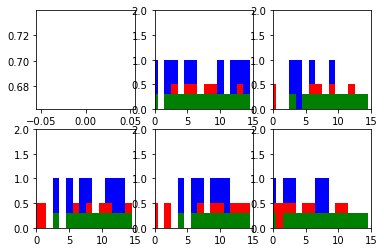

Step 100 Loss 0.700039
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 0 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 0 0 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 0 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 1 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 1 0 1 1 0 0]



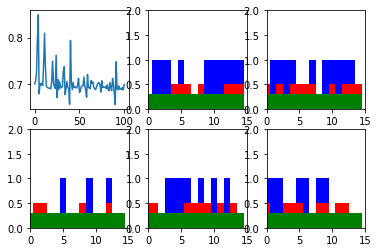

Step 200 Loss 0.72837
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 0 1 0 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 1 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 0 1 1 1 0 0]



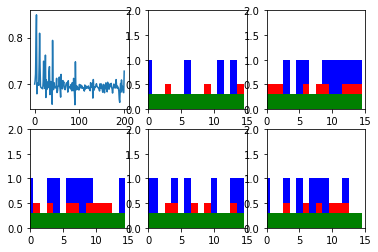

Step 300 Loss 0.702687
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 0 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 0 0 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 1 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 0 0 0 1 1 0]



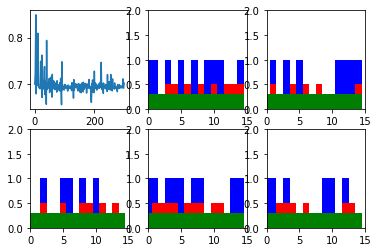

Step 400 Loss 0.711337
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 1 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 0 1 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 0 0 1 1 1]



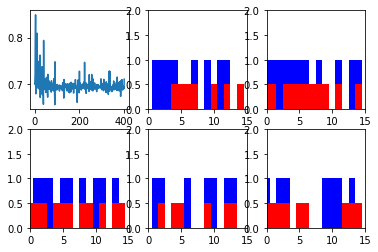

Step 500 Loss 0.69727
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 1 1 1 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 0 1 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 0 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 0 1 1 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 1 0 0 1 1 0 1]



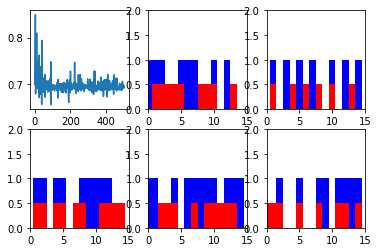

Step 600 Loss 0.693045
single_output_series: [1 0 1 0 1 1 0 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 1 0 0 1 1 1 1]

single_output_series: [1 1 0 0 0 1 0 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 1 0 1 0 1 0 1]

single_output_series: [0 1 0 0 0 0 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 0 1 1 1 1 1 1]

single_output_series: [0 0 1 0 1 0 0 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 0 0 0 0 1 0]

single_output_series: [0 1 0 1 1 1 0 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 0 0 0 0 0 0]



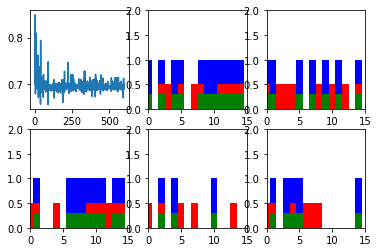

New data, epoch 1
Step 0 Loss 0.693294
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 1 1 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 0 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 0 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 0 0 1 0 0 0 0]



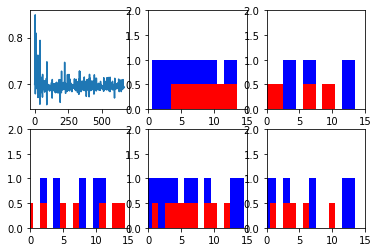

Step 100 Loss 0.69393
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 1 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 1 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 0 1 0 1 1 0 0]



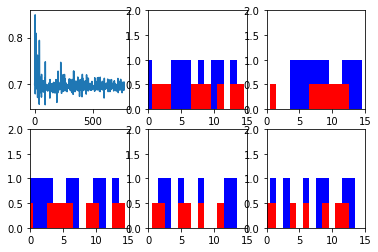

Step 200 Loss 0.692206
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 0 0 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 1 0 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 0 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 0 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 1 0 0 1 0 0 1]



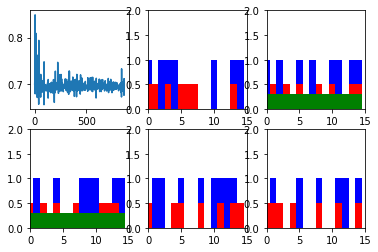

Step 300 Loss 0.698146
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 1 1 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 1 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 0 1 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 1 1 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 1 1 1 0 0 0]



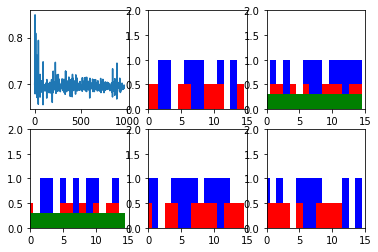

Step 400 Loss 0.692192
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 0 0 0 1 0 1]

single_output_series: [0 1 1 0 0 1 0 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 0 0 1 0 1 1]

single_output_series: [0 1 1 0 1 1 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 1 0 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 0 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 0 0 0 1 1 0]



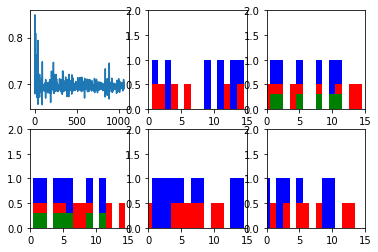

Step 500 Loss 0.693775
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 0 1 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 1 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 1 1 1 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 0 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 1 1 0 0 0 1 1]



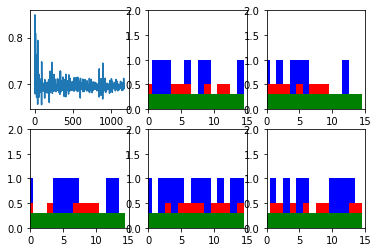

Step 600 Loss 0.698845
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 1 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 1 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 0 0 1 1 1 1]



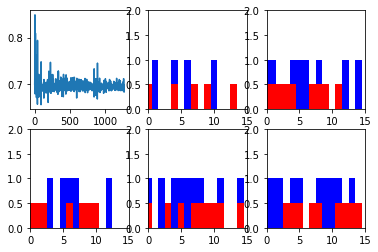

New data, epoch 2
Step 0 Loss 0.695897
single_output_series: [1 1 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 0 0 0 0 0 0]

single_output_series: [1 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 0 1 0 0 0 0]

single_output_series: [1 1 1 1 0 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 0 1 1 0 0 0]

single_output_series: [1 1 1 1 0 1 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 1 1 1 1 0 0]

single_output_series: [1 0 1 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 1 0 0 1 1]



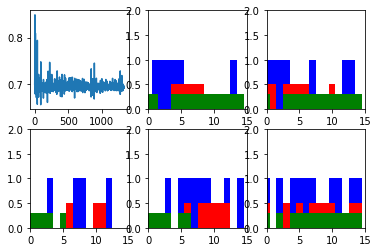

Step 100 Loss 0.693989
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 1 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 0 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 1 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 0 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 1 1 0 0 0 1 0]



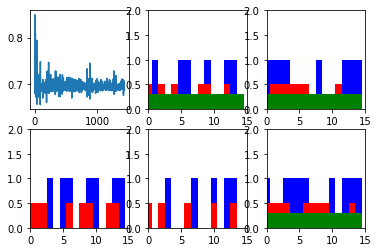

Step 200 Loss 0.702294
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 0 0 0 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 1 0 1 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 0 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 1 0 0 0 1 0 0]



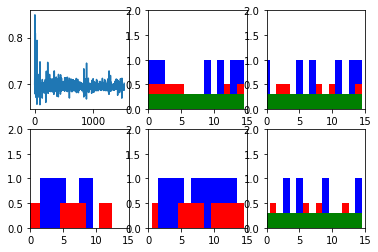

Step 300 Loss 0.691106
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 1 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 0 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 1 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 0 1 0 1 0 1]



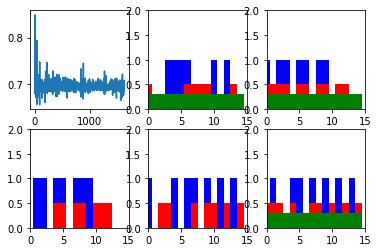

Step 400 Loss 0.696089
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 0 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 1 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 0 0 0 1 0]



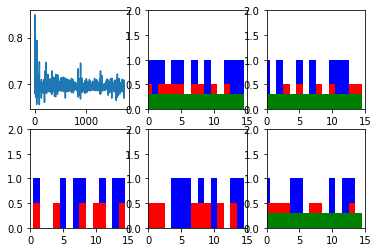

Step 500 Loss 0.692093
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 0 0 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 0 0 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 1 0 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 0 0 1 0 0 0]



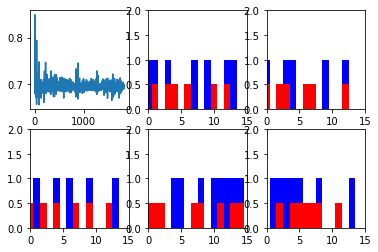

Step 600 Loss 0.684944
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 1 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 0 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 1 0 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 1 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 0 0 1 1 0 0 0]



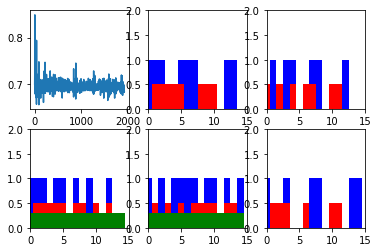

New data, epoch 3
Step 0 Loss 0.712086
single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 1 1 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 0 0 0 1 0 0]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 0 0 0 1 1 0]



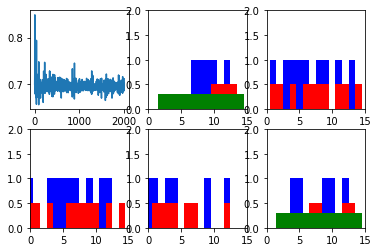

Step 100 Loss 0.696969
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 0 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 0 0 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 0 1 1 0 0 1 0]



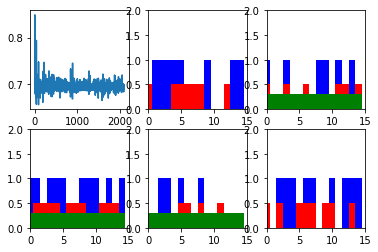

Step 200 Loss 0.701158
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 0 0 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 0 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 0 1 1 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 1 1 0 0 1]



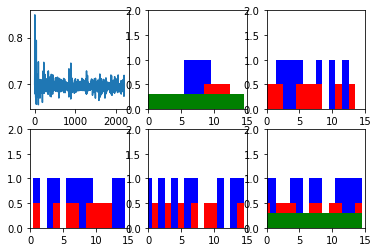

Step 300 Loss 0.694979
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 0 0 1 1 1 0]

single_output_series: [0 0 1 0 1 1 1 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 1 1 1 0 0 0]

single_output_series: [1 0 1 0 1 0 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 0 1 1 1 0 1]

single_output_series: [1 1 0 0 1 0 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 0 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 0 1 0 0 1]



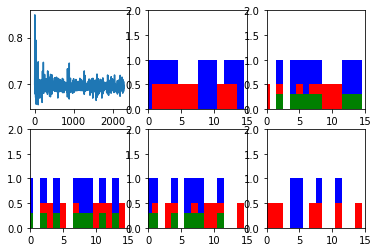

Step 400 Loss 0.691991
single_output_series: [1 1 1 1 1 1 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 0 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 1 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 1 0 1 1 0 1 1]

single_output_series: [1 0 1 1 1 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 0 1 0 1 0]



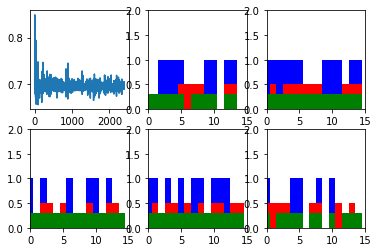

Step 500 Loss 0.69436
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 1 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 0 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 0 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 1 1 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 0 1 0 1 1 0]



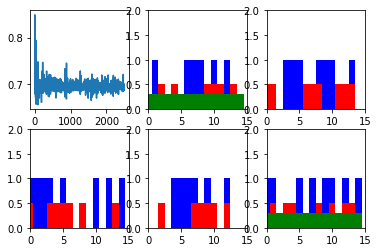

Step 600 Loss 0.69282
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 1 0 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 0 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 1 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 0 1 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 1 1 1 0 0 0]



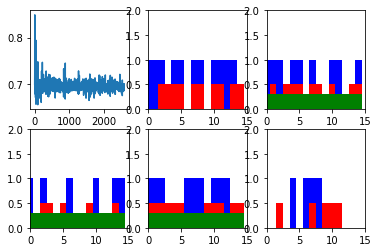

New data, epoch 4
Step 0 Loss 0.68902
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 1 0 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 1 1 0 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 0 1 0 0 1 0 0]



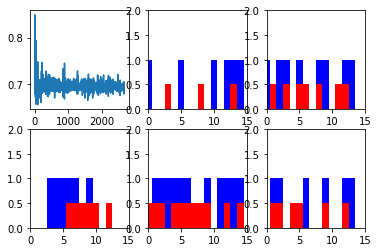

Step 100 Loss 0.69277
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 1 1 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 0 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 1 1 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 1 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 1 1 1 1 1 1]



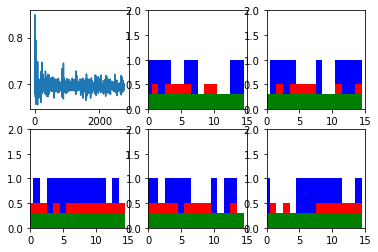

Step 200 Loss 0.702507
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 1 0 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 0 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 0 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 0 1 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 0 1 0 0 1 0]



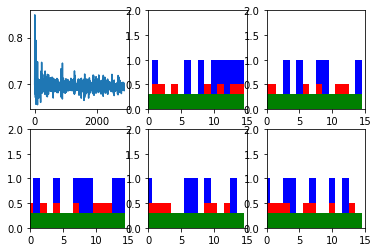

Step 300 Loss 0.693154
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 1 0 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 0 1 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 0 1 1 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 1 1 0 1 1 1 1]



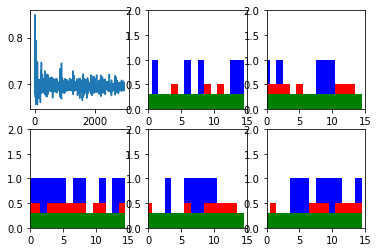

Step 400 Loss 0.693509
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 1 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 0 0 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]



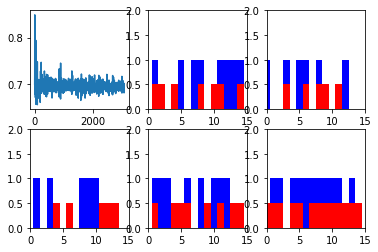

Step 500 Loss 0.692436
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 1 0 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 0 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 1 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 0 0 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 1 1 1 1 1]



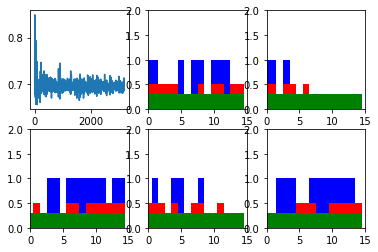

Step 600 Loss 0.693464
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 0 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 1 1 1 1 0 0]



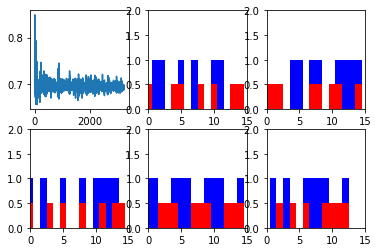

New data, epoch 5
Step 0 Loss 0.68302
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 0 0 1 1 1 0]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 0 1 1 1 0 1 0]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 1 1 0 0 1 0]



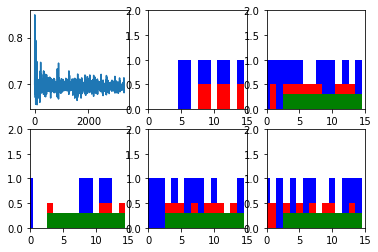

Step 100 Loss 0.695103
single_output_series: [0 0 1 1 0 0 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 0 0 1 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 0 0 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 1 0 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 1 1 0 0 0 0 0]



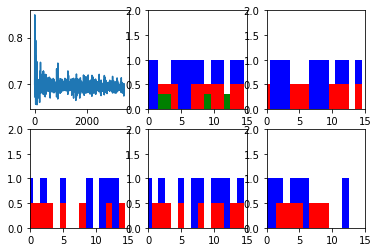

Step 200 Loss 0.697074
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 1 0 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 1 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 0 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 1 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 1 1 1 1 1 0 0]



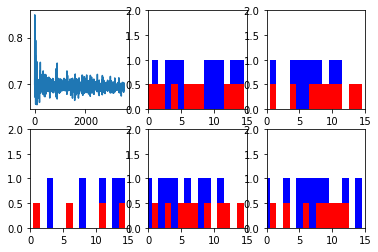

Step 300 Loss 0.693161
single_output_series: [1 1 1 0 1 1 1 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 0 0 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 1 1 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 1 1 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 0 0 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 0 0 0 1 1 1]



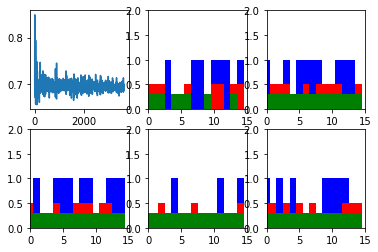

Step 400 Loss 0.700927
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 1 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 0 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 0 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 0 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 1 1 1 0 0 1]



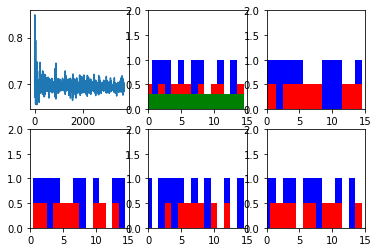

Step 500 Loss 0.695175
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 1 0 0 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 1 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 0 1 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 1 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 1 0 1 0 1]



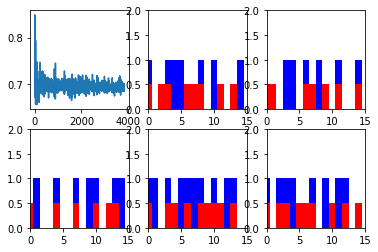

Step 600 Loss 0.687773
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 1 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 1 0 0 1 1 0 1]



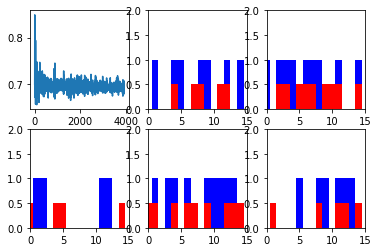

New data, epoch 6
Step 0 Loss 0.677983
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 0 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 0 1 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 0 1 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 1 1 1 1 1 1]



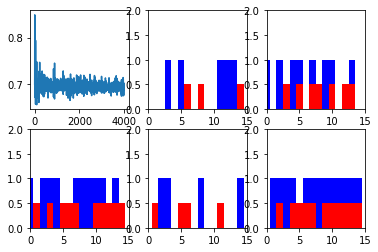

Step 100 Loss 0.692061
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 1 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 1 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 1 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 1 0 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 0 1 0 0 1 0 1]



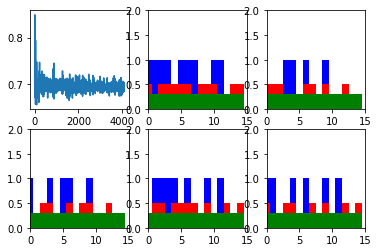

Step 200 Loss 0.695216
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 1 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 1 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 1 1 0 0 1 0 0]



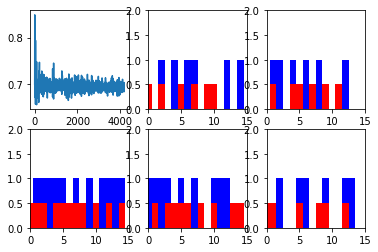

Step 300 Loss 0.693085
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 0 1 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 0 1 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 1 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 1 0 1 1 1 1 1]



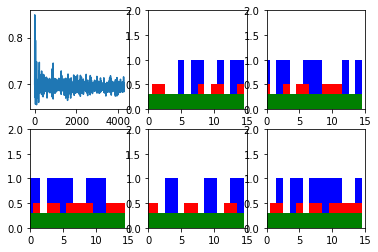

Step 400 Loss 0.703861
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 0 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 1 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 1 0 0 1 0 1]



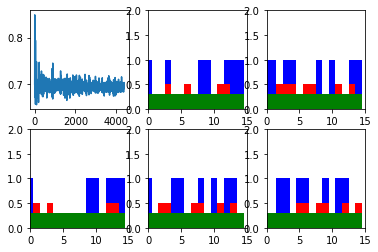

Step 500 Loss 0.692663
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 0 1 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 0 1 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 0 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 0 0 1 1 1 1]



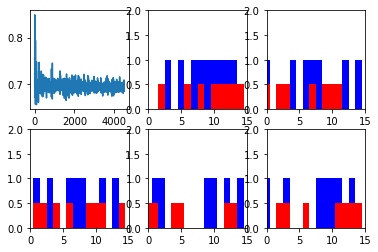

Step 600 Loss 0.690519
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 0 0 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 1 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 0 1 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 1 0 0 1 1 1 1]



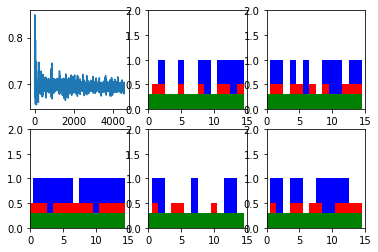

New data, epoch 7
Step 0 Loss 0.670495
single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 0 1 0 0 0 1]

single_output_series: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 0 1 0 1 1 1 0]



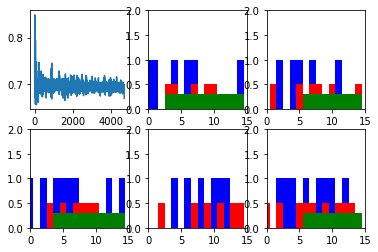

Step 100 Loss 0.69604
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 0 0 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 1 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 0 1 1 0 1 0 0]



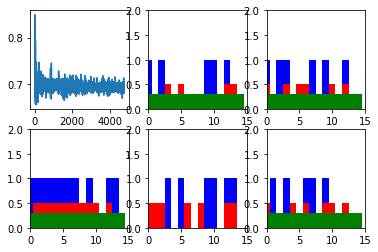

Step 200 Loss 0.690264
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 1 0 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 1 1 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 1 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 1 1 1 0 0 0 1]



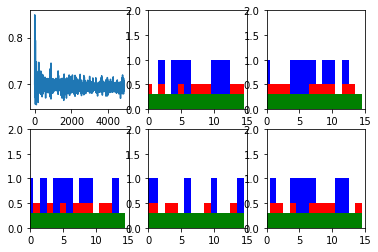

Step 300 Loss 0.692915
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 1 1 1 1 0 0]

single_output_series: [1 1 0 0 0 0 0 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 1 1 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 1 0 0 1 1 1 0]



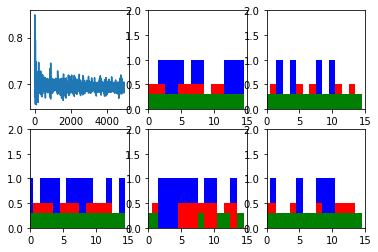

Step 400 Loss 0.6932
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 0 1 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 1 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 1 0 1 0 0 0]

single_output_series: [0 1 1 1 0 0 0 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 1 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 1 1 1 0 1 0]



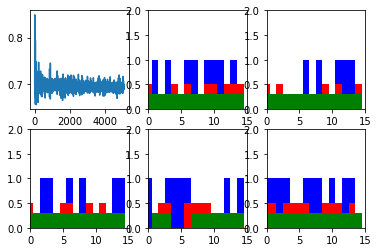

Step 500 Loss 0.691352
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 0 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 1 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 1 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 1 1 0 1 1 1 0]



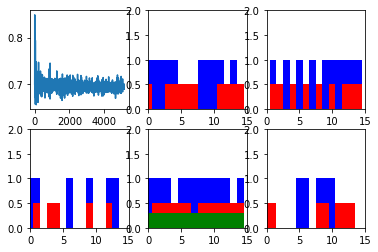

Step 600 Loss 0.691533
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 1 1 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 1 1 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 0 1 0 1 1 0]



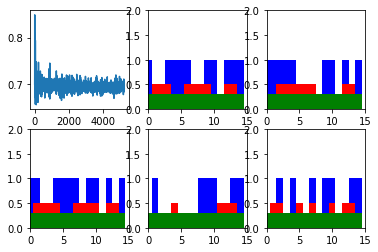

New data, epoch 8
Step 0 Loss 0.684822
single_output_series: [0 0 0 0 0 1 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 1 0 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 1 0 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 1 1 0 0 0 0 0]



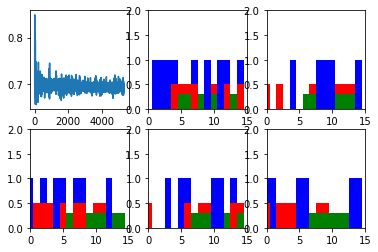

Step 100 Loss 0.692045
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 0 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 1 1 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 0 1 0 0 1 1]



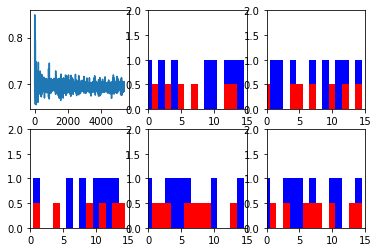

Step 200 Loss 0.693778
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 1 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 1 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 1 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 0 0 1 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 1 0 1 1 0 0]



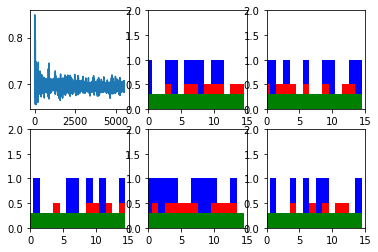

Step 300 Loss 0.699281
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 1 1 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 1 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 0 1 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 1 1 0 1 1 0 1]



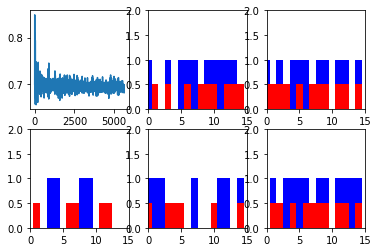

Step 400 Loss 0.693062
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 0 1 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 0 1 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 1 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 0 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 1 1 0 1 0 0]



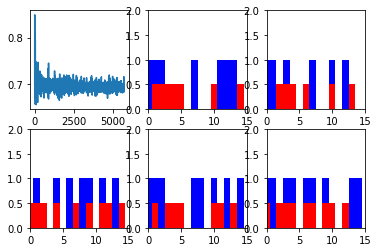

Step 500 Loss 0.690309
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 0 0 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 1 1 0 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 0 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 1 0 0 0 1 0]



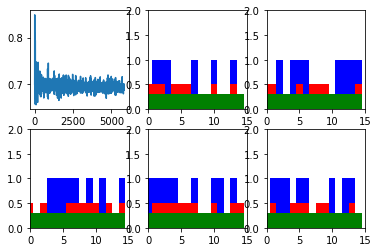

Step 600 Loss 0.693812
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 1 0 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 1 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 1 0 1 1 1]



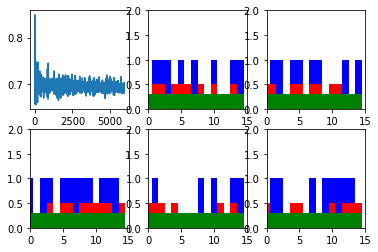

New data, epoch 9
Step 0 Loss 0.685595
single_output_series: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 0 1 1 1 0 0]

single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 1 0 1 0 1 0 1]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 0 0 1 1 0 0]



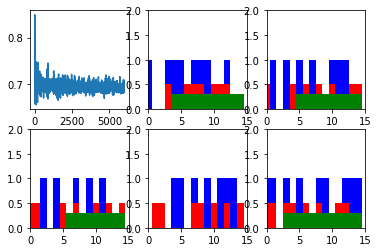

Step 100 Loss 0.698652
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 1 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 1 1 0 0 0 0 1]

single_output_series: [1 1 1 0 0 0 0 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 1 1 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 0 0 0 1 1 1]



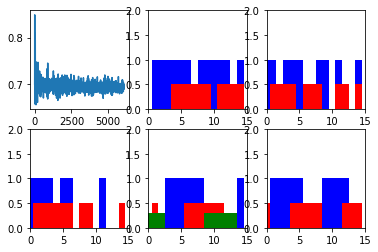

Step 200 Loss 0.690013
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 0 1 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 0 1 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 0 0 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 0 0 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 0 0 1 0 1 0]



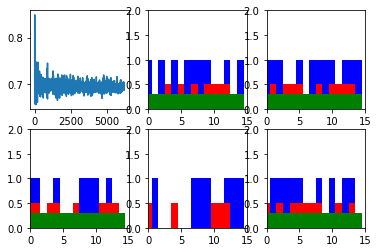

Step 300 Loss 0.694323
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 1 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 1 1 0 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 1 1 1 1 0 0]



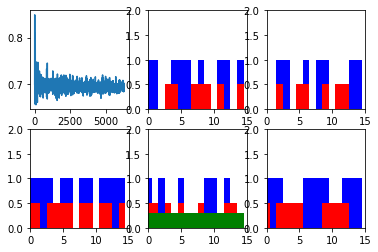

Step 400 Loss 0.694882
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 1 1 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 0 1 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 1 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 1 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 1 1 0 1 0 1 1]



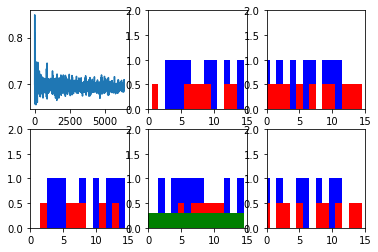

Step 500 Loss 0.689292
single_output_series: [1 0 0 1 0 1 0 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 1 0 0 0 1 0]

single_output_series: [1 0 1 0 0 1 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 0 0 0 0 1 1 1]

single_output_series: [1 1 0 1 1 0 0 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 1 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]

single_output_series: [0 1 0 0 0 1 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 1 0 1 0 1 0]



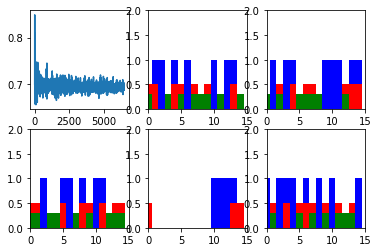

Step 600 Loss 0.688728
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 1 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 1 0 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 1 1 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 1 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 1 1 1 0 1 0 1]



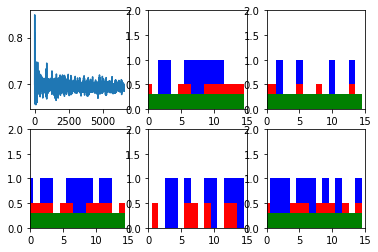

New data, epoch 10
Step 0 Loss 0.699678
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 1 1 1 1 1 0]

single_output_series: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 1 0 1 1 0 1 0]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 0 1 0 0 0 1]

single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 1 0 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 0 1 0 1 0 0]



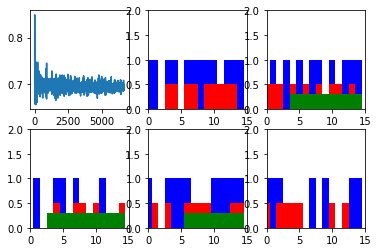

Step 100 Loss 0.694902
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 0 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 1 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 0 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 0 1 0 1 1 0]



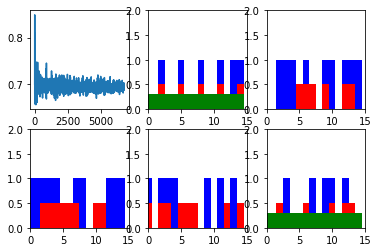

Step 200 Loss 0.688396
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 1 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 0 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 0 1 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 1 0 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 0 1 0 1 1 1]



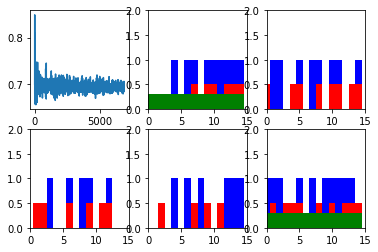

Step 300 Loss 0.693263
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 1 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 1 0 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 0 1 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 0 0 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 1 1 0 0 0 1]



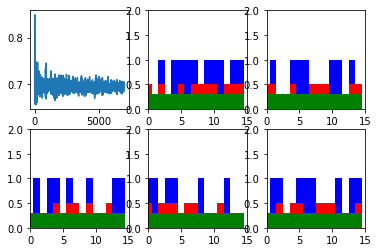

Step 400 Loss 0.690143
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 1 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 0 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 0 0 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 1 0 1 1 1 0 1]



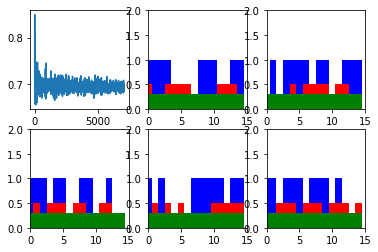

Step 500 Loss 0.695079
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 1 0 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 1 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 0 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 1 1 0 1 0 1 1]



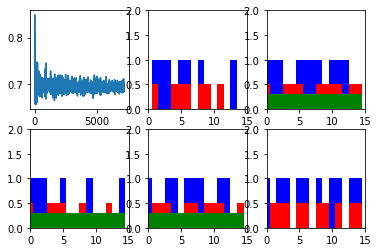

Step 600 Loss 0.693901
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 0 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 0 1 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 0 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 0 1 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 0 0 1 0 0 0]



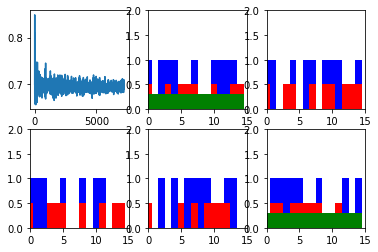

New data, epoch 11
Step 0 Loss 0.692384
single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 0 0 1 1 0]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 0 0 1 1 1 1]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 0 1 1 1 0 0]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 0 1 0 0 0 0]

single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 0 1 1 0 1 1]



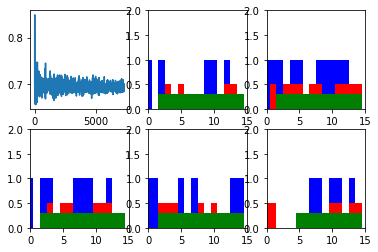

Step 100 Loss 0.693953
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 1 0 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 1 0 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 1 0 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 0 0 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 0 1 0 1 1 1]



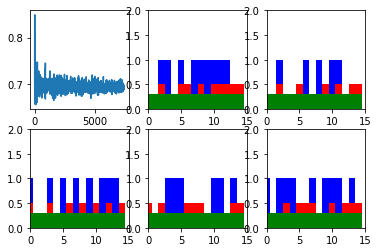

Step 200 Loss 0.690919
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 1 1 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 1 1 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 0 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 0 1 0 0 0 0 1]



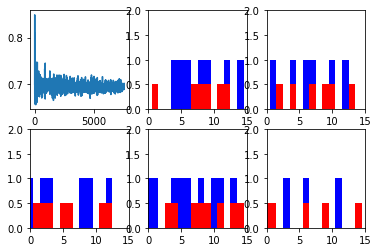

Step 300 Loss 0.702168
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 0 1 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 0 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 1 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 1 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 1 1 1 1 1 0]



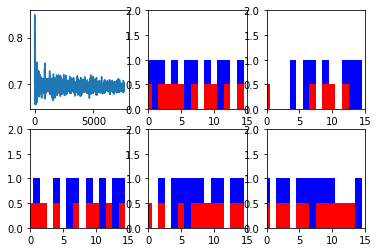

Step 400 Loss 0.685902
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 0 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 1 0 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 0 0 0 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 1 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 1 1 0 1 1 0 1]



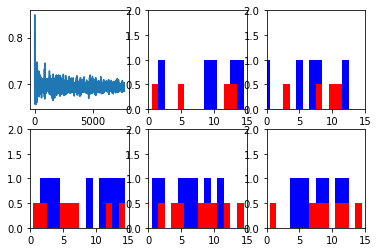

Step 500 Loss 0.693319
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 0 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 0 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 0 1 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 1 0 0 1 0 0 0]



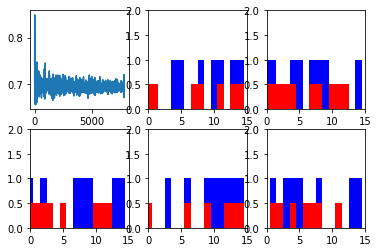

Step 600 Loss 0.689059
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 1 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 1 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 1 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 1 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 0 1 0 0 1 0]



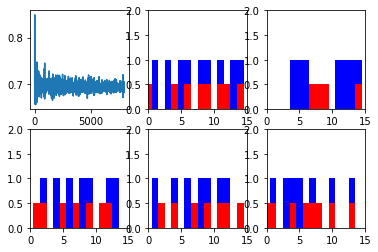

New data, epoch 12
Step 0 Loss 0.678652
single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 0 1 1 1 0 0]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 1 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 1 0 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 1 1 0 1 1 1]



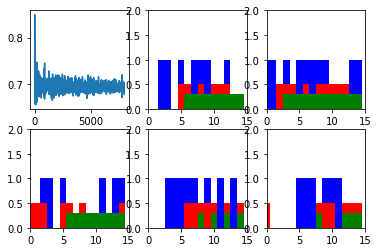

Step 100 Loss 0.693842
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 0 1 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 1 0 1 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 1 1 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 1 1 1 0 0]



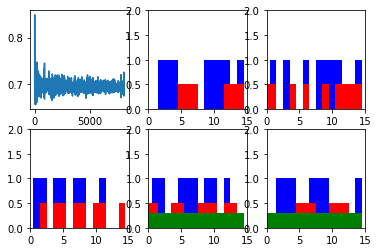

Step 200 Loss 0.692127
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 1 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 0 0 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 1 1 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 1 0 1 1 0 0]



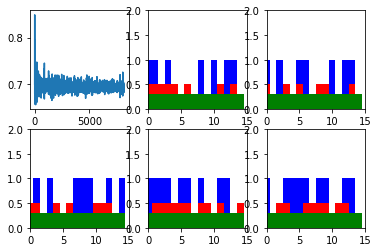

Step 300 Loss 0.70708
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 0 1 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 1 1 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 1 0 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 1 0 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 1 1 1 1 1 1 0]



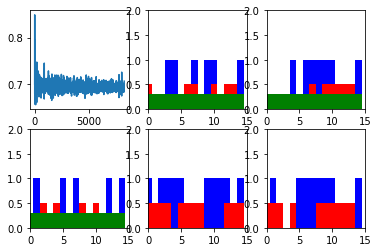

Step 400 Loss 0.701975
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 1 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 1 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 0 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 1 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 1 0 1 1 0 0]



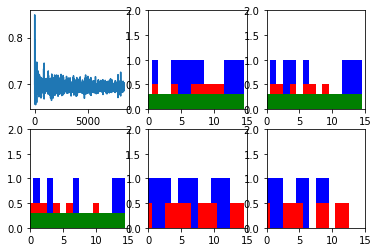

Step 500 Loss 0.691731
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 1 0 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 0 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 0 1 1 0 0 1]



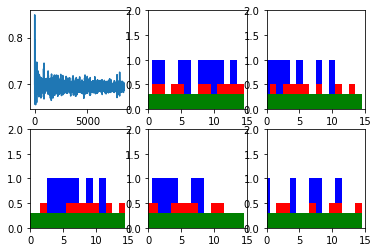

Step 600 Loss 0.694998
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 1 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 1 1 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 0 0 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 1 1 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 0 1 1 1 0 0 0]



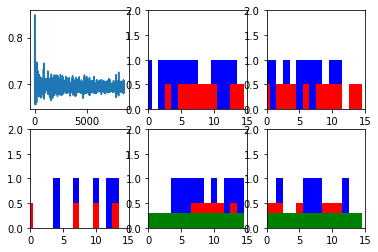

New data, epoch 13
Step 0 Loss 0.675727
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 0 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 1 1 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 0 0 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 1 0 0 0 0 0]



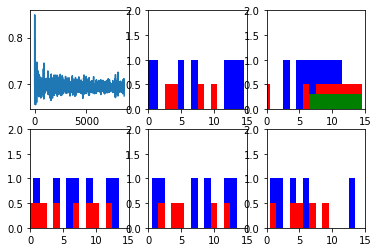

Step 100 Loss 0.693333
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 0 0 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 1 0 1 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 0 0 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 0 0 1 1 0 0 1]



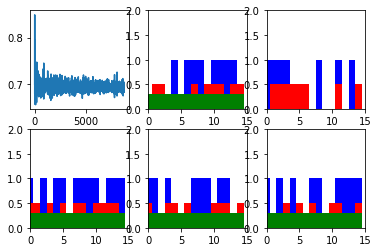

Step 200 Loss 0.692101
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 1 1 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 0 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 1 1 0 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 1 0 0 1 1 0]



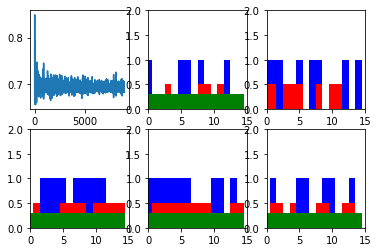

Step 300 Loss 0.691739
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 0 1 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 0 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 1 0 1 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 1 0 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 1 1 0 1 1 0]



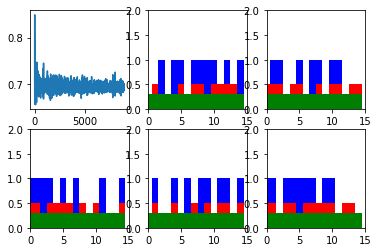

Step 400 Loss 0.695559
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 0 0 0 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 0 0 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 1 1 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 0 0 1 0 0]



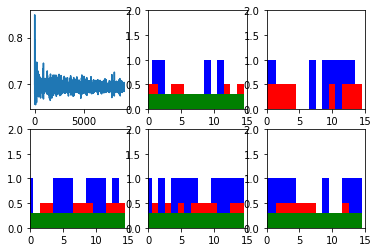

Step 500 Loss 0.692929
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 1 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 0 0 0 0 0 1]



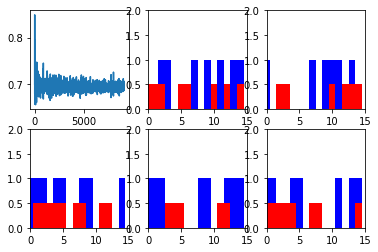

Step 600 Loss 0.695395
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 0 1 1 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 1 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 0 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 1 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 0 1 1 1 0]



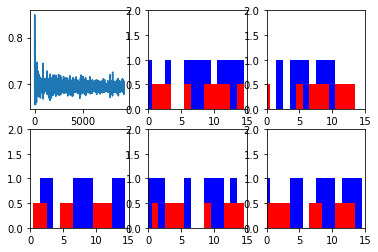

New data, epoch 14
Step 0 Loss 0.681285
single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 1 1 0 0 1 0]

single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 1 0 0 0 1 1]

single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 1 0 1 0 0 0]

single_output_series: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 0 0 0 1 0 0 1]



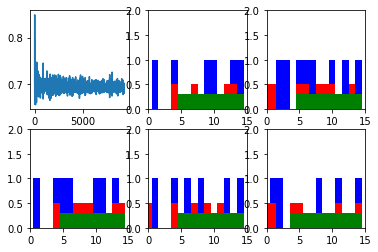

Step 100 Loss 0.697081
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 0 1 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 0 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 1 0 0 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 1 0 1 1 0]



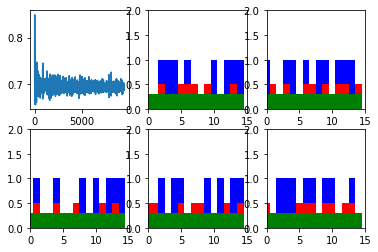

Step 200 Loss 0.693958
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 1 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 0 1 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 1 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 1 1 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 1 0 0 1 1 0]



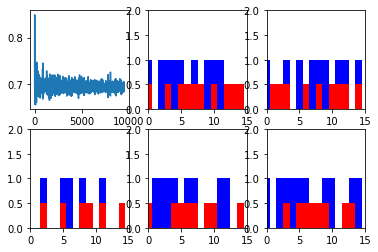

Step 300 Loss 0.692377
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 1 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 1 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 1 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 0 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 1 1 1 1 1 0]



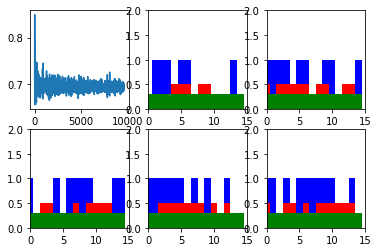

Step 400 Loss 0.686199
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 1 0 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 1 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 0 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 0 1 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 1 0 0 1 0 1 1]



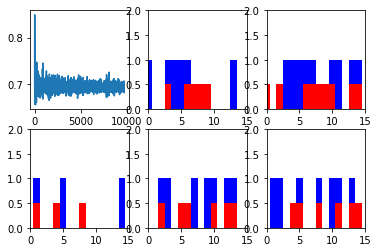

Step 500 Loss 0.693727
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 0 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 1 1 1 1 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 1 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 1 0 0 0 0 1 0]



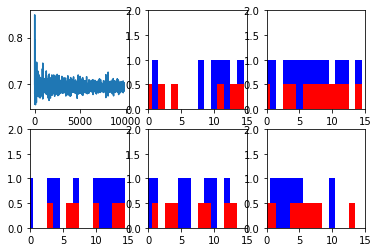

Step 600 Loss 0.693753
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 1 0 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 0 0 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 1 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 1 1 0 1 0]



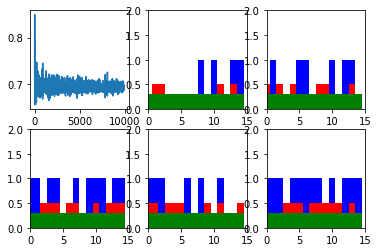

New data, epoch 15
Step 0 Loss 0.688631
single_output_series: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 1 1 0 1 1 0]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 1 1 1 1 0 1 0]



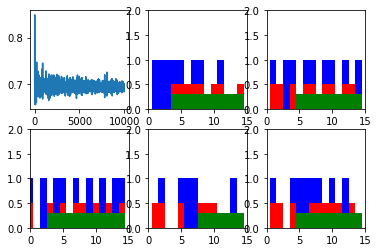

Step 100 Loss 0.692069
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 0 1 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 1 0 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 0 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 1 0 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 0 1 0 1 1 0]



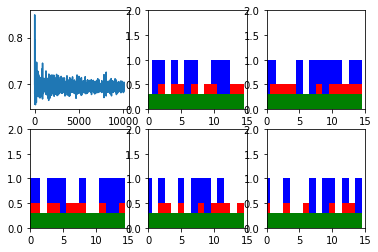

Step 200 Loss 0.692908
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 1 1 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 0 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 1 0 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 1 1 0 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 0 0 0 1 0 0]



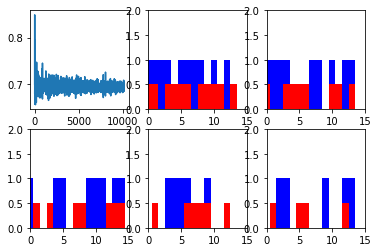

Step 300 Loss 0.693821
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 1 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 0 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 0 0 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 1 1 1 1 1 1]



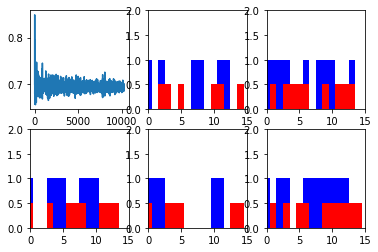

Step 400 Loss 0.6934
single_output_series: [1 1 1 0 0 0 1 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 1 1 0 0 1 0]

single_output_series: [1 1 1 0 1 0 1 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 1 0 1 0 0 1]

single_output_series: [0 0 0 1 0 1 0 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 0 0 0 0 1 0]

single_output_series: [0 1 0 0 1 1 1 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 1 1 0 0 1 1 0]

single_output_series: [0 1 0 0 1 1 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 0 1 1 1 0 1]



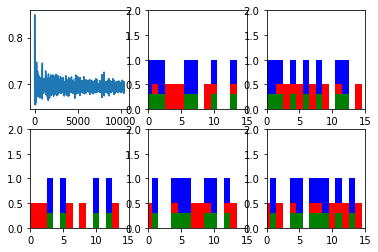

Step 500 Loss 0.694437
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 1 1 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 1 1 1 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 1 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 0 0 1 0 0 1 1]



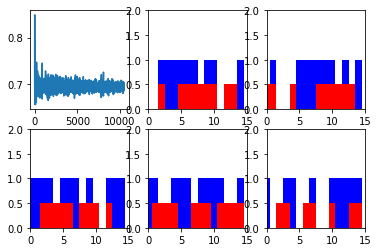

Step 600 Loss 0.696866
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 1 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 0 0 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 0 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 0 1 0 1 1 0 1]



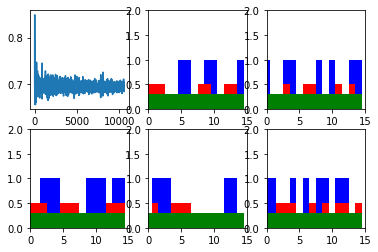

New data, epoch 16
Step 0 Loss 0.684823
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 0 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 1 1 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 1 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 0 1 1 1 0 1]



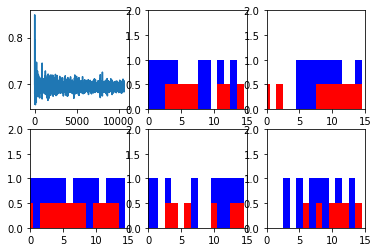

Step 100 Loss 0.693426
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 0 0 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 1 0 0 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 1 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 0 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 0 1 0 0 1 0]



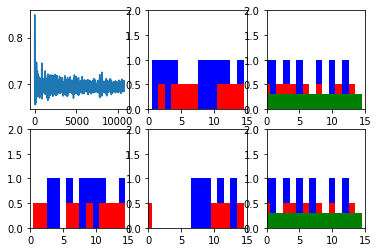

Step 200 Loss 0.69233
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 0 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 0 0 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 0 0 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 1 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 1 1 1 0 1 1]



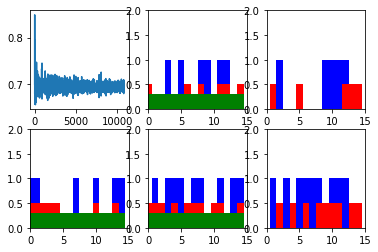

Step 300 Loss 0.69622
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 1 1 0 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 0 1 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 0 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 1 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 0 1 0 0 0 1]



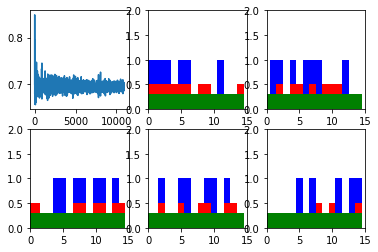

Step 400 Loss 0.695575
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 0 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 1 1 1 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 1 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 1 0 0 0 1 1]



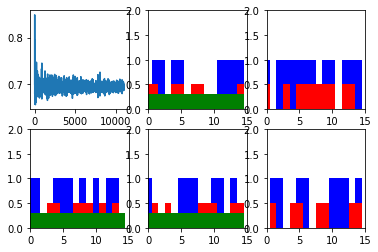

Step 500 Loss 0.692722
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 0 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 1 1 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 0 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 0 0 0 1 1 1]



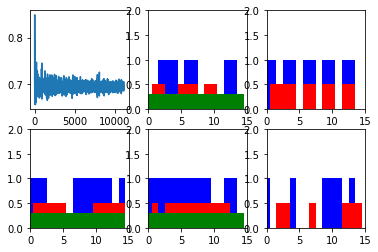

Step 600 Loss 0.692191
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 1 1 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 1 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 0 0 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 1 0 1 0 0 0 1]



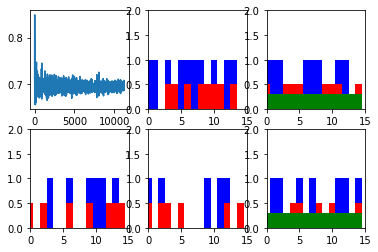

New data, epoch 17
Step 0 Loss 0.694937
single_output_series: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 0 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 1 1 0 1 1 0 1]

single_output_series: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 0 0 0 1 0 0 1]

single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 1 0 1 0 0 1]



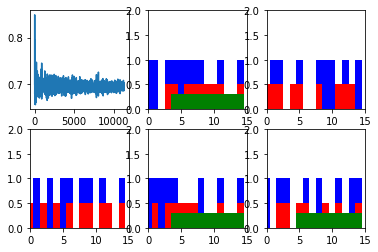

Step 100 Loss 0.692933
single_output_series: [0 0 1 1 0 1 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 0 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 0 0 0 1 1 0 1]

single_output_series: [1 0 0 0 1 1 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 1 0 1 1 1 1 0]

single_output_series: [1 0 0 1 1 0 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 0 1 0 0 1 1]



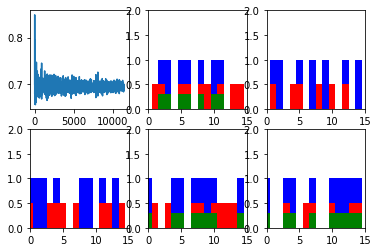

Step 200 Loss 0.691857
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 1 0 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 1 0 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 0 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 0 1 0 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 1 0 0 0 1 1]



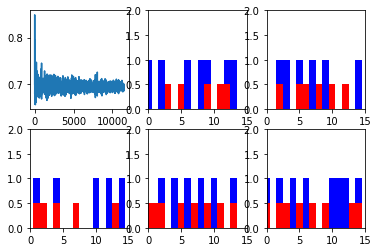

Step 300 Loss 0.692072
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 1 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 1 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 1 0 0 0 0 1 1]



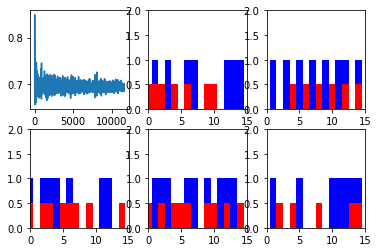

Step 400 Loss 0.690454
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 0 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 0 0 1 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 1 1 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 1 1 0 1 0 0]



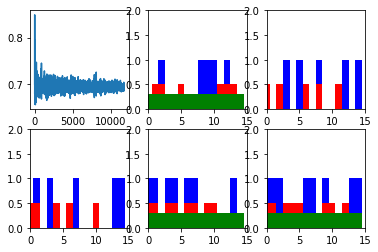

Step 500 Loss 0.692877
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 1 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 1 1 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 0 0 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 0 1 1 1 1 1 1]



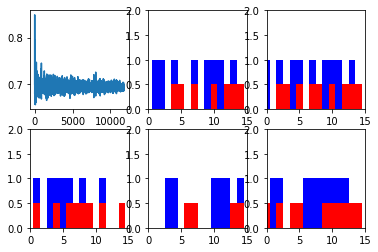

Step 600 Loss 0.684982
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 0 0 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 1 0 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 0 1 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 0 0 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 1 1 1 1 1 1]



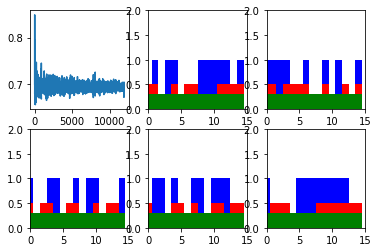

New data, epoch 18
Step 0 Loss 0.6982
single_output_series: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 1 0 1 0 0 0]

single_output_series: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 1 0 1 0 1 1 0]

single_output_series: [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 0 1 1 1 0 1]

single_output_series: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 1 0 1 0 0]

single_output_series: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 0 1 1 0 1]



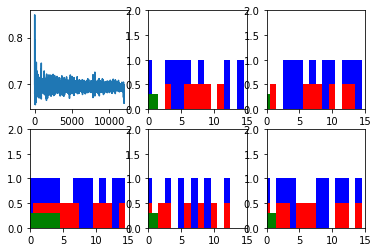

Step 100 Loss 0.418667
single_output_series: [0 1 1 1 0 0 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 0 0 0 0 1 0 0]

single_output_series: [0 0 1 1 0 0 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 1 0 0 1 1 1]

single_output_series: [0 1 1 1 1 1 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 0 0 1 0 1 0 1]

single_output_series: [0 0 0 1 1 1 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 1 1 1 0 0]

single_output_series: [1 1 1 1 0 0 1 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 1 0 1 1 1 1 1]



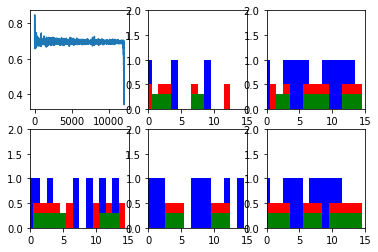

Step 200 Loss 0.41005
single_output_series: [0 1 1 0 0 1 1 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 0 0 0 0 1 0]

single_output_series: [0 0 0 1 1 0 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 0 1 1 1 0 1]

single_output_series: [0 0 0 0 0 0 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 0 0 1 1 1 1 1]

single_output_series: [0 0 1 1 0 1 1 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 1 0 1 0 1 0 0]



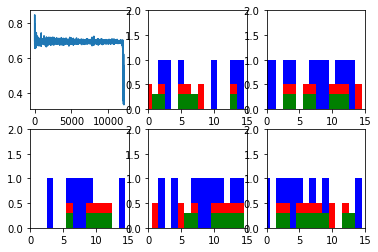

Step 300 Loss 0.417516
single_output_series: [0 0 0 1 0 0 0 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 0 1 0 0 0 1]

single_output_series: [1 0 1 1 0 0 0 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 1 0 0 0 1 0]

single_output_series: [1 1 0 0 1 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 0 0 0 0 0 0]

single_output_series: [0 0 0 1 1 1 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 0 0 0 1 0 1]

single_output_series: [0 1 1 0 1 1 0 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 0 0 0 1 0 1 1]



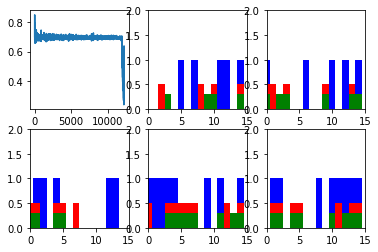

Step 400 Loss 0.450347
single_output_series: [0 0 0 0 1 0 0 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 1 0 0 0 0]

single_output_series: [0 0 0 1 1 0 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 1 0 1 0 1 1]

single_output_series: [0 1 1 1 1 1 0 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 1 0 0 1 0 0]

single_output_series: [1 0 0 0 0 1 0 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 1 1 1 0 1 1 0]

single_output_series: [0 1 1 1 0 0 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 0 1 1 1 1 0]



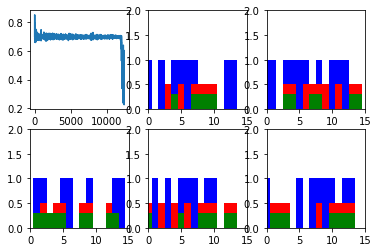

Step 500 Loss 0.379734
single_output_series: [1 1 0 1 1 1 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 1 0 1 0 0 0 1]

single_output_series: [0 0 0 1 1 1 1 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 0 1 1 1 1 1 1]

single_output_series: [0 1 1 1 0 0 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 0 0 1 1 1 0]

single_output_series: [0 1 1 1 1 1 1 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 0 1 0 1 0 1]

single_output_series: [1 0 1 1 0 1 1 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 1 1 0 0 1]



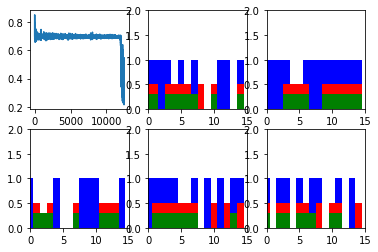

Step 600 Loss 0.0506015
single_output_series: [0 0 0 0 1 0 0 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 1 1 0 0 0 0]

single_output_series: [0 0 0 1 0 0 1 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 0 0 0 0 0 0]

single_output_series: [0 1 1 1 0 0 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 0 0 1 1 1 0]

single_output_series: [0 1 0 0 0 1 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 0 0 1 0 1 1]

single_output_series: [1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]



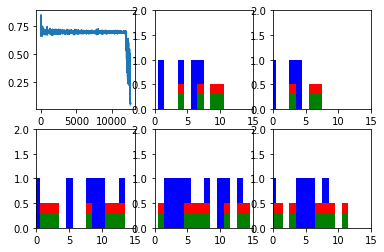

New data, epoch 19
Step 0 Loss 0.295244
single_output_series: [1 1 0 0 0 1 0 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 0 0 1 1 0 1]

single_output_series: [1 1 0 0 1 1 1 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 1 1 0 1 1 0]

single_output_series: [1 1 0 1 0 1 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 1 0 1 1 1 0]

single_output_series: [1 1 0 0 1 0 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 1 0 0 0 0 0]

single_output_series: [1 1 0 1 0 1 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 0 1 1 0 1 0]



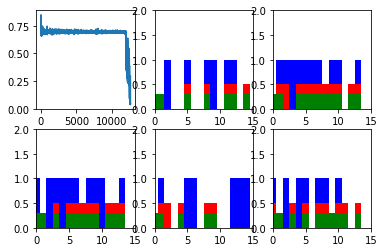

Step 100 Loss 0.032015
single_output_series: [1 1 1 1 1 0 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 0 1 0 0 1 0 1]

single_output_series: [0 0 1 1 1 1 1 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 0 1 0 1 1 1 0]

single_output_series: [0 0 1 0 1 0 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 0 1 0 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 0 1 1 0 1 0]

single_output_series: [1 0 1 1 0 1 1 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 1 0 1 1 0 1 1]



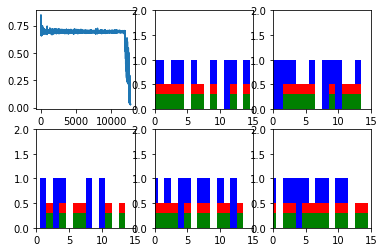

Step 200 Loss 0.0240483
single_output_series: [0 1 0 1 0 1 1 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 1 1 1 0 0 0]

single_output_series: [1 0 1 0 1 0 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 1 1 0 0 1 1 1]

single_output_series: [1 0 1 1 1 0 1 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 1 0 0 1 0 0]

single_output_series: [0 0 0 0 1 0 0 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 1 1 1 0 0 1]

single_output_series: [1 1 1 0 1 0 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 1 1 1 1 1 1 0]



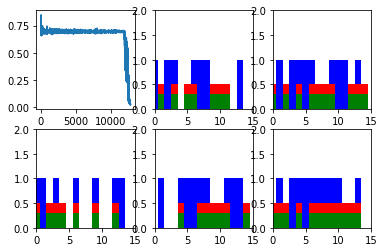

Step 300 Loss 0.0196938
single_output_series: [0 1 0 1 0 0 0 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 1 0 0 0 1 0]

single_output_series: [1 1 0 1 0 0 1 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 0 1 0 0 1 0 0]

single_output_series: [0 0 1 1 1 0 0 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 0 1 0 0 1]

single_output_series: [0 0 1 0 1 1 1 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 0 1 0 0 1]

single_output_series: [1 1 0 1 1 0 1 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 1 0 1 1 0 0]



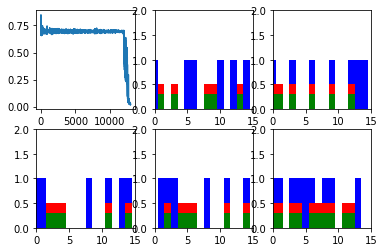

Step 400 Loss 0.0172509
single_output_series: [1 0 0 0 0 0 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 0 1 1 0 0 1 1]

single_output_series: [0 1 1 1 1 0 1 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 1 1 0 1 0]

single_output_series: [0 1 1 1 1 1 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 1 1 1 0 1]

single_output_series: [0 1 0 1 1 0 0 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 1 1 1 0 0 0 0]

single_output_series: [1 0 1 1 0 0 0 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 1 1 1 0 0 0]



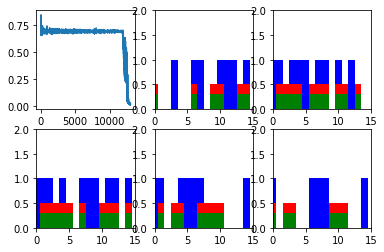

Step 500 Loss 0.0156084
single_output_series: [0 1 1 0 1 0 0 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 1 1 0 0 1 0]

single_output_series: [1 0 1 1 0 0 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 0 1 1 1 0 0]

single_output_series: [0 1 0 1 1 1 1 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 0 1 0 1 1 1]

single_output_series: [1 0 1 1 1 0 1 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 1 0 0 1 1 0]



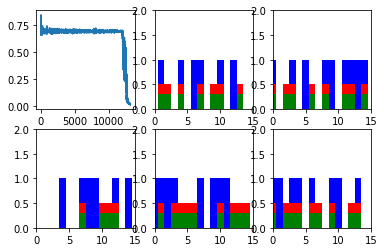

Step 600 Loss 0.0135222
single_output_series: [0 0 1 0 1 0 1 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 1 1 1 1 0 1]

single_output_series: [0 0 0 1 1 1 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 1 0 1 1 1 1]

single_output_series: [0 0 1 1 0 1 1 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 1 1 1 0 1 1 1]

single_output_series: [0 0 1 0 1 0 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 0 1 1 0 0 0]

single_output_series: [1 1 1 0 0 0 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 0 1 0 1 0 0]



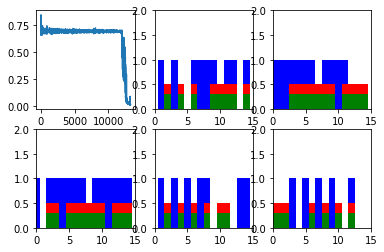

New data, epoch 20
Step 0 Loss 0.174085
single_output_series: [0 1 0 0 1 0 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 0 0 1 0 1 1 1]

single_output_series: [0 1 0 1 1 0 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 1 0 1 1 0 1]

single_output_series: [0 1 0 0 1 1 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 1 1 1 0 1 1]

single_output_series: [0 1 0 1 1 0 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 0 0 1 0 1 0 0]

single_output_series: [0 1 0 1 1 0 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 0 0 1 1 1 0]



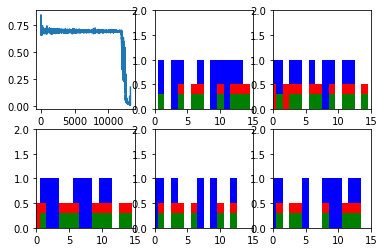

Step 100 Loss 0.0112927
single_output_series: [0 1 0 1 0 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 0 1 0 1 1 1]

single_output_series: [1 1 0 1 0 1 0 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 0 0 0 0 0 0 1]

single_output_series: [0 1 1 0 0 1 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 1 0 0 0 1 1 0]

single_output_series: [0 1 0 1 0 0 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 1 1 0 1 1 1 0]

single_output_series: [1 0 1 0 0 0 1 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 1 1 1 0 0 0]



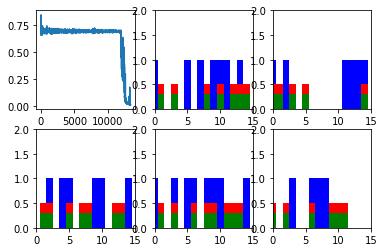

Step 200 Loss 0.00984624
single_output_series: [0 1 0 1 0 0 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 0 0 1 0 0]

single_output_series: [1 0 1 1 0 1 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 1 0 1 0 0 1 0]

single_output_series: [0 0 0 1 0 1 1 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 1 1 1 1 1 0]

single_output_series: [1 1 1 1 1 1 0 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 0 0 0 0 1 0]

single_output_series: [0 1 1 0 1 0 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 0 0 0 1 1 1]



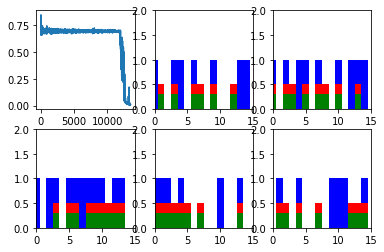

Step 300 Loss 0.00805072
single_output_series: [1 1 1 0 0 0 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 0 0 0 1 0 0]

single_output_series: [1 1 1 0 0 1 0 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 0 1 1 0 0 0 1]

single_output_series: [1 0 0 0 0 0 1 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 0 1 0 0 1]

single_output_series: [1 0 0 0 1 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 0 1 0 0 1 0]

single_output_series: [0 0 1 1 1 1 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 1 0 1 1 1]



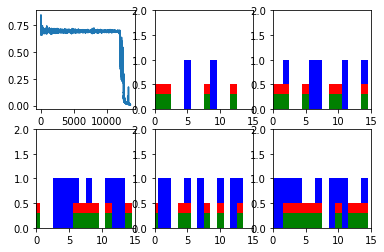

Step 400 Loss 0.00846239
single_output_series: [0 1 1 0 0 1 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 0 1 1 1 1 0]

single_output_series: [0 1 0 0 1 0 0 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 0 1 1 1 1]

single_output_series: [1 1 0 0 1 0 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 1 0 1 0 0 1 1]

single_output_series: [0 1 0 1 0 1 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 0 0 1 1 1 0]

single_output_series: [1 1 0 1 0 1 1 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 0 0 0 0 0 1]



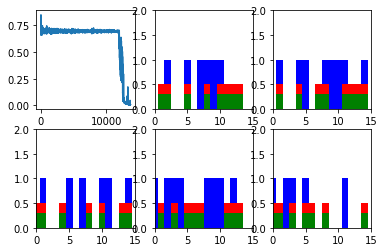

Step 500 Loss 0.0108441
single_output_series: [1 0 0 1 1 0 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 0 1 1 1 0 1]

single_output_series: [1 1 0 1 0 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 0 0 0 1 1 1 0]

single_output_series: [1 0 1 0 1 0 1 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 0 1 0 0 1 1 1]

single_output_series: [1 0 0 0 0 0 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 1 1 0 1 1]

single_output_series: [1 1 1 1 1 0 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 0 1 1 1 0 0]



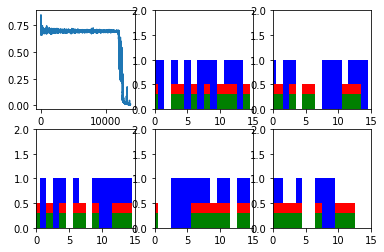

Step 600 Loss 0.00592738
single_output_series: [0 0 0 1 0 1 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 0 1 1 0 1 1]

single_output_series: [1 1 0 0 0 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 1 0 1 0 1 0]

single_output_series: [1 1 0 0 1 0 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 1 0 0 0 1 1]

single_output_series: [1 1 0 0 0 0 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 1 1 1 1 1 1]

single_output_series: [1 0 0 0 0 0 0 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 1 1 0 0 1 1]



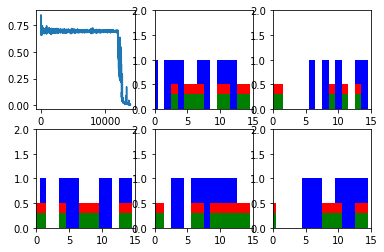

New data, epoch 21
Step 0 Loss 0.161752
single_output_series: [0 1 0 0 0 0 0 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]

single_output_series: [0 1 0 0 1 1 0 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 0 0 1 1 1 1]

single_output_series: [0 1 0 0 0 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 1 0 1 0 0 1 0]

single_output_series: [0 1 0 1 1 1 0 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 0 0 0 0 0 0]

single_output_series: [0 1 0 1 1 0 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 1 0 0 0 0 0]



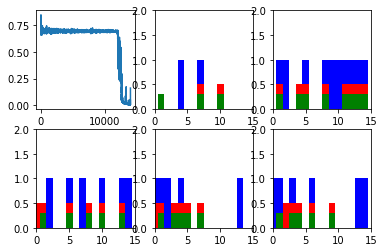

Step 100 Loss 0.00650159
single_output_series: [0 0 0 0 0 1 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 1 0 0 0 1 1]

single_output_series: [0 1 1 1 1 0 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 0 1 0 1 0 1 1]

single_output_series: [0 1 0 0 1 0 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 1 0 1 0 1 0]

single_output_series: [0 1 0 1 1 1 0 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 0 0 1 0 1 1]

single_output_series: [1 0 0 1 0 0 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 0 0 0 0 1 0 0]



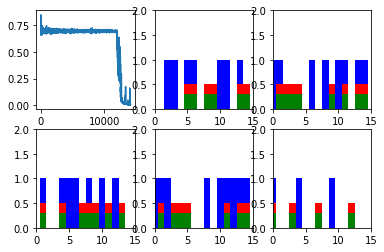

Step 200 Loss 0.00531319
single_output_series: [1 1 0 1 1 0 1 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 0 1 1 0 0 1]

single_output_series: [0 1 0 1 1 0 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 0 1 0 0 1 0]

single_output_series: [1 0 0 1 1 0 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 1 0 1 1 1 1 1 1]

single_output_series: [1 1 0 1 0 1 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 1 0 0 1 0 0]

single_output_series: [0 1 1 1 0 0 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 0 0 1 1 1 0 0]



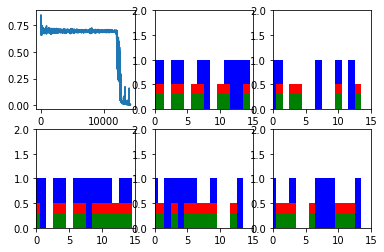

Step 300 Loss 0.00582047
single_output_series: [1 1 0 1 1 1 0 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 0 1 1 0 0 1]

single_output_series: [0 1 0 0 1 1 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 1 1 0 1 0 0]

single_output_series: [0 1 0 1 1 0 1 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 1 0 1 1 0 0 1]

single_output_series: [1 0 1 0 0 0 1 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 1 1 1 0 0]

single_output_series: [1 0 0 0 0 1 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 0 1 0 0 1]



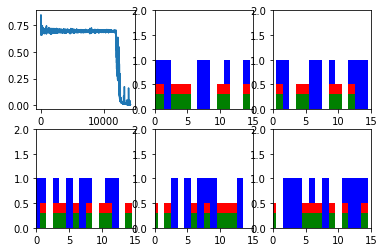

Step 400 Loss 0.00457183
single_output_series: [1 1 1 1 0 0 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 0 1 1 1 1 1]

single_output_series: [1 1 0 0 0 0 1 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 1 0 0 0 0 1]

single_output_series: [0 0 0 0 0 1 1 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 0 0 0 0 1 0]

single_output_series: [1 0 0 0 0 1 1 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 0 0 0 0 0 0]

single_output_series: [0 0 0 1 1 1 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 0 0 0 0 1 0 1]



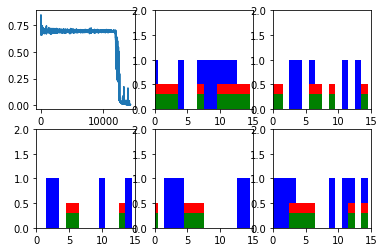

Step 500 Loss 0.00698488
single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 1 1 0 0 1]

single_output_series: [1 0 1 0 0 1 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 1 0 0 0 1 1]

single_output_series: [1 1 1 0 1 0 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 1 0 1 1 0 1]

single_output_series: [0 0 0 0 0 1 0 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 1 1 0 1 1 1]

single_output_series: [0 1 0 0 1 0 0 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 1 0 0 0 1]



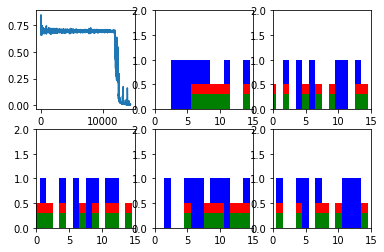

Step 600 Loss 0.00455602
single_output_series: [0 1 1 1 1 0 1 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 0 0 1 1 0 0 1]

single_output_series: [1 1 0 1 1 1 0 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 0 0 0 0 1 0]

single_output_series: [1 0 1 0 1 1 0 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 1 0 1 0 1 1]

single_output_series: [1 0 1 1 0 0 0 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 1 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 1 0 1 1 0 0 0]



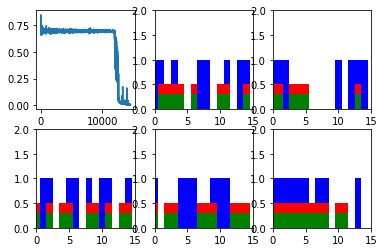

New data, epoch 22
Step 0 Loss 0.316558
single_output_series: [1 1 0 1 1 0 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 0 0 1 1 1 0]

single_output_series: [0 1 0 0 1 1 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 1 0 0 1 0 0]

single_output_series: [1 1 0 1 0 0 0 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 0 1 0 1 1]

single_output_series: [0 1 0 0 1 1 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 0 0 1 0 0 0]

single_output_series: [0 1 0 0 1 1 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 0 1 1 1 1 0]



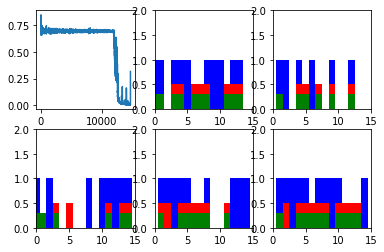

Step 100 Loss 0.00475427
single_output_series: [0 1 1 1 1 0 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 0 1 1 1 1]

single_output_series: [0 0 1 1 1 0 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 0 1 1 1 0 1 0]

single_output_series: [1 1 1 0 1 1 0 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 1 0 1 0 1 0]

single_output_series: [1 0 1 1 0 0 1 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 0 1 0 1 0]

single_output_series: [0 0 0 1 1 0 0 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 1 0 0 0 0]



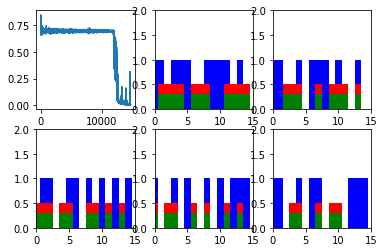

Step 200 Loss 0.0042015
single_output_series: [1 1 0 1 0 1 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 1 1 1 1 0 1]

single_output_series: [0 1 1 1 1 1 1 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 1 1 0 0 1 0]

single_output_series: [0 0 1 0 0 0 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 1 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 1 1 0 1 1]

single_output_series: [1 0 1 0 0 0 1 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 1 0 1 1 0 0]



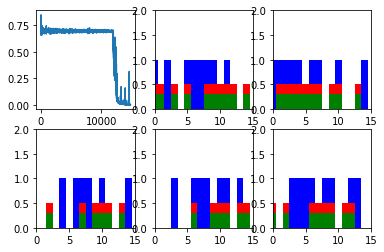

Step 300 Loss 0.00344873
single_output_series: [0 0 1 1 0 1 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 1 1 0 1 1 1 0]

single_output_series: [1 0 0 1 1 0 1 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 1 0 0 0 1 1 1 1]

single_output_series: [0 1 1 0 0 1 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 0 1 0 1 0 0]

single_output_series: [0 1 0 0 1 0 0 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 0 1 1 0 0]

single_output_series: [0 0 1 1 0 0 0 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 1 1 0 0 0 0]



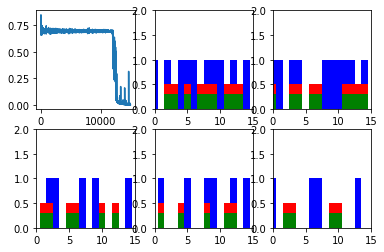

Step 400 Loss 0.00390545
single_output_series: [1 1 0 1 0 0 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 1 1 1 1 1 1]

single_output_series: [1 0 1 0 1 1 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 0 0 1 1 1 0]

single_output_series: [0 1 0 0 1 0 0 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 1 1 0 0 1 1]

single_output_series: [0 1 1 1 0 1 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 0 1 1 0 1 1]

single_output_series: [1 1 1 1 0 1 0 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 1 0 1 0 1 1]



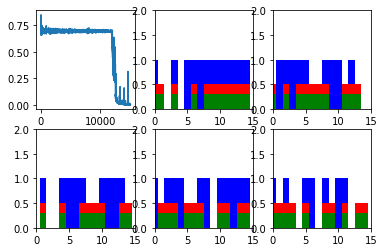

Step 500 Loss 0.00368694
single_output_series: [0 0 0 1 1 1 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 0 1 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 0 0 0 1 1 1]

single_output_series: [1 0 0 1 0 1 0 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 1 0 0 0 1 1]

single_output_series: [0 1 0 1 1 1 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 1 0 0 1 1 1]

single_output_series: [1 0 1 0 1 1 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 1 0 1 0 1 0]



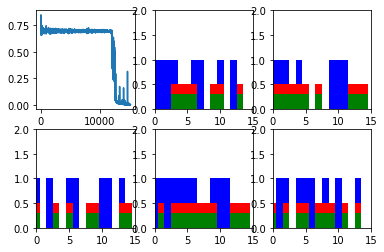

Step 600 Loss 0.00379815
single_output_series: [0 0 1 1 1 1 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 0 1 1 0 0 1]

single_output_series: [0 1 1 0 1 0 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 0 0 1 1 1 0]

single_output_series: [1 0 1 0 1 0 0 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 0 1 0 0 0 0]

single_output_series: [1 1 0 0 0 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 0 1 0 0 0 1]

single_output_series: [0 1 0 1 0 1 1 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 0 1 1 1 0 0]



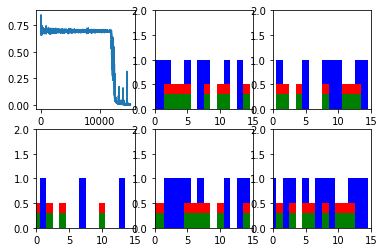

New data, epoch 23
Step 0 Loss 0.20991
single_output_series: [0 0 1 0 0 0 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 1 1 1 1 0]

single_output_series: [0 1 0 1 1 0 0 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 0 1 1 0 1 0]

single_output_series: [0 1 0 1 1 0 0 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 0 0 0 1 1 0]

single_output_series: [0 0 1 0 0 1 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 0 1 1 0 0 1]

single_output_series: [0 1 0 1 1 0 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 0 1 1 1 0 1]



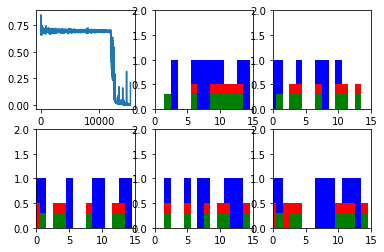

Step 100 Loss 0.0051871
single_output_series: [0 0 0 0 1 0 0 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 0 0 1 1 1 1]

single_output_series: [1 1 0 1 1 0 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 1 1 0 0 0 1]

single_output_series: [1 0 0 1 0 1 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 0 0 0 0 1 1]

single_output_series: [0 0 0 1 1 0 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 0 0 0 1 1]

single_output_series: [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]



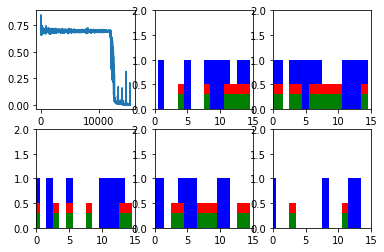

Step 200 Loss 0.00338814
single_output_series: [0 1 1 1 1 1 0 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 1 1 0 0 0 0 1]

single_output_series: [1 1 0 0 1 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 0 1 0 0 0 1]

single_output_series: [0 0 1 1 1 1 0 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 0 1 1 0 1 0]

single_output_series: [1 0 1 0 0 1 1 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 1 0 0 1 1]

single_output_series: [0 0 1 0 1 1 1 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 0 0 0 1 1 0]



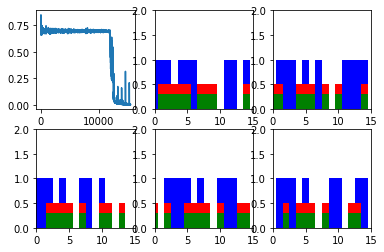

Step 300 Loss 0.00323337
single_output_series: [0 0 0 1 0 0 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 0 1 0 1 0 1 1]

single_output_series: [0 0 1 1 1 0 1 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 0 0 1 0 1 1 0]

single_output_series: [0 0 0 1 1 1 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 0 1 0 1 0]

single_output_series: [0 0 1 1 1 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 1 0 1 1 1]

single_output_series: [1 0 0 1 1 1 1 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 1 1 0 0 1 0]



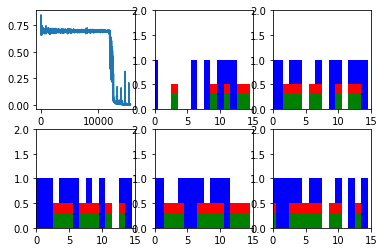

Step 400 Loss 0.00294109
single_output_series: [0 1 1 0 0 1 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 0 1 1 1 1 0]

single_output_series: [1 0 0 1 1 1 1 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 1 0 1 0 0 1]

single_output_series: [0 1 1 0 1 0 1 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 1 1 0 0 0 1 1]

single_output_series: [0 0 1 1 1 0 0 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 1 1 1 1 1]

single_output_series: [1 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 1 0 0 0 1 0]



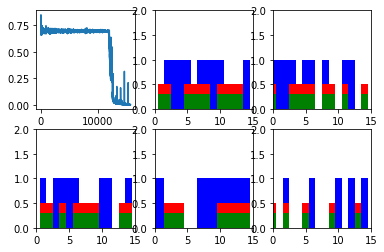

Step 500 Loss 0.00308605
single_output_series: [1 1 1 1 1 0 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 0 1 0 0 1 0]

single_output_series: [1 0 0 0 1 1 1 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 1 1 0 1 0 0]

single_output_series: [1 0 1 0 0 1 0 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 1 1 0 0 0 0]

single_output_series: [0 1 0 0 0 1 0 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 0 1 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 1 0 0 1 0 1]



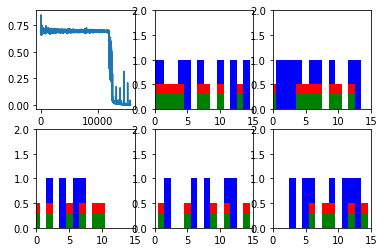

Step 600 Loss 0.00326774
single_output_series: [1 0 0 1 1 1 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 1 1 1 0 1 0]

single_output_series: [0 1 0 1 1 0 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 0 0 1 0 1 0 1]

single_output_series: [0 1 0 0 0 0 0 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 0 1 0 0 1 0]

single_output_series: [1 1 0 1 1 1 0 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 1 0 0 1 1 0]

single_output_series: [1 0 1 1 1 0 0 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 1 1 0 0 1 1]



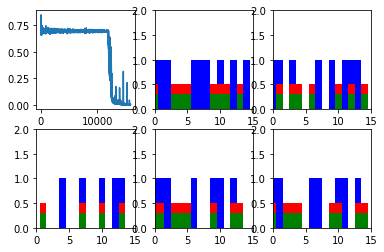

New data, epoch 24
Step 0 Loss 0.185467
single_output_series: [1 0 1 0 1 1 1 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 0 1 0 1 0 1]

single_output_series: [1 0 1 0 0 1 1 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 1 1 0 1 1 0]

single_output_series: [1 1 0 1 1 1 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 1 1 0 1 0 0]

single_output_series: [1 0 1 0 0 1 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0]

single_output_series: [1 1 0 1 0 0 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 1 0 1 0 0 0]



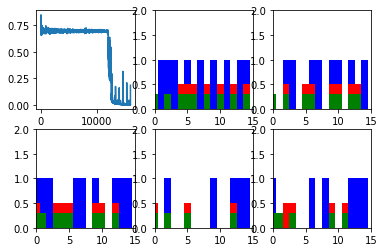

Step 100 Loss 0.00313741
single_output_series: [1 0 1 1 0 1 1 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 1 1 0 1 1 0]

single_output_series: [1 0 0 0 0 1 1 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 1 1 1 0 1 1]

single_output_series: [1 1 1 0 0 1 1 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 0 1 0 1 1 1]

single_output_series: [1 1 0 0 1 0 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 1 1 0 0 1 0]

single_output_series: [1 1 1 0 1 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 1 0 1 0 0 0]



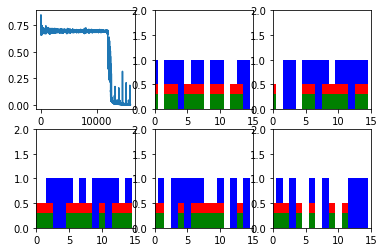

Step 200 Loss 0.0026882
single_output_series: [0 0 1 1 1 0 0 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 0 0 1 1 1 1]

single_output_series: [1 0 0 0 1 0 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 1 0 0 0 1 1]

single_output_series: [0 0 1 0 0 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 0 0 1 0 0 0]

single_output_series: [1 1 1 1 1 0 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 0 0 1 0 1 0]

single_output_series: [0 1 1 1 1 1 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 1 1 0 1 0 0 0]



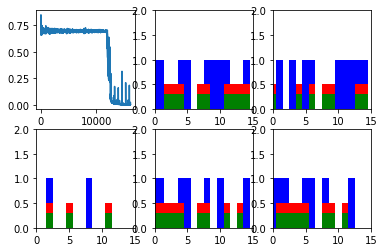

Step 300 Loss 0.00268386
single_output_series: [1 0 1 0 0 0 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 1 0 1 0 0]

single_output_series: [0 1 1 1 0 0 1 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 1 0 0 0 0 1]

single_output_series: [1 1 1 1 1 0 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 1 1 0 0 0 0 0]

single_output_series: [1 0 0 0 1 0 0 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 0 0 0 0 1 0]

single_output_series: [0 1 1 0 0 1 1 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 0 1 0 1 1 1]



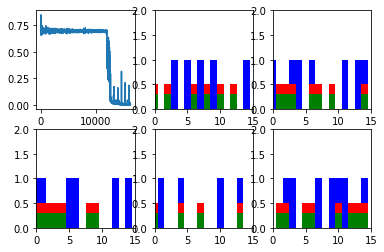

Step 400 Loss 0.00263177
single_output_series: [1 1 1 1 0 0 0 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 1 0 0 0 0 1]

single_output_series: [1 1 1 0 1 0 0 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 0 1 1 0 1 0]

single_output_series: [0 0 0 0 1 0 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 1 0 0 1 0 1]

single_output_series: [1 0 1 0 1 0 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 1 0 1 1 1 1 0]

single_output_series: [0 1 1 0 0 0 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 0 1 1 1 0 0]



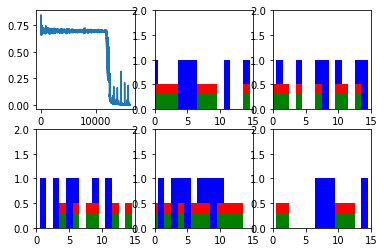

Step 500 Loss 0.00247231
single_output_series: [1 0 1 1 1 1 0 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 0 0 1 0 0 1 0]

single_output_series: [1 0 0 1 1 1 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 1 1 1 0 1 0]

single_output_series: [1 0 0 0 0 1 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 0 0 1 0 0 0]

single_output_series: [0 1 1 1 1 0 1 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 1 1 0 0 1 0]

single_output_series: [1 1 0 0 0 0 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 0 0 1 0 0 0]



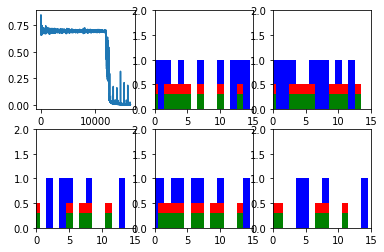

Step 600 Loss 0.00216814
single_output_series: [0 1 0 0 0 0 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 1 1 1 0 1 1]

single_output_series: [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1]

single_output_series: [0 1 0 1 1 0 1 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 0 1 0 0 1 1]

single_output_series: [0 0 0 0 1 1 1 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 0 0 1 1 0 0]

single_output_series: [0 0 1 1 0 0 0 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 1 1 0 0 1 1 1]



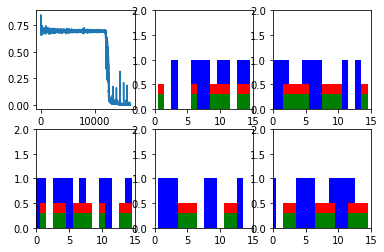

New data, epoch 25
Step 0 Loss 0.163462
single_output_series: [1 0 1 0 0 0 0 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 1 1 0 1 0 1]

single_output_series: [1 0 1 0 1 1 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 1 0 1 1 0 0]

single_output_series: [1 1 0 1 1 0 1 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 1 0 1 1 1]

single_output_series: [1 1 0 1 0 1 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 1 1 1 0 1]

single_output_series: [1 1 0 1 1 1 0 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 0 0 0 0 0 1]



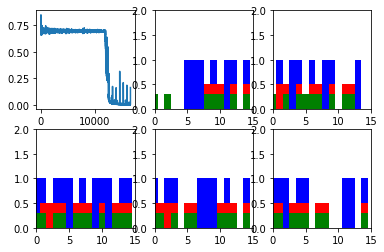

Step 100 Loss 0.00223772
single_output_series: [0 0 0 1 1 1 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 1 1 1 0 1 0]

single_output_series: [0 1 1 1 0 1 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 1 1 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]

single_output_series: [1 0 0 1 1 0 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 0 0 1 1 0 0 0]

single_output_series: [1 0 1 0 0 0 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 0 0 1 0 0 0]



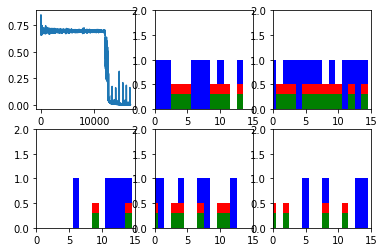

Step 200 Loss 0.00234961
single_output_series: [0 0 1 0 0 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 1 0 1 0 1 1 1]

single_output_series: [1 1 0 0 0 1 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 0 1 1 1 0 0]

single_output_series: [1 0 1 0 0 0 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 1 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 0 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 1 0 1 1 0 0]



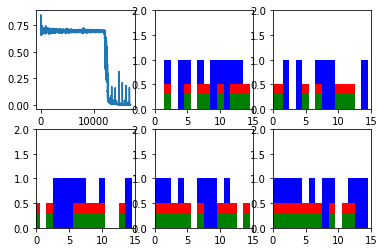

Step 300 Loss 0.00267826
single_output_series: [1 1 0 1 0 1 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 1 1 1 0 1 0]

single_output_series: [1 1 0 1 1 0 1 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 0 1 0 1 0 1]

single_output_series: [1 0 1 1 0 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 1 0 1 0 1 0]

single_output_series: [0 1 0 0 1 1 0 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 0 1 1 0 0 0]

single_output_series: [1 0 0 0 1 0 1 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 1 1 1 1 0 0]



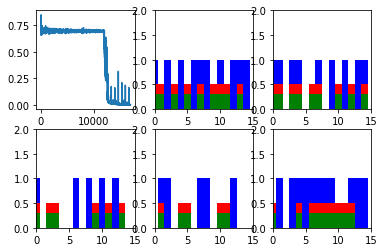

Step 400 Loss 0.00355351
single_output_series: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 1 1 0 1 1 0]

single_output_series: [1 1 0 1 0 1 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 0 0 1 0 1 1 1]

single_output_series: [1 0 1 0 1 0 1 0 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 0 0 1 0 1 1 0]

single_output_series: [1 1 0 1 1 1 0 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 0 1 1 0 0 0]

single_output_series: [0 1 1 1 1 0 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 0 0 0 0 1 0]



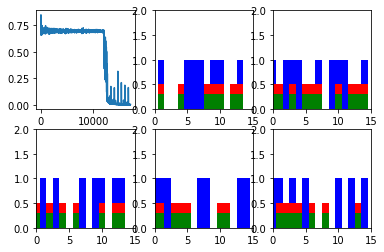

Step 500 Loss 0.00209612
single_output_series: [0 0 1 0 0 0 0 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 1 1 0 0 1 1]

single_output_series: [1 1 1 0 0 1 0 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 1 0 1 1 1 0 1]

single_output_series: [1 0 0 0 1 1 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 1 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 0 1 0 1 0 1]

single_output_series: [0 1 0 1 0 1 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 0 0 1 0 0]



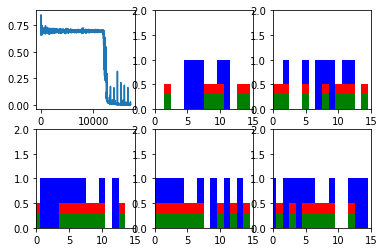

Step 600 Loss 0.00196355
single_output_series: [0 0 1 0 1 1 0 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 1 1 1 1 0 0 1]

single_output_series: [1 0 0 1 0 0 1 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 0 0 1 1 0 0]

single_output_series: [1 0 1 1 1 1 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 1 1 1 0 1 0]

single_output_series: [1 1 0 1 0 0 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 0 0 1 0 0 0]

single_output_series: [1 1 1 0 0 1 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 1 1 0 0 1 0 1]



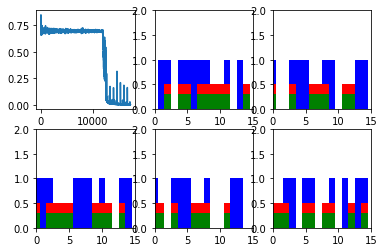

New data, epoch 26
Step 0 Loss 0.23684
single_output_series: [0 1 0 0 1 0 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 0 0 0 0 1 1]

single_output_series: [0 1 0 0 0 0 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 0 0 0 1 1]

single_output_series: [0 1 0 0 0 1 0 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 0 1 1 0 1 0 1]

single_output_series: [0 1 0 0 0 0 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 0 1 1 1 0]

single_output_series: [1 1 0 1 0 0 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 0 0 1 1 0 0 0]



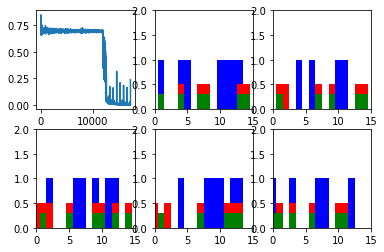

Step 100 Loss 0.00187683
single_output_series: [0 0 1 0 0 0 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 0 0 1 1 1 1]

single_output_series: [0 0 1 1 0 0 1 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 0 1 1 1 1 0]

single_output_series: [1 1 1 0 1 1 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 1 0 0 0 1 1 0]

single_output_series: [1 1 0 0 1 1 0 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 0 1 1 1 1 1]

single_output_series: [0 0 1 1 1 1 1 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 1 0 1 0 1 1]



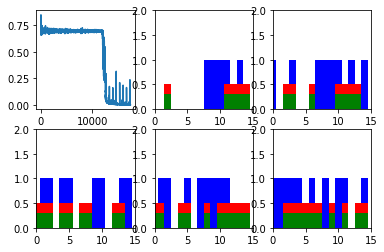

Step 200 Loss 0.0029668
single_output_series: [1 1 0 1 1 1 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 1 0 0 1 0 1]

single_output_series: [0 0 0 1 1 1 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 0 0 1 1 0]

single_output_series: [0 1 0 1 0 0 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 1 0 1 0 0 0]

single_output_series: [0 1 0 1 1 1 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 0 0 0 1 0 1 1]

single_output_series: [0 1 0 1 0 1 0 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 0 0 0 1 1 0 0]



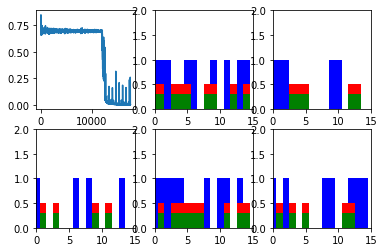

Step 300 Loss 0.00222236
single_output_series: [1 0 0 1 1 1 0 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 1 1 0 1 1 0]

single_output_series: [1 1 1 1 0 1 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 1 0 0 0 0 1 1]

single_output_series: [0 0 1 1 1 1 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 0 0 1 1 0 1 0]

single_output_series: [1 0 1 0 0 1 0 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 1 1 1 1 0 0 0]

single_output_series: [0 0 1 0 1 1 0 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 1 0 1 1 0 1]



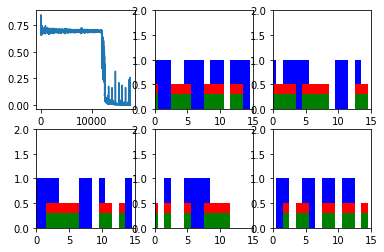

Step 400 Loss 0.00265199
single_output_series: [1 1 1 0 0 0 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 1 0 0 1 0 1]

single_output_series: [1 0 1 0 1 0 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 1 0 0 0 1 0]

single_output_series: [1 0 1 0 0 0 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 1 1 1 0 1 1]

single_output_series: [1 1 0 0 0 0 1 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 0 1 1 0 1 1]

single_output_series: [1 1 0 0 1 0 1 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 0 0 1 1 0 1]



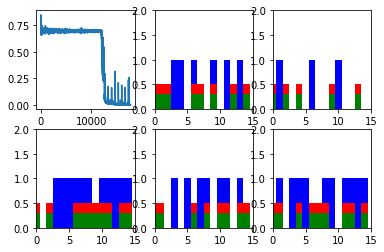

Step 500 Loss 0.00208492
single_output_series: [1 1 1 1 0 1 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 1 1 1 0 1 1]

single_output_series: [0 1 1 1 1 1 0 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 0 0 0 0 0 1]

single_output_series: [1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]

single_output_series: [0 1 1 0 1 1 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 1 0 0 0 1 1]

single_output_series: [0 1 0 0 1 0 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 1 0 1 1 0 1]



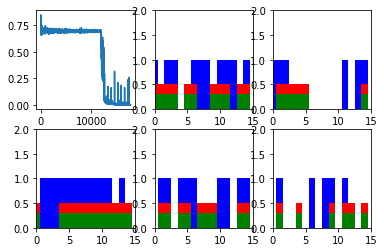

Step 600 Loss 0.00222944
single_output_series: [0 0 1 0 0 1 1 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 1 1 1 1 1 0 1]

single_output_series: [0 0 0 0 0 1 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 0 1 1 0 1 0 0]

single_output_series: [0 1 0 1 0 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 0 1 0 0 0 1]

single_output_series: [1 1 0 0 0 1 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 1 0 1 0 1 1]

single_output_series: [0 1 1 0 0 1 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 0 1 0 1 0 0]



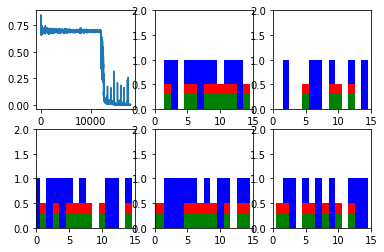

New data, epoch 27
Step 0 Loss 0.184565
single_output_series: [1 1 0 1 1 1 1 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 0 0 1 1 0 0]

single_output_series: [1 0 0 1 0 0 1 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 1 1 1 1 0 1 0]

single_output_series: [1 1 0 1 1 1 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 0 1 1 1 1 0]

single_output_series: [1 0 1 0 1 1 0 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 1 0 0 1 0 1]

single_output_series: [1 0 1 0 1 0 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 1 1 0 1 0 0 0]



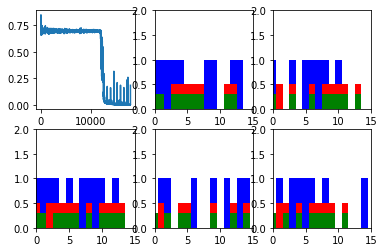

Step 100 Loss 0.00190801
single_output_series: [0 1 1 1 1 0 1 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 0 1 1 0 1 0 0]

single_output_series: [0 0 0 1 0 0 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 0 1 0 0 0 1]

single_output_series: [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 0 1 1 1 1 1 1]

single_output_series: [1 0 0 0 0 1 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 1 1 0 0 1 0]

single_output_series: [0 1 1 0 0 0 1 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 1 1 0 1 0 1]



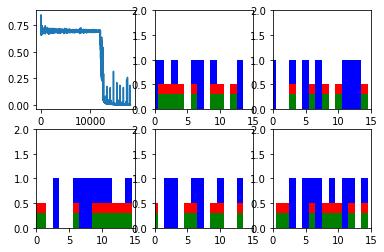

Step 200 Loss 0.00167068
single_output_series: [0 0 1 1 0 1 1 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 1 1 1 1 0 1]

single_output_series: [1 1 1 1 0 1 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 0 0 0 1 1 1]

single_output_series: [1 0 1 0 0 0 0 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 1 0 1 1 0 0 0]

single_output_series: [0 1 0 0 1 1 0 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 1 1 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 1 1 0 1 0 0 0]



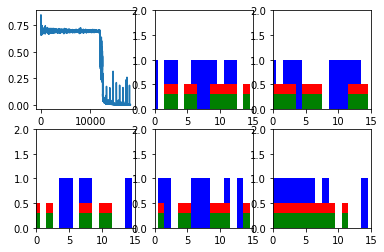

Step 300 Loss 0.00170956
single_output_series: [0 1 1 0 0 1 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 0 0 0 0 1 1]

single_output_series: [0 0 1 1 1 1 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 0 0 0 0 0]

single_output_series: [0 1 1 0 1 1 0 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 0 1 0 0 1 0 1]

single_output_series: [1 1 0 0 0 1 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 1 0 0 1 0 0 0]

single_output_series: [0 1 0 0 1 1 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 1 0 0 0 0 1 0]



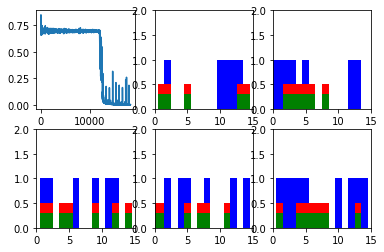

Step 400 Loss 0.00221234
single_output_series: [1 1 0 1 1 1 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 0 0 0 0 1 1]

single_output_series: [0 1 0 1 0 1 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 0 1 1 1 0]

single_output_series: [0 0 0 0 1 0 1 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 0 1 0 1 0 0 1]

single_output_series: [1 0 1 0 1 1 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 1 1 0 0 0 1]

single_output_series: [1 1 0 0 0 1 0 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 1 1 1 0 0 1 1]



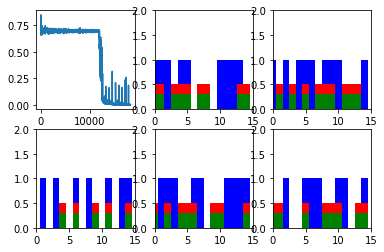

Step 500 Loss 0.00164298
single_output_series: [0 0 0 1 1 0 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 0 0 0 1 0 0]

single_output_series: [0 1 0 1 1 0 0 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 1 0 0 0 0 0]

single_output_series: [0 1 0 0 1 0 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 0 0 1 1 1 1 1]

single_output_series: [0 0 0 1 0 1 0 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 0 0 1 1 0 0]

single_output_series: [0 1 1 1 0 0 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 1 0 0 1 0 0]



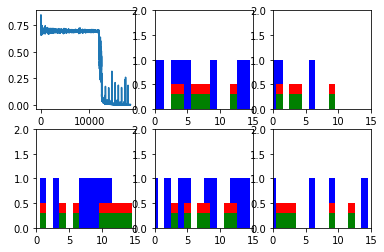

Step 600 Loss 0.00193375
single_output_series: [0 0 1 1 1 1 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 0 0 1 0 1 0 1]

single_output_series: [1 1 1 1 0 1 0 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 0 0 1 1 0 1 0]

single_output_series: [1 0 0 0 0 1 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 0 1 1 1 0]

single_output_series: [0 0 0 0 1 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 0 1 0 0 0 1]

single_output_series: [1 0 1 1 1 0 1 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 1 1 0 1 1 0 1]



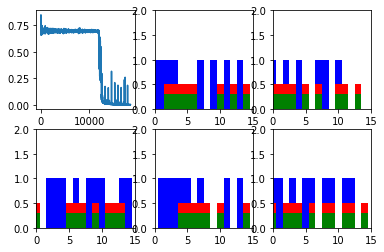

New data, epoch 28
Step 0 Loss 0.182313
single_output_series: [0 1 0 0 0 1 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 0 1 1 1 0]

single_output_series: [0 1 0 0 1 1 0 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 1 1 0 1 0 1]

single_output_series: [1 1 0 1 1 1 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 0 0 1 0 0 0]

single_output_series: [0 1 0 0 0 0 1 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 1 1 0 1 0 1]

single_output_series: [1 1 0 1 0 0 1 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 0 1 1 1 0 0]



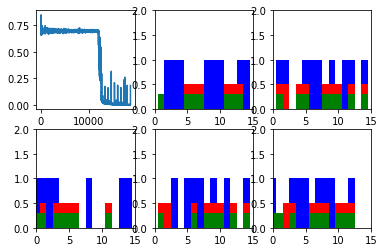

Step 100 Loss 0.00187664
single_output_series: [1 1 0 1 1 1 1 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 1 1 1 1 0 1]

single_output_series: [1 1 0 0 1 0 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 0 0 1 1 1 1]

single_output_series: [1 0 1 1 1 0 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 1 0 1 1 0 0]

single_output_series: [1 0 1 0 0 0 0 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 0 1 0 1 0]

single_output_series: [0 1 0 1 1 0 0 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 1 1 1 1 0 1 1]



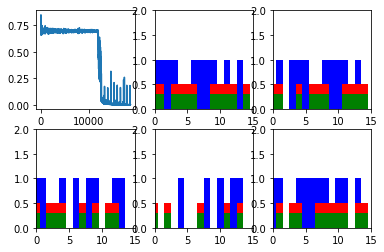

Step 200 Loss 0.00158119
single_output_series: [0 0 0 0 0 1 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 0 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 1 1 0 0 1 0 0]

single_output_series: [0 1 0 0 0 0 0 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 1 1 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 0 0 0 1 1 1]

single_output_series: [1 0 0 0 0 0 0 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 0 1 1 0 0 0]



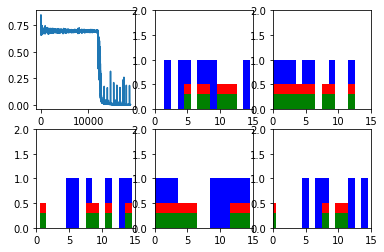

Step 300 Loss 0.00182815
single_output_series: [0 1 0 1 0 0 1 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 0 0 0 1 0 1 1]

single_output_series: [0 1 0 1 1 0 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 1 0 0 1 1 1]

single_output_series: [0 1 0 0 1 0 0 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 1 1 1 1 1 1]

single_output_series: [0 0 0 0 1 1 1 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 1 1 1 1 0 0]

single_output_series: [0 1 0 1 0 1 1 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 0 1 0 0 1 0]



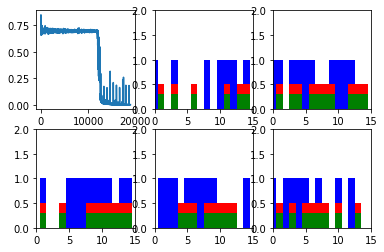

Step 400 Loss 0.00157909
single_output_series: [1 0 1 0 1 1 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 1 1 1 1 1 1 1]

single_output_series: [0 1 0 1 0 1 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 0 0 1 1 1 0]

single_output_series: [0 0 0 1 0 0 1 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 0 0 0 0 0 1]

single_output_series: [1 0 1 0 0 0 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 0 0 0 0 1 1]

single_output_series: [0 0 1 1 0 1 1 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 0 0 1 0 1 0]



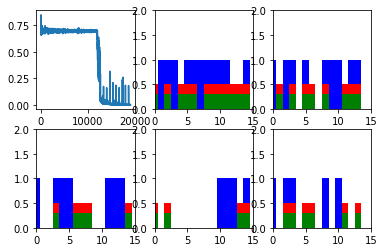

Step 500 Loss 0.00145179
single_output_series: [1 0 1 1 1 0 0 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 1 1 0 1 1 0 0]

single_output_series: [0 0 0 1 0 1 0 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 0 0 0 1 0 0 1]

single_output_series: [1 1 1 1 1 0 1 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 0 0 1 1 0 0]

single_output_series: [1 0 0 1 0 1 1 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 0 0 1 0 0 1 0]

single_output_series: [0 0 1 1 1 0 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 0 0 1 1 0]



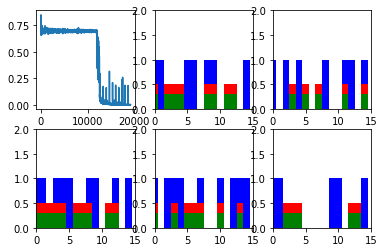

Step 600 Loss 0.00133988
single_output_series: [0 1 1 0 1 0 0 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 0 1 1 1 1 0]

single_output_series: [0 0 1 0 1 0 0 0 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 1 1 0 0 1 1 1]

single_output_series: [1 0 1 1 0 1 1 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 0 0 0 1 1]

single_output_series: [1 1 1 0 1 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 1 1 1 1 1 1 1]

single_output_series: [0 0 1 1 1 0 0 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 0 1 0 0 0]



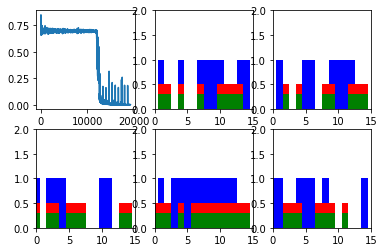

New data, epoch 29
Step 0 Loss 0.249283
single_output_series: [1 0 1 0 0 0 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 1 0 0 1 1 0]

single_output_series: [1 0 1 0 0 1 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 0 1 0 1 0 1 1]

single_output_series: [1 0 1 1 1 0 0 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 1 0 0 0 1 0 0]

single_output_series: [1 0 1 0 0 1 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 0 1 0 0 0 0]

single_output_series: [1 0 1 0 0 0 0 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 0 0 1 1 0 1]



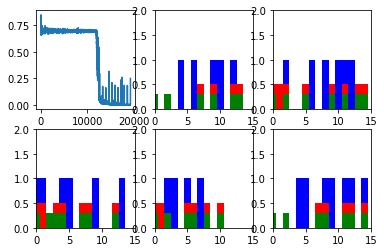

Step 100 Loss 0.001693
single_output_series: [0 1 0 0 0 0 1 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 1 0 1 1 1 1 1]

single_output_series: [1 1 1 1 0 0 1 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 1 1 0 1 0 0 1]

single_output_series: [0 1 1 0 1 1 1 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 0 1 0 0 0 1 1]

single_output_series: [1 1 1 1 0 0 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 1 0 0 1 1 1 0]

single_output_series: [0 1 0 1 1 0 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 1 0 0 1 1 0 1]



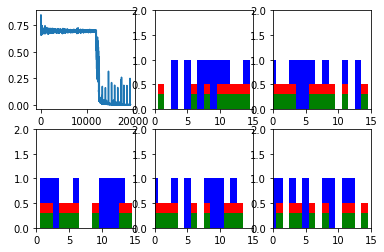

Step 200 Loss 0.00140887
single_output_series: [1 1 1 0 0 1 0 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 1 1 0 1 0 1 0]

single_output_series: [0 0 0 0 1 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 1 1 0 1 1 1]

single_output_series: [0 0 1 1 0 1 1 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 0 1 1 1 1 1]

single_output_series: [0 1 0 1 0 1 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 1 1 1 1 1 0]

single_output_series: [0 0 1 1 1 0 0 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 1 0 0 0 1]



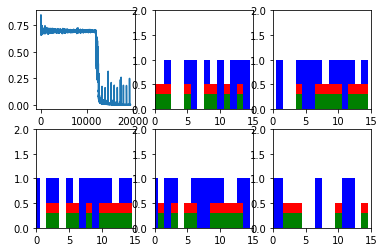

Step 300 Loss 0.00175975
single_output_series: [0 0 1 0 0 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 0 1 0 1 1 1]

single_output_series: [1 1 0 0 1 0 1 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 0 1 1 0 1 0 1]

single_output_series: [1 0 1 0 1 1 1 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 1 0 0 1 0 0]

single_output_series: [0 1 0 0 1 1 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 1 1 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 1 0 1 0 1 0]



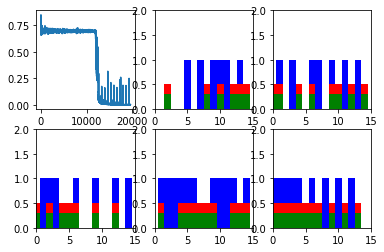

Step 400 Loss 0.00142404
single_output_series: [0 1 1 0 1 0 1 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 1 0 0 0 1 1]

single_output_series: [1 1 0 0 0 1 1 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 1 1 1 1 0 1]

single_output_series: [0 1 1 1 0 0 0 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 0 1 1 0 1 1]

single_output_series: [0 0 0 0 1 0 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 0 1 0 0 1 0]

single_output_series: [0 1 0 0 1 1 1 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 1 0 1 0 1 1]



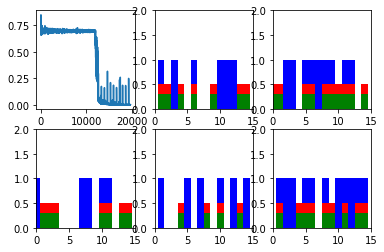

Step 500 Loss 0.00136942
single_output_series: [1 1 1 0 0 1 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 1 1 0 1 1 0]

single_output_series: [0 0 0 1 1 0 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 0 1 0 1 0 0]

single_output_series: [1 0 0 1 0 0 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 0 1 0 0 0 0 1]

single_output_series: [1 0 1 1 0 1 1 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 0 0 0 0 1 1 1]

single_output_series: [1 0 1 0 0 1 1 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 0 0 1 1 0 0 0]



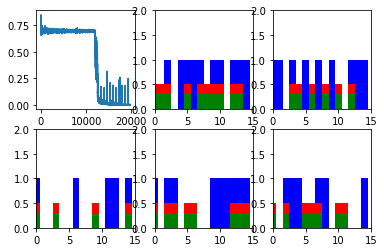

Step 600 Loss 0.00126364
single_output_series: [0 0 1 0 1 1 1 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 1 1 1 1 0 1]

single_output_series: [0 1 1 1 1 1 1 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 1 0 0 0 0 1]

single_output_series: [0 1 0 0 0 0 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 0 0 0 1 1 0]

single_output_series: [0 1 1 1 1 1 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 0 0 1 1 1 1]

single_output_series: [0 1 1 0 1 1 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 0 1 1 0 1 1]



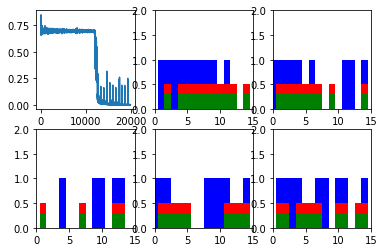

New data, epoch 30
Step 0 Loss 0.408327
single_output_series: [0 1 0 1 0 0 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 0 1 1 0 0 0]

single_output_series: [0 1 0 0 1 1 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 1 1 0 1 0 1 1]

single_output_series: [0 1 0 0 1 0 0 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 1 1 0 0 0 1]

single_output_series: [0 1 0 0 1 1 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 1 1 0 1 1 1]

single_output_series: [0 1 0 0 0 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 0 1 0 0 0 1]



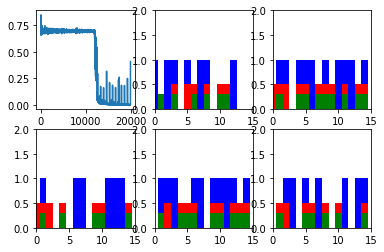

Step 100 Loss 0.00153714
single_output_series: [0 0 1 0 1 1 0 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 0 1 1 1 1 0 1]

single_output_series: [0 0 1 1 0 1 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 1 0 0 0 1 0 0]

single_output_series: [1 0 0 0 1 0 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 1 1 1 1 1 0 1]

single_output_series: [1 1 0 1 1 0 1 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 0 0 0 0 1 0]

single_output_series: [0 0 0 0 1 0 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 0 0 1 1 1 0]



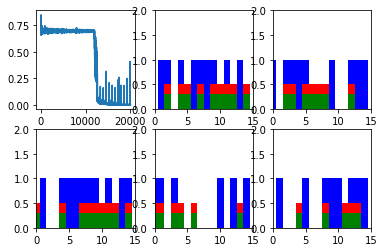

Step 200 Loss 0.00140745
single_output_series: [0 0 0 0 0 1 1 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 0 0 0 1 1 1]

single_output_series: [0 1 0 1 0 1 1 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 1 1 1 0 1 1]

single_output_series: [1 1 0 1 1 1 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 1 0 1 1 1 0]

single_output_series: [1 0 1 1 1 1 0 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 0 1 1 0 1 0]

single_output_series: [1 1 0 1 1 0 0 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 1 0 0 1 1 0 1]



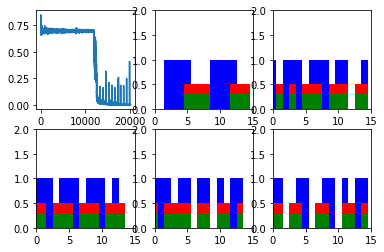

Step 300 Loss 0.00148883
single_output_series: [1 1 1 0 1 0 0 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 1 0 1 1 1 1]

single_output_series: [1 1 0 1 1 0 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 0 1 1 0 0 0]

single_output_series: [1 0 1 0 1 0 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 1 0 0 0 0 0]

single_output_series: [0 1 1 0 0 0 0 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 1 1 0 1 0 0 1]

single_output_series: [0 1 1 0 1 0 0 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 0 0 1 1 0 1]



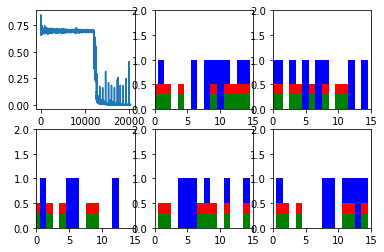

Step 400 Loss 0.00129579
single_output_series: [1 0 0 0 1 0 1 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 0 1 1 0 0 1]

single_output_series: [1 1 0 0 0 1 1 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 0 1 0 0 1 0]

single_output_series: [1 0 0 0 1 1 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 1 1 0 0 1 0 1]

single_output_series: [1 0 1 0 0 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 1 0 0 0 0]

single_output_series: [0 1 1 0 0 0 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 0 1 1 1 1 0]



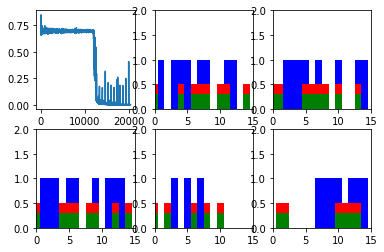

Step 500 Loss 0.00142358
single_output_series: [0 1 0 1 1 1 0 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 0 1 1 0 0 0 1]

single_output_series: [1 1 0 1 1 0 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 1 1 1 1 0 1]

single_output_series: [0 1 1 1 0 0 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 0 1 0 1 0 0]

single_output_series: [0 0 0 1 1 0 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 0 1 0 0 1 0 1]

single_output_series: [1 1 0 1 0 1 1 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 0 1 1 0 1 1 0]



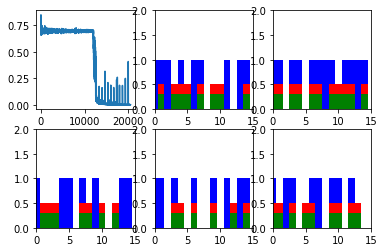

Step 600 Loss 0.00121021
single_output_series: [1 1 1 0 1 1 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 1 1 1 1 1 1 0]

single_output_series: [1 1 0 0 0 0 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 0 0 1 1 0 1]

single_output_series: [0 0 1 1 0 0 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 1 0 1 1 0 1]

single_output_series: [1 0 1 1 0 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 1 0 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 0 0 1 1 1 1]



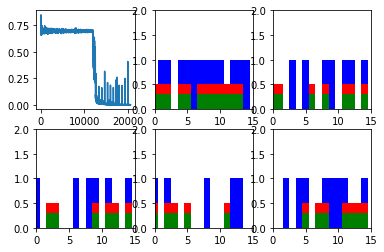

New data, epoch 31
Step 0 Loss 0.225751
single_output_series: [0 1 0 1 1 0 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 0 0 0 1 1 1 0]

single_output_series: [0 1 0 1 0 0 0 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 0 0 1 0 1 0]

single_output_series: [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0]

single_output_series: [0 1 0 1 0 1 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 0 1 0 1 0 0]

single_output_series: [0 1 0 1 0 0 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 1 0 1 1 1 0]



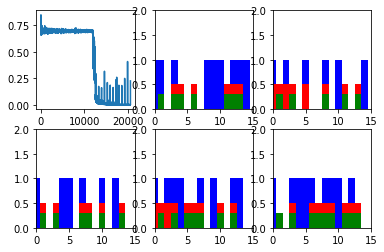

Step 100 Loss 0.00154521
single_output_series: [0 1 0 0 0 0 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 1 1 0 1 1 1 0]

single_output_series: [1 1 0 1 0 1 1 0 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 0 0 1 0 1 1 0]

single_output_series: [1 1 1 0 0 1 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 1 0 0 0 1 1]

single_output_series: [0 1 0 0 0 1 0 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 1 0 0 1 1 1]

single_output_series: [0 1 0 1 1 1 0 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 0 1 0 1 0 1 0]



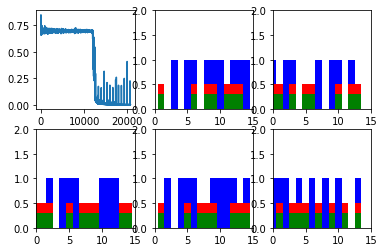

Step 200 Loss 0.00138178
single_output_series: [1 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 0 0 0 0 1 1 1]

single_output_series: [1 0 1 1 1 1 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 1 0 1 1 0]

single_output_series: [1 1 0 0 1 1 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 1 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 0 1 0 1 1 0]

single_output_series: [0 0 1 0 1 1 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 0 0 1 1 0 1]



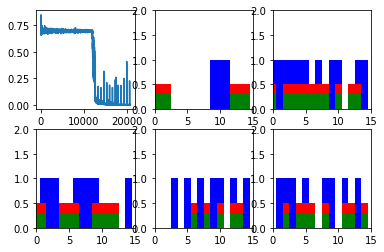

Step 300 Loss 0.00150037
single_output_series: [1 0 1 1 0 0 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 1 0 0 0 1 0]

single_output_series: [0 0 1 0 1 1 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 0 1 0 0 1 0]

single_output_series: [0 1 1 0 1 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 1 0 1 0 0 0]

single_output_series: [1 1 1 1 1 1 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 1 1 1 0 0 1 0]

single_output_series: [0 1 0 1 0 0 1 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 0 0 1 0 0 1 1]



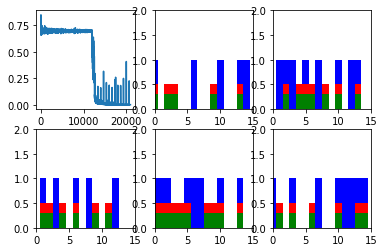

Step 400 Loss 0.00131641
single_output_series: [1 0 1 1 0 1 1 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 0 1 0 0 0]

single_output_series: [0 0 0 1 1 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 0 1 0 1 1 1]

single_output_series: [0 1 1 1 1 0 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 1 0 1 0 1 1 0]

single_output_series: [0 1 1 1 0 1 1 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 1 0 1 0 1 1 0]

single_output_series: [1 1 0 0 1 0 1 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 0 0 1 1 0 1]



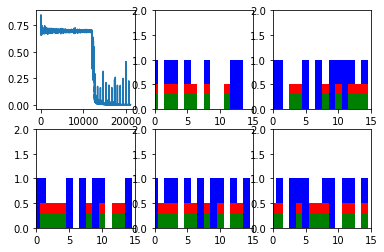

Step 500 Loss 0.00106178
single_output_series: [1 1 1 1 1 1 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 1 1 1 0 0 1 0]

single_output_series: [1 0 1 0 0 0 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 0 0 1 1 1 0]

single_output_series: [0 1 1 1 1 1 0 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 1 0 1 1 1 1]

single_output_series: [0 0 1 1 0 0 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 0 1 1 0 0 0 0]

single_output_series: [0 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 0 0 0 0 0 0]



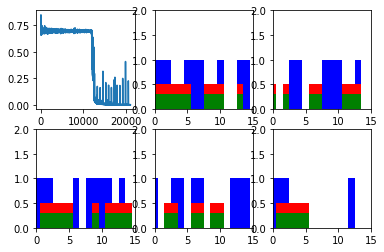

Step 600 Loss 0.00105016
single_output_series: [1 0 1 1 1 1 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 0 0 1 1 1 1]

single_output_series: [1 1 0 1 1 0 1 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 1 0 0 1 1 0]

single_output_series: [0 0 1 0 0 1 1 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 0 0 0 1 0 0]

single_output_series: [0 1 1 1 0 1 0 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 1 1 0 0 0 1 1]

single_output_series: [1 1 0 0 0 0 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 0 1 0 1 0 0]



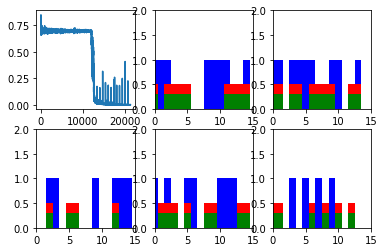

New data, epoch 32
Step 0 Loss 0.359843
single_output_series: [1 0 1 1 1 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 0 1 1 1 1]

single_output_series: [1 0 1 0 0 0 1 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 0 1 1 1 0 1]

single_output_series: [1 0 1 1 1 1 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 1 0 0 0 0 0]

single_output_series: [1 0 1 1 1 1 0 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 0 0 0 0 0 1]

single_output_series: [1 0 1 1 1 1 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 0 1 0 1 1 1]



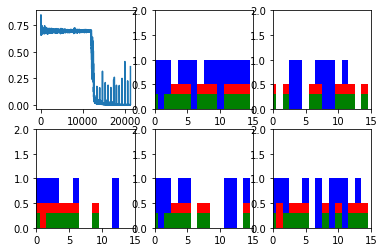

Step 100 Loss 0.00117149
single_output_series: [0 0 1 0 0 1 1 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 1 1 1 1 1 1]

single_output_series: [0 1 0 0 1 0 0 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 1 1 1 1 1 0]

single_output_series: [1 1 1 0 1 1 1 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 1 1 1 1 0 1 0]

single_output_series: [1 0 0 1 0 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 1 0 1 0 1 1 1]

single_output_series: [1 0 1 0 1 0 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 0 0 0 1 1 1]



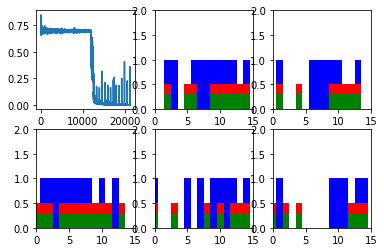

Step 200 Loss 0.00102157
single_output_series: [0 1 1 1 0 0 0 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 0 0 0 0 1]

single_output_series: [1 1 1 0 0 1 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 0 0 1 0 1 0 1]

single_output_series: [1 1 0 1 0 0 1 0 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 0 1 0 0 1 1 1]

single_output_series: [1 0 0 0 1 1 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 1 1 0 0 0 0]

single_output_series: [1 0 1 1 1 0 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 1 1 0 1 1 0]



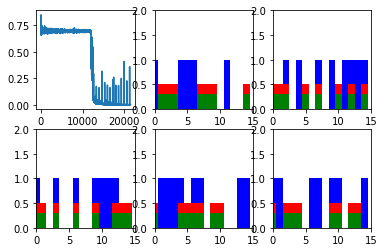

Step 300 Loss 0.00110881
single_output_series: [0 1 1 0 0 1 0 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 0 0 1 0 1 1]

single_output_series: [0 1 0 1 1 0 0 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 1 0 0 0 1 1]

single_output_series: [0 0 0 1 0 1 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 0 1 0 0 0 1]

single_output_series: [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]

single_output_series: [1 1 0 0 1 1 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 1 1 1 0 0 1 0]



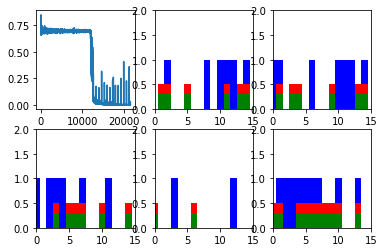

Step 400 Loss 0.00129114
single_output_series: [0 0 1 1 0 0 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 1 0 1 0 1 1]

single_output_series: [1 0 0 1 0 1 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 1 1 1 1 0]

single_output_series: [1 1 1 0 1 1 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 0 1 0 0 0 1 1]

single_output_series: [1 0 1 1 0 1 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 1 0 0 1 0 0]

single_output_series: [1 0 1 1 1 0 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 1 0 0 1 0 0]



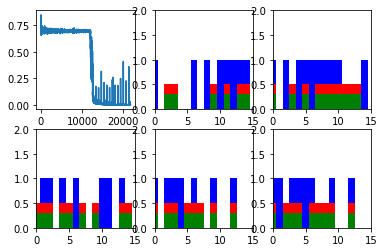

Step 500 Loss 0.00113625
single_output_series: [0 0 1 0 1 0 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 1 1 0 1 1 1]

single_output_series: [0 0 0 1 1 0 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 1 1 0 0 0]

single_output_series: [0 1 0 0 1 1 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 1 0 0 1 0 1 1]

single_output_series: [1 0 1 1 0 1 1 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 1 0 1 1 1 1]

single_output_series: [0 1 0 0 0 1 0 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 1 1 0 1 0 1 1]



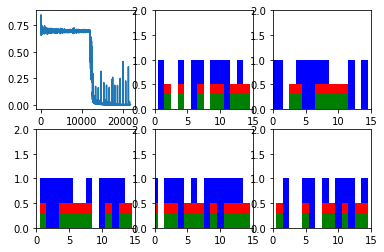

Step 600 Loss 0.00100908
single_output_series: [1 0 0 1 1 1 0 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 0 0 1 1 0 0]

single_output_series: [0 1 1 1 0 1 1 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 0 0 1 0 0 0]

single_output_series: [1 1 1 0 0 1 1 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 1 0 0 0 1 1 1]

single_output_series: [0 1 1 1 1 1 0 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 1 1 0 0 1 1 1]

single_output_series: [0 0 0 1 0 1 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 1 0 1 1 0 1]



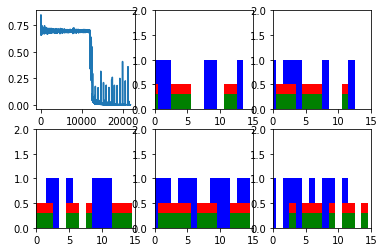

New data, epoch 33
Step 0 Loss 0.171004
single_output_series: [1 1 0 1 1 1 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 1 1 1 1 0]

single_output_series: [1 1 0 1 0 0 1 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]

single_output_series: [1 1 0 1 1 0 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 1 1 1 1 0 1]

single_output_series: [1 1 0 1 0 1 1 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 0 1 0 0 0 0]

single_output_series: [1 1 0 1 0 1 1 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 1 1 0 1 0 1]



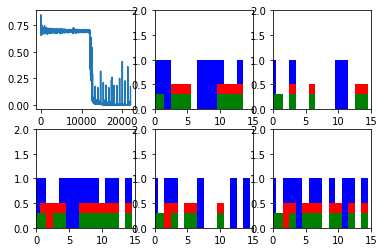

Step 100 Loss 0.00181412
single_output_series: [1 1 1 0 1 1 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 0 0 0 0 0 0]

single_output_series: [0 0 1 1 0 1 1 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 0 1 0 0 0 0]

single_output_series: [0 1 0 0 1 0 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 0 1 1 1 1 0]

single_output_series: [0 1 0 1 0 1 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 0 1 0 1 0 0]

single_output_series: [0 1 1 1 0 1 0 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 1 0 1 0 1 1]



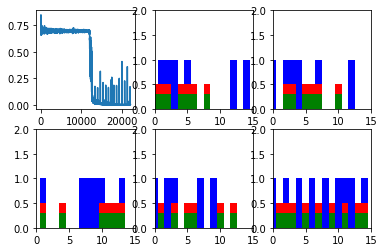

Step 200 Loss 0.00168792
single_output_series: [1 0 1 0 1 0 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 1 0 1 0 0 1 1]

single_output_series: [1 0 1 1 0 0 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 1 1 0 0 1 0]

single_output_series: [0 1 0 0 0 1 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 1 0 1 1 0 1 0]

single_output_series: [1 1 1 1 0 0 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 0 0 1 1 1 0 1]

single_output_series: [0 1 0 0 1 0 1 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 1 0 1 1 0 1 0]



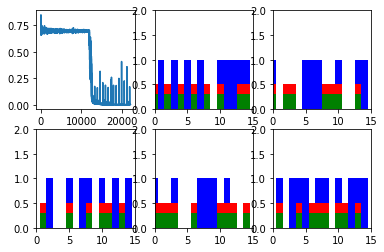

Step 300 Loss 0.00112703
single_output_series: [0 1 0 0 1 0 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 0 0 0 0 1 0 1]

single_output_series: [1 1 1 1 1 0 0 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 0 1 1 0 0 0]

single_output_series: [1 1 0 0 0 1 1 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 0 0 1 1 0 1 0]

single_output_series: [0 0 1 0 1 0 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 1 0 0 0 1 0 1]

single_output_series: [1 0 1 0 0 0 1 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 1 0 0 0 0 1]



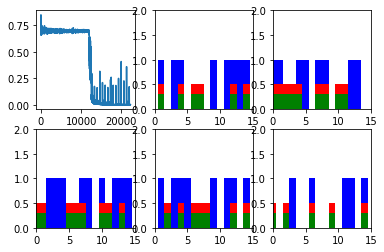

Step 400 Loss 0.00137903
single_output_series: [0 1 0 1 0 1 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 0 1 0 1 0 0]

single_output_series: [0 1 0 1 0 1 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 0 0 0 0 0 0]

single_output_series: [0 0 1 1 1 0 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 1 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 0 0 1 1 0 1 1]

single_output_series: [0 0 1 0 0 1 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 1 1 0 1 0 1 0]



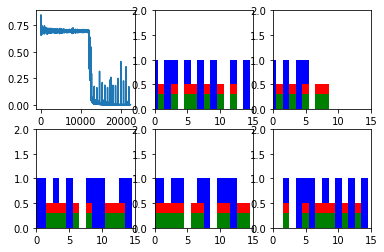

Step 500 Loss 0.000982504
single_output_series: [0 0 1 1 1 1 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 1 1 0 0 1 1]

single_output_series: [0 0 0 1 0 0 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 0 0 1 0 0 0]

single_output_series: [0 1 0 1 1 1 0 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 0 1 1 1 1 1]

single_output_series: [1 0 0 0 0 0 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 1 1 0 1 1 0]

single_output_series: [1 0 1 0 1 1 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 1 0 0 0 1 0]



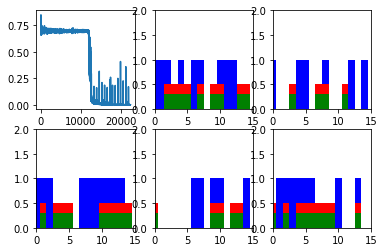

Step 600 Loss 0.00115225
single_output_series: [0 0 0 1 1 0 0 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 0 1 0 1 1]

single_output_series: [0 1 0 0 0 1 1 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 1 0 0 1 0 0 0]

single_output_series: [0 1 1 1 0 0 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 1 1 0 0 0 1]

single_output_series: [1 1 1 0 1 0 1 0 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 1 1 0 1 1 1 1]

single_output_series: [1 0 1 1 0 0 0 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 1 1 0 0 1 0]



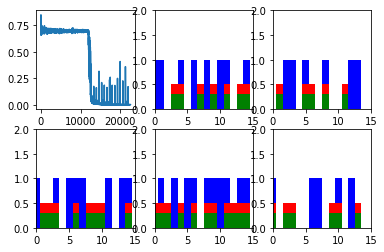

New data, epoch 34
Step 0 Loss 0.453009
single_output_series: [1 0 1 1 0 1 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 1 1 1 1 0 1]

single_output_series: [1 0 1 0 1 0 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 1 1 0 1 1 1 0]

single_output_series: [1 0 1 1 1 1 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 1 0 0 0 0 0 0]

single_output_series: [1 0 1 1 1 0 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 0 0 1 1 1 0 0]

single_output_series: [1 0 1 1 1 1 1 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 0 0 0 1 1 0]



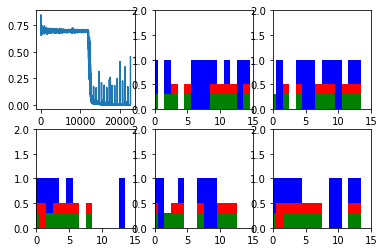

Step 100 Loss 0.00102137
single_output_series: [0 0 0 0 0 1 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 0 0 0 0 1 1 1]

single_output_series: [0 1 0 1 0 0 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 0 1 1 1 0 1]

single_output_series: [1 0 0 0 0 1 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 1 1 0 0 0 1]

single_output_series: [1 1 1 1 1 0 1 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 1 0 0 1 0 1 0]

single_output_series: [0 1 1 1 0 0 0 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 1 1 0 1 1 0]



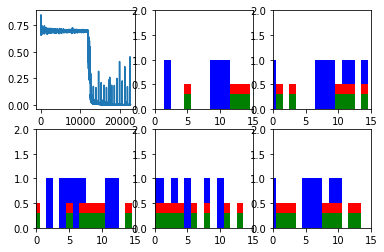

Step 200 Loss 0.000986247
single_output_series: [0 1 1 1 1 1 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 1 1 1 0 1 1 1]

single_output_series: [1 0 0 0 0 1 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 0 0 1 0 1 0 0]

single_output_series: [1 0 0 1 0 1 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 0 1 1 0 0 0 0]

single_output_series: [1 1 1 1 1 1 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 1 0 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 1 0 0 0 0 1]



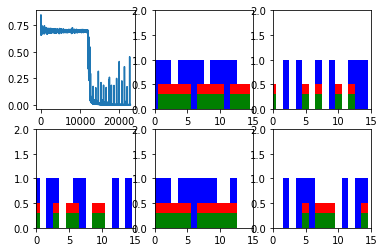

Step 300 Loss 0.00102065
single_output_series: [0 1 0 1 1 0 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 0 1 1 0 1 0]

single_output_series: [1 0 0 1 0 0 1 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 1 1 0 0 0 1 0]

single_output_series: [1 1 1 0 0 0 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 1 0 0 0 0 1]

single_output_series: [0 1 1 0 1 1 0 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 1 0 0 0 1]

single_output_series: [0 0 1 0 1 1 1 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 1 1 0 0 1 1]



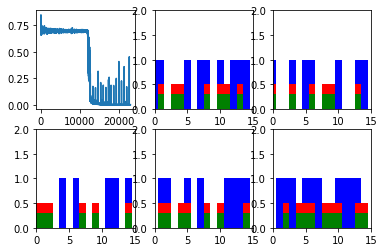

Step 400 Loss 0.000869759
single_output_series: [1 1 0 1 0 0 1 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 0 0 0 0 1 1 0]

single_output_series: [1 1 0 0 0 1 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 0 1 0 1 0 0]

single_output_series: [0 1 1 1 1 1 1 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 0 1 1 0 0 0]

single_output_series: [1 1 1 0 0 0 0 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 0 0 1 0 0 0 1]

single_output_series: [0 0 0 0 1 1 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 0 0 1 1 1]



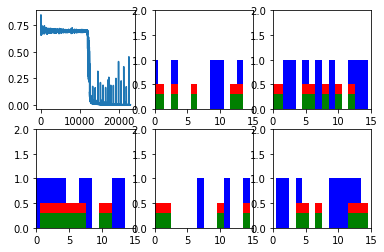

Step 500 Loss 0.000953995
single_output_series: [0 0 0 0 1 0 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 1 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 0 1 0 1 0 1 0]

single_output_series: [1 0 1 1 1 1 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 1 0 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 0 1 1 1 1 0 0]

single_output_series: [1 0 0 0 1 1 0 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 1 1 0 0 0 1]



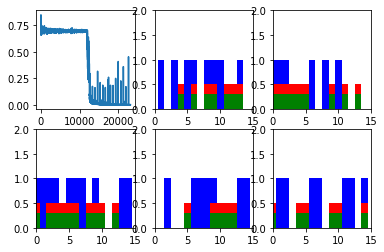

Step 600 Loss 0.000836293
single_output_series: [1 0 1 0 1 1 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 0 0 1 0 1 1]

single_output_series: [1 0 1 1 0 0 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 0 1 0 0 1 0]

single_output_series: [0 0 1 1 0 1 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 0 1 1 0 1 0]

single_output_series: [1 1 1 0 0 0 1 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 1 1 1 0 0 0]

single_output_series: [1 1 1 0 0 1 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 0 1 1 0 0 0]



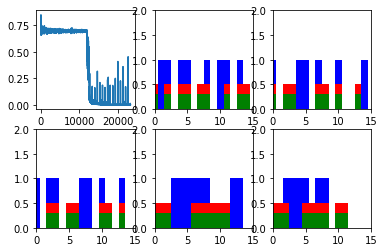

New data, epoch 35
Step 0 Loss 0.220909
single_output_series: [0 0 1 0 0 1 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 0 0 0 0 0 1 1]

single_output_series: [1 0 1 1 1 0 0 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 0 1 0 1 1 1]

single_output_series: [1 0 1 1 0 1 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 1 0 0 0 1 0 0]

single_output_series: [1 0 1 1 0 0 0 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 1 1 1 1 0]

single_output_series: [0 0 1 0 1 1 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 1 0 1 0 1 0 1]



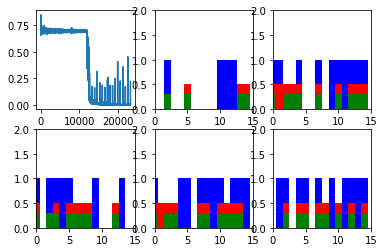

Step 100 Loss 0.000895635
single_output_series: [1 1 1 0 0 1 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 1 0 0 0 1 0 0]

single_output_series: [0 1 0 1 0 0 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 0 0 0 1 1 1]

single_output_series: [1 0 1 1 0 1 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 1 0 0 1 1 1 0]

single_output_series: [0 0 1 1 1 1 0 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 1 1 0 1 1 0]

single_output_series: [1 0 0 0 0 0 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 0 1 0 1 1 0]



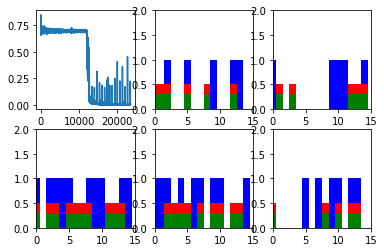

Step 200 Loss 0.00108132
single_output_series: [1 1 1 0 0 1 0 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 0 0 1 0 1 1 0]

single_output_series: [1 0 0 1 0 1 0 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 1 1 0 0 1]

single_output_series: [1 0 1 0 1 1 0 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 0 1 0 0 0 0]

single_output_series: [1 0 0 0 1 0 0 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 0 0 0 1 0 1 0]

single_output_series: [1 0 1 0 1 0 0 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 0 0 1 1 0 0]



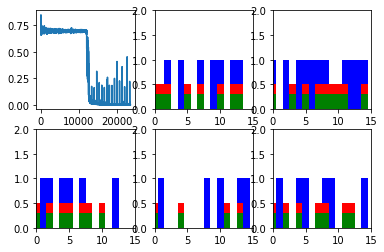

Step 300 Loss 0.00104289
single_output_series: [1 0 1 0 0 0 1 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 1 1 0 0 1 0]

single_output_series: [1 0 1 0 1 0 1 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 0 1 1 0 1 1 0]

single_output_series: [0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]

single_output_series: [0 1 1 0 0 1 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 1 1 0 1 1 1 0]

single_output_series: [0 1 1 0 0 0 0 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 0 0 1 0 1 1]



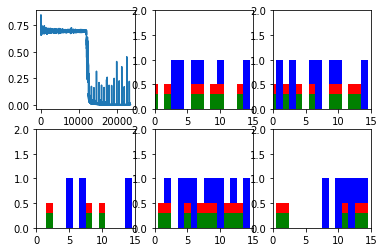

Step 400 Loss 0.00101654
single_output_series: [1 1 0 1 0 0 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 1 1 1 1 1 1]

single_output_series: [0 0 0 0 1 1 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 0 0 0 0 1 1]

single_output_series: [0 0 0 0 1 1 1 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 0 1 1 0 1 1]

single_output_series: [1 0 1 1 1 0 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 1 0 1 0 1]

single_output_series: [0 1 0 1 1 1 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 0 1 0 0 1 0]



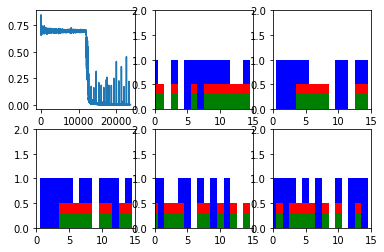

Step 500 Loss 0.000916052
single_output_series: [0 1 1 0 1 1 0 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 0 0 1 0 1]

single_output_series: [1 0 0 0 1 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 1 0 1 1 1 1]

single_output_series: [1 0 1 0 0 1 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 0 1 1 1 1 0]

single_output_series: [0 0 0 0 0 0 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 1 0 1 0 0 1]

single_output_series: [1 1 1 1 0 1 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 0 1 0 0 1 1]



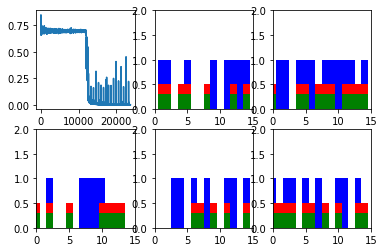

Step 600 Loss 0.0010226
single_output_series: [1 0 1 1 1 1 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 1 0 0 0 1 1]

single_output_series: [1 1 0 1 0 0 1 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 1 1 0 0 1 0]

single_output_series: [0 0 1 0 0 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 0 1 0 0 0 0]

single_output_series: [0 0 1 1 0 1 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 1 0 1 1 1 1 0]

single_output_series: [1 0 1 0 1 1 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 0 1 0 0 1 0 0]



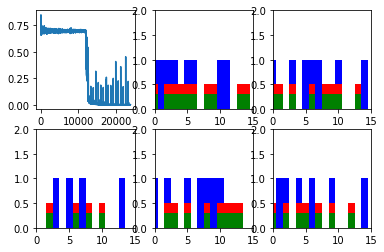

New data, epoch 36
Step 0 Loss 0.213768
single_output_series: [0 1 0 1 0 0 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 1 0 1 0 0 0]

single_output_series: [0 1 1 0 1 1 1 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 0 1 1 0 0 1]

single_output_series: [0 1 1 0 1 1 1 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 1 0 0 1 1 0]

single_output_series: [0 1 1 0 1 0 0 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 1 1 0 1 1 0]

single_output_series: [0 1 0 1 1 1 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 0 1 1 1 0 1]



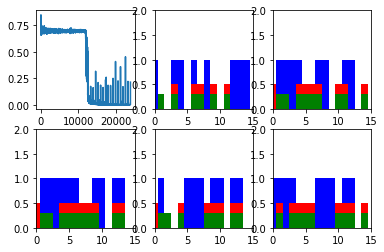

Step 100 Loss 0.00082042
single_output_series: [1 1 0 1 0 1 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 0 1 1 0 0 1 1]

single_output_series: [1 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 0 0 0 0 1 0 0]

single_output_series: [1 0 0 0 1 1 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 0 0 1 1 1 1 1]

single_output_series: [1 1 1 0 1 1 1 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 1 1 1 1 1 0 0]

single_output_series: [1 1 1 1 1 0 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 0 0 0 1 0 0 1]



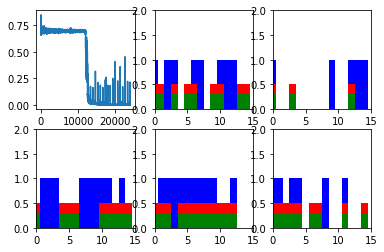

Step 200 Loss 0.000972553
single_output_series: [0 0 1 0 0 1 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 1 0 0 0 0 1 0]

single_output_series: [0 0 0 1 1 1 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 1 0 1 1 0]

single_output_series: [0 1 0 1 0 1 1 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 0 1 0 0 1]

single_output_series: [1 0 1 0 1 0 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 0 1 1 0 0 0 0]

single_output_series: [0 1 1 1 0 0 0 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 0 1 1 0 1 0]



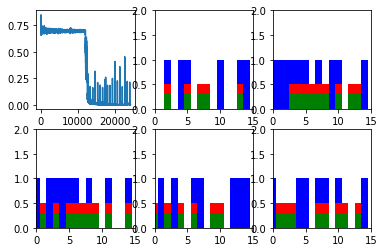

Step 300 Loss 0.00101782
single_output_series: [1 1 0 1 0 1 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 1 0 0 1 0 1 1]

single_output_series: [0 0 1 1 0 1 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 0 0 0 1 1 0]

single_output_series: [0 0 1 0 0 0 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 1 0 0 1 0 0]

single_output_series: [0 0 1 0 0 1 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 0 0 0 0 1 0]

single_output_series: [0 1 0 1 1 0 1 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 1 0 0 0 1 1 1]



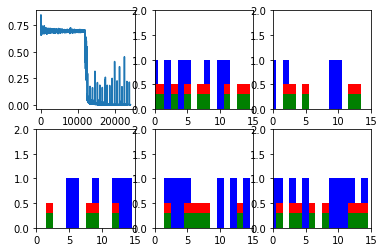

Step 400 Loss 0.000968498
single_output_series: [1 0 0 0 0 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 0 1 1 0 1 1]

single_output_series: [1 0 0 0 1 0 0 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 0 1 0 1 0 1]

single_output_series: [0 0 0 1 0 1 0 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 0 0 0 1 0]

single_output_series: [0 1 1 1 0 1 1 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 0 1 1 1 0 0 1]

single_output_series: [1 1 0 1 0 1 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 1 0 0 0 0 0]



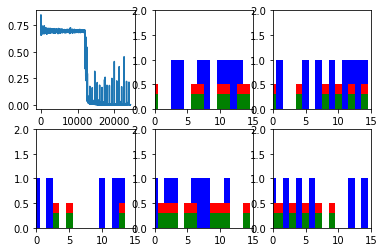

Step 500 Loss 0.000792295
single_output_series: [1 0 1 1 0 1 1 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 1 0 1 0 0 1 0]

single_output_series: [1 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 1 0 0 0 0 0 0]

single_output_series: [0 1 0 0 0 1 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 1 0 1 1 1 1 0]

single_output_series: [0 1 1 1 0 1 1 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 1 1 0 0 1 1 0]

single_output_series: [0 0 0 0 1 1 1 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 1 0 0 0 1 1]



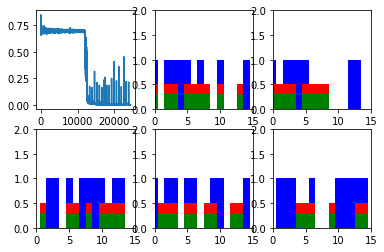

Step 600 Loss 0.000876168
single_output_series: [0 0 0 0 1 1 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 0 0 0 1 1]

single_output_series: [1 1 0 0 0 1 1 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 1 0 1 1 0 1]

single_output_series: [0 1 0 1 0 0 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 0 1 0 1 1 0]

single_output_series: [0 0 0 0 0 1 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 0 1 0 1 1 0 1]

single_output_series: [1 1 1 0 0 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 1 0 1 1 0 0]



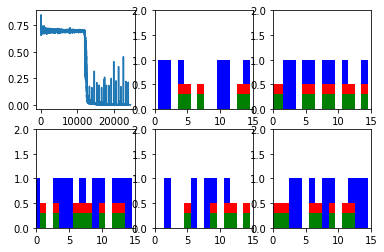

New data, epoch 37
Step 0 Loss 0.100921
single_output_series: [0 1 0 1 1 0 1 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 1 1 1 1 1 0]

single_output_series: [0 1 0 1 1 1 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 1 0 1 1 1 0]

single_output_series: [0 1 0 1 1 1 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 0 1 1 1 0 0]

single_output_series: [0 1 0 1 0 0 1 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 1 1 1 0 1 0]

single_output_series: [0 1 0 1 0 0 0 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 0 1 0 1 1 1]



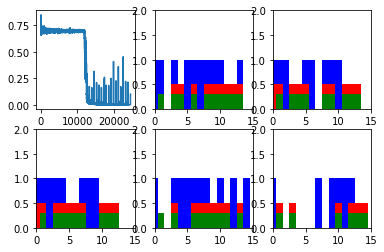

Step 100 Loss 0.0008735
single_output_series: [0 0 0 0 0 1 1 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 1 1 1 0 1 0]

single_output_series: [0 1 1 1 1 1 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 0 1 1 1 0 1]

single_output_series: [0 1 1 0 0 0 1 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 1 0 1 0 1 0]

single_output_series: [1 1 1 0 0 1 0 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 1 0 0 0 0 0 1]

single_output_series: [0 0 1 1 1 1 1 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 1 0 1 0 1]



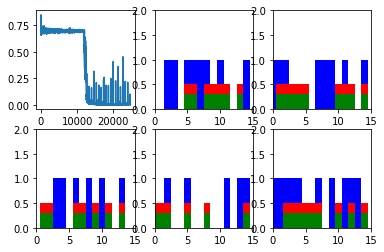

Step 200 Loss 0.000765838
single_output_series: [1 1 0 1 1 0 1 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 1 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]

single_output_series: [1 1 0 1 1 0 1 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 0 1 1 0 0 1]

single_output_series: [0 0 1 0 0 0 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 0 1 1 1 0 0]

single_output_series: [0 1 0 1 0 0 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 0 0 0 1 0 0]



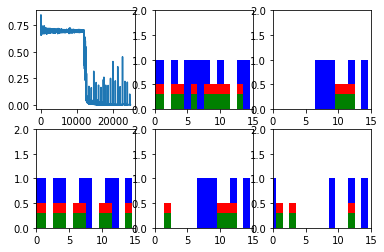

Step 300 Loss 0.000815254
single_output_series: [1 0 0 0 0 1 0 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 1 0 0 0 0 0]

single_output_series: [1 0 0 1 1 0 0 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 0 1 1 0 1 0 1]

single_output_series: [0 1 1 0 0 0 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 1 1 0 1 0]

single_output_series: [0 1 0 0 0 1 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 0 1 1 0 0 0]

single_output_series: [0 1 1 0 1 1 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 0 0 0 1 1 0]



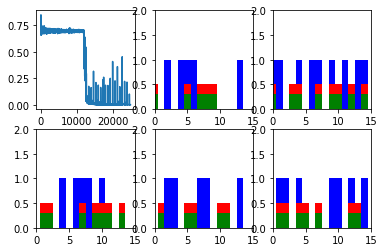

Step 400 Loss 0.000699347
single_output_series: [1 0 0 0 1 1 1 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 1 1 0 0 0 1]

single_output_series: [1 1 0 1 0 1 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 1 0 1 0 0 0]

single_output_series: [0 1 1 0 0 0 0 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 1 1 0 0 1 1]

single_output_series: [1 1 1 1 0 0 0 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 0 1 1 1 0]

single_output_series: [1 0 1 1 0 1 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 1 1 1 0 0 1 0]



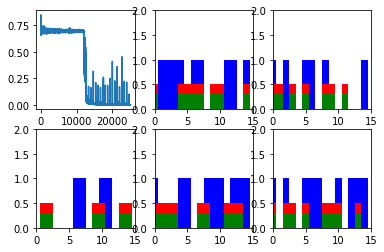

Step 500 Loss 0.000808981
single_output_series: [1 1 1 1 0 1 1 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 1 0 0 0 1 0]

single_output_series: [1 1 0 0 0 0 0 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 0 0 1 0 0 1]

single_output_series: [1 1 0 0 0 0 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 1 0 0 1 0 1]

single_output_series: [0 0 1 1 1 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 1 1 0 0 0 1]

single_output_series: [0 1 0 0 0 0 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 1 0 1 1 0 1 0]



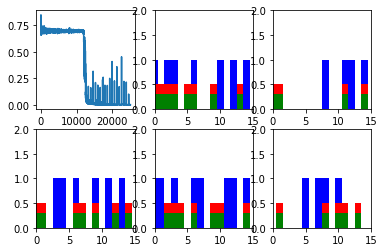

Step 600 Loss 0.000847115
single_output_series: [0 1 1 1 0 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 1 1 0 1 1 1 1]

single_output_series: [0 1 1 0 0 0 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 0 1 1 1 1 0]

single_output_series: [1 0 1 1 0 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 1 0 0 0 1]

single_output_series: [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1]

single_output_series: [0 0 0 1 1 1 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 0 1 0 1 1 1]



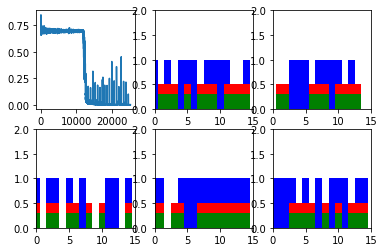

New data, epoch 38
Step 0 Loss 0.155228
single_output_series: [0 1 0 0 0 0 0 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 1 0 0 1 1 1]

single_output_series: [0 1 0 0 1 0 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 0 0 1 1 1 1]

single_output_series: [0 1 0 0 0 0 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 0 0 0 1 1]

single_output_series: [0 1 0 1 1 0 1 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 0 1 0 1 0 1]

single_output_series: [0 1 0 1 1 0 0 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 0 1 0 1 1 1 1]



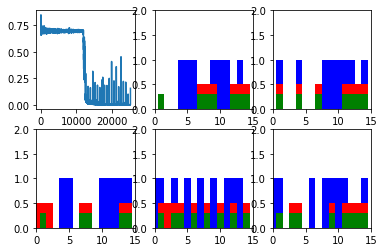

Step 100 Loss 0.000702885
single_output_series: [1 0 0 0 0 0 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 1 1 1 1 0 0 0]

single_output_series: [1 0 0 0 0 0 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 1 0 0 0 1]

single_output_series: [1 1 1 1 0 0 1 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 1 0 0 0 1 0 0]

single_output_series: [1 0 0 0 0 1 1 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 1 0 1 0 1 0]

single_output_series: [0 0 0 1 0 0 1 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 1 1 0 1 1 0]



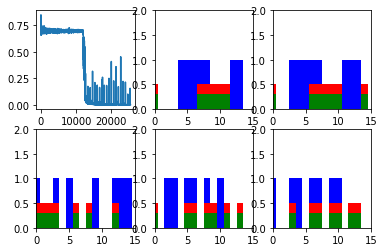

Step 200 Loss 0.000860283
single_output_series: [1 0 1 0 1 1 0 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 0 0 0 0 1 0 1]

single_output_series: [1 0 1 1 1 0 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 0 0 1 1 1 1]

single_output_series: [0 1 1 1 0 1 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 1 1 0 0 0 1 0]

single_output_series: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 0 0 0 1 1 1 1]

single_output_series: [1 0 0 0 1 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 1 1 1 0 1 1 1]



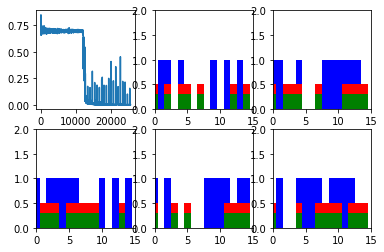

Step 300 Loss 0.000760164
single_output_series: [1 0 1 1 1 0 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 1 0 1 1 0 1]

single_output_series: [0 1 1 0 1 0 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 1 1 0 0 0 1 0]

single_output_series: [0 1 1 0 1 1 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 1 1 0 0 0 1]

single_output_series: [0 1 0 0 1 0 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 0 0 0 0 1 1]

single_output_series: [1 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 0 0 0 1 1 0 1]



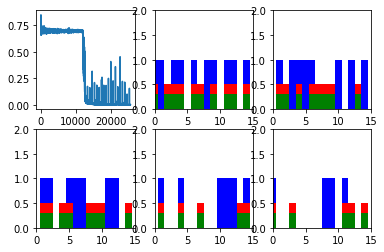

Step 400 Loss 0.000740022
single_output_series: [0 1 1 0 1 1 0 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 1 1 0 0 0 0]

single_output_series: [1 1 0 0 1 0 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 0 0 0 0 1 0 1]

single_output_series: [1 0 0 1 1 0 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 1 1 1 1 0 0 0]

single_output_series: [0 1 1 1 1 0 0 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 0 1 1 0 1 0]

single_output_series: [0 1 0 0 1 0 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 1 0 1 1 1]



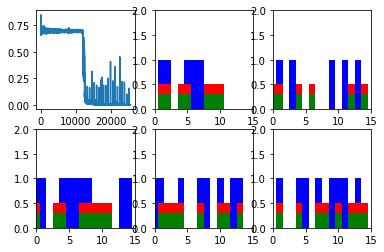

Step 500 Loss 0.000796274
single_output_series: [0 0 1 1 0 1 1 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 0 1 0 0 1 0]

single_output_series: [0 0 1 0 0 1 0 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 0 0 1 1 1 1]

single_output_series: [0 1 0 1 1 1 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 1 0 0 0 0 0]

single_output_series: [1 0 1 0 1 0 0 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 0 0 1 0 0 1]

single_output_series: [0 1 0 1 0 0 1 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 0 1 1 0 0 0]



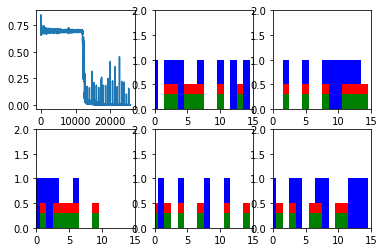

Step 600 Loss 0.000688383
single_output_series: [0 0 1 0 1 0 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 0 0 0 1 0 0 1]

single_output_series: [0 1 0 0 0 1 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 0 1 1 1 1 1]

single_output_series: [1 0 1 1 1 0 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 1 1 0 1 1 0]

single_output_series: [0 0 0 0 1 1 0 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 1 1 0 0 1]

single_output_series: [1 1 1 0 0 1 0 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 0 1 0 0 0 1 1]



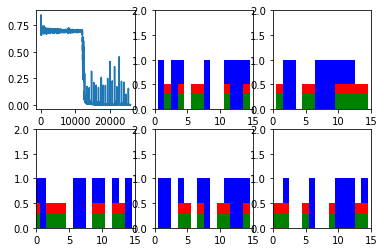

New data, epoch 39
Step 0 Loss 0.203199
single_output_series: [0 0 1 0 0 0 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 0 1 1 1 1 0]

single_output_series: [0 0 1 0 0 1 1 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 1 0 1 1 0 0]

single_output_series: [0 0 0 0 1 0 0 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 0 1 1 0 1 1 1]

single_output_series: [0 0 1 0 0 0 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 1 1 0 1 1 1]

single_output_series: [0 0 1 1 0 1 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 0 0 1 1 1 1 1]



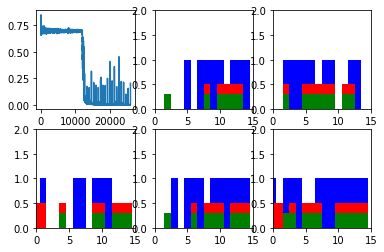

Step 100 Loss 0.000760349
single_output_series: [1 1 0 1 0 0 1 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 1 0 1 1 0 1]

single_output_series: [1 1 0 0 1 1 1 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 1 1 1 0 0 0]

single_output_series: [0 0 0 0 0 1 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 1 0 1 1 0 0]

single_output_series: [1 0 0 1 0 1 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 0 0 1 1 1 0 1]

single_output_series: [0 0 0 1 1 0 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 0 1 1 0 0 1]



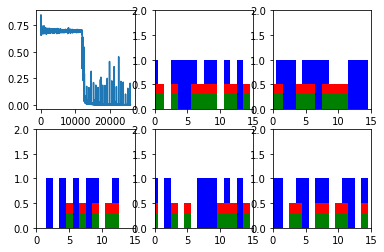

Step 200 Loss 0.00082801
single_output_series: [1 0 1 1 1 0 0 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 1 1 1 1 1 0]

single_output_series: [0 0 1 0 1 0 1 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 1 0 1 1 1 1]

single_output_series: [1 0 1 0 0 0 0 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 1 1 0 0 1]

single_output_series: [1 1 0 1 1 0 0 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 0 1 0 1 0 0]

single_output_series: [1 0 1 0 0 1 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 1 0 1 0 0 0]



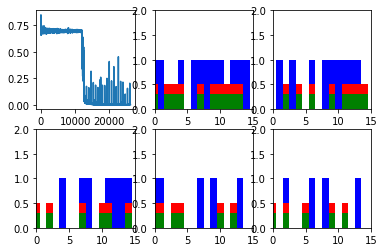

Step 300 Loss 0.000727448
single_output_series: [1 1 0 0 1 1 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 1 1 0 0 1 1]

single_output_series: [1 0 1 1 0 1 0 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 1 1 1 0 1 1]

single_output_series: [0 0 0 1 1 1 1 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 1 0 1 1 0 1]

single_output_series: [0 0 1 1 0 0 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 0 0 0 0 1 0]

single_output_series: [1 0 1 0 1 0 0 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 0 1 0 0 1 1]



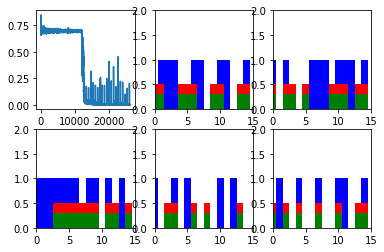

Step 400 Loss 0.000681193
single_output_series: [0 1 1 0 0 1 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 1 0 1 0 0 0]

single_output_series: [1 0 0 1 1 0 1 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 1 0 0 0 0 0]

single_output_series: [0 0 0 1 1 1 0 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 0 0 1 1 0 1 0]

single_output_series: [1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 1 1 0 0 1 1]



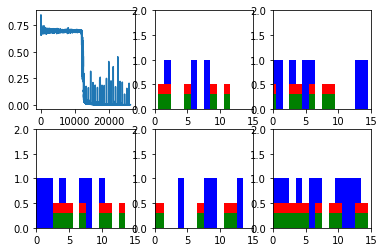

Step 500 Loss 0.000825159
single_output_series: [0 1 0 1 1 1 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 0 0 1 0 1 1]

single_output_series: [0 1 0 1 1 0 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 0 1 0 1 1 1 0]

single_output_series: [1 0 0 0 0 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 1 1 0 0 0 0 1]

single_output_series: [0 0 1 1 0 0 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 1 1 1 1 1 1 0]

single_output_series: [0 1 1 1 1 1 0 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 1 0 0 1 0]



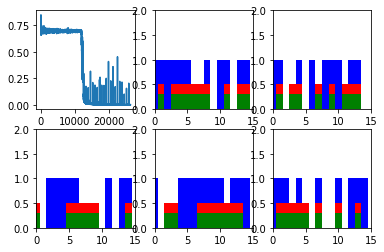

Step 600 Loss 0.000876303
single_output_series: [1 1 0 0 1 1 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 1 0 1 1 1 0]

single_output_series: [0 0 0 1 1 1 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 0 0 0 0 1 1 1]

single_output_series: [0 1 0 0 0 0 1 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 1 1 1 1 1 1]

single_output_series: [1 0 1 1 1 1 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 0 1 0 1 1 0 0]

single_output_series: [1 0 1 0 0 1 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 1 0 0 0 1 1]



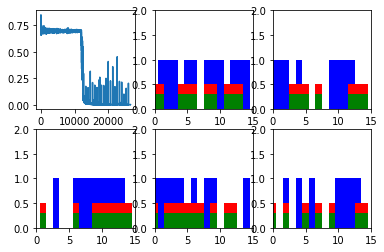

New data, epoch 40
Step 0 Loss 0.211199
single_output_series: [0 1 0 0 0 1 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 1 1 1 1 1]

single_output_series: [0 1 0 0 0 1 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 1 1 0 1 0 1]

single_output_series: [0 1 0 1 0 1 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 0 1 0 0 0 1]

single_output_series: [0 1 0 1 1 1 1 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 1 0 0 1 1 1]

single_output_series: [0 1 0 0 1 1 1 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 1 1 0 1 0 1]



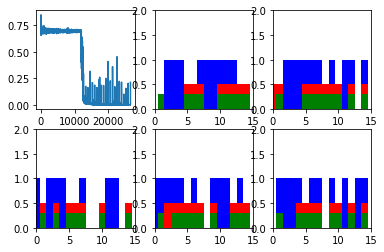

Step 100 Loss 0.000657276
single_output_series: [1 1 1 0 0 0 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 1 0 0 0 1 1]

single_output_series: [1 1 0 0 1 0 0 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 1 1 1 1 1 1]

single_output_series: [0 0 0 1 0 0 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 1 1 1 1 1 0]

single_output_series: [0 1 0 0 1 0 1 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 1 0 1 0 0 0]

single_output_series: [1 1 1 1 0 1 1 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 1 0 0 0 0 1]



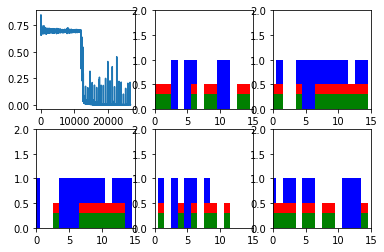

Step 200 Loss 0.000753235
single_output_series: [1 1 0 0 1 1 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 1 0 0 0 0 0]

single_output_series: [1 1 1 1 1 0 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 0 0 1 0 1 1]

single_output_series: [0 0 0 1 1 1 1 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 0 1 0 1 0 1]

single_output_series: [1 0 1 0 1 1 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 0 1 1 0 0 1]

single_output_series: [0 0 1 1 0 0 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 0 0 1 1 1 0]



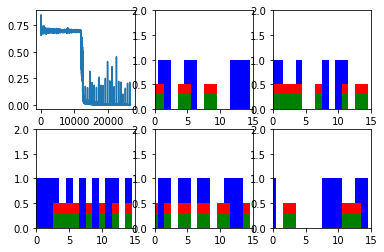

Step 300 Loss 0.000698953
single_output_series: [0 0 1 1 0 1 0 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 1 0 1 0 0 0 1]

single_output_series: [1 1 0 0 0 1 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 1 1 1 1 1 1]

single_output_series: [0 1 0 0 1 1 0 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 1 1 1 0 0 1 1]

single_output_series: [1 0 0 1 0 1 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 0 1 1 0 0 0 0]

single_output_series: [0 0 1 1 0 0 0 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 0 1 1 0 1 1]



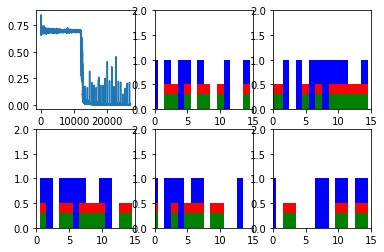

Step 400 Loss 0.000755378
single_output_series: [0 0 0 1 0 0 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 0 1 1 0 1 0]

single_output_series: [1 1 0 0 1 1 0 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 0 0 0 0 0 1]

single_output_series: [0 0 0 0 1 1 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 1 0 1 1 0 1 0]

single_output_series: [1 0 0 1 1 0 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 0 1 1 1 1 0]

single_output_series: [1 0 1 1 0 1 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 1 1 0 1 1 1]



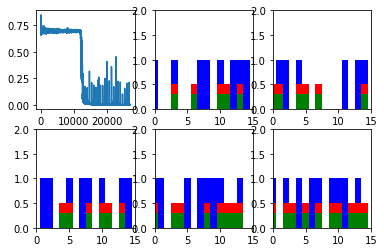

Step 500 Loss 0.000644113
single_output_series: [1 0 0 0 1 1 1 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 0 1 0 1 0 0]

single_output_series: [0 1 1 0 1 0 1 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 1 1 1 1 0 0]

single_output_series: [1 1 0 0 1 1 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 0 0 0 1 1 1]

single_output_series: [1 1 0 1 1 1 1 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 0 1 0 0 0 0]

single_output_series: [1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]



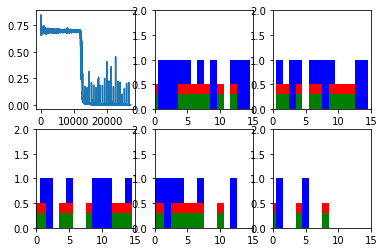

Step 600 Loss 0.00063972
single_output_series: [1 1 0 0 1 0 1 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 1 0 0 1 1 1]

single_output_series: [1 0 0 0 0 1 0 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 1 1 1 1 1 0 0]

single_output_series: [0 0 1 1 0 1 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 1 0 0 0 1 0 1]

single_output_series: [1 1 0 0 1 1 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 1 1 0 1 1 1]

single_output_series: [0 1 0 0 0 1 1 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 0 1 0 0 1 1]



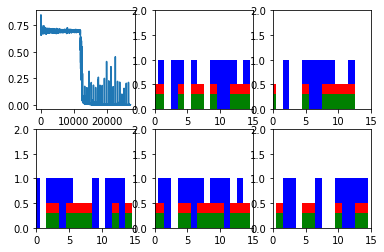

New data, epoch 41
Step 0 Loss 0.202991
single_output_series: [0 1 0 0 0 0 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 1 1 1 0 1 0]

single_output_series: [0 1 0 1 0 0 0 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 1 1 1 1 1]

single_output_series: [0 1 0 1 1 1 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 1 0 0 0 1 1]

single_output_series: [0 1 0 0 1 1 0 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 0 0 1 0 1 1 1]

single_output_series: [0 1 0 1 0 0 0 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 0 1 1 0 1 1]



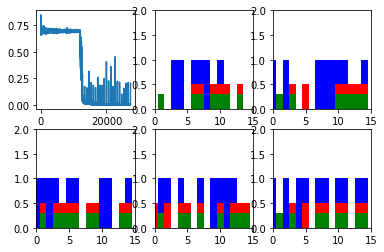

Step 100 Loss 0.000849809
single_output_series: [1 0 1 0 1 1 1 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 1 0 0 0 1 0]

single_output_series: [1 0 1 1 1 0 1 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 1 1 0 1 1 1]

single_output_series: [0 1 0 1 1 1 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 0 0 0 1 1 0]

single_output_series: [0 0 1 1 1 1 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 0 0 0 1 0]

single_output_series: [1 0 1 0 0 1 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 0 0 0 1 0 0 1]



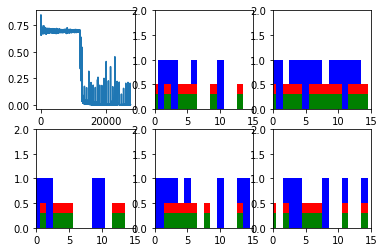

Step 200 Loss 0.000908354
single_output_series: [0 1 1 0 1 0 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 1 0 1 1 0 0 0]

single_output_series: [0 0 1 1 0 1 1 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 0 0 0 0 1 0]

single_output_series: [0 0 1 0 0 1 1 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 0 1 1 0 1 0 0]

single_output_series: [0 0 1 1 0 0 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [0 1 1 1 0 0 1 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 0 1 0 1 1 0]



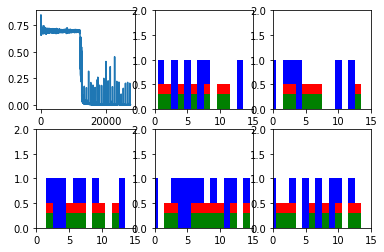

Step 300 Loss 0.000899943
single_output_series: [0 1 0 1 0 0 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [0 0 1 0 0 0 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 0 0 1 1 1 1]

single_output_series: [1 1 1 1 0 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 0 1 1 1 0]

single_output_series: [1 1 0 1 0 0 1 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 0 0 1 0 1 1]

single_output_series: [0 1 1 0 1 1 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 0 1 1 0 0 0 1]



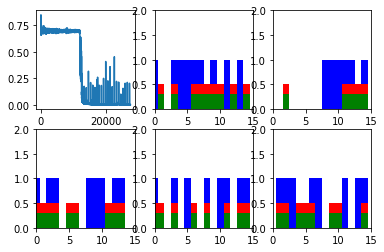

Step 400 Loss 0.000784081
single_output_series: [0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]

single_output_series: [1 1 1 1 1 0 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 1 0 0 0 1 1 1]

single_output_series: [1 0 1 1 1 0 0 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 1 1 1 1 1 0]

single_output_series: [0 1 0 1 0 1 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 0 0 1 0 0]

single_output_series: [0 0 0 0 0 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 0 1 0 0 1 0]



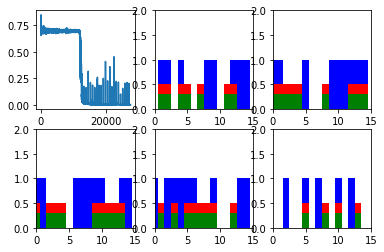

Step 500 Loss 0.000763814
single_output_series: [0 0 1 1 0 0 1 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 1 0 0 0 1 0]

single_output_series: [1 1 1 1 0 1 1 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 0 0 1 1 1]

single_output_series: [0 0 1 1 1 1 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 1 0 1 1 1 0]

single_output_series: [1 1 1 1 0 0 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 1 1 1 1 1 1]

single_output_series: [0 0 1 1 1 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 0 1 0 0 1 0]



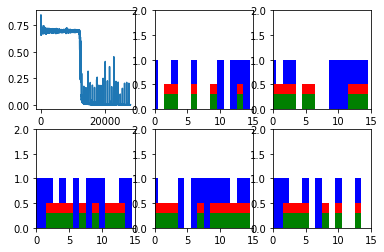

Step 600 Loss 0.000759743
single_output_series: [0 1 0 1 1 0 0 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 0 1 1 0 0 1]

single_output_series: [1 0 1 0 1 0 0 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 0 1 1 1 1 0]

single_output_series: [0 0 0 0 0 0 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 0 0 0 1 1 0]

single_output_series: [1 1 0 0 1 1 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 0 1 1 0 1 1]

single_output_series: [0 1 0 0 1 0 0 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 1 0 1 1 0 1]



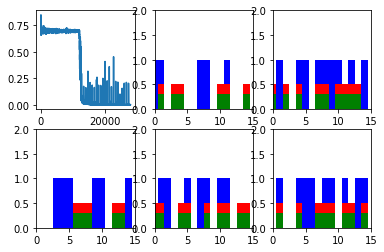

New data, epoch 42
Step 0 Loss 0.173245
single_output_series: [0 0 0 0 1 1 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 1 1 1 1 1]

single_output_series: [1 0 1 1 0 1 0 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 1 1 1 1 1 0]

single_output_series: [0 0 0 0 1 1 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 1 0 0 0 1 1 0]

single_output_series: [0 0 0 0 1 1 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 1 1 0 1 1 1 0]

single_output_series: [0 0 0 0 1 0 0 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 0 1 0 0 1 1]



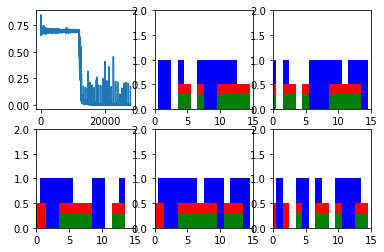

Step 100 Loss 0.000690756
single_output_series: [0 1 0 0 0 0 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 0 0 0 1 1 1]

single_output_series: [1 0 0 0 1 0 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 1 0 0 0 0 1 0]

single_output_series: [0 1 0 0 1 0 1 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 0 1 1 1 0 0 1]

single_output_series: [0 1 0 0 1 0 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 1 1 0 1 0 0]

single_output_series: [1 1 1 1 1 0 1 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 0 0 0 0 0 1]



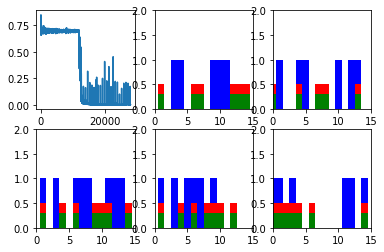

Step 200 Loss 0.000661082
single_output_series: [0 0 0 1 0 1 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 1 1 0 1 1 0]

single_output_series: [0 1 1 0 0 1 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 1 0 0 0 1 0]

single_output_series: [1 0 1 1 1 0 0 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 1 0 1 1 0 0]

single_output_series: [1 0 1 0 0 1 0 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 1 1 0 0 0 1]

single_output_series: [1 0 1 1 1 0 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 0 0 0 0 0]



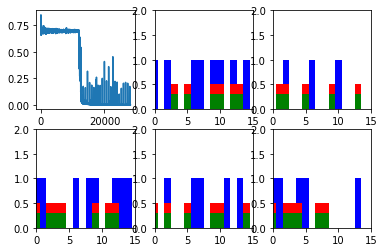

Step 300 Loss 0.000678695
single_output_series: [1 0 1 1 0 1 1 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 0 0 1 1 0]

single_output_series: [1 0 0 1 0 0 0 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 1 1 1 1 0 0 1]

single_output_series: [0 1 1 1 1 0 1 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 0 0 1 1 1 1]

single_output_series: [1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]

single_output_series: [1 1 0 1 0 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 0 0 0 0 0 0 0]



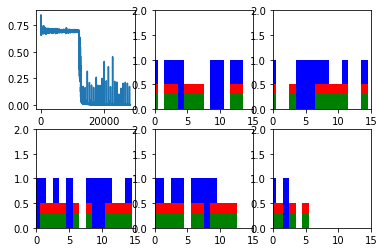

Step 400 Loss 0.000688249
single_output_series: [1 1 1 0 1 1 1 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 0 1 0 0 0 1 0]

single_output_series: [0 1 0 0 0 0 0 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 1 1 1 1 0 1]

single_output_series: [0 0 0 0 0 1 1 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 0 0 1 0 1 1]

single_output_series: [0 1 0 1 1 1 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 0 1 0 0 0 0]

single_output_series: [1 1 0 0 1 1 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 0 1 1 1 0 1 0]



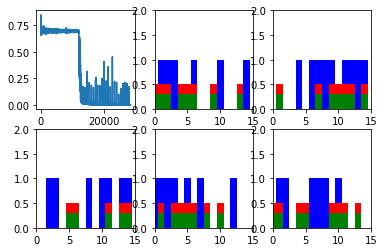

Step 500 Loss 0.000539616
single_output_series: [1 0 0 0 0 0 1 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 0 0 0 0 0]

single_output_series: [0 0 0 0 0 1 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 1 0 0 1 0 0]

single_output_series: [1 1 0 1 1 0 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 1 1 0 1 1 0]

single_output_series: [1 0 0 0 0 1 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 1 0 1 0 0 0]

single_output_series: [1 0 0 1 0 1 1 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 0 1 1 1 0 0 0]



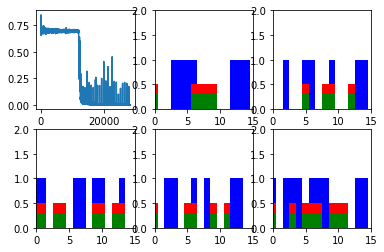

Step 600 Loss 0.000754763
single_output_series: [1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]

single_output_series: [1 0 1 0 1 0 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 0 0 1 0 0 0 1]

single_output_series: [1 1 0 0 0 1 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 0 0 0 0 0 1 1]

single_output_series: [0 1 0 1 0 1 1 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 1 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 1 0 1 1 1 1]



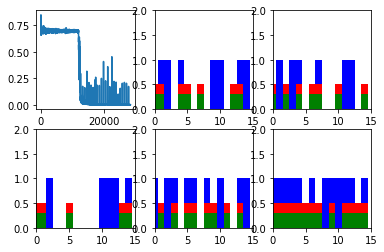

New data, epoch 43
Step 0 Loss 0.554555
single_output_series: [1 0 1 1 0 0 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 0 1 0 1 0 1]

single_output_series: [1 0 1 1 0 0 0 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 1 0 0 0 1 0 1]

single_output_series: [0 0 0 0 1 0 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 0 1 1 1 1 1 1]

single_output_series: [1 0 1 1 0 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 0 0 1 0 0 0]

single_output_series: [1 0 1 1 1 1 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 0 1 0 1 1 1]



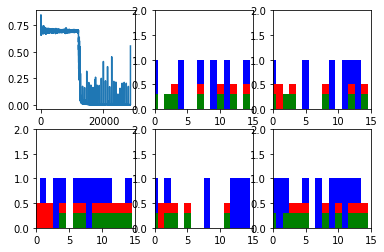

Step 100 Loss 0.000721531
single_output_series: [1 0 0 0 0 1 0 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 1 1 1 0 0 1]

single_output_series: [1 0 1 1 1 1 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 1 1 0 1 1 0]

single_output_series: [1 1 1 0 1 1 1 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 1 0 1 0 1 0 0]

single_output_series: [0 0 1 0 1 0 0 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 1 0 0 1 0 0 1]

single_output_series: [0 0 1 1 1 1 0 1 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 1 0 0 0 1 0]



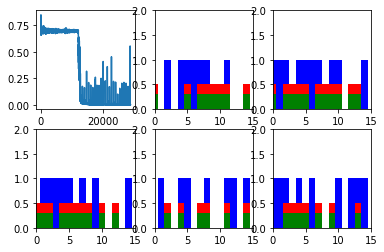

Step 200 Loss 0.000725127
single_output_series: [0 0 1 0 0 1 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 1 0 1 0 1 0]

single_output_series: [0 0 1 0 1 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 1 0 0 1 0 1 1]

single_output_series: [0 1 0 1 1 0 1 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 1 0 0 0 1 1]

single_output_series: [0 1 1 0 0 1 1 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 0 0 1 0 0 1 0]

single_output_series: [0 0 1 1 1 1 0 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 0 1 1 0 0 0 0]



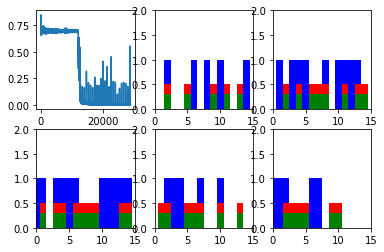

Step 300 Loss 0.000727332
single_output_series: [0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]

single_output_series: [1 1 0 1 1 1 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 0 1 0 1 0 1]

single_output_series: [1 0 1 0 1 0 0 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 0 1 0 1 1 0]

single_output_series: [0 0 1 0 1 0 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 1 1 0 0 0 0 0]

single_output_series: [1 0 1 0 0 1 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 0 0 1 0 1 1 1]



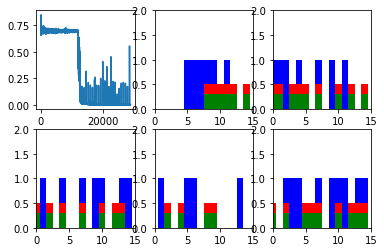

Step 400 Loss 0.00055439
single_output_series: [1 0 0 1 0 0 0 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 1 0 0 1 1 1 0]

single_output_series: [0 1 1 0 1 1 1 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 1 1 0 1 1 1]

single_output_series: [1 1 0 0 1 1 0 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 0 0 1 1 0 1 0]

single_output_series: [0 0 0 1 0 0 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 1 1 1 0 1 0]

single_output_series: [1 0 0 0 1 1 1 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 0 0 1 1 0 1]



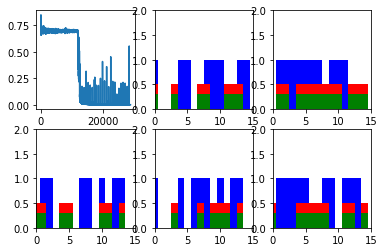

Step 500 Loss 0.000569364
single_output_series: [0 1 1 0 1 1 0 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 0 0 1 1 0 0]

single_output_series: [0 1 1 1 0 1 0 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 0 0 0 0 0 1]

single_output_series: [1 1 0 1 0 0 0 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 1 1 1 1 1 0]

single_output_series: [0 1 0 0 1 1 0 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 1 0 1 1 0 1]

single_output_series: [0 1 1 0 0 1 0 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 1 1 1 0 0 1]



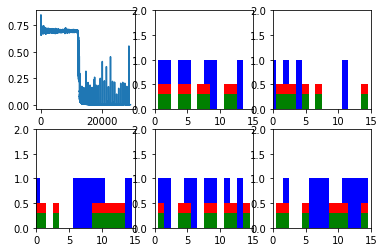

Step 600 Loss 0.000758268
single_output_series: [1 0 0 1 0 0 0 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 1 0 1 1 0 1 1]

single_output_series: [0 1 0 1 1 0 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 0 1 1 0 1 1 1]

single_output_series: [0 0 0 1 0 1 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 0 1 1 0 0 0]

single_output_series: [1 0 1 0 1 0 1 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 0 0 0 0 0 0 0]

single_output_series: [0 0 0 1 0 1 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 0 1 0 0 0 0]



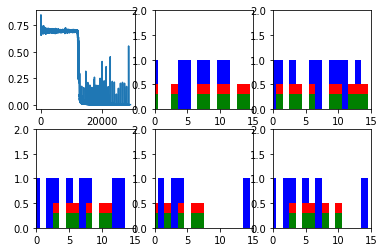

New data, epoch 44
Step 0 Loss 0.138253
single_output_series: [0 0 1 0 0 1 0 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]

single_output_series: [1 0 1 1 1 1 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 0 1 0 0 0 0 1]

single_output_series: [1 0 1 1 0 0 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 0 0 0 0 0 0]

single_output_series: [1 0 1 1 1 1 0 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 1 0 0 0 0 1]

single_output_series: [1 0 1 1 1 0 0 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 1 0 1 0 1 1]



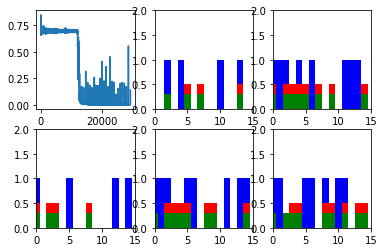

Step 100 Loss 0.000481823
single_output_series: [0 0 1 0 0 1 0 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 0 0 1 1 0 1]

single_output_series: [0 0 1 1 1 1 1 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 1 0 0 1 1 0]

single_output_series: [1 1 0 1 0 0 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 1 0 0 1 0 0 0]

single_output_series: [0 0 0 1 1 1 1 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 1 0 0 0 0 0]

single_output_series: [1 1 1 0 0 0 1 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 1 0 0 0 0 0]



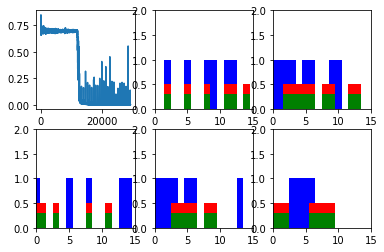

Step 200 Loss 0.000730381
single_output_series: [0 1 0 1 1 1 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 1 1 1 1 1 0]

single_output_series: [0 0 1 0 1 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 0 1 1 1 0]

single_output_series: [1 1 0 1 1 1 0 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 0 0 1 0 1 0]

single_output_series: [0 0 1 1 0 1 1 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 0 1 0 1 0 1]

single_output_series: [1 0 0 0 0 1 0 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 1 0 0 0 1 0 1]



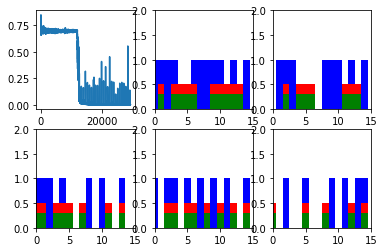

Step 300 Loss 0.000510764
single_output_series: [0 1 0 0 1 0 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 0 0 0 0 1 1]

single_output_series: [0 0 1 0 0 1 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 0 1 1 0 0 1]

single_output_series: [0 0 1 1 0 0 0 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 1 1 0 1 1 0 0]

single_output_series: [1 1 1 0 1 0 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 1 1 1 1 0 1]

single_output_series: [1 1 1 1 0 1 0 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 0 0 1 1 1 0]



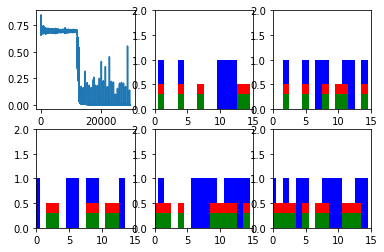

Step 400 Loss 0.000635993
single_output_series: [1 0 0 1 0 0 1 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 0 1 0 1 0 1]

single_output_series: [0 1 0 0 0 0 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 1 0 0 0 0 1 1]

single_output_series: [1 1 0 1 1 1 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 0 1 1 1 0 0]

single_output_series: [1 0 1 0 0 1 0 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 1 0 1 0 1 0 0]

single_output_series: [1 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 0 0 0 1 0 0 0]



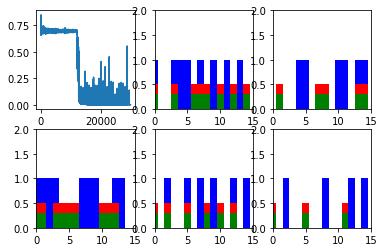

Step 500 Loss 0.000590672
single_output_series: [1 0 1 0 0 0 1 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 0 1 1 0 1 1]

single_output_series: [1 0 1 0 0 1 1 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 1 0 0 1 0]

single_output_series: [1 1 0 0 0 0 1 0 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 0 1 0 0 1 1 1]

single_output_series: [1 0 0 0 1 0 1 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 1 0 1 0 1 0]

single_output_series: [1 0 0 1 0 0 1 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 0 0 0 0 0 1]



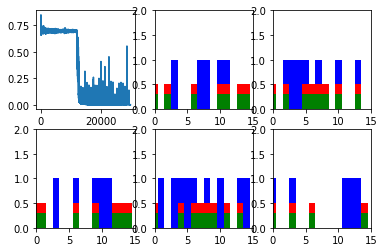

Step 600 Loss 0.000632599
single_output_series: [1 0 1 0 1 1 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 1 0 1 0 0 0]

single_output_series: [1 0 0 0 1 0 0 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 0 1 0 1 0 0]

single_output_series: [0 0 1 0 1 1 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 0 1 1 1 1 0 1]

single_output_series: [0 1 0 1 0 0 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 1 1 1 0 1 0]

single_output_series: [0 0 0 1 1 1 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 1 0 0 1 0 0]



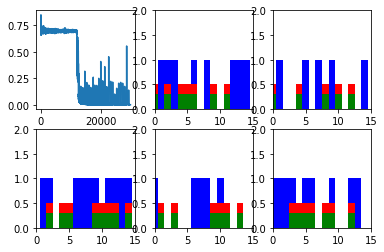

New data, epoch 45
Step 0 Loss 0.165415
single_output_series: [0 0 1 1 1 0 1 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 0 1 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 1 1 1 1 1 1]

single_output_series: [0 0 1 1 1 0 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 0 1 1 1 0 0]

single_output_series: [0 0 0 0 1 0 1 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 0 1 1 0 1 0 1]

single_output_series: [0 0 1 1 1 0 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 1 1 0 1 0 0]



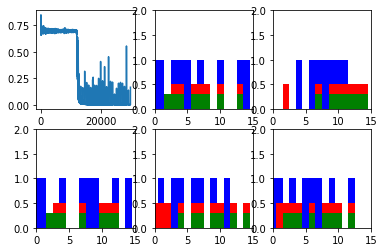

Step 100 Loss 0.000578562
single_output_series: [0 1 0 0 1 0 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 0 0 0 1 0 1 0]

single_output_series: [1 0 0 0 1 1 1 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 1 1 0 1 1 0]

single_output_series: [0 1 0 1 0 0 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 1 1 1 0 1 1]

single_output_series: [0 1 0 1 0 0 0 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 0 1 0 0 0 0]

single_output_series: [0 1 1 0 0 0 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 0 1 0 0 0 0 0]



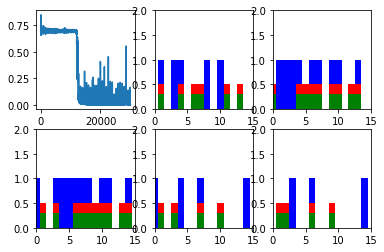

Step 200 Loss 0.000639717
single_output_series: [1 0 0 0 0 1 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 1 1 0 1 1 1 0]

single_output_series: [1 0 0 1 1 1 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 1 0 0 1 0 1]

single_output_series: [1 1 0 1 0 0 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 0 1 0 0 1 1]

single_output_series: [1 0 0 0 0 1 1 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 1 1 0 1 0 0]

single_output_series: [0 0 1 0 1 0 1 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 0 0 0 0 1 0]



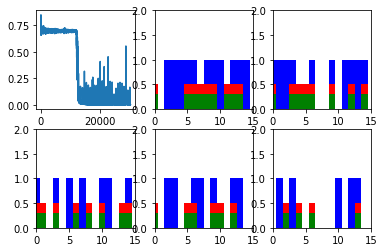

Step 300 Loss 0.000736465
single_output_series: [0 1 0 0 1 0 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 0 1 0 1 1 1]

single_output_series: [1 1 1 0 0 1 1 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 0 1 1 0 1 1]

single_output_series: [1 1 0 0 0 0 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 1 1 0 1 1 1]

single_output_series: [0 0 1 0 1 1 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 0 1 1 1 1 0]

single_output_series: [1 0 1 0 0 1 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 0 1 1 1 1 1]



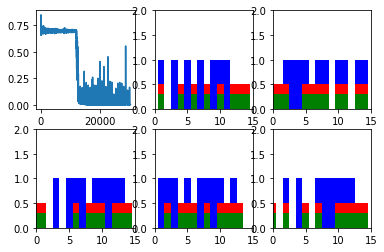

Step 400 Loss 0.000609377
single_output_series: [1 1 0 1 0 1 1 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 0 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 0 0 1 0 0 0]

single_output_series: [0 0 1 1 1 1 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 1 1 1 1 0 1]

single_output_series: [1 1 1 1 0 1 0 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 0 1 1 0 0 0 1]

single_output_series: [0 1 0 1 0 0 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 1 1 0 1 0 0]



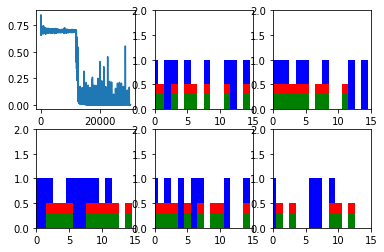

Step 500 Loss 0.000598049
single_output_series: [0 0 0 0 0 1 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 1 1 0 1 1 0]

single_output_series: [0 0 0 1 1 1 0 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 0 1 0 0 0]

single_output_series: [1 1 1 0 1 0 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 1 1 0 0 1 0 0]

single_output_series: [0 1 1 1 0 0 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 0 0 0 1 0 1]

single_output_series: [0 1 0 1 0 1 0 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 1 0 0 0 0]



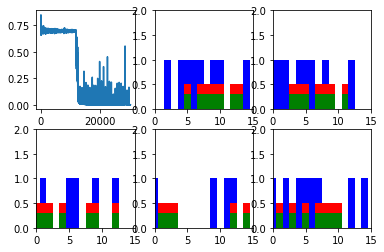

Step 600 Loss 0.000568029
single_output_series: [0 1 1 0 1 0 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 0 0 0 1 0 1]

single_output_series: [0 1 0 0 1 1 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 1 1 0 0 1 1]

single_output_series: [1 0 0 0 0 1 1 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 0 0 0 0 1]

single_output_series: [1 0 0 0 0 0 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 0 1 0 1 1 0]

single_output_series: [1 0 0 0 0 1 0 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 1 1 1 1 1 1]



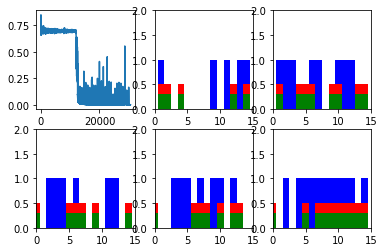

New data, epoch 46
Step 0 Loss 0.244825
single_output_series: [0 0 1 0 0 0 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 1 0 1 0 1 0]

single_output_series: [0 0 1 0 1 1 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 1 0 1 1 1 1]

single_output_series: [0 0 1 0 0 0 0 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 1 0 0 1 1 0]

single_output_series: [0 1 0 1 1 1 0 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 0 1 0 1 0 1]

single_output_series: [0 1 0 1 1 0 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 1 1 1 1 1 0 0 1]



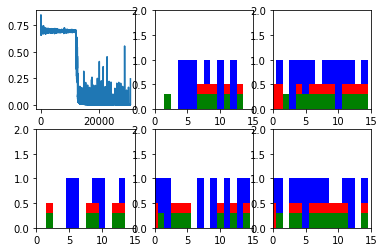

Step 100 Loss 0.000520546
single_output_series: [1 0 0 0 0 1 1 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 1 1 0 0 0 0 0]

single_output_series: [1 1 0 0 1 1 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 0 0 1 0 0 0]

single_output_series: [1 1 1 0 1 0 1 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 1 1 0 1 0 0]

single_output_series: [1 0 0 1 0 0 1 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 0 1 0 0 1 1 1]

single_output_series: [1 1 0 0 0 0 0 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 1 0 0 1 0 0]



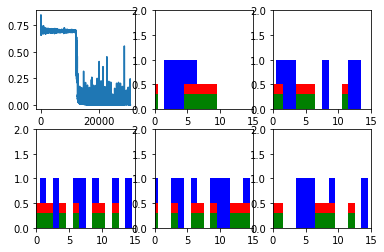

Step 200 Loss 0.00064262
single_output_series: [1 0 1 0 1 0 1 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 0 0 0 1 1 0 1]

single_output_series: [1 1 1 1 0 0 1 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 0 0 1 0 0 0]

single_output_series: [1 0 0 0 0 1 0 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 0 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 0 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 0 0 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 0 1 0 1 0 0]



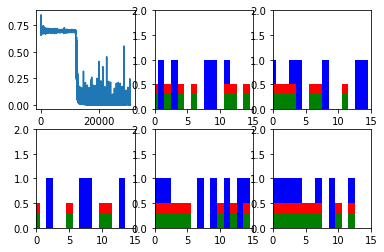

Step 300 Loss 0.000580425
single_output_series: [1 0 0 0 0 1 1 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 0 0 0 1 0 0]

single_output_series: [1 0 0 1 1 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 0 1 0 0 0 0]

single_output_series: [0 1 0 0 0 0 0 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 1 1 0 0 0 0 0]

single_output_series: [0 0 0 1 1 1 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 1 1 1 1 1 1]

single_output_series: [1 1 0 1 0 1 1 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 1 1 0 1 0 0]



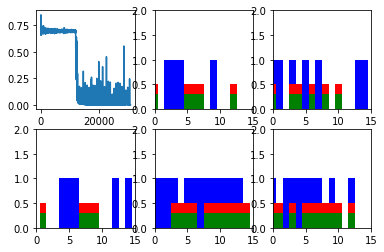

Step 400 Loss 0.00055749
single_output_series: [1 1 1 0 1 0 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 1 0 0 1 1 1 1]

single_output_series: [1 0 0 0 1 1 1 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 1 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 1 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 0 1 1 0 0 1]

single_output_series: [1 0 0 0 0 0 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 0 1 0 1 1 0]

single_output_series: [1 1 0 1 1 0 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 0 0 0 1 0 1]



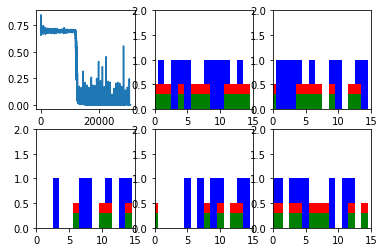

Step 500 Loss 0.000605687
single_output_series: [0 0 1 0 1 1 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 1 0 1 0 1]

single_output_series: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

single_output_series: [0 1 0 1 1 0 0 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 1 0 1 0 1 1 0]

single_output_series: [1 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 0 0 0 1 0 0 0]

single_output_series: [1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]



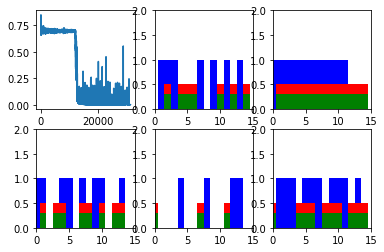

Step 600 Loss 0.000567978
single_output_series: [0 0 0 1 1 1 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 0 1 1 1 1]

single_output_series: [0 0 0 1 0 1 0 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 0 1 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 1 1 1 0 1 0]

single_output_series: [0 0 1 0 1 1 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 1 0 0 1 1 0]

single_output_series: [0 1 1 1 1 0 1 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 0 0 0 0 0 1]



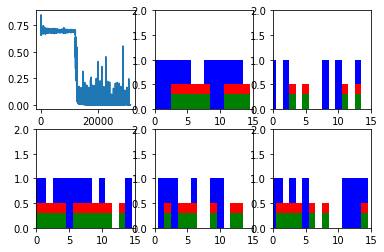

New data, epoch 47
Step 0 Loss 0.131798
single_output_series: [0 1 0 1 0 0 0 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 1 0 0 1 1 0]

single_output_series: [0 1 0 0 0 0 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 0 0 1 1 0 1]

single_output_series: [0 1 0 0 1 1 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 1 0 0 0 0 1]

single_output_series: [0 1 0 1 1 0 0 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 0 1 1 0 0 1 0]

single_output_series: [0 1 0 1 0 0 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 0 1 0 0 0 0 1]



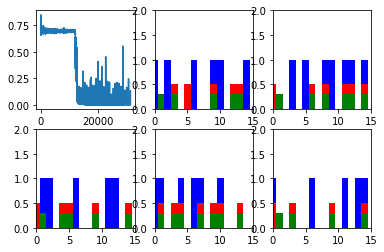

Step 100 Loss 0.000669397
single_output_series: [0 0 1 0 1 0 1 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 1 1 1 0 1 1 1]

single_output_series: [1 0 1 0 0 1 0 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 1 0 1 1 0 0 0]

single_output_series: [0 0 1 1 1 1 0 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 0 1 0 1 1 0 0]

single_output_series: [0 1 0 0 0 1 0 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 1 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 0 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 1 0 0 1 0 1]



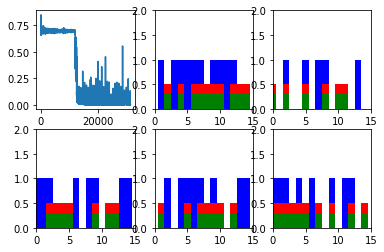

Step 200 Loss 0.000604959
single_output_series: [1 1 0 1 0 0 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 0 1 1 1 1 0 1]

single_output_series: [1 0 1 1 1 0 1 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 0 0 0 1 1 1]

single_output_series: [1 0 0 1 0 1 1 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 0 1 0 0 0 0 0]

single_output_series: [0 0 1 1 1 1 1 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 1 0 1 1 0 1]

single_output_series: [1 1 0 0 1 0 0 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 1 1 0 0 1 1]



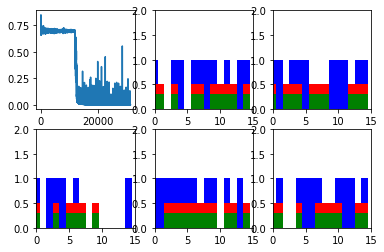

Step 300 Loss 0.000595437
single_output_series: [0 1 0 0 1 1 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 1 0 1 1 1 0]

single_output_series: [0 1 1 1 0 0 1 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 1 1 1 0 1 1]

single_output_series: [0 1 1 1 0 1 0 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 1 0 0 1 1 1 1]

single_output_series: [0 1 1 1 1 1 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 0 1 1 0 0 1 0]

single_output_series: [1 0 1 0 0 1 0 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 0 1 0 0 1 1]



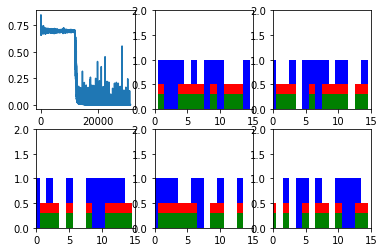

Step 400 Loss 0.000791791
single_output_series: [1 1 0 1 0 1 1 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 1 0 0 0 0 0]

single_output_series: [1 1 1 0 1 0 1 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 0]

single_output_series: [0 1 0 0 1 1 0 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 0 1 1 0 0 0]

single_output_series: [0 0 1 1 1 0 1 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 1 1 1 0 1 1 1]

single_output_series: [0 1 0 0 1 0 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 0 1 1 0 0 0 0]



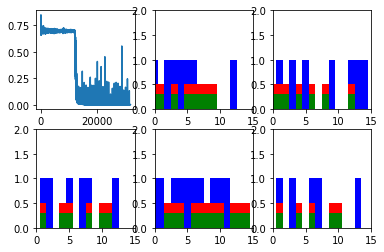

Step 500 Loss 0.000615943
single_output_series: [1 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 1 0 0 0 0 1 0]

single_output_series: [1 0 0 0 0 1 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 0 1 1 0 0 0]

single_output_series: [0 0 0 0 1 0 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 1 0 1 1 0 0]

single_output_series: [1 0 1 0 0 1 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 0 0 0 1 1 0]

single_output_series: [1 1 1 1 0 0 0 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 0 1 0 0 1 1 0]



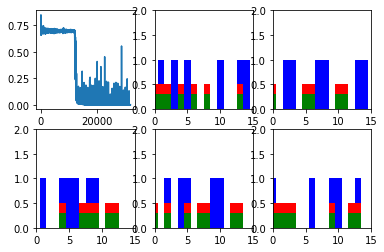

Step 600 Loss 0.000607933
single_output_series: [1 0 1 1 0 1 0 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 1 1 0 1 0 0 1]

single_output_series: [0 1 0 1 1 1 0 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 1 1 0 0 1 0]

single_output_series: [0 0 0 1 1 0 1 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 0 1 0 0 0 1 0]

single_output_series: [1 0 1 1 1 0 1 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 1 1 1 0 1 1]

single_output_series: [1 0 0 1 0 1 1 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 0 0 1 0 0 0]



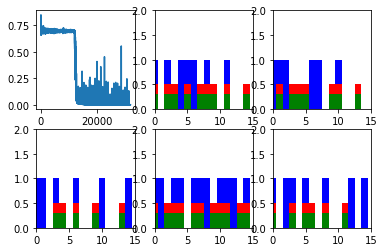

New data, epoch 48
Step 0 Loss 0.238953
single_output_series: [1 0 1 1 1 1 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 1 0 1 1 1 0]

single_output_series: [0 0 1 0 0 1 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 1 0 0 1 0 0]

single_output_series: [1 0 1 1 0 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 1 0 1 1 0 0]

single_output_series: [0 0 1 0 0 1 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 1 1 0 1 0 1]



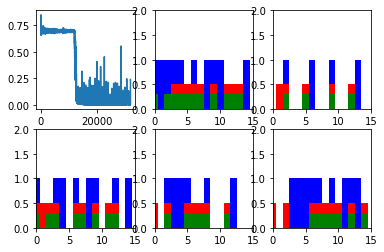

Step 100 Loss 0.000604679
single_output_series: [0 0 0 1 1 1 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 0 1 0 1 1]

single_output_series: [0 1 0 1 0 0 1 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 0 1 1 0 1 0 0]

single_output_series: [0 1 0 1 0 1 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 0 0 1 1 1 1 0]

single_output_series: [1 0 1 0 0 1 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 0 0 1 1 1 0 0]

single_output_series: [0 0 1 1 1 0 1 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 1 0 0 0 1 0 0]



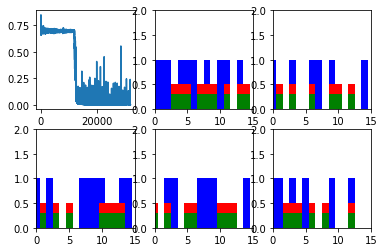

Step 200 Loss 0.00053323
single_output_series: [1 0 1 1 0 0 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 1 0 1 1 1]

single_output_series: [0 1 0 0 1 0 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 1 0 0 1 0]

single_output_series: [1 0 0 0 0 0 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 1 1 0 0 0 1]

single_output_series: [0 1 1 0 1 1 0 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 0 1 1 0 0 1 1]

single_output_series: [1 0 0 0 1 0 0 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 1 1 1 0 1 0 0]



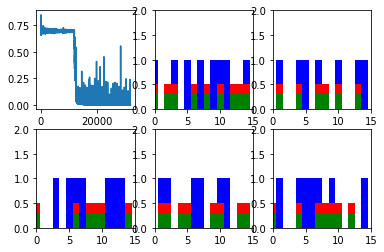

Step 300 Loss 0.00055366
single_output_series: [1 1 1 1 0 0 0 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 1 0 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 0 1 1 1 1 0]

single_output_series: [0 0 1 1 1 1 0 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 0 1 0 1 0 0]

single_output_series: [1 0 0 1 0 0 1 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 1 0 0 0 1 1 1]

single_output_series: [1 1 0 0 0 0 1 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 1 1 1 1 0 1]



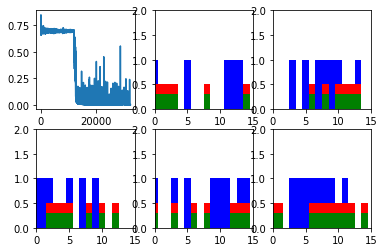

Step 400 Loss 0.000544516
single_output_series: [0 0 1 0 1 1 0 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 1 0 1 1 1 0 1]

single_output_series: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

single_output_series: [0 0 0 1 0 1 0 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 0 0 1 1 0 1]

single_output_series: [1 0 0 1 0 1 1 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 0 0 1 0 0 1]

single_output_series: [0 1 0 1 0 0 1 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 1 1 0 0 0]



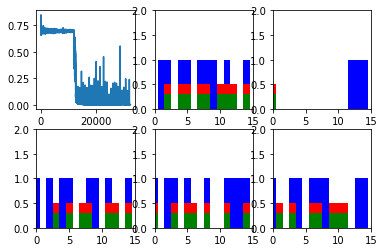

Step 500 Loss 0.000504497
single_output_series: [0 1 1 0 1 1 1 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 0 1 0 1 0 1 0]

single_output_series: [0 0 1 0 0 0 0 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 1 1 1 0 0 1 1]

single_output_series: [0 1 1 1 0 1 1 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 1 1 0 0 0 1]

single_output_series: [1 0 1 1 0 1 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 0 0 1 1 1 0]

single_output_series: [1 0 1 0 0 1 1 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 0 0 1 1 0 0 1]



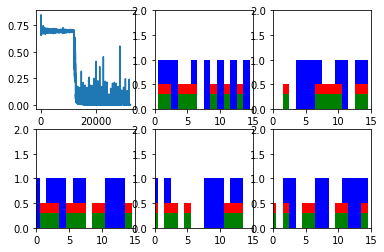

Step 600 Loss 0.00053622
single_output_series: [1 1 0 1 0 1 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 0 0 0 0 1 1]

single_output_series: [0 0 0 1 1 0 0 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 1 1 1 1 1 1]

single_output_series: [1 1 0 0 1 1 0 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 0 0 0 0 0 1]

single_output_series: [1 0 0 1 1 0 1 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 0 0 0 1 0 1]

single_output_series: [1 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 1 1 1 1 0 0 0]



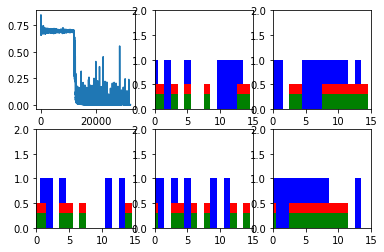

New data, epoch 49
Step 0 Loss 0.22411
single_output_series: [1 0 1 1 0 1 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 0 0 0 1 1 1 0]

single_output_series: [0 0 1 0 0 0 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 1 1 0 0 1 1]

single_output_series: [0 0 1 0 0 1 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 1 0 1 1 0 1]

single_output_series: [0 0 1 0 0 0 0 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 1 0 1 1 1]

single_output_series: [0 0 1 0 0 1 0 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 0 1 0 0 1 0]



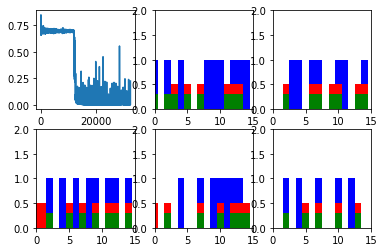

Step 100 Loss 0.000524214
single_output_series: [1 0 0 1 1 1 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 0 0 0 1 0 0]

single_output_series: [0 1 1 0 0 1 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 0 0 1 0 1 0]

single_output_series: [0 1 1 1 0 1 0 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 0 0 0 0 0 0]

single_output_series: [1 1 1 1 0 1 0 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 0 1 0 1 1 1 1]

single_output_series: [0 0 1 1 1 0 0 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 1 1 1 0 0 0]



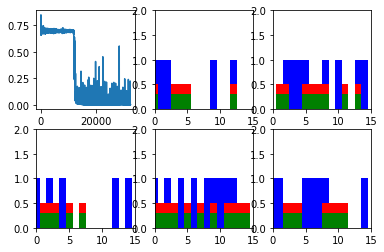

Step 200 Loss 0.000484576
single_output_series: [1 0 0 0 0 1 1 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 1 1 1 1 0 0]

single_output_series: [0 0 1 1 0 0 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 0 1 1 0 0 0]

single_output_series: [0 1 0 0 0 1 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 0 1 1 0 1 0]

single_output_series: [1 0 1 0 0 0 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 0 0 1 0 1 1]

single_output_series: [0 0 0 0 1 0 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 1 0 0 0 1 0]



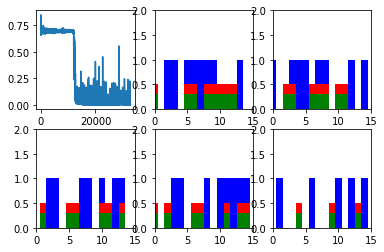

Step 300 Loss 0.000488137
single_output_series: [0 1 1 1 0 0 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 0 1 1 1 0 1 0]

single_output_series: [1 1 0 0 1 0 0 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 0 0 0 0 1 0 1]

single_output_series: [0 0 1 0 0 0 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 1 1 0 1 1 1 1]

single_output_series: [0 1 0 1 0 1 1 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 1 1 1 0 0 0]

single_output_series: [1 1 0 0 0 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 1 0 1 1 0 0]



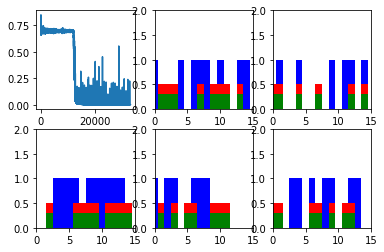

Step 400 Loss 0.000569909
single_output_series: [1 0 0 1 1 1 1 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 1 1 1 1 0 1]

single_output_series: [0 0 0 0 1 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 0 1 0 1 1 1]

single_output_series: [0 0 0 1 0 1 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 0 1 1 0 0]

single_output_series: [0 0 0 0 1 1 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 0 0 0 1 0 1]

single_output_series: [1 1 0 1 0 1 1 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 0 1 0 0 1 0]



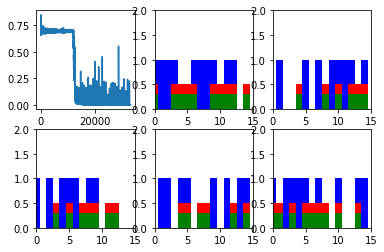

Step 500 Loss 0.000496971
single_output_series: [0 1 1 0 0 0 1 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 1 0 0 1 1 0]

single_output_series: [0 1 1 0 1 0 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 1 1 1 0 1 0]

single_output_series: [0 1 1 1 1 0 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 1 1 0 0 0 1]

single_output_series: [0 0 0 0 1 0 0 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 1 1 0 1 0 1]

single_output_series: [1 0 1 0 0 1 1 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 1 1 1 0 0]



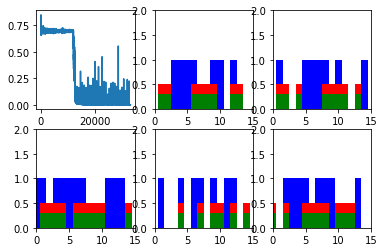

Step 600 Loss 0.000637653
single_output_series: [0 0 1 0 0 1 0 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 1 1 1 0 1 1]

single_output_series: [1 1 0 1 1 1 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 0 0 1 1 0 0]

single_output_series: [0 0 1 0 1 1 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 1 0 1 0 1 1]

single_output_series: [0 0 0 1 1 0 0 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 0 0 1 0 1]

single_output_series: [1 1 0 1 0 1 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 1 1 1 1 1 0 0]



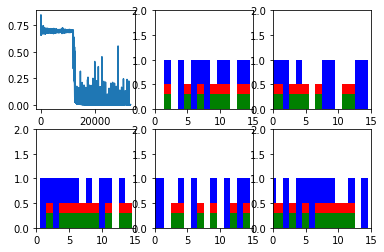

New data, epoch 50
Step 0 Loss 0.214068
single_output_series: [0 1 0 0 1 1 1 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 1 0 0 0 1 0]

single_output_series: [0 1 0 1 1 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 1 1 1 1 1 1]

single_output_series: [0 1 0 0 1 0 0 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 1 1 0 1 1 1]

single_output_series: [0 1 0 1 0 0 1 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 1 0 1 0 1 0 1]

single_output_series: [0 1 0 0 0 0 0 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 0 1 1 1 0 1]



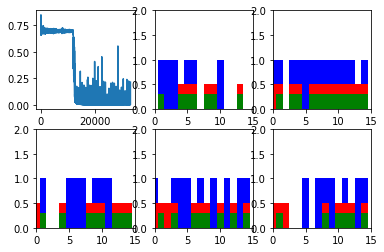

Step 100 Loss 0.000509395
single_output_series: [1 0 0 0 0 0 0 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 1 1 1 0 0 1 0]

single_output_series: [0 1 1 1 1 0 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 0 0 1 1 1 0 0]

single_output_series: [0 1 0 0 0 0 0 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 1 0 0 0 0 0 1]

single_output_series: [1 1 0 1 1 1 0 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 1 1 0 0 0 1]

single_output_series: [1 1 0 1 0 1 0 1 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 1 0 0 0 1 0]



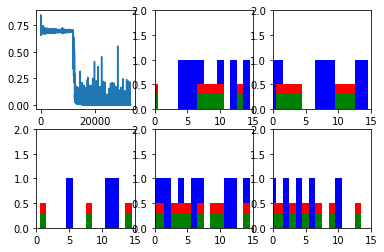

Step 200 Loss 0.000525459
single_output_series: [0 1 1 1 1 0 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 0 1 1 1 0 1]

single_output_series: [1 1 0 1 0 0 0 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 0 0 1 0 1 0]

single_output_series: [0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]

single_output_series: [0 1 1 0 1 0 0 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 0 1 1 0 1 0]

single_output_series: [1 1 1 0 0 0 1 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 1 0 0 0 1 1]



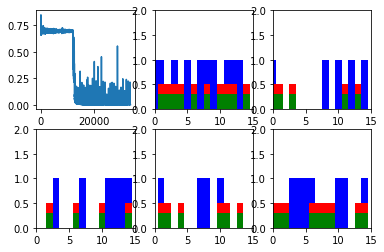

Step 300 Loss 0.000515258
single_output_series: [1 1 0 1 0 0 0 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 1 1 0 1 1 0 1]

single_output_series: [0 0 1 0 1 0 1 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 1 1 1 0 1 1 0]

single_output_series: [0 0 0 0 1 1 1 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 1 1 0 1 0 1]

single_output_series: [0 0 0 1 1 0 1 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 1 0 1 0 1 1]

single_output_series: [1 1 0 1 1 0 1 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 0 0 1 1 1 1]



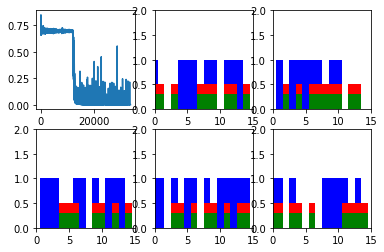

Step 400 Loss 0.000468824
single_output_series: [0 0 1 1 0 1 1 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 0 0 0 1 1 0]

single_output_series: [1 0 0 1 0 1 0 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 1 0 0 0 0 1]

single_output_series: [0 0 0 0 1 0 1 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 1 1 1 0 1 1]

single_output_series: [1 0 1 1 1 1 1 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 0 1 1 1 1 0]

single_output_series: [0 1 0 0 0 1 1 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 1 0 0 0 1 0 1]



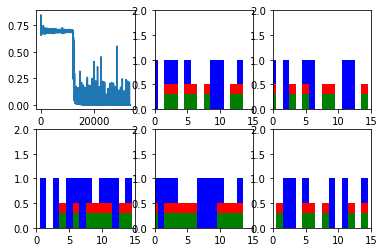

Step 500 Loss 0.000535406
single_output_series: [1 1 0 0 0 0 1 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 1 0 1 1 0 0]

single_output_series: [1 0 1 1 0 0 1 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 1 0 1 0 1 1]

single_output_series: [0 0 0 1 0 0 1 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 1 1 1 1 0 1]

single_output_series: [0 0 1 0 1 1 0 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 0 1 1 1 1 0 1]

single_output_series: [1 0 0 0 1 1 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 1 1 0 0 1 0]



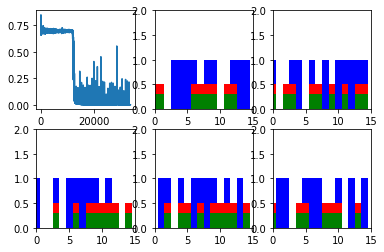

Step 600 Loss 0.000530536
single_output_series: [1 1 1 1 0 0 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 0 1 0 1 1 0 1]

single_output_series: [1 1 0 1 1 1 0 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 0 1 1 0 1 1]

single_output_series: [1 0 0 0 1 1 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 0 1 1 1 1 1 0]

single_output_series: [1 0 1 0 1 1 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 0 1 1 1 1 0 1]

single_output_series: [1 1 0 1 0 1 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 0 1 1 0 1 0]



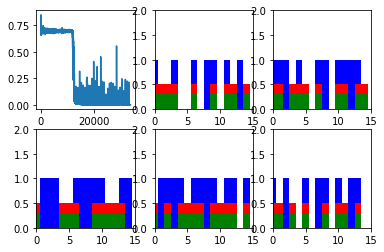

New data, epoch 51
Step 0 Loss 0.144661
single_output_series: [0 0 0 0 0 1 1 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 0 1 1 0 1 0]

single_output_series: [0 0 0 1 0 0 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 1 0 0 1 0 0]

single_output_series: [0 0 0 0 0 0 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 0 0 1 0 0 1]

single_output_series: [0 0 0 0 0 1 0 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 1 0 1 1 1 1]

single_output_series: [0 0 0 1 0 0 0 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 1 1 1 1 0 0 0]



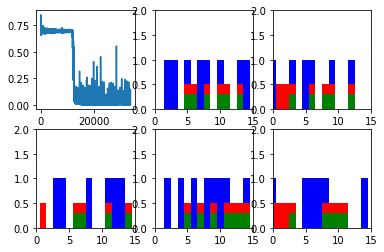

Step 100 Loss 0.000463869
single_output_series: [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0]

single_output_series: [0 0 1 1 0 0 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 0 0 0 1 1 0]

single_output_series: [1 1 0 0 0 0 0 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 0 1 1 0 0 1 0]

single_output_series: [0 0 0 1 0 0 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 0 0 1 1 1 0]

single_output_series: [1 1 0 1 0 1 0 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 0 0 1 1 1 1]



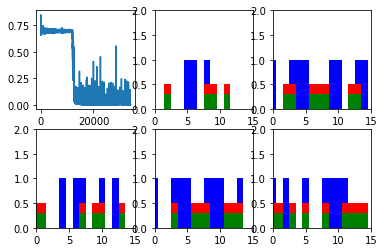

Step 200 Loss 0.000591308
single_output_series: [0 1 1 0 1 0 0 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 1 0 1 0 1 0]

single_output_series: [0 1 0 1 1 0 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 1 0 0 0 0 1 0]

single_output_series: [0 1 0 1 1 1 1 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 0 0 0 0 1 1 0]

single_output_series: [0 1 0 1 0 0 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 1 1 1 1 0 0 0]

single_output_series: [0 0 0 0 1 1 0 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 1 0 1 0 0 0 0]



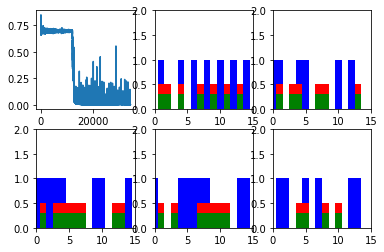

Step 300 Loss 0.000505054
single_output_series: [1 0 1 1 1 0 1 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 1 1 0 1 0 0 0]

single_output_series: [0 0 1 1 1 0 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 0 1 0 1 0 0]

single_output_series: [1 0 0 0 0 1 0 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 1 1 0 1 0 0]

single_output_series: [0 1 1 1 1 0 0 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 0 1 1 1 1 0]

single_output_series: [1 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 1 1 1 0 0 0]



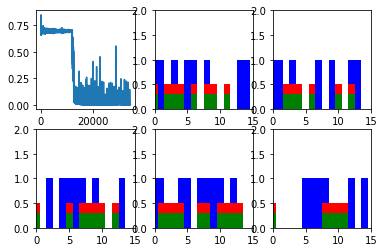

Step 400 Loss 0.000586945
single_output_series: [0 0 1 1 0 1 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 1 0 1 1 0 0]

single_output_series: [1 0 1 1 1 1 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 0 1 0 1 0]

single_output_series: [1 1 1 0 1 1 1 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 1 0 1 0 1 1]

single_output_series: [0 1 0 0 0 0 1 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 0 1 0 0 0 0]

single_output_series: [0 0 0 1 0 1 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 0 1 1 0 0 0]



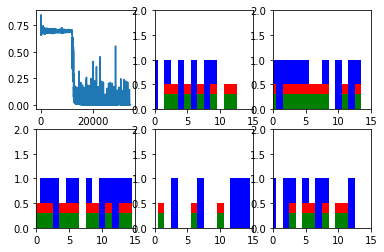

Step 500 Loss 0.000492075
single_output_series: [1 0 0 1 0 0 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 0 0 1 1 1 1 1]

single_output_series: [0 1 1 1 0 0 1 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 1 1 0 0 1 0 1]

single_output_series: [0 1 1 1 1 0 0 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 1 0 0 1 0 1 1]

single_output_series: [1 0 0 1 0 1 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 0 1 1 0 0]

single_output_series: [1 0 0 0 0 1 1 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 1 1 0 1 0 1 0]



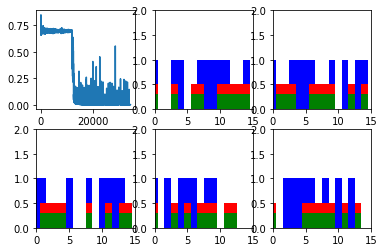

Step 600 Loss 0.000539188
single_output_series: [0 0 1 0 1 1 0 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 1 1 0 1 0 1]

single_output_series: [1 1 0 1 1 1 1 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 0 0 1 0 0 1]

single_output_series: [0 1 1 0 1 1 0 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 1 0 1 0 0]

single_output_series: [0 0 0 1 0 1 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 0 1 1 0 1 1 1]

single_output_series: [0 1 0 1 1 1 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 1 1 1 0 0 1]



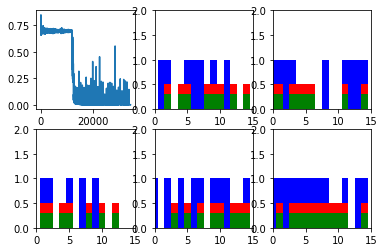

New data, epoch 52
Step 0 Loss 0.13138
single_output_series: [1 0 1 1 1 0 0 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 0 1 1 0 1 1]

single_output_series: [0 1 0 0 1 0 1 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 0 1 1 0 1 1]

single_output_series: [1 0 1 1 0 1 1 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 1 1 0 1 0 0 1]

single_output_series: [0 1 0 0 1 1 1 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 0 1 1 1 0 1]

single_output_series: [1 0 1 1 0 0 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 1 0 1 1 0 1]



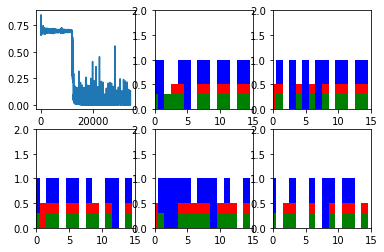

Step 100 Loss 0.000451933
single_output_series: [1 1 1 0 0 0 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 1 0 1 0 0 1]

single_output_series: [0 1 1 1 0 0 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 0 0 1 1 1 0]

single_output_series: [1 0 0 1 0 1 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 0 0 0 1 1 0]

single_output_series: [0 1 1 1 1 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 0 1 1 0 1 1]



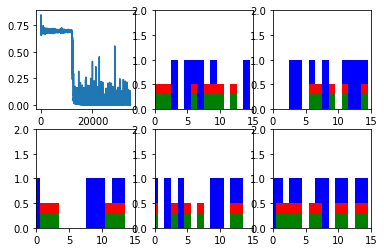

Step 200 Loss 0.000469766
single_output_series: [1 0 1 0 1 1 0 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 0 1 1 1 0 0 1]

single_output_series: [1 0 1 1 0 0 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 1 0 0 1 1 1 1]

single_output_series: [0 0 0 0 0 1 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 1 1 1 1 0 1]

single_output_series: [1 0 0 1 0 0 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 0 0 0 1 1 1 1]

single_output_series: [0 0 1 1 0 1 1 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 0 0 0 1 0 0]



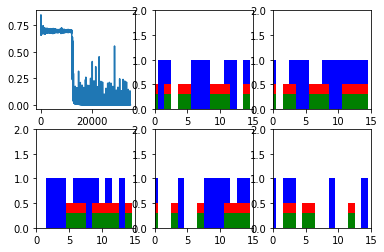

Step 300 Loss 0.000468233
single_output_series: [1 1 1 0 1 0 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 1 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 1 0 0 1 1 0]

single_output_series: [1 0 1 0 1 1 1 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 0 1 1 0 1 1]

single_output_series: [1 1 0 1 1 1 0 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 1 0 0 1 1 1]

single_output_series: [1 0 0 0 1 0 0 0 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 0 0 1 0 1 1 0]



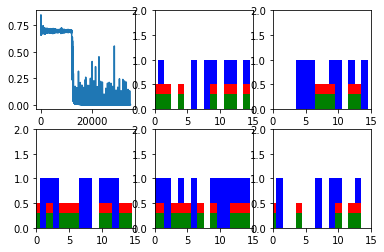

Step 400 Loss 0.00043719
single_output_series: [1 1 0 0 0 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 0 1 0 1 0 0 0]

single_output_series: [1 1 0 0 0 0 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 1 0 1 1 0 0]

single_output_series: [1 1 0 1 0 1 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 1 0 0 0 0 1 0]

single_output_series: [1 0 1 0 0 0 1 0 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 1 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 1 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 0 0 0 1 0 0]



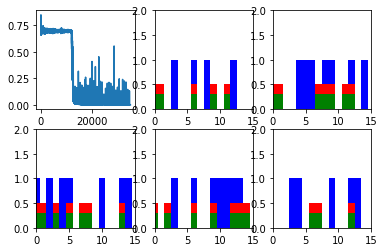

Step 500 Loss 0.000399518
single_output_series: [0 0 1 0 0 1 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 1 0 0 0 0 1]

single_output_series: [0 0 0 0 1 0 0 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 1 1 1 0 1 1]

single_output_series: [1 0 1 1 0 0 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 1 1 0 1 1 0]

single_output_series: [0 0 0 1 0 0 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 0 0 0 1 1 0]

single_output_series: [0 0 0 0 1 1 0 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 1 0 1 1 0]



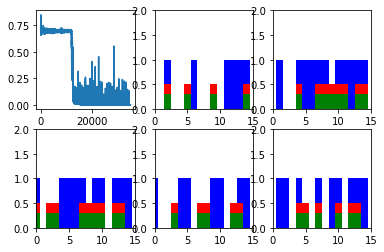

Step 600 Loss 0.000455545
single_output_series: [0 1 0 1 1 0 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 1 0 0 1 0 1]

single_output_series: [0 1 0 1 0 0 1 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 1 0 1 1 0 1 0]

single_output_series: [0 0 1 0 0 1 0 1 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 1 1 1 0 0 1]

single_output_series: [0 0 1 0 0 0 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 0 0 0 1 1 1]

single_output_series: [1 0 0 1 1 1 1 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 1 0 1 0 0 1]



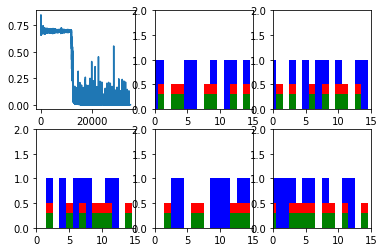

New data, epoch 53
Step 0 Loss 0.318603
single_output_series: [0 1 0 0 0 1 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]

single_output_series: [0 1 0 0 1 1 0 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 0 0 1 1 0 0]

single_output_series: [0 1 0 1 1 1 1 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 1 1 1 0 0 0]

single_output_series: [0 1 0 1 1 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 1 0 0 0 1]

single_output_series: [0 1 0 0 1 0 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 1 1 1 1 0 1]



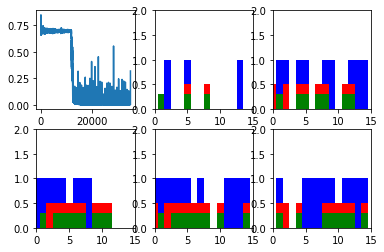

Step 100 Loss 0.000509278
single_output_series: [1 0 0 0 0 1 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 0 0 1 1 0 0 0]

single_output_series: [0 0 0 1 0 0 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 1 0 0 1 1 1]

single_output_series: [0 0 1 0 0 0 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 1 1 0 1 1 1]

single_output_series: [1 1 0 1 1 1 1 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 1 0 0 1 0 1 0]

single_output_series: [0 0 1 0 0 0 1 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 0 1 1 1 1 1]



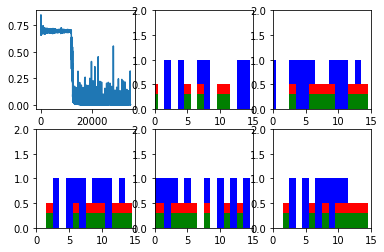

Step 200 Loss 0.000424728
single_output_series: [1 1 1 1 1 1 1 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 1 0 1 1 1 0 0]

single_output_series: [0 1 0 1 0 1 0 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 0 0 1 0 0]

single_output_series: [1 1 1 0 1 1 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 0 0 0 0 1 1 1]

single_output_series: [0 0 1 1 0 1 1 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 0 1 1 1 1 0]

single_output_series: [1 1 0 0 0 1 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 0 1 0 1 0 0]



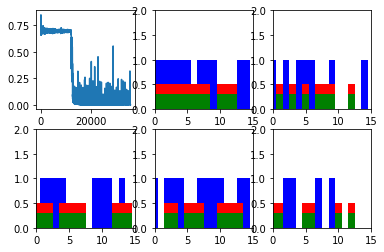

Step 300 Loss 0.000473954
single_output_series: [0 1 1 1 1 1 0 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 1 0 1 1 1 0 1]

single_output_series: [1 1 0 0 0 1 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 0 1 0 1 1 0 1]

single_output_series: [1 0 0 1 1 0 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 1 0 0 1 0 1]

single_output_series: [1 0 1 1 0 1 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 0 0 0 0 1]

single_output_series: [1 0 0 0 0 1 0 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 0 0 0 1 0 1 0]



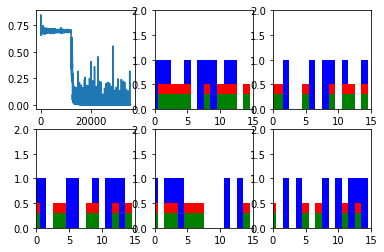

Step 400 Loss 0.000374642
single_output_series: [1 0 1 1 1 1 1 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 1 0 0 1 0 0]

single_output_series: [0 1 1 1 1 0 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 0 1 0 1 0 0]

single_output_series: [1 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 0 0 1 0 0 0]

single_output_series: [1 0 1 1 1 1 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 1 1 0 0 0 1]

single_output_series: [1 1 0 0 0 1 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 0 0 0 0 0 0]



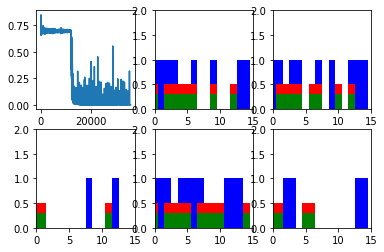

Step 500 Loss 0.000419976
single_output_series: [1 1 0 1 0 0 0 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 1 1 1 0 0 0 0]

single_output_series: [0 1 1 1 0 0 1 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 1 1 1 1 0 0 0]

single_output_series: [1 0 1 1 1 1 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 1 0 1 0 1 1]

single_output_series: [0 0 1 1 1 0 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 0 0 0 1 0 1 1]

single_output_series: [1 1 1 0 0 0 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 0 1 1 1 1 0]



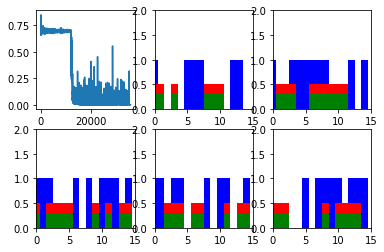

Step 600 Loss 0.000432297
single_output_series: [0 1 0 1 0 0 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 0 0 1 0 0 1]

single_output_series: [0 0 1 1 0 0 1 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 1 1 0 0 0 0]

single_output_series: [1 0 0 1 0 1 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 0 0 1 0 1 1]

single_output_series: [1 0 1 0 0 1 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 0 1 0 0 0]

single_output_series: [1 0 0 1 0 1 1 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 0 1 0 1 1 1 0]



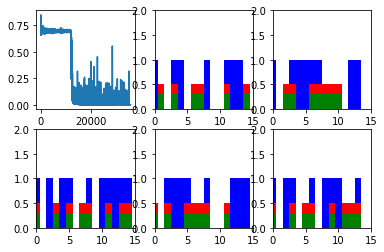

New data, epoch 54
Step 0 Loss 0.396079
single_output_series: [1 0 1 0 0 1 1 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 0 0 0 0 0 1]

single_output_series: [1 0 1 0 1 1 1 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 1 1 0 1 0]

single_output_series: [1 0 1 0 1 1 1 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 0 0 0 0 1 1]

single_output_series: [1 0 1 1 1 1 0 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 0 1 1 1 1 1]

single_output_series: [1 0 1 0 0 1 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 0 0 1 1 1 0]



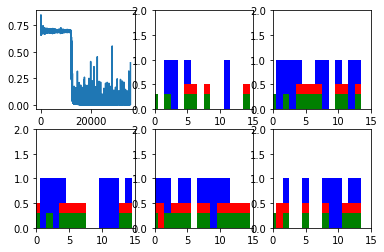

Step 100 Loss 0.000480135
single_output_series: [0 0 0 1 0 1 0 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 1 1 0 1 1 1]

single_output_series: [0 0 1 0 0 0 0 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 0 1 1 1 0 1]

single_output_series: [0 1 1 0 0 1 0 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 0 1 1 0 0 0]

single_output_series: [0 1 0 1 0 0 1 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 1 1 1 0 0]

single_output_series: [0 0 1 1 0 1 0 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 1 1 0 1 0 1 0]



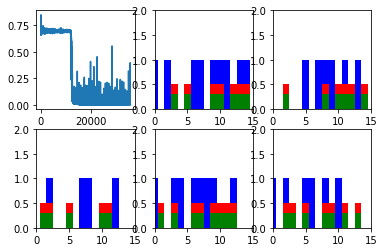

Step 200 Loss 0.000392669
single_output_series: [0 1 0 0 1 1 0 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 1 0 1 1 1 1 0]

single_output_series: [0 1 1 1 1 0 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 1 1 0 0 1 0 0]

single_output_series: [0 0 1 1 0 1 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 1 1 0 1 0 0]

single_output_series: [1 1 0 0 1 0 1 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 0 0 1 1 1 1]

single_output_series: [1 0 1 1 1 0 1 0 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 0 1 0 1 1 0]



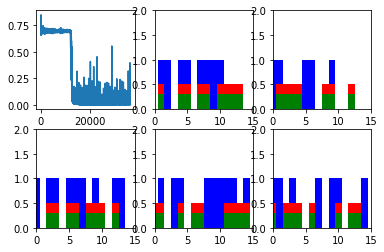

Step 300 Loss 0.000372125
single_output_series: [0 0 0 1 1 0 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 0 0 1 1 0 1]

single_output_series: [1 1 0 0 1 1 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 1 1 0 0 0 1]

single_output_series: [0 0 1 0 1 1 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 1 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 1 1 1 0 1 1]

single_output_series: [0 0 0 1 1 1 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 0 1 1 1 0]



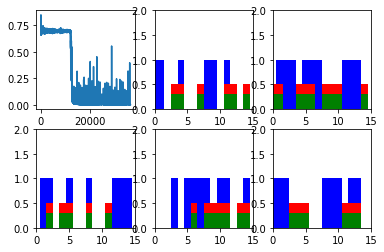

Step 400 Loss 0.000456133
single_output_series: [1 1 1 0 0 0 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 0 1 0 1 0 0]

single_output_series: [0 0 1 0 1 0 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 1 0 1 1 1 0]

single_output_series: [1 0 1 1 1 0 1 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 1 1 0 1 1 1]

single_output_series: [0 0 0 1 0 1 1 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 1 0 0 0 0 0]

single_output_series: [0 0 1 1 1 1 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 1 0 0 0 0]



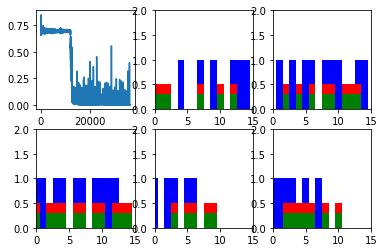

Step 500 Loss 0.000419791
single_output_series: [1 0 0 1 0 1 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 1 1 1 0 0 0 1]

single_output_series: [1 0 0 1 1 1 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 1 1 0 1 1 1]

single_output_series: [0 0 1 1 1 0 1 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 0 1 1 0 1 1 1]

single_output_series: [0 1 1 0 0 1 0 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 1 1 1 1 0 0]

single_output_series: [0 0 0 1 1 1 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 0 0 0 1 1]



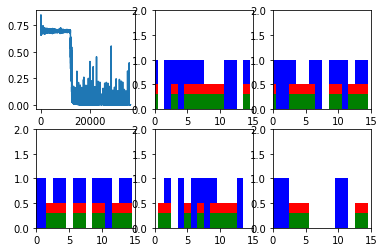

Step 600 Loss 0.000375921
single_output_series: [0 1 0 1 1 0 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 0 1 1 0 0 0 0]

single_output_series: [0 0 1 1 1 0 0 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 1 0 0 0 1 0]

single_output_series: [0 1 0 0 0 1 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 0 0 0 1 1 1 1]

single_output_series: [0 0 1 1 1 0 0 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 0 1 0 0 0 0]

single_output_series: [1 0 0 0 1 1 0 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 0 0 0 0 1 0 1]



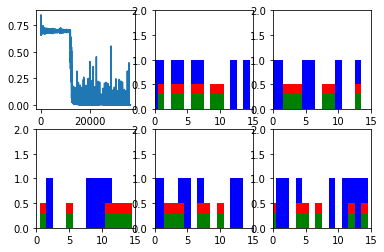

New data, epoch 55
Step 0 Loss 0.143143
single_output_series: [0 0 0 0 1 1 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 1 1 1 0 1 0]

single_output_series: [0 0 1 1 0 1 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 1 0 0 0 1 0 0]

single_output_series: [0 0 1 1 0 1 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 1 1 1 0 0 1 0]

single_output_series: [0 0 1 1 1 0 1 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 1 0 0 1 1 1 1 0]

single_output_series: [0 0 1 1 1 0 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 0 1 0 0 1 0 0]



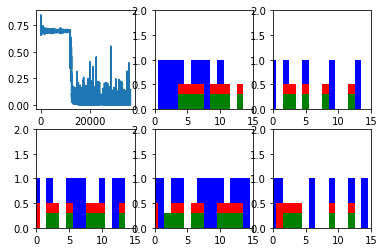

Step 100 Loss 0.000402658
single_output_series: [1 1 1 0 1 0 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 1 1 0 0 0 1]

single_output_series: [1 1 1 1 1 0 1 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 1 1 0 0 1 1 0]

single_output_series: [1 0 1 1 1 1 0 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 0 1 0 0 0 1]

single_output_series: [1 0 0 0 0 1 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 1 1 0 0 1 0 1]

single_output_series: [1 1 0 0 1 1 0 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 0 0 0 0 1 0]



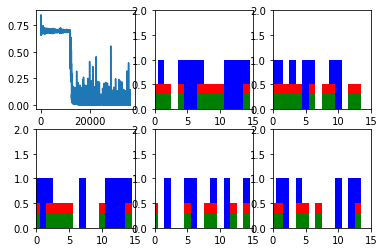

Step 200 Loss 0.000419405
single_output_series: [0 0 0 1 1 1 1 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 1 1 1 0 0]

single_output_series: [0 0 0 1 1 0 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 1 0 1 1 1]

single_output_series: [0 0 1 1 0 1 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 1 1 0 1 0 1 1]

single_output_series: [0 0 1 1 0 1 0 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 1 1 0 0 0 1 0]

single_output_series: [1 0 0 0 1 0 1 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 0 1 1 1 0 1]



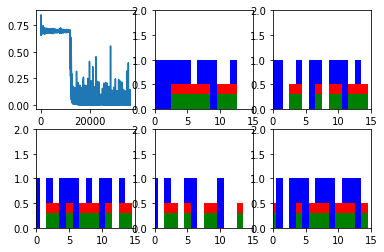

Step 300 Loss 0.000454551
single_output_series: [1 0 1 1 1 0 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 1 1 1 1 1 1 1]

single_output_series: [1 0 0 1 1 0 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 0 1 1 0 0 1]

single_output_series: [0 1 1 0 1 1 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 0 0 1 0 1 1]

single_output_series: [0 0 1 0 0 0 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 0 1 1 0 1 0]

single_output_series: [0 1 1 0 1 0 0 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 0 1 1 1 0 1]



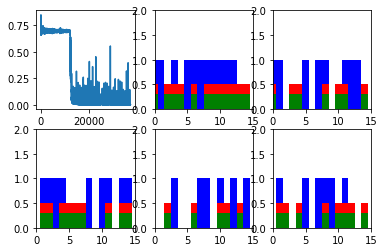

Step 400 Loss 0.000418898
single_output_series: [1 1 0 1 1 1 0 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 1 0 1 0 0 0]

single_output_series: [0 1 1 1 1 0 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 0 1 1 1 0 0]

single_output_series: [1 0 1 0 1 0 1 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 1 0 0 0 1 1 1]

single_output_series: [0 0 0 1 0 0 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 1 1 1 0 0 0]

single_output_series: [1 0 1 1 0 0 0 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 0 0 1 0 1 1]



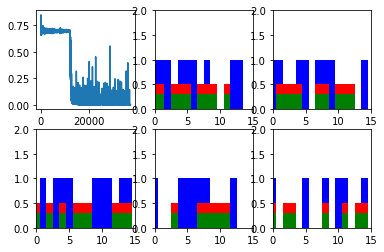

Step 500 Loss 0.000425464
single_output_series: [0 0 1 1 0 0 0 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 1 0 1 0 1 0 1]

single_output_series: [0 0 0 0 1 0 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 0 0 1 0 0 0]

single_output_series: [1 0 0 0 0 0 1 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 0 1 0 1 0 1]

single_output_series: [1 1 1 0 0 0 0 1 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 1 0 0 0 1 0]

single_output_series: [1 0 0 1 1 1 1 1 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 1 1 1 0 0 1]



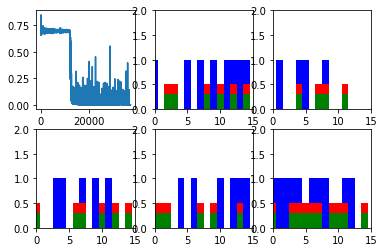

Step 600 Loss 0.000357817
single_output_series: [0 1 0 1 1 0 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 0 0 0 0 0 0 1]

single_output_series: [0 1 1 0 0 0 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 0 0 0 1 0 1]

single_output_series: [1 1 0 1 1 0 0 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 1 1 0 1 0 1]

single_output_series: [0 1 1 0 0 0 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 1 1 0 0 0 0]

single_output_series: [0 1 1 1 1 1 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 0 0 0 1 1]



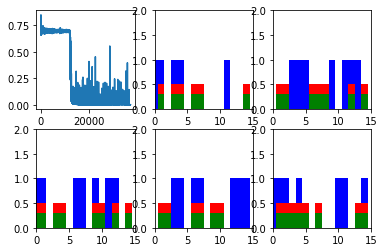

New data, epoch 56
Step 0 Loss 0.146432
single_output_series: [0 1 0 1 0 1 1 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 0 1 0 0 1 1]

single_output_series: [0 0 0 0 1 0 0 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 0 1 0 0 0 1]

single_output_series: [0 0 0 0 1 0 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 1 0 1 1 0 0 1]

single_output_series: [0 1 0 1 1 1 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 1 0 1 0 1 0]

single_output_series: [0 1 0 1 1 0 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 0 1 0 0 0 1 0]



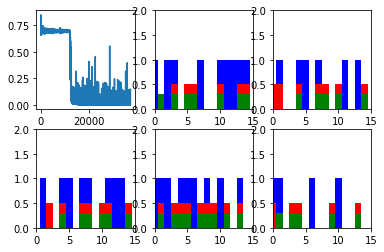

Step 100 Loss 0.000349749
single_output_series: [1 1 1 1 1 0 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 1 1 1 1 0 1 0]

single_output_series: [1 1 1 0 1 1 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 0 0 1 1 1 0 0]

single_output_series: [1 0 1 1 1 0 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 1 1 1 0 0]

single_output_series: [0 0 1 1 1 0 1 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 0 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 1 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 0 0 1 1 1]



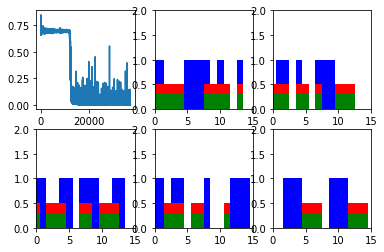

Step 200 Loss 0.00537962
single_output_series: [1 0 1 0 1 0 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 0 0 1 0 1 0 0]

single_output_series: [0 1 1 1 0 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 1 0 1 1 1]

single_output_series: [1 0 1 0 0 0 1 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 0 1 0 1 1 0]

single_output_series: [1 1 1 1 1 0 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 0 1 0 1 1 0 1]

single_output_series: [0 0 1 0 1 1 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 1 1 1 0 1 1]



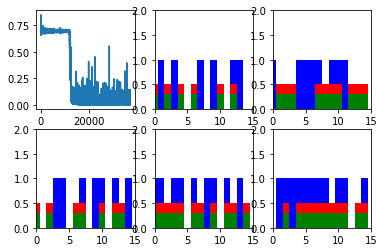

Step 300 Loss 0.000410827
single_output_series: [1 1 1 0 1 1 0 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 0 0 1 1 0 1 1]

single_output_series: [1 0 0 0 0 0 1 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 1 0 0 1 1]

single_output_series: [1 1 0 0 1 1 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 0 1 0 1 0 0 0]

single_output_series: [0 1 0 0 0 1 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 0 1 1 1 0 1 0]

single_output_series: [0 0 1 0 1 0 1 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 0 0 1 0 0 1]



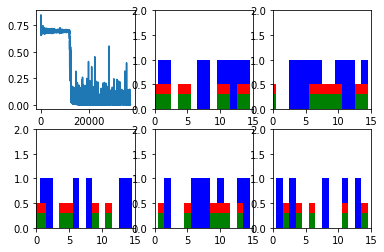

Step 400 Loss 0.000479211
single_output_series: [0 0 1 1 1 0 1 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 0 0 0 0 0 1]

single_output_series: [0 1 1 0 1 0 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 1 0 1 0 0 1]

single_output_series: [0 0 0 1 1 1 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 0 1 0 0 1 1 0]

single_output_series: [0 0 0 0 1 1 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 0 0 0 1 0 1]

single_output_series: [0 0 0 1 1 0 1 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 0 0 1 0 1 1]



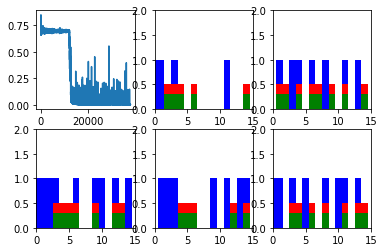

Step 500 Loss 0.000456201
single_output_series: [0 0 0 0 1 0 0 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 1 0 1 1 1 1]

single_output_series: [1 0 0 1 1 0 1 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 1 0 1 0 0 0]

single_output_series: [0 1 1 1 1 0 0 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 1 1 0 1 0 0]

single_output_series: [1 1 1 1 0 1 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 0 0 1 0 1]

single_output_series: [1 1 0 1 0 1 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 0 1 0 1 0 1 1]



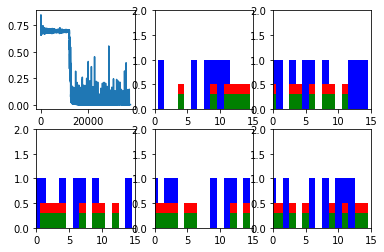

Step 600 Loss 0.000390996
single_output_series: [1 0 1 1 1 0 0 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 1 0 0 1 1]

single_output_series: [0 1 1 0 0 0 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 0 1 0 0 0 1]

single_output_series: [0 0 1 1 0 0 1 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 0 1 1 1 1 0]

single_output_series: [0 0 0 1 1 0 1 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 0 1 0 1 0 0 1]



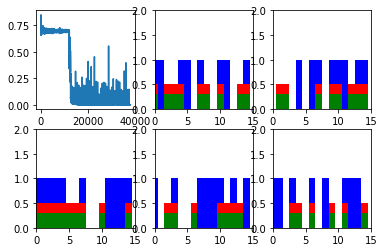

New data, epoch 57
Step 0 Loss 0.145693
single_output_series: [0 0 0 0 0 1 0 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 1 0 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 1 0 0 0 0 1]

single_output_series: [0 1 0 1 1 1 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 1 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 1 1 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 1 0 0 0 1 1]



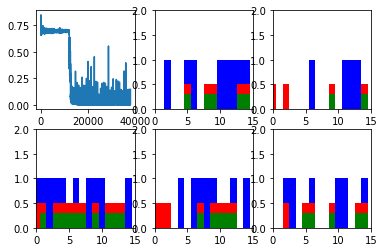

Step 100 Loss 0.000561055
single_output_series: [1 1 1 1 0 1 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 1 1 1 0 1]

single_output_series: [0 1 0 1 1 1 0 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 0 1 0 1 0 0 1]

single_output_series: [0 1 0 1 0 1 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 0 0 0 1 1 1]

single_output_series: [1 1 1 1 0 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 0 1 0 0 1 0]

single_output_series: [1 0 1 1 0 1 1 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 1 1 0 1 0 1]



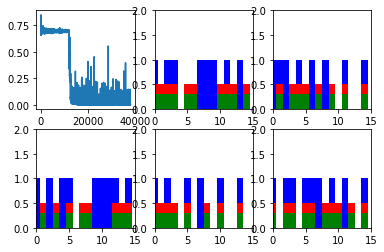

Step 200 Loss 0.000398672
single_output_series: [1 1 0 0 1 1 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 1 0 1 1 0 0]

single_output_series: [0 1 1 0 0 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 0 1 0 0 1 0]

single_output_series: [1 0 1 0 0 0 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 0 1 1 1 1]

single_output_series: [1 1 0 0 0 1 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 1 0 1 0 1 1]

single_output_series: [0 1 0 0 1 0 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 1 1 1 0 0]



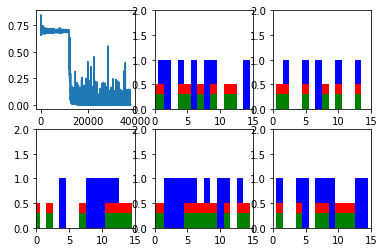

Step 300 Loss 0.000432413
single_output_series: [0 0 1 0 0 0 1 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 1 0 1 1 1 1 1]

single_output_series: [0 0 0 0 1 0 1 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 0 0 0 0 1 1 1]

single_output_series: [0 0 0 1 0 0 0 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 1 1 0 1 0 1 1]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]

single_output_series: [0 1 1 0 0 0 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 0 1 0 1 1 0]



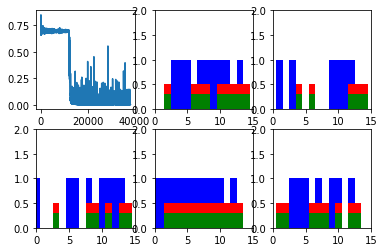

Step 400 Loss 0.000458145
single_output_series: [1 1 1 0 0 0 0 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 1 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 1 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 0 0 1 0 1]

single_output_series: [0 1 0 0 1 0 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 0 0 0 0 1 0 1]

single_output_series: [1 0 0 0 1 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 0 0 1 1 0 1 1]

single_output_series: [1 1 0 1 0 0 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 1 0 0 1 0 0]



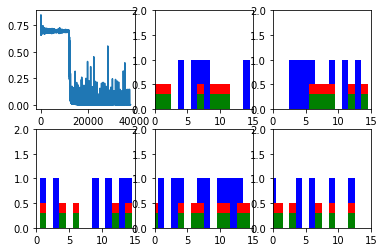

Step 500 Loss 0.000420904
single_output_series: [1 0 1 0 1 1 1 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 0 1 0 0 1 1]

single_output_series: [0 1 1 0 0 0 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 0]

single_output_series: [0 0 0 1 0 1 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 1 1 0 0 0]

single_output_series: [1 1 0 1 1 0 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 0 1 1 0 1 0]

single_output_series: [0 0 0 1 0 1 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 1 1 0 0 1 0]



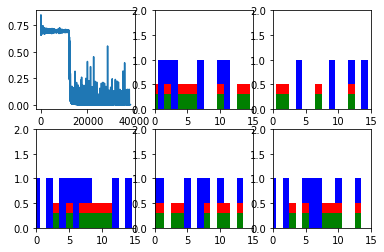

Step 600 Loss 0.000373269
single_output_series: [0 0 0 0 1 0 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 0 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 1 1 0 1 1]

single_output_series: [1 1 0 1 0 0 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 0 0 1 1 1 0]

single_output_series: [1 0 0 1 0 1 0 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 0 0 0 1 0 0]

single_output_series: [0 0 0 0 0 1 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 0 1 1 1 1 1]



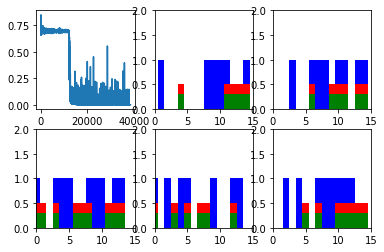

New data, epoch 58
Step 0 Loss 0.322934
single_output_series: [0 1 0 1 0 0 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 1 1 1 0 1 0]

single_output_series: [0 1 0 1 0 0 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 0 0 0 1 0 1]

single_output_series: [0 1 0 1 1 1 0 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 1 1 0 0 1 1 0]

single_output_series: [0 0 1 0 1 1 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 0 0 1 0 0 0]

single_output_series: [0 0 1 0 0 0 0 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 1 1 0 1 0 1 0]



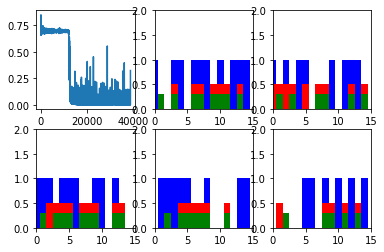

Step 100 Loss 0.000568746
single_output_series: [1 1 0 1 1 0 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 1 1 1 0 1 0]

single_output_series: [0 1 1 0 1 0 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 1 0 1 1 1 0]

single_output_series: [0 1 1 1 0 1 0 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 1 0 0 0 1 0 1]

single_output_series: [1 0 1 0 0 1 0 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 0 1 1 0 1 1]

single_output_series: [0 1 0 0 1 1 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 0 1 1 0 1 1]



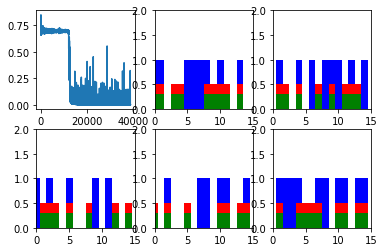

Step 200 Loss 0.000464253
single_output_series: [0 1 1 0 0 1 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 0 0 0 0 0 0 1]

single_output_series: [1 0 1 0 0 1 0 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 0 1 0 0 0 0]

single_output_series: [0 1 0 1 0 0 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 1 0 0 0 0 0]

single_output_series: [0 0 0 1 0 0 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 1 0 0 1 1 0]

single_output_series: [0 0 0 0 1 1 1 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 1 1 0 1 0]



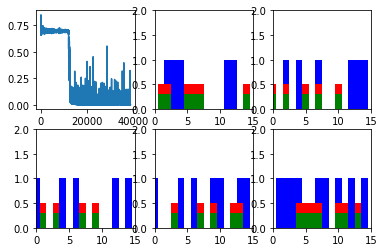

Step 300 Loss 0.00037913
single_output_series: [0 1 1 1 0 1 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 0 1 0 0 1 0 1]

single_output_series: [0 1 0 1 0 0 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 0 1 1 0 0 0]

single_output_series: [0 0 0 1 1 1 1 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 0 1 1 1 1 1]

single_output_series: [0 1 1 0 0 1 0 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 1 1 1 1 0 0]

single_output_series: [0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]



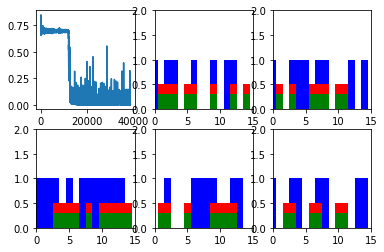

Step 400 Loss 0.000485947
single_output_series: [1 1 0 0 0 1 0 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]

single_output_series: [0 1 0 1 0 1 0 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 0 0 1 0 0 1 1]

single_output_series: [1 1 0 1 1 0 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 0 0 1 1 1 0 0]

single_output_series: [0 1 1 0 1 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 0 0 0 1 1 1 0]



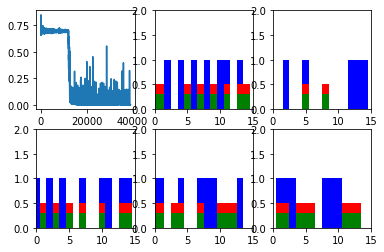

Step 500 Loss 0.000386567
single_output_series: [0 1 1 1 0 0 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 1 1 1 0 0 1 0]

single_output_series: [1 0 0 0 1 1 0 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 1 1 1 1 1 1]

single_output_series: [0 0 1 0 0 1 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 0 0 1 0 0 0 1]

single_output_series: [1 1 0 1 0 0 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 0 0 1 1 1 0 0]

single_output_series: [1 0 1 0 1 1 0 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 0 1 1 0 1 0 0]



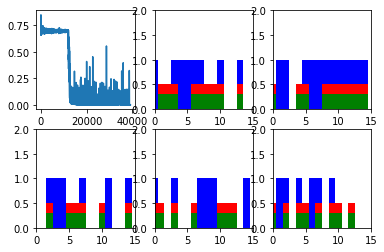

Step 600 Loss 0.000429146
single_output_series: [0 1 1 0 0 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 1 0 0 0 0 1]

single_output_series: [0 1 1 0 0 1 0 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 1 1 0 0 0 0 0]

single_output_series: [1 1 1 1 0 0 0 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 1 1 0 0 1 0]

single_output_series: [0 1 0 0 1 0 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 0 0 1 0 1 1]

single_output_series: [1 1 0 1 0 1 0 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 1 1 1 0 0 0]



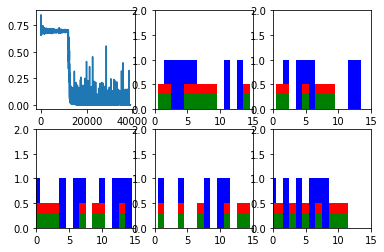

New data, epoch 59
Step 0 Loss 0.468978
single_output_series: [1 0 1 0 0 1 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 1 0 0 1 1 0]

single_output_series: [1 0 1 1 0 0 1 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 1 1 1 1 1 0 1]

single_output_series: [1 0 1 0 0 0 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 1 1 0 1 1 1]

single_output_series: [1 0 1 1 0 0 1 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 0 1 1 0 1 0]

single_output_series: [1 0 1 0 1 0 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 0 0 1 0 1 0]



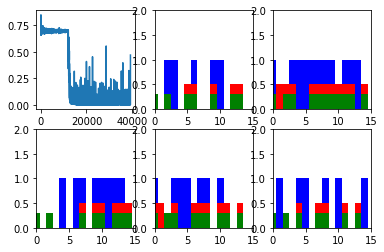

Step 100 Loss 0.00047876
single_output_series: [1 0 0 0 0 0 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 1 0 0 0 1]

single_output_series: [1 1 0 0 1 0 0 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 0 1 0 1 0 1 1]

single_output_series: [1 0 1 1 0 1 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 1 0 0 0 0 1]

single_output_series: [0 1 0 1 0 1 0 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 1 0 0 1 1 1 1]

single_output_series: [0 1 0 0 1 1 0 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 1 1 1 0 1 1]



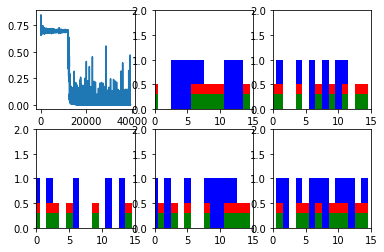

Step 200 Loss 0.000463175
single_output_series: [1 1 0 1 1 0 0 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 1 1 0 1 0 1]

single_output_series: [0 1 0 1 1 1 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 0 0 0 0 1 0]

single_output_series: [1 1 0 1 1 0 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 1 1 1 0 1 1 0]

single_output_series: [0 1 1 0 0 0 1 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 0 1 1 0 0 1]

single_output_series: [1 0 1 1 1 1 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 0 1 0 1 0 0]



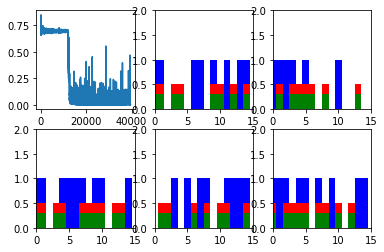

Step 300 Loss 0.000413262
single_output_series: [1 0 0 0 0 1 1 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 1 1 0 1 0 0]

single_output_series: [1 0 0 1 1 1 0 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 1 0 1 1 1 1 0]

single_output_series: [1 1 0 1 0 0 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 1 1 0 0 1 1]

single_output_series: [0 0 1 0 0 1 0 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 0 1 0 1 0 1]

single_output_series: [0 1 0 0 1 0 1 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 0 0 0 1 1 0 1]



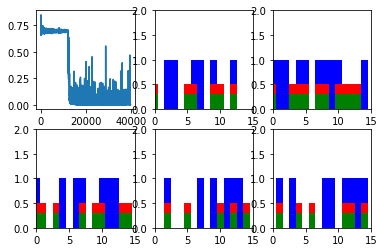

Step 400 Loss 0.000438319
single_output_series: [0 1 1 1 0 0 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 0 1 1 0 1 1 1]

single_output_series: [1 1 1 0 0 1 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 1 0 1 1 0 0]

single_output_series: [1 1 0 0 0 1 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 0 1 0 1 0 1]

single_output_series: [1 0 1 1 0 1 0 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 1 0 0 0 0 1 0]

single_output_series: [1 1 0 1 0 0 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 0 0 0 1 0 0]



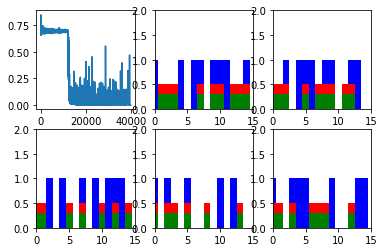

Step 500 Loss 0.000379981
single_output_series: [0 0 1 0 0 1 0 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 0 1 0 0 0 1]

single_output_series: [0 0 0 1 0 1 1 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 0 0 0 0 1 1]

single_output_series: [1 1 0 1 1 1 1 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 1 0 0 0 1 1]

single_output_series: [1 1 1 1 0 0 0 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 1 0 0 1 1]

single_output_series: [0 1 1 0 0 0 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 0 0 1 0 1 0]



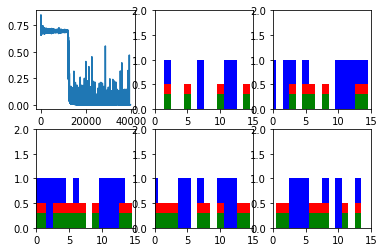

Step 600 Loss 0.00040793
single_output_series: [0 0 1 0 0 0 0 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 0 0 0 1 0 1]

single_output_series: [1 1 0 1 1 1 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 1 0 0 0 0 0]

single_output_series: [0 0 0 1 0 1 0 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 0 0 1 1 1 1]

single_output_series: [0 1 1 0 0 0 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 0 1 0 1 1 0 1]

single_output_series: [0 1 0 0 1 1 1 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 0 0 1 1 0 0]



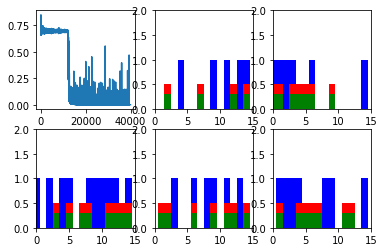

New data, epoch 60
Step 0 Loss 0.325461
single_output_series: [0 0 0 0 0 1 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 1 0 1 1 1 0]

single_output_series: [1 0 1 1 1 0 0 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 0 1 0 1 1 1 0]

single_output_series: [1 0 1 1 0 0 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 1 1 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 1 0 1 0 1 0]

single_output_series: [1 0 1 1 0 0 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 0 1 1 0 1 1 1]



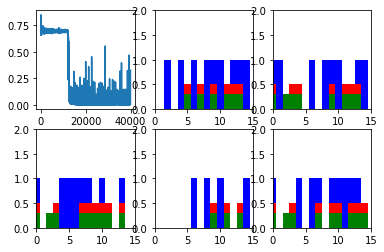

Step 100 Loss 0.000628423
single_output_series: [1 0 1 0 0 0 0 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 1 1 0 1 1 1]

single_output_series: [1 1 0 1 1 1 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 1 0 1 1 1 0]

single_output_series: [1 1 0 0 1 0 1 0 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 1 0 1 1 1 1]

single_output_series: [0 1 1 1 1 0 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 1 0 1 0 0 1 1]

single_output_series: [1 1 0 1 0 0 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 0 1 1 1 0 1]



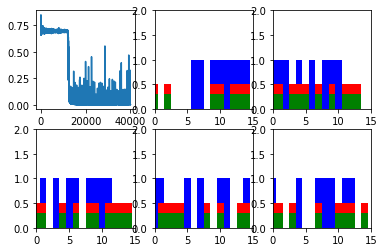

Step 200 Loss 0.000444186
single_output_series: [0 1 0 0 1 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 0 0 1 1 1 0]

single_output_series: [1 1 0 0 1 1 0 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 1 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 0 0 0 0 1 0 0]

single_output_series: [0 1 1 0 1 0 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 1 0 1 0 0 1 1]

single_output_series: [1 1 0 0 1 1 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 1 0 1 1 0 0]



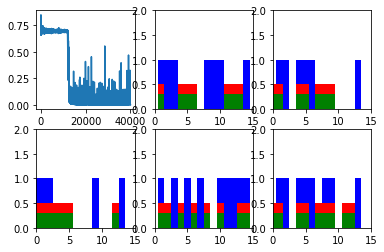

Step 300 Loss 0.000498671
single_output_series: [0 0 1 0 0 1 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 0 1 0 1 0 0]

single_output_series: [1 0 0 1 1 1 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 1 1 0 0 1 0]

single_output_series: [1 0 1 0 1 1 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 0 0 0 0 1 1 1]

single_output_series: [0 1 0 0 1 1 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 0 0 1 1 1 0]

single_output_series: [0 1 0 1 0 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 0 0 1 1 0 0]



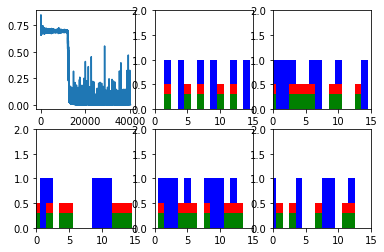

Step 400 Loss 0.000506205
single_output_series: [0 1 0 0 1 1 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 1 1 0 1 0 0 0]

single_output_series: [1 0 0 0 1 0 1 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 0 0 1 1 0 1 1]

single_output_series: [0 1 0 0 1 1 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 0 0 0 1 0 0]

single_output_series: [0 1 1 1 0 1 1 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 0 0 1 0 1 1 1]

single_output_series: [0 1 0 0 0 1 1 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 0 1 0 1 0 1 0]



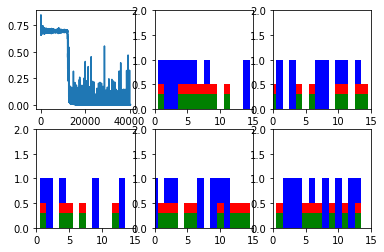

Step 500 Loss 0.000553432
single_output_series: [0 1 1 0 0 1 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 1 1 1 1 1 1 0]

single_output_series: [0 1 1 0 1 0 1 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 1 0 1 1 1 1]

single_output_series: [0 1 1 1 1 0 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 1 1 0 0 0 1]

single_output_series: [1 0 0 0 1 1 0 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 0 1 1 0 0 1 0]

single_output_series: [0 0 1 0 1 0 1 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 0 1 1 0 0 0 1]



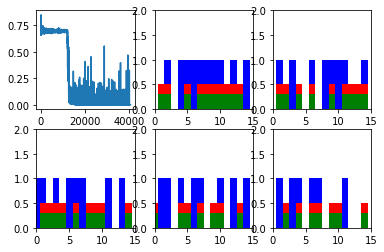

Step 600 Loss 0.000417271
single_output_series: [1 1 1 0 1 1 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 0 1 1 1 1 0 1]

single_output_series: [1 0 0 0 1 0 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 0 1 1 0 0 0]

single_output_series: [1 0 1 1 1 1 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 0 0 0 1 0 1 1]

single_output_series: [1 1 0 0 1 1 1 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 1 1 0 0 0 0]

single_output_series: [0 0 0 1 1 1 0 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 1 0 0 1 1 0]



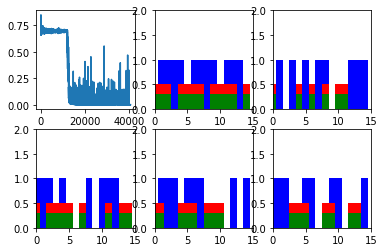

New data, epoch 61
Step 0 Loss 0.181759
single_output_series: [0 0 1 1 1 1 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 0 1 1 1 0]

single_output_series: [0 0 1 1 0 1 0 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 0 0 0 1 0 0 0]

single_output_series: [0 0 1 1 0 0 1 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 0 1 1 1 0 1]

single_output_series: [0 0 1 1 0 1 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 1 0 0 0 1 1]

single_output_series: [0 0 0 0 0 1 1 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 0 1 0 0 1 1]



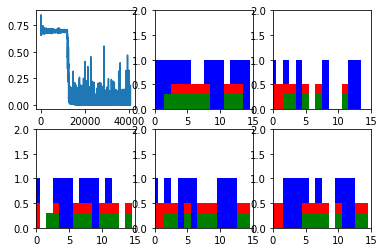

Step 100 Loss 0.000366075
single_output_series: [1 0 1 1 0 0 0 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 1 0 0 0 1 0]

single_output_series: [1 0 1 0 0 0 0 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 1 1 0 0 0 0 1]

single_output_series: [1 1 1 0 1 0 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 1 1 1 0 1 1 0]

single_output_series: [1 1 0 0 1 1 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 1 1 1 0 0 0 1]

single_output_series: [1 1 1 1 1 0 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 0 0 0 1 1 1]



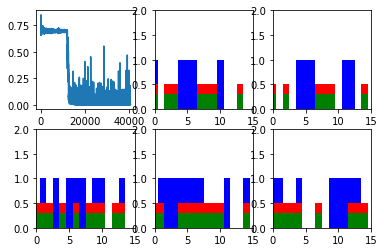

Step 200 Loss 0.000444567
single_output_series: [0 1 0 1 0 1 1 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 1 0 0 0 1 0]

single_output_series: [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0]

single_output_series: [1 1 0 1 1 0 0 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 0 0 1 0 1 0]

single_output_series: [0 0 1 0 1 1 1 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 0 0 1 1 0 0]

single_output_series: [0 1 0 0 1 0 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 1 0 0 1 1 1 1]



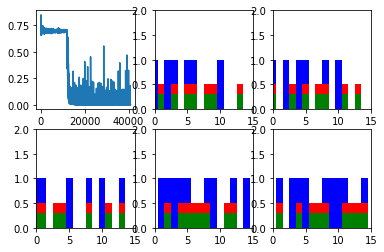

Step 300 Loss 0.000406676
single_output_series: [1 1 1 0 1 1 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 0 0 0 1 1 1 1]

single_output_series: [1 1 1 0 0 1 0 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 1 1 1 1 1 1]

single_output_series: [1 1 0 1 1 0 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 0 1 0 0 0 1]

single_output_series: [0 0 0 1 0 0 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 0 1 0 0 1 0 0]

single_output_series: [1 0 0 1 1 0 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 0 0 1 1 1 0 1]



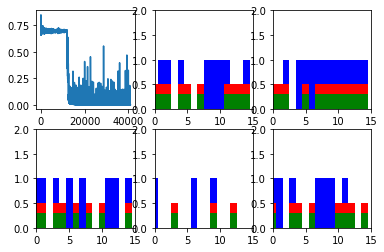

Step 400 Loss 0.000376426
single_output_series: [0 1 1 0 0 1 1 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 1 1 1 0 0 1]

single_output_series: [0 0 0 0 1 1 0 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 1 0 0 1 1]

single_output_series: [0 1 1 0 1 1 1 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 1 0 0 1 0 0 0]

single_output_series: [0 1 1 1 0 1 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 1 1 1 0 0 1 0]

single_output_series: [0 1 1 1 0 0 0 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 1 0 1 0 1]



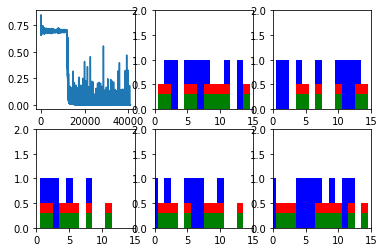

Step 500 Loss 0.000450474
single_output_series: [0 1 1 1 1 1 0 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 1 0 0 1 0]

single_output_series: [0 1 1 0 1 1 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 0 0 1 0 1 0 0]

single_output_series: [1 1 0 0 1 0 1 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 0 0 1 0 1 1]

single_output_series: [0 0 1 0 1 1 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 1 1 1 0 1 1]

single_output_series: [1 1 1 1 0 0 1 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 0 0 0 0 0 1 0]



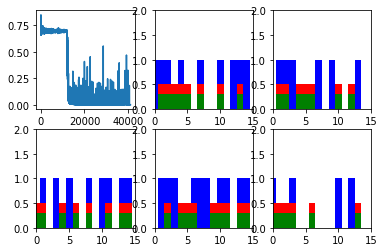

Step 600 Loss 0.000390168
single_output_series: [1 0 0 0 0 1 0 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 0 1 1 1 1 1 1]

single_output_series: [1 1 0 0 1 0 1 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 1 1 0 0 0 0]

single_output_series: [1 1 0 1 1 1 1 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 0 1 0 1 0 0]

single_output_series: [1 1 0 0 0 1 0 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 0 1 1 0 1 1]

single_output_series: [0 0 0 1 1 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 1 0 0 0 1]



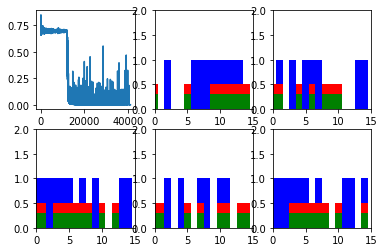

New data, epoch 62
Step 0 Loss 0.378687
single_output_series: [0 1 0 0 1 1 1 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 1 1 0 0 1 1]

single_output_series: [0 1 0 0 1 1 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 0 1 0 1 1 1]

single_output_series: [0 1 0 0 0 0 0 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 1 1 1 0 1 1]

single_output_series: [0 1 0 1 0 0 0 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 1 1 1 0 0 0 0]

single_output_series: [0 1 0 0 0 0 1 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 0 0 1 1 0 0]



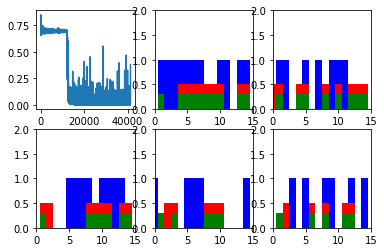

Step 100 Loss 0.000364303
single_output_series: [1 0 1 1 1 1 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 0 1 1 0 0 1 1]

single_output_series: [0 0 1 1 0 0 1 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 1 1 0 1 1 1]

single_output_series: [1 1 1 1 0 1 0 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 0 1 1 1 0 0]

single_output_series: [1 1 1 0 0 1 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 1 0 0 0 1 1]

single_output_series: [1 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 0 0 0 0 0 0 0]



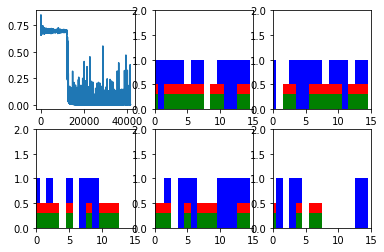

Step 200 Loss 0.000426667
single_output_series: [0 1 1 0 0 0 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 0 0 1 1 1 0 0]

single_output_series: [1 1 1 1 0 1 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 1 0 1 1 1 0]

single_output_series: [1 1 0 0 0 0 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [0 0 0 1 1 0 1 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 0 1 0 1 1 1]

single_output_series: [0 1 1 0 1 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 1 0 1 0 1 0]



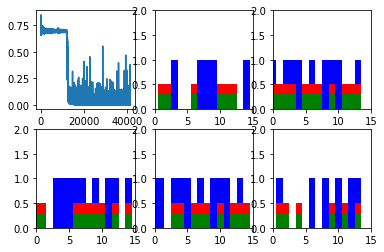

Step 300 Loss 0.000378252
single_output_series: [1 0 0 1 0 1 0 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 0 0 0 1 0 1]

single_output_series: [1 1 0 1 1 1 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 0 0 1 1 1 0]

single_output_series: [0 0 1 1 1 1 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 1 1 0 0 0 1]

single_output_series: [1 1 0 1 1 0 0 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 1 1 0 0 1 1]

single_output_series: [1 1 0 1 1 0 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 0 0 1 0 0 0]



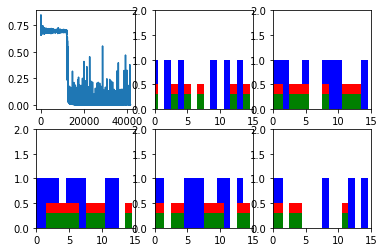

Step 400 Loss 0.000394694
single_output_series: [1 0 1 1 1 1 0 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 1 1 0 0 0 1 0]

single_output_series: [0 0 0 0 1 0 1 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 0 0 0 0 0 1]

single_output_series: [1 0 1 0 0 0 1 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 1 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 1 1 0 1 1 1]

single_output_series: [0 1 0 1 1 1 1 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 1 1 1 1 0 0]



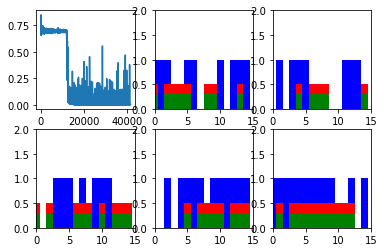

Step 500 Loss 0.000403769
single_output_series: [1 1 1 0 0 1 1 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 0 1 0 1 0 0 1]

single_output_series: [0 1 0 0 1 0 1 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 1 1 1 0 1 1]

single_output_series: [0 1 1 1 1 0 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 0 0 0 0 0 1]

single_output_series: [0 1 0 1 1 1 1 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 1 1 0 0 0 0]

single_output_series: [0 1 0 1 1 0 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 0 1 1 1 1 0]



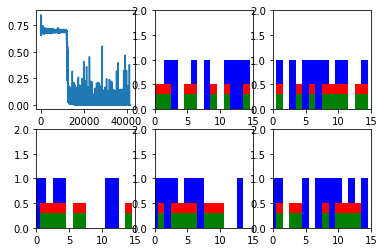

Step 600 Loss 0.000323714
single_output_series: [1 1 1 1 0 1 0 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 1 1 1 1 0 0]

single_output_series: [1 1 1 1 1 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 0 0 1 1 0 0]

single_output_series: [0 0 0 1 0 0 1 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 1 1 0 0 0 0]

single_output_series: [1 0 1 1 0 0 1 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 0 1 0 0 0 1]



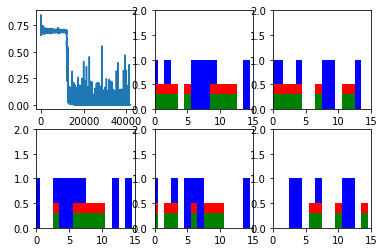

New data, epoch 63
Step 0 Loss 0.33302
single_output_series: [0 1 0 1 0 0 0 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 0 1 0 1 1]

single_output_series: [0 1 0 1 0 1 1 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 1 1 0 1 1]

single_output_series: [0 0 0 0 1 0 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 0 1 0 0 1 0 1]

single_output_series: [0 0 0 0 1 1 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 1 0 0 1 1 1]

single_output_series: [0 1 0 1 0 0 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 1 0 0 1 1]



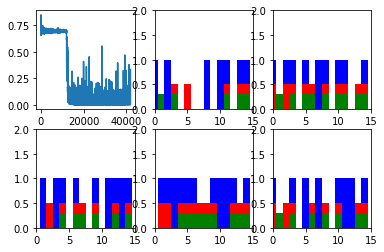

Step 100 Loss 0.000524377
single_output_series: [1 1 0 1 1 0 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 0 0 1 0 1 0]

single_output_series: [1 0 1 0 0 1 1 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 0 1 0 1 0 1]

single_output_series: [0 1 1 1 0 1 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 1 1 0 1 1 0]

single_output_series: [1 0 1 0 0 0 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 1 1 1 0 1]

single_output_series: [1 0 0 0 0 1 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 0 1 0 0 0 1 1]



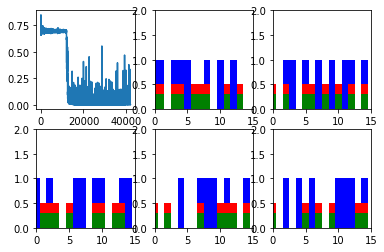

Step 200 Loss 0.000434252
single_output_series: [0 1 1 1 1 0 0 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 0 0 1 0 1 0 0]

single_output_series: [1 1 1 1 1 0 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 1 1 0 1 0 0 0]

single_output_series: [0 0 1 0 0 1 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 0 0 1 1 0 1]

single_output_series: [0 0 0 0 1 0 1 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 1 0 0 0 0 1]

single_output_series: [0 0 1 0 1 0 1 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 0 1 0 0 0 0]



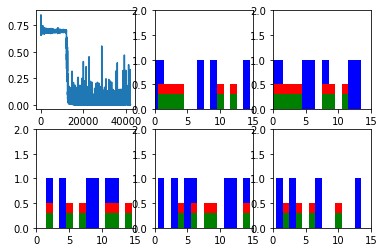

Step 300 Loss 0.000466202
single_output_series: [1 0 1 0 1 0 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 0 0 0 1 0 1]

single_output_series: [0 0 1 0 1 1 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 1 1 0 1 0 1 1]

single_output_series: [1 1 0 0 0 0 1 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 0 1 0 0 0 0 1]

single_output_series: [1 1 1 0 1 1 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 0 0 0 0 0 0]

single_output_series: [1 1 1 0 0 0 0 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 1 1 1 0 0 0]



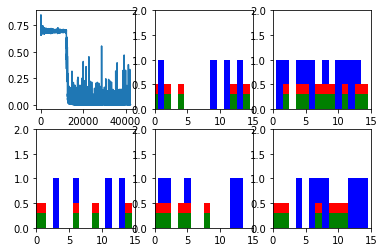

Step 400 Loss 0.000435938
single_output_series: [1 0 1 0 1 1 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 1 0 1 0 0 1 1]

single_output_series: [1 0 0 1 0 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 1 0 1 0 0 0 1]

single_output_series: [0 0 1 1 0 1 1 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 0 1 0 0 1 1]

single_output_series: [0 0 0 0 1 0 0 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 1 1 0 0 1 1]

single_output_series: [1 1 1 1 0 1 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 1 0 1 0 1 0]



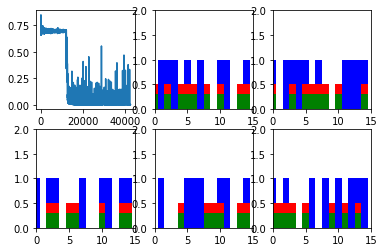

Step 500 Loss 0.000470757
single_output_series: [0 0 1 0 1 0 0 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 1 1 0 0 0 1]

single_output_series: [0 0 0 0 1 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 0 1 0 0 0 0]

single_output_series: [1 1 0 0 1 0 0 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 0 1 1 0 1 1]

single_output_series: [1 1 0 0 1 0 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 0 0 0 0 1 0 0]

single_output_series: [1 0 0 0 0 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 0 1 0 0 0 0]



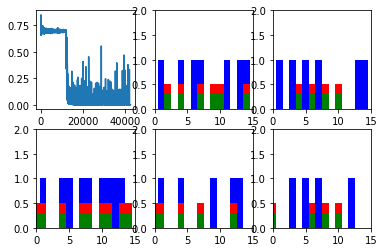

Step 600 Loss 0.000358639
single_output_series: [1 1 0 0 1 1 1 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 0 0 1 1 1 1]

single_output_series: [1 1 0 1 1 1 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 0 1 1 1 1 1]

single_output_series: [1 1 1 0 1 1 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 0 0 0 0 1 1 0]

single_output_series: [1 1 1 0 0 0 1 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 0 0 1 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 0 1 1 0 1 1 0]



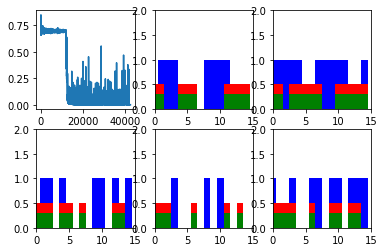

New data, epoch 64
Step 0 Loss 0.229639
single_output_series: [1 0 1 1 1 1 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 1 0 1 1 1 0]

single_output_series: [0 0 1 0 0 0 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 0 0 1 1 0 1]

single_output_series: [1 0 1 1 0 1 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 0 0 0 1 0 1]

single_output_series: [1 0 1 1 0 1 0 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 0 0 0 0 1]

single_output_series: [1 0 1 1 0 1 1 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 1 1 1 0 1 0]



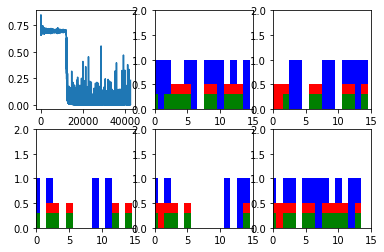

Step 100 Loss 0.000441485
single_output_series: [0 0 0 1 0 1 1 1 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 1 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 1 0 1 1 1 1]

single_output_series: [0 0 1 0 1 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 1 0 1 0 1 0]

single_output_series: [0 0 0 1 1 1 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 0 0 1 1 1 0 0]

single_output_series: [0 0 0 0 1 0 1 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 0 0 1 1 0 0 1]



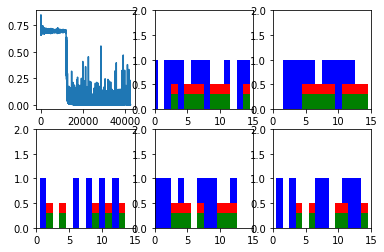

Step 200 Loss 0.000338889
single_output_series: [1 1 1 1 0 0 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 1 0 0 0 0 0 0]

single_output_series: [0 0 1 1 0 1 1 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 1 1 1 1 0 1]

single_output_series: [1 0 1 0 0 0 0 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 1 1 1 0 0 1]

single_output_series: [0 0 0 1 0 0 0 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 1 1 0 0 1 0]

single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]



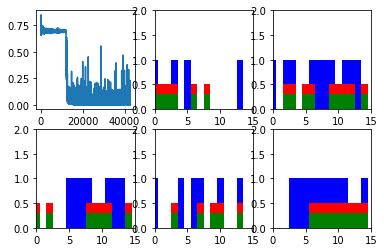

Step 300 Loss 0.000429405
single_output_series: [0 1 0 1 1 1 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 0 1 0 0 0 0 1]

single_output_series: [0 1 1 0 0 0 0 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 0 1 0 1 0]

single_output_series: [0 0 0 0 1 1 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 1 1 1 0 0 0]

single_output_series: [1 0 0 0 0 1 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 0 0 0 1 0 1]

single_output_series: [1 1 0 0 1 0 1 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 1 1 1 0 0 0]



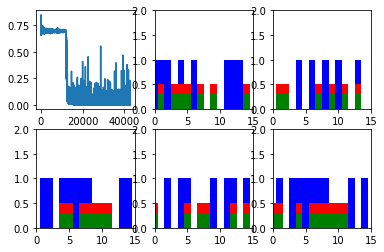

Step 400 Loss 0.000387893
single_output_series: [0 1 0 0 0 0 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 0 1 1 0 1 0 0]

single_output_series: [1 0 1 0 0 0 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 0 0 0 0 0]

single_output_series: [0 1 0 0 0 1 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 0 0 0 0 0 0]

single_output_series: [1 0 1 0 1 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 0 0 1 1 0 0]

single_output_series: [1 1 1 1 0 0 0 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 1 1 1 1 1]



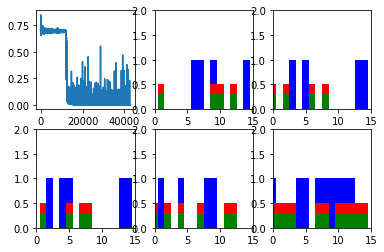

Step 500 Loss 0.000406178
single_output_series: [1 0 1 0 0 1 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 0 0 1 0 1 1]

single_output_series: [1 1 1 0 1 0 1 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 0 0 0 0 0 1]

single_output_series: [1 1 1 0 1 1 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 0 1 1 0 0 1 1]

single_output_series: [0 0 1 0 1 0 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 1 1 0 0 1 1]

single_output_series: [0 1 0 1 1 1 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 1 0 0 1 0 1]



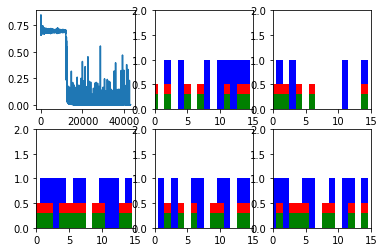

Step 600 Loss 0.000348449
single_output_series: [1 0 0 1 0 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 0 0 1 1 0 1 1]

single_output_series: [1 1 0 1 0 0 1 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 0 1 1 0 0 1]

single_output_series: [1 0 0 0 0 0 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 0 1 1 0 0 1 0]

single_output_series: [1 1 0 1 0 0 0 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 1 0 0 0 0 1 0]

single_output_series: [0 1 0 1 0 0 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 1 0 0 1 1]



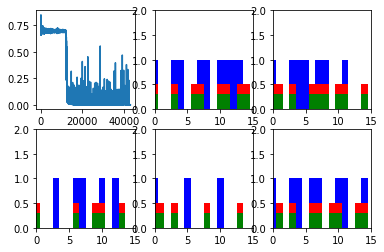

New data, epoch 65
Step 0 Loss 0.14121
single_output_series: [0 1 0 1 0 1 0 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 1 1 0 1 1]

single_output_series: [0 0 1 0 0 1 0 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 1 1 1 0 0 0]

single_output_series: [0 0 1 0 0 0 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 1 0 0 0 1 1]

single_output_series: [0 1 0 1 0 0 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 0 1 1 1 0 1 0]

single_output_series: [0 0 1 0 0 0 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 0 1 0 1 0 1]



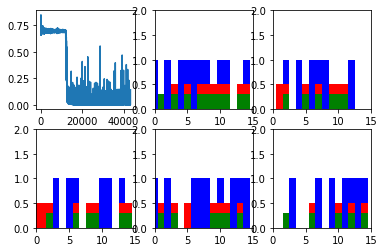

Step 100 Loss 0.000364643
single_output_series: [0 0 1 1 1 1 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 1 1 1 0 0 1]

single_output_series: [0 0 1 1 1 0 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 1 1 1 0 1]

single_output_series: [1 0 1 1 0 1 1 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 0 0 0 0 1 1 1]

single_output_series: [1 0 1 1 1 1 1 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 0 0 1 1 0 0]



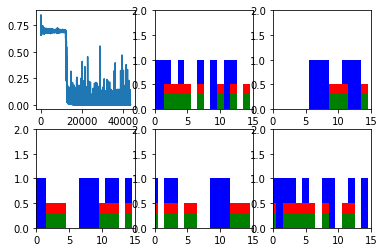

Step 200 Loss 0.000402299
single_output_series: [1 0 1 1 1 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 0 0 1 1 1 0]

single_output_series: [0 0 1 1 1 0 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 0 0 0 1 1 0 1]

single_output_series: [1 0 1 0 0 1 0 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 0 1 1 0 1 0]

single_output_series: [1 0 0 0 0 1 1 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 1 1 1 1 0 0]

single_output_series: [0 0 1 1 1 1 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 1 0 1 1 0 0]



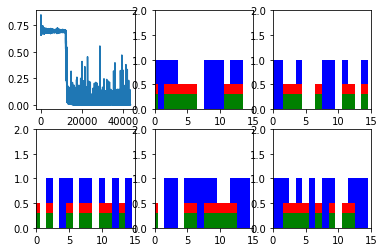

Step 300 Loss 0.000409176
single_output_series: [1 0 1 0 0 1 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 1 0 0 1 0 1]

single_output_series: [0 1 1 1 0 1 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 1 0 1 0 0 1 0]

single_output_series: [0 1 0 0 1 0 0 0 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 1 0 0 1 1 1]

single_output_series: [0 1 1 1 1 0 1 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 1 1 1 0 0 0]

single_output_series: [1 0 1 1 0 1 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 0 0 0 0 0]



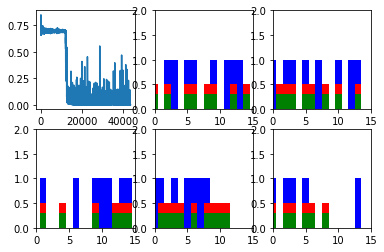

Step 400 Loss 0.000388535
single_output_series: [0 0 0 0 0 0 1 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 0 1 0 0 1]

single_output_series: [0 1 0 0 0 1 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 0 0 1 0 1 0]

single_output_series: [1 0 1 1 1 1 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 1 1 0 1 1 1]

single_output_series: [1 1 1 0 1 0 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 0 0 1 0 1 1 1]

single_output_series: [1 1 1 0 0 0 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 0 1 1 0 1 1 1]



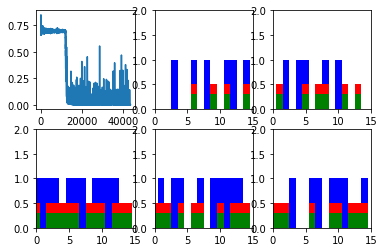

Step 500 Loss 0.000397589
single_output_series: [1 1 0 1 1 0 1 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 0 1 0 0 1 1]

single_output_series: [0 0 1 0 0 0 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 1 1 0 1 1 0]

single_output_series: [1 1 1 0 1 1 1 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 0 0 0 1 0 1 1]

single_output_series: [0 0 0 1 0 1 0 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 1 0 1 0 0]

single_output_series: [0 1 1 0 0 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 1 0 1 0 1 1 1]



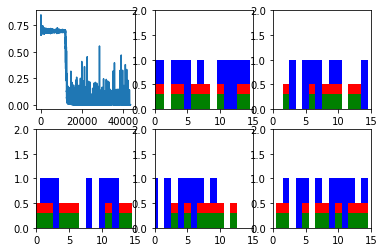

Step 600 Loss 0.000404551
single_output_series: [1 0 1 0 0 0 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 1 1 0 1 1 1 0]

single_output_series: [0 0 1 1 1 1 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 0 0 1 1 0 1]

single_output_series: [0 0 0 0 0 0 1 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 0 1 0 1 0]

single_output_series: [1 1 0 0 0 0 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 1 0 0 0 1 0]

single_output_series: [0 1 1 1 0 0 1 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 1 1 1 1 1 0]



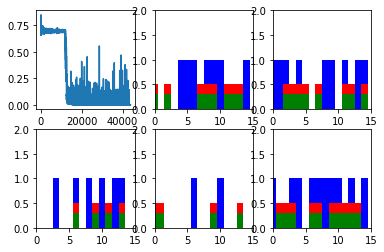

New data, epoch 66
Step 0 Loss 0.155133
single_output_series: [0 0 1 0 0 1 1 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 1 0 1 0 1]

single_output_series: [0 0 1 0 0 1 1 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 0 0 1 0 1 1]

single_output_series: [0 0 1 0 0 0 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 1 0 1 0 1 1]

single_output_series: [0 0 1 0 1 0 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 0 1 1 1 1 0 1]

single_output_series: [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 1 1 1 1 1 0 0]



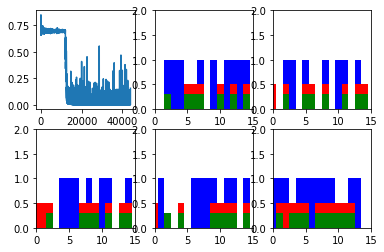

Step 100 Loss 0.000437018
single_output_series: [0 0 1 0 1 1 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 1 0 0 1 0 0]

single_output_series: [1 1 1 0 0 0 0 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 0 1 0 1 0 0]

single_output_series: [1 1 0 1 0 1 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 0 0 0 1 0 1]

single_output_series: [0 0 0 0 0 1 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 0 0 1 1 1 0]

single_output_series: [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]



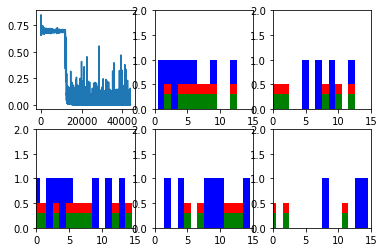

Step 200 Loss 0.000381544
single_output_series: [1 1 0 0 0 0 0 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 0 0 1 1 0 1]

single_output_series: [0 0 1 0 0 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 0 1 0 0 0 1]

single_output_series: [1 1 1 1 0 1 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 0 0 1 0 1]

single_output_series: [1 0 1 1 1 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 1 0 1 0 0 0]

single_output_series: [0 0 0 0 1 1 1 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 1 1 1 1 0]



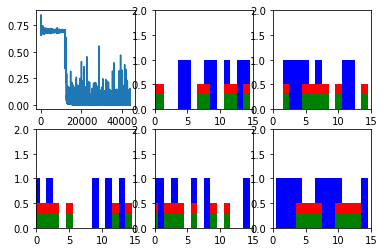

Step 300 Loss 0.000377548
single_output_series: [1 0 0 1 1 1 0 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 0 1 0 1 0 1]

single_output_series: [0 1 1 0 0 1 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 0 0 0 0 1 1]

single_output_series: [1 1 0 0 0 1 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 0 1 0 0 0 0 1]

single_output_series: [1 0 0 0 0 1 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 0 1 1 1 1 1]

single_output_series: [0 0 1 1 0 0 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 0 1 0 0 1 0]



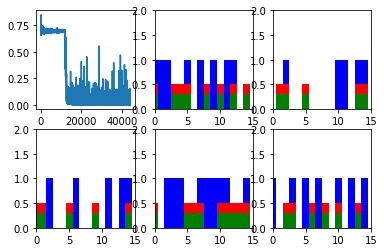

Step 400 Loss 0.000371468
single_output_series: [1 1 1 0 1 1 1 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 0 1 1 1 1 1]

single_output_series: [1 0 1 0 0 0 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 0 1 0 1 0 0]

single_output_series: [1 1 1 0 1 1 1 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 1 1 0 0 1 0]

single_output_series: [1 1 1 1 1 0 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 1 1 0 1 1 1 0]

single_output_series: [1 0 0 1 1 0 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 1 0 1 0 1 0 0]



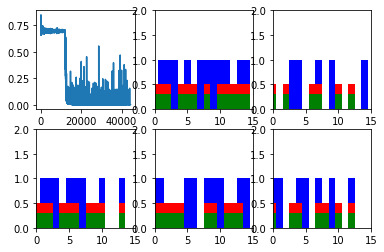

Step 500 Loss 0.000356263
single_output_series: [0 1 0 0 1 1 1 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 1 0 1 1 0 0]

single_output_series: [0 0 1 1 0 1 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 1 0 1 1 0 1]

single_output_series: [0 1 0 0 0 1 1 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 0 1 1 1 1 0 0]

single_output_series: [1 1 0 1 0 0 1 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 0 1 0 0 0 1 0]

single_output_series: [1 1 0 0 0 1 1 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 1 0 1 0 0 1]



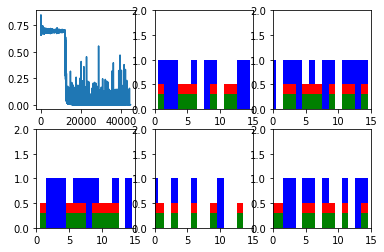

Step 600 Loss 0.000340057
single_output_series: [0 0 1 0 1 1 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 1 1 0 1 1 1]

single_output_series: [1 1 0 1 0 0 0 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 1 0 0 0 1 1]

single_output_series: [1 1 0 1 1 0 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 0 1 1 1 1 1]

single_output_series: [0 0 0 0 1 0 0 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 0 1 1 1 0 0]

single_output_series: [1 0 1 1 1 0 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 0 0 0 0 1 1]



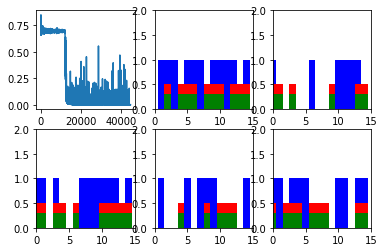

New data, epoch 67
Step 0 Loss 0.151649
single_output_series: [0 0 0 0 1 1 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 0 0 0 1 1 1 0]

single_output_series: [0 0 1 1 1 1 1 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 0 1 0 0 0 1]

single_output_series: [0 0 1 1 0 0 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 1 1 1 1 0 1 0]

single_output_series: [0 0 1 1 1 1 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 0 1 0 1 0 1]

single_output_series: [0 0 0 0 1 1 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 0 1 0 1 0 1]



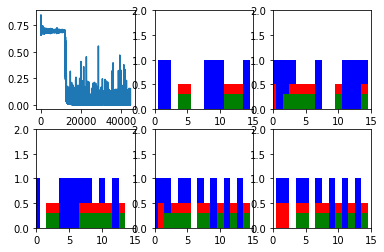

Step 100 Loss 0.000299174
single_output_series: [1 1 0 1 1 1 1 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 1 1 0 1 1 0]

single_output_series: [0 1 1 0 1 1 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 0 0 0 1 1 1]

single_output_series: [1 1 1 1 0 1 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 1 1 1 0 0]

single_output_series: [1 0 1 0 0 0 0 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 0 1 1 0 1 0]

single_output_series: [0 0 0 1 1 1 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 1 1 0 1 0]



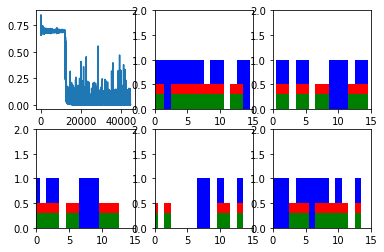

Step 200 Loss 0.000403107
single_output_series: [1 1 0 0 0 0 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 0 0 0 1 0 1]

single_output_series: [1 0 1 0 1 1 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 1 0 1 0 1 0]

single_output_series: [1 0 1 1 0 1 1 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 0 1 1 1 1]

single_output_series: [1 0 0 1 0 1 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 0 0 1 0 1 1]

single_output_series: [0 1 0 0 0 0 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 1 1 0 1 0 0 0]



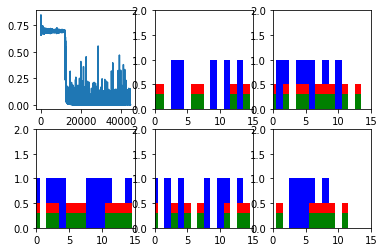

Step 300 Loss 0.000349882
single_output_series: [0 0 0 1 1 1 1 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 0 1 1 1 0 1]

single_output_series: [1 1 0 0 1 0 0 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 0 0 0 1 0 1 0]

single_output_series: [1 1 0 0 1 0 0 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 1 0 0 1 0 0 1]

single_output_series: [0 1 1 0 0 0 1 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 0 1 0 1 1 0]

single_output_series: [1 0 0 1 1 0 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 0 1 1 1 0 1]



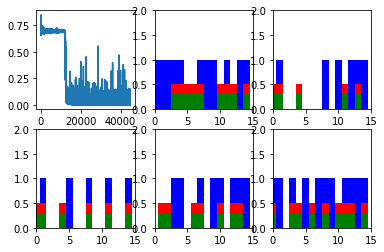

Step 400 Loss 0.000381362
single_output_series: [1 1 0 1 0 0 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 0 1 1 1 0 1 0]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 1 1 1 0 0 1]

single_output_series: [0 0 0 1 1 0 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 1 1 1 0 0 1]

single_output_series: [0 0 0 1 1 0 0 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 1 1 0 1 0 1]

single_output_series: [1 0 0 0 0 1 0 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 0 1 0 1 0 0 0]



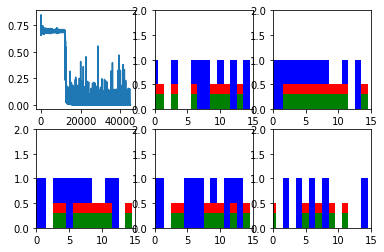

Step 500 Loss 0.000366219
single_output_series: [1 0 1 0 0 1 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 1 1 1 1 1 1]

single_output_series: [1 0 0 0 0 0 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 0 1 0 1 1]

single_output_series: [1 0 0 0 1 0 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 1 0 0 0 0 1]

single_output_series: [0 0 1 0 1 1 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 1 0 0 1 0 0]

single_output_series: [1 0 0 0 0 1 1 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 0 1 1 0 0 1]



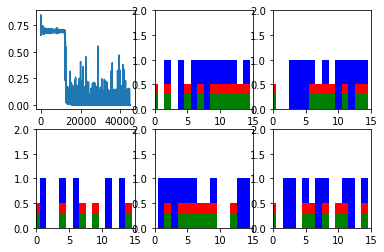

Step 600 Loss 0.000340214
single_output_series: [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1]

single_output_series: [1 1 0 1 0 1 1 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 1 1 1 1 0 0]

single_output_series: [0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]

single_output_series: [1 0 0 0 0 0 0 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 1 0 0 0 1 1]



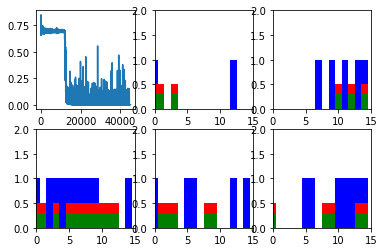

New data, epoch 68
Step 0 Loss 0.136556
single_output_series: [0 1 0 0 1 0 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 0 0 0 0 0 0 1]

single_output_series: [0 1 0 0 1 0 1 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 0 1 1 0 1 0]

single_output_series: [0 1 0 0 1 0 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 1 1 1 1 0 0]

single_output_series: [0 1 0 0 0 0 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 1 0 0 1 0 1]

single_output_series: [0 1 0 0 1 1 0 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 1 0 0 0 1 1]



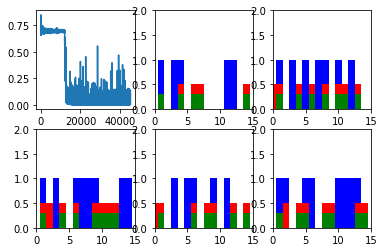

Step 100 Loss 0.000347514
single_output_series: [0 1 0 1 1 1 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 0 0 1 1 1 0]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]

single_output_series: [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 1 0 1 1 0 1 0]

single_output_series: [0 0 1 1 1 0 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 1 0 1 1 0 1]



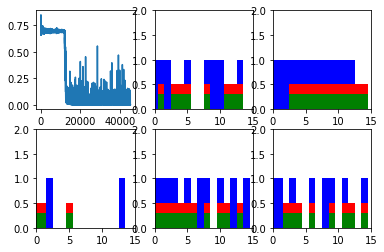

Step 200 Loss 0.000300409
single_output_series: [0 1 1 1 0 0 0 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 0 1 0 0 1 1]

single_output_series: [0 0 1 0 0 1 1 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 0 0 0 0 0 1]

single_output_series: [0 0 1 1 0 0 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 0 0 1 0 0 0]

single_output_series: [0 1 1 0 0 1 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 1 0 0 1 0 0]

single_output_series: [1 1 1 1 0 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 0 1 0 1 0 0 0]



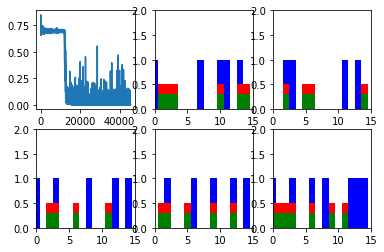

Step 300 Loss 0.000388256
single_output_series: [1 0 1 0 1 0 0 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 1 0 1 1 1 1]

single_output_series: [1 0 1 0 0 0 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 0 0 1 0 1 0]

single_output_series: [1 1 1 0 0 0 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 1 1 1 0 0 1]

single_output_series: [1 0 1 0 0 1 0 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 1 1 0 0 1 0]

single_output_series: [0 1 0 1 0 1 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 1 1 1 1 0]



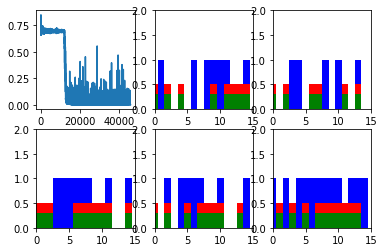

Step 400 Loss 0.000437973
single_output_series: [0 1 1 1 1 0 1 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 0 1 1 1 0 0]

single_output_series: [0 1 0 0 1 1 1 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 0 0 1 0 0 0]

single_output_series: [1 0 1 1 0 1 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 1 0 1 1 1 0]

single_output_series: [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]

single_output_series: [0 1 0 0 0 0 1 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 1 0 1 1 0 1 0]



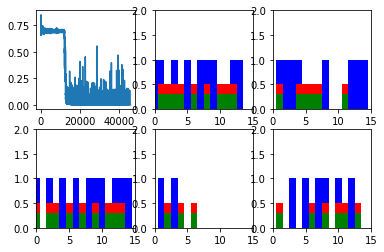

Step 500 Loss 0.000315171
single_output_series: [1 0 0 0 0 0 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 0 0 0 0 1 0]

single_output_series: [0 0 1 0 1 1 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 0 0 1 1 1 0 0]

single_output_series: [0 0 1 1 0 1 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 0 1 0 0 1 0]

single_output_series: [1 0 1 1 1 0 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 1 1 0 1 1 1 0]

single_output_series: [0 0 1 1 1 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 1 0 1 1 1]



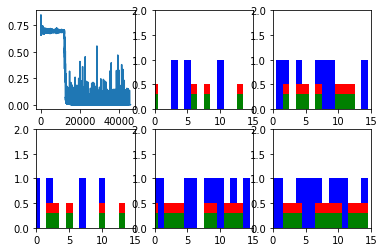

Step 600 Loss 0.00033468
single_output_series: [0 0 0 0 0 0 0 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 1 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 1 0 1 1 1 0 1]

single_output_series: [0 1 1 1 0 0 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 1 1 1 1 0]

single_output_series: [0 0 1 0 1 1 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 0 0 0 0 1 1 0]



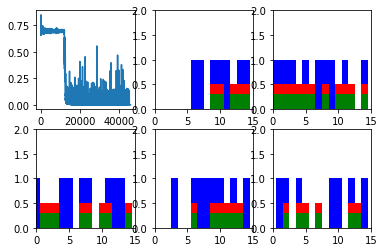

New data, epoch 69
Step 0 Loss 0.235933
single_output_series: [0 1 0 1 0 0 0 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 0 1 0 1 1 1 0]

single_output_series: [0 1 0 1 0 0 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 0 0 1 0 1 0 0]

single_output_series: [0 0 1 0 1 0 1 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 0 0 0 1 0 1 0]

single_output_series: [0 1 0 1 0 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 1 0 1 0 0 0 0]

single_output_series: [0 0 1 0 1 1 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 0 1 1 1 1 1]



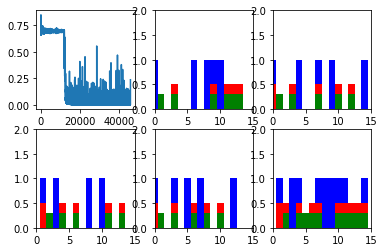

Step 100 Loss 0.000422832
single_output_series: [0 0 1 1 1 1 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 1 1 1 0 1 0]

single_output_series: [0 0 1 0 0 1 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 1 0 1 0 1 1]

single_output_series: [0 1 1 1 1 0 1 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 0 0 1 1 1]

single_output_series: [0 0 0 0 0 1 1 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 1 1 1 1 1 0]

single_output_series: [0 0 1 1 0 0 1 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 1 1 1 1 0 1]



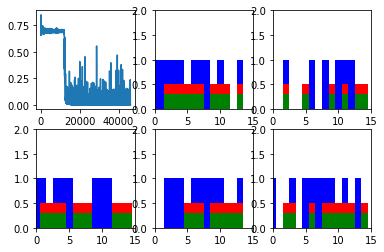

Step 200 Loss 0.000388112
single_output_series: [1 1 0 1 0 1 1 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 1 1 1 1 1 0]

single_output_series: [0 1 1 1 1 1 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 0 0 1 1 0]

single_output_series: [1 0 1 1 1 0 0 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 1 0 0 0 1 1]

single_output_series: [1 1 0 1 1 0 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 1 0 0 1 0 0]

single_output_series: [0 1 1 1 0 0 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 0 1 0 1 1 1]



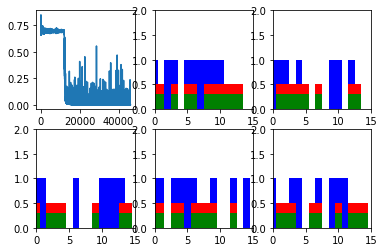

Step 300 Loss 0.000427747
single_output_series: [1 1 0 0 1 1 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 0 0 1 1 1 0]

single_output_series: [1 1 0 1 0 1 0 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 1 0 1 0 1 1 0]

single_output_series: [0 0 1 0 1 0 1 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 1 1 1 1 0 1 0]

single_output_series: [0 0 0 1 1 0 1 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 0 0 1 0 0 0]

single_output_series: [0 0 1 1 0 1 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 1 0 0 0 1 0 1]



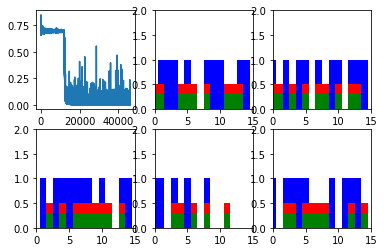

Step 400 Loss 0.000343808
single_output_series: [1 0 0 0 0 1 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 0 1 0 0 1 1]

single_output_series: [0 1 1 0 0 0 1 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 0 0 1 1 0 0]

single_output_series: [1 0 1 1 0 1 1 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 0 0 1 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]

single_output_series: [1 1 0 1 1 0 1 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 1 0 1 0 1 1]



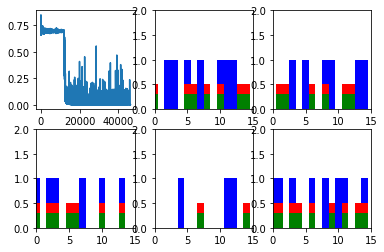

Step 500 Loss 0.000323471
single_output_series: [1 1 1 0 0 0 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 0 1 0 0 0]

single_output_series: [1 0 1 0 0 1 1 0 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 1 0 0 1 1 1]

single_output_series: [1 1 1 0 0 0 0 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 1 1 1 0 0 1]

single_output_series: [1 1 0 0 0 1 1 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 0 1 1 0 1 1 0]

single_output_series: [0 1 0 0 1 0 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 0 1 0 0 1 0 0]



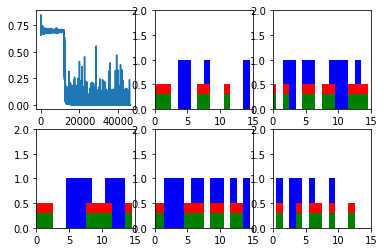

Step 600 Loss 0.000301016
single_output_series: [0 0 1 0 0 0 0 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 0 0 1 0 0 1]

single_output_series: [1 1 1 0 0 0 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 1 0 1 0 1 1]

single_output_series: [1 0 1 1 1 0 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 0 0 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 1 1 1 1 1 1 1]

single_output_series: [0 0 0 0 0 1 1 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 0 1 1 0 0 1]



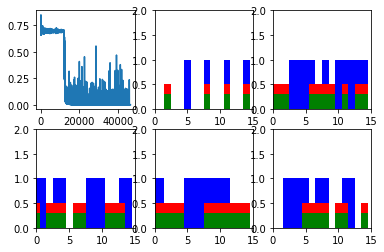

New data, epoch 70
Step 0 Loss 0.188596
single_output_series: [0 0 0 1 1 1 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 0 1 1 1 0 1 1]

single_output_series: [0 1 0 0 1 1 1 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 1 1 0 0 0 0 0]

single_output_series: [0 1 0 0 0 1 1 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 0 1 1 1 0 0]

single_output_series: [0 0 0 1 1 0 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 1 1 0 1 0 0 0]

single_output_series: [0 0 1 1 0 1 1 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 1 1 1 0 0 0]



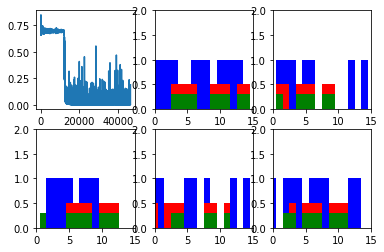

Step 100 Loss 0.000286082
single_output_series: [1 0 0 0 1 1 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 1 1 0 1 1 1]

single_output_series: [0 0 0 0 0 1 0 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 1 0 0 0 1 1]

single_output_series: [1 1 1 0 0 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 1 0 1 1 1 1]

single_output_series: [1 0 0 1 1 0 1 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 1 0 1 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 0 1 1 1 0 0]



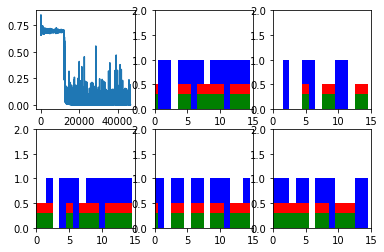

Step 200 Loss 0.00029849
single_output_series: [0 0 1 1 1 1 1 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 1 1 0 0 1]

single_output_series: [1 0 0 1 1 0 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 1 1 0 0 0 0 1 0]

single_output_series: [0 1 1 1 1 0 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 0 1 1 1 0]

single_output_series: [1 0 0 0 1 0 1 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 0 1 1 0 1 0 0]

single_output_series: [0 1 0 1 0 1 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 1 0 0 1 0]



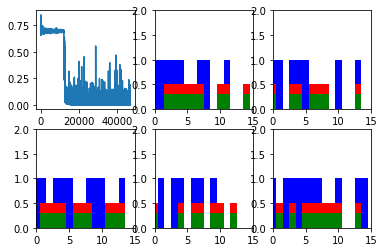

Step 300 Loss 0.00025423
single_output_series: [1 0 1 0 1 0 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 1 0 0 1 1 1 0]

single_output_series: [0 1 1 0 0 1 1 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 0 0 1 1 1 1]

single_output_series: [1 0 0 0 1 1 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 0 0 0 1 1 0]

single_output_series: [1 0 0 1 1 0 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 1 0 1 1 0 0 1]

single_output_series: [0 1 1 1 1 0 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 0 0 0 0 0 0]



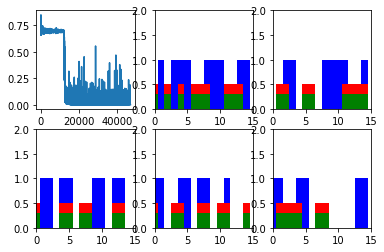

Step 400 Loss 0.000399578
single_output_series: [0 1 0 1 1 1 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 0 1 1 1 0 1]

single_output_series: [0 1 1 1 0 1 0 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 1 1 1 0 0 0 0]

single_output_series: [1 1 0 1 0 1 0 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 1 1 0 1 0 0 1]

single_output_series: [1 1 0 1 1 0 0 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 1 0 1 1 1 0]

single_output_series: [1 0 1 1 1 0 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 0 1 0 1 0 0]



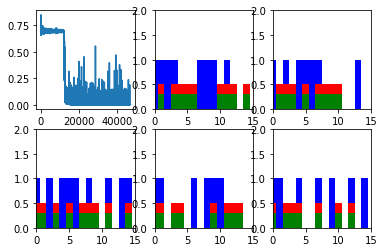

Step 500 Loss 0.000347068
single_output_series: [1 1 1 0 0 0 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 0 0 0 0 0 0 0]

single_output_series: [1 1 1 0 0 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 1 1 0 1 1 1]

single_output_series: [0 1 0 0 1 0 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 0 1 1 1 1 1 1]

single_output_series: [0 0 1 1 0 0 1 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 1 1 0 1 0 1]

single_output_series: [0 0 0 1 1 0 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 0 1 0 1 0 0]



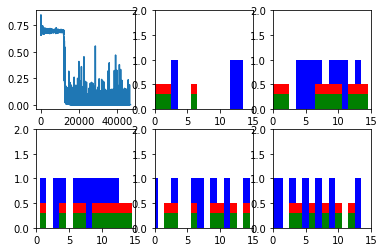

Step 600 Loss 0.000375931
single_output_series: [1 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 0 0 0 0 0 0]

single_output_series: [1 0 0 0 1 1 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 1 1 1 0 1 1 0]

single_output_series: [0 1 1 0 0 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 1 0 1 0 1 0]

single_output_series: [1 0 0 1 0 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 0 1 0 0 1 0]

single_output_series: [0 1 1 0 1 0 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 1 1 1 0 0 0 1]



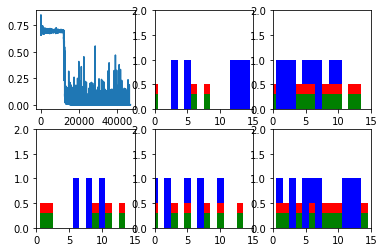

New data, epoch 71
Step 0 Loss 0.142039
single_output_series: [0 0 0 0 0 1 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 1 1 0 0 0 0]

single_output_series: [0 0 1 1 0 1 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 1 0 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 0 0 1 1 0 0]

single_output_series: [0 0 0 0 1 1 1 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 1 1 1 1 0 0]

single_output_series: [0 0 1 1 0 0 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 0 1 1 1 1 1]



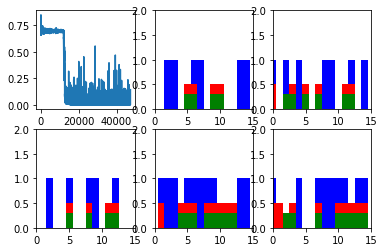

Step 100 Loss 0.000371053
single_output_series: [1 0 1 0 0 0 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 0 1 1 0 0 1]

single_output_series: [1 0 1 1 0 0 0 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 0 0 0 1 0 1]

single_output_series: [1 1 1 0 0 0 1 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 1 0 1 0 0 0]

single_output_series: [0 1 0 0 1 0 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 1 0 0 1 0]

single_output_series: [0 1 0 1 1 1 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 1 1 1 1 0 1]



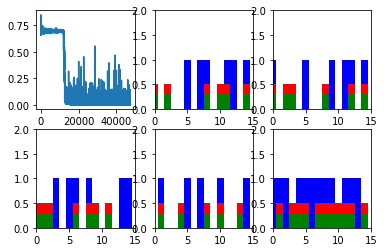

Step 200 Loss 0.000359847
single_output_series: [0 0 1 0 1 0 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 1 1 0 0 1 0 0]

single_output_series: [0 0 1 0 0 0 1 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 1 0 1 1 0 1]

single_output_series: [0 0 0 1 0 1 1 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 1 0 1 1 1 0]

single_output_series: [0 1 0 0 0 0 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 0 1 1 0 1 0]

single_output_series: [1 1 0 0 0 1 0 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 1 0 0 0 0 0 1]



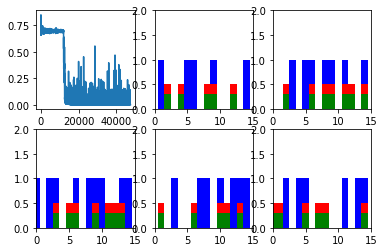

Step 300 Loss 0.000302914
single_output_series: [0 0 0 1 1 1 0 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 1 0 1 1 1]

single_output_series: [0 1 1 0 1 0 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 0 1 1 1 1 1]

single_output_series: [0 1 0 0 0 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 0 0 1 1 1 0]

single_output_series: [1 0 1 1 1 1 1 0 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 0 1 0 1 1 0]

single_output_series: [0 1 0 0 1 0 1 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 1 1 0 1 1 0 1]



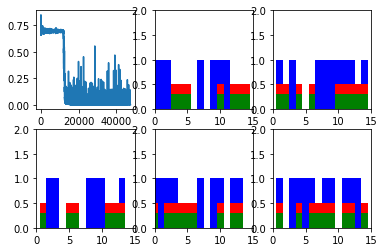

Step 400 Loss 0.00035052
single_output_series: [1 0 1 0 1 1 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 1 1 1 1 1 0]

single_output_series: [0 0 1 0 0 1 1 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 0 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]

single_output_series: [1 0 1 0 1 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 1 0 1 0 1 0]

single_output_series: [0 1 1 0 1 1 1 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 1 1 1 1 1 0]



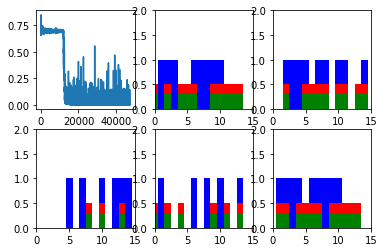

Step 500 Loss 0.000326833
single_output_series: [1 1 0 0 0 0 0 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 1 0 0 1 0 1]

single_output_series: [0 1 0 0 1 1 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 1 1 1 0 0 0 1]

single_output_series: [1 0 1 1 1 1 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 0 0 1 0 0 0]

single_output_series: [1 0 0 0 1 1 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 0 1 0 1 1 0]

single_output_series: [0 1 0 1 1 0 1 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 1 0 0 1 0 0 1]



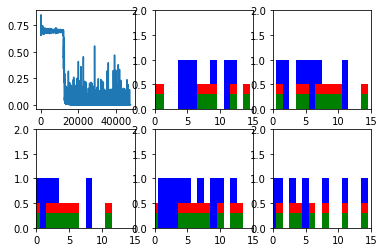

Step 600 Loss 0.000297983
single_output_series: [1 0 0 1 0 1 1 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 1 0 1 0 0 0 0]

single_output_series: [0 1 1 0 0 1 0 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 0 0 1 1 0 0]

single_output_series: [1 0 0 0 1 1 0 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 1 1 0 1 0 0]

single_output_series: [0 1 1 1 1 0 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 0 1 0 1 0 1 1]

single_output_series: [0 0 1 0 1 1 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 0 0 0 0 1 1 1]



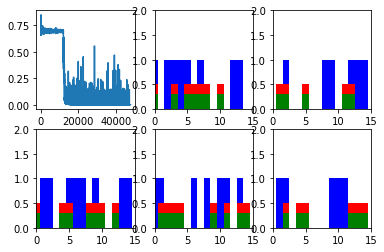

New data, epoch 72
Step 0 Loss 0.413948
single_output_series: [0 1 0 0 0 1 0 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 0 0 1 0 0 1]

single_output_series: [0 1 0 1 0 0 0 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 0 0 1 0 1]

single_output_series: [0 1 0 1 0 0 1 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 1 1 0 1 1]

single_output_series: [0 1 0 1 1 0 1 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 0 1 1 1 0 0 0]

single_output_series: [0 1 0 0 1 1 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 1 0 1 0 0]



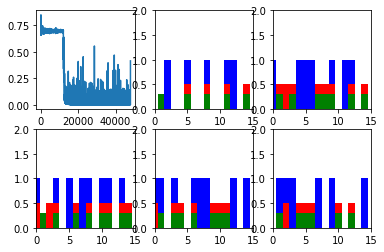

Step 100 Loss 0.000335213
single_output_series: [0 0 0 1 1 0 1 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 1 0 0 0 1 1]

single_output_series: [0 1 1 1 0 1 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 1 1 0 0 1 1 1]

single_output_series: [0 1 0 0 1 0 0 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 0 1 0 0 0 0]

single_output_series: [0 1 0 1 1 0 1 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 0 1 0 1 1 1]

single_output_series: [0 1 0 1 0 1 0 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 0 1 0 0 0 0]



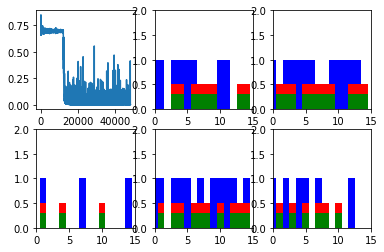

Step 200 Loss 0.000343308
single_output_series: [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]

single_output_series: [0 0 1 0 1 1 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 0 1 0 1 0 0]

single_output_series: [0 1 0 1 1 1 1 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 0 0 0 1 0 0 0]

single_output_series: [1 0 1 0 0 1 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 1 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 1 1 1 1 1 0 1]



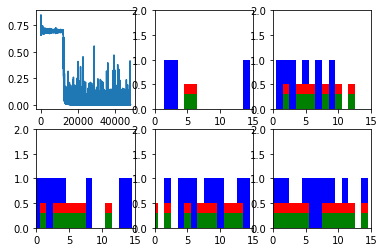

Step 300 Loss 0.000283617
single_output_series: [1 0 1 0 0 0 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 0 0 1 1 1 0]

single_output_series: [0 1 1 0 0 1 1 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 0 1 1 1 1 0]

single_output_series: [1 0 0 1 1 1 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 1 0 0 0 0 1 0]

single_output_series: [0 1 1 1 1 0 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 1 0 1 1 1 0]

single_output_series: [0 0 0 1 0 1 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 1 1 0 0 1 0]



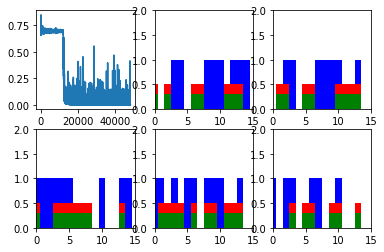

Step 400 Loss 0.000309332
single_output_series: [0 0 0 0 1 0 0 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 1 1 0 0 0 0]

single_output_series: [0 1 0 1 1 1 1 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 1 0 1 1 0 1]

single_output_series: [1 1 1 1 0 0 1 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 1 1 1 0 0 0 0]

single_output_series: [1 0 1 1 1 0 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 1 0 1 1 0 1]

single_output_series: [0 1 1 1 1 0 1 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 0 1 1 0 1 0]



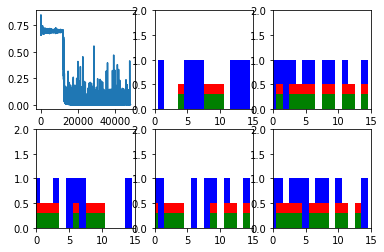

Step 500 Loss 0.000293034
single_output_series: [0 1 1 1 1 1 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 1 1 1 0 0]

single_output_series: [0 1 1 1 1 1 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 1 1 0 1 1 1 0]

single_output_series: [1 0 0 0 0 0 1 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 0 1 1 0 1 0]

single_output_series: [0 0 0 0 0 1 0 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 0 1 0 0 0 0]

single_output_series: [0 0 0 1 1 1 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 0 0 0 1 1]



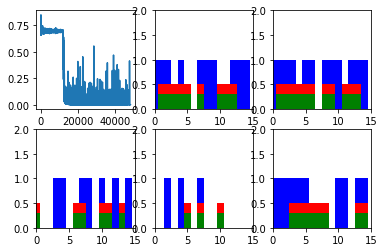

Step 600 Loss 0.000259397
single_output_series: [1 0 0 1 0 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 0 0 1 0 1 1]

single_output_series: [0 0 0 0 1 1 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 1 0 0 1 0 0 0]

single_output_series: [1 1 0 0 1 1 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 0 1 1 1 1 1]

single_output_series: [1 1 1 1 0 1 1 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 1 1 1 0 0 1]

single_output_series: [1 1 1 1 1 1 0 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 1 1 1 0 1 1]



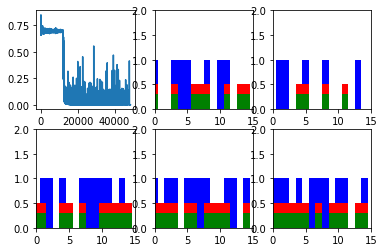

New data, epoch 73
Step 0 Loss 0.24576
single_output_series: [0 1 0 1 1 1 0 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 0 1 1 0 0 0 0]

single_output_series: [0 0 1 0 1 0 0 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 0 1 1 0 1 1]

single_output_series: [0 1 0 1 0 0 0 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 1 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 0 1 1 1 1 0]

single_output_series: [0 0 1 0 1 0 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 0 1 1 1 1 0]



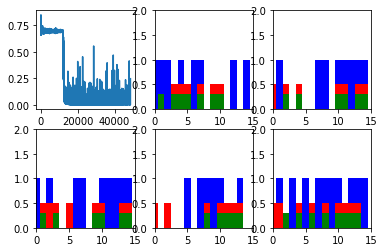

Step 100 Loss 0.000310241
single_output_series: [1 1 1 0 1 1 0 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 1 1 1 0 1 1]

single_output_series: [0 1 0 1 0 0 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 1 1 0 1 1 0]

single_output_series: [0 0 0 0 0 1 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 0 0 1 0 1 1]

single_output_series: [1 1 0 1 1 0 0 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 1 1 0 1 1 1]

single_output_series: [1 1 0 0 0 1 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 0 1 1 1 0 1]



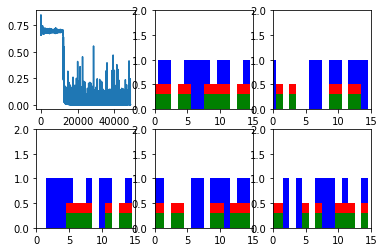

Step 200 Loss 0.000356999
single_output_series: [1 1 0 1 1 1 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 0 1 1 0 1 1]

single_output_series: [1 0 1 0 1 0 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 0 1 0 1 0 0]

single_output_series: [0 1 0 1 0 1 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 0 1 0 0 0 1 0]

single_output_series: [0 0 0 1 1 0 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 0 0 1 0 0]

single_output_series: [0 1 1 0 0 1 1 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 1 0 1 1 1 1]



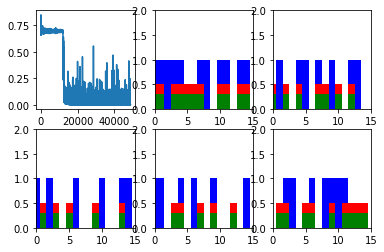

Step 300 Loss 0.00029758
single_output_series: [0 0 1 1 0 0 1 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 0 1 0 1 0 1 1]

single_output_series: [0 1 1 0 0 1 0 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 0 0 0 0 0 1]

single_output_series: [1 1 1 0 0 0 1 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 0 1 1 1 0 0 1]

single_output_series: [1 1 0 1 1 1 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 0 0 0 1 0 0]

single_output_series: [0 0 1 0 1 1 1 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 1 0 0 1 0 0]



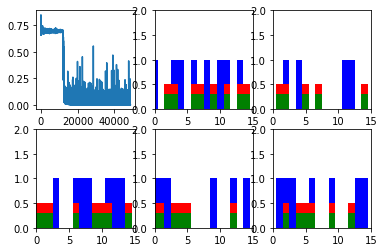

Step 400 Loss 0.000325941
single_output_series: [1 0 0 1 0 1 0 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 0 1 1 0 0 1 1]

single_output_series: [1 0 1 0 1 1 1 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 0 1 1 0 1 1]

single_output_series: [1 0 1 0 1 0 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 1 1 1 0 0 1 0]

single_output_series: [1 1 1 0 0 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 1 0 1 1 0 0]

single_output_series: [1 0 1 0 0 1 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 0 0 0 0 1 1]



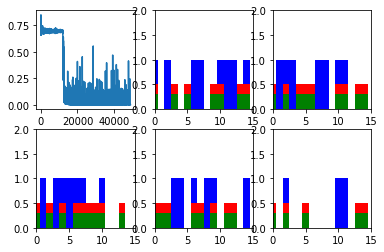

Step 500 Loss 0.000278591
single_output_series: [1 1 1 0 0 1 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 0 1 1 1 0 1 1]

single_output_series: [0 0 1 1 0 1 0 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 1 0 0 0 1 1 0]

single_output_series: [0 0 1 1 0 0 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 1 1 1 1 1 1]

single_output_series: [1 1 0 0 1 1 1 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 1 1 0 0 1 1]

single_output_series: [1 0 1 0 1 0 0 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 0 0 1 1 0 0]



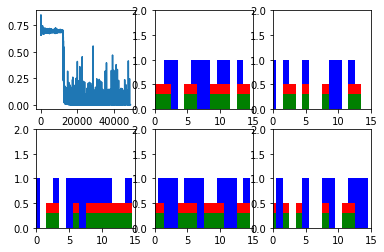

Step 600 Loss 0.000308817
single_output_series: [1 0 0 1 1 1 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 0 0 1 1 1 0]

single_output_series: [0 1 1 1 0 1 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 1 0 1 1 0 0]

single_output_series: [0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]

single_output_series: [0 1 0 0 1 1 1 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 1 1 0 0 1 0]

single_output_series: [1 0 0 0 0 0 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 0 1 0 0 1 1]



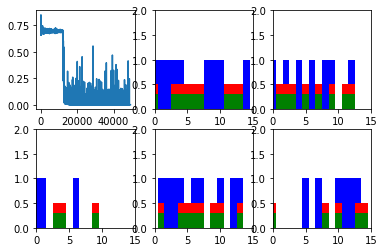

New data, epoch 74
Step 0 Loss 0.142289
single_output_series: [0 0 0 1 1 1 1 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 1 1 1 1 1 0]

single_output_series: [0 0 1 0 1 1 0 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 1 1 1 1 0]

single_output_series: [0 0 1 0 0 1 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 0 1 0 0 1 0]

single_output_series: [0 0 0 1 0 1 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 1 0 1 1 1]

single_output_series: [0 0 1 0 0 0 0 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 1 1 1 1 1 1]



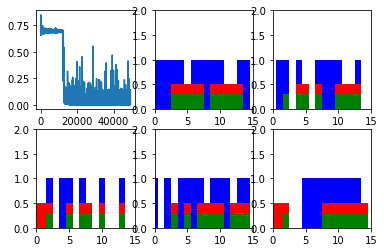

Step 100 Loss 0.000291734
single_output_series: [0 1 1 0 0 1 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 1 0 0 0 0 0]

single_output_series: [1 1 1 1 0 1 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 0 0 0 1 1 1]

single_output_series: [0 1 1 1 1 0 0 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 0 1 1 1 0 1]

single_output_series: [1 0 1 1 1 1 0 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 0 0 1 1 0 1]

single_output_series: [1 0 1 0 0 0 0 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 1 1 0 1 0 0]



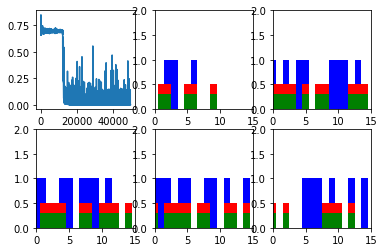

Step 200 Loss 0.000318249
single_output_series: [1 0 0 0 1 1 0 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 0 1 0 0 1 1]

single_output_series: [1 0 0 1 0 0 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 0 1 0 1 0 1]

single_output_series: [1 0 1 1 0 1 1 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 0 0 1 0 0]

single_output_series: [1 1 1 0 1 1 0 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 0 1 1 1 1 1 0]

single_output_series: [0 0 1 1 1 0 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 0 0 0 1 1 0]



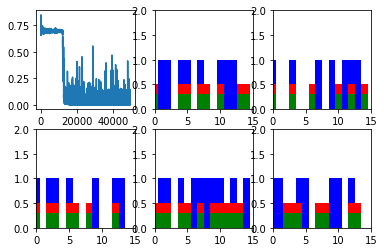

Step 300 Loss 0.000320729
single_output_series: [1 1 0 1 1 0 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 0 1 0 0 0 1]

single_output_series: [1 1 1 1 0 0 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 1 0 0 1 1 1 0]

single_output_series: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 1 1 1 1 1 0]

single_output_series: [0 1 1 0 1 1 1 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 1 0 0 0 0 0]

single_output_series: [1 1 0 0 1 1 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 0 1 0 0 0 0]



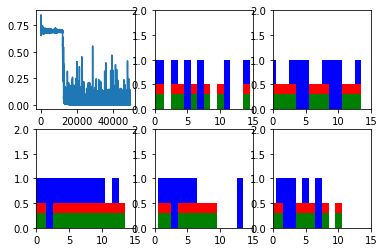

Step 400 Loss 0.000282026
single_output_series: [1 0 0 0 0 1 1 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 1 1 0 0 0]

single_output_series: [1 1 0 0 1 1 1 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 1 0 1 1 1 1]

single_output_series: [1 0 1 0 0 0 0 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 1 1 1 1 0 0]

single_output_series: [0 0 1 0 1 1 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 1 1 0 1 1 0]

single_output_series: [1 1 1 1 0 1 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 1 0 1 1 1 0]



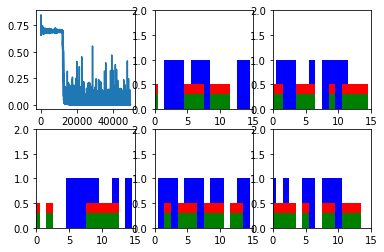

Step 500 Loss 0.000301034
single_output_series: [1 1 0 0 1 1 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 1 0 0 0 0 1]

single_output_series: [0 1 1 1 1 1 1 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 1 0 1 0 0 1 1]

single_output_series: [1 1 0 1 0 0 1 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 0 1 1 0 1 0 0]

single_output_series: [1 0 0 1 1 1 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 0 1 1 1 0 0]

single_output_series: [0 1 1 0 1 0 1 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 0 0 0 1 0 0]



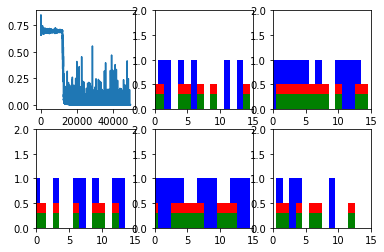

Step 600 Loss 0.000298616
single_output_series: [0 0 1 1 0 1 0 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 1 1 1 0 0 0]

single_output_series: [1 1 0 0 1 0 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 0 0 0 0 1 1 0]

single_output_series: [1 0 0 1 1 1 0 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 0 0 0 1 0 0 1]

single_output_series: [1 0 0 1 0 1 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 0 1 0 1 1 1]

single_output_series: [1 1 0 1 1 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 0 0 1 0 1 1]



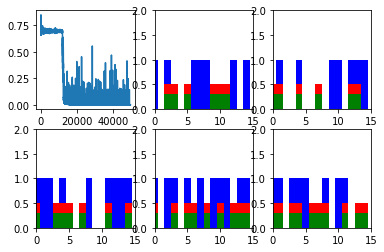

New data, epoch 75
Step 0 Loss 0.183525
single_output_series: [0 0 0 0 0 1 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 1 1 1 0 1 0]

single_output_series: [0 0 0 1 1 1 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 0 1 1 1 1 0]

single_output_series: [0 0 0 1 1 0 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 0 1 1 1 1]

single_output_series: [0 0 0 0 1 0 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 0 1 1 0 1 1 1]

single_output_series: [0 0 0 1 0 1 0 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 1 1 0 0 0 0]



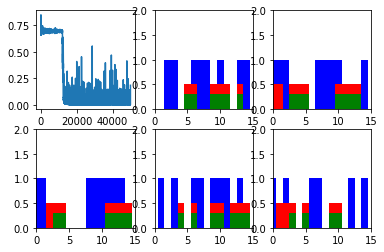

Step 100 Loss 0.00034028
single_output_series: [0 0 0 1 1 1 0 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 0 0 1 0 1 1 1]

single_output_series: [0 0 0 1 0 1 0 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 0 1 0 0 0 1]

single_output_series: [1 0 0 0 1 0 1 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 0 0 0 0 0 1 1]

single_output_series: [0 1 1 1 1 0 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 1 0 1 1 0 0]

single_output_series: [0 0 1 0 1 0 0 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 1 0 1 1 0 0]



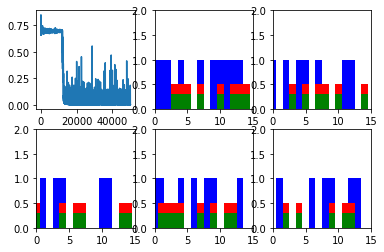

Step 200 Loss 0.000356333
single_output_series: [0 0 0 0 0 0 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 0 0 1 1 1 0]

single_output_series: [0 1 0 1 0 1 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 0 1 0 0 0 0 0]

single_output_series: [1 0 0 0 1 1 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 1 1 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 1 1 1 0 0 0 1]

single_output_series: [1 0 0 0 0 0 0 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 1 1 0 0 1 0 0]



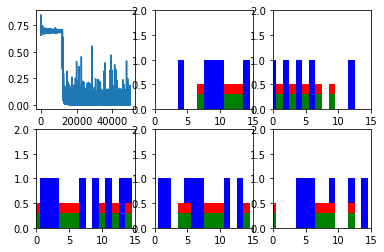

Step 300 Loss 0.000356061
single_output_series: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1]

single_output_series: [1 1 0 1 1 0 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 1 0 0 1 0 1]

single_output_series: [1 1 0 1 1 1 1 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 0 0 0 1 1 1]

single_output_series: [1 0 1 0 1 0 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 1 0 0 0 0 0]

single_output_series: [1 1 1 1 0 1 0 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 1 0 1 0 0 1]



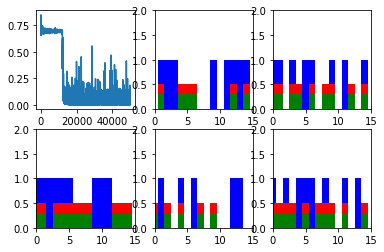

Step 400 Loss 0.00030059
single_output_series: [1 0 0 0 1 0 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 0 1 1 0 1 1]

single_output_series: [1 0 0 1 1 1 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 1 1 0 1 1 0]

single_output_series: [0 0 1 0 1 1 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 1 0 1 1 1 0]

single_output_series: [1 0 0 0 1 0 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 1 1 0 0 1 1]

single_output_series: [1 0 1 0 1 1 1 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 0 1 1 1 0 0 0]



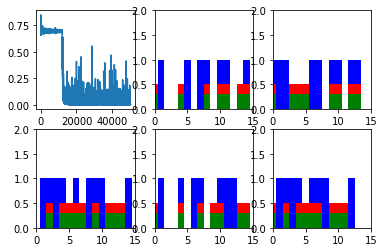

Step 500 Loss 0.000335221
single_output_series: [0 0 1 0 1 1 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 0 1 0 1 1 1]

single_output_series: [0 1 1 0 0 1 0 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 1 1 1 0 0 0]

single_output_series: [1 0 1 1 0 1 0 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 0 0 0 0 0 0]

single_output_series: [0 0 0 1 1 0 1 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 0 1 1 1 1 1]

single_output_series: [0 0 1 0 1 0 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 1 0 0 1 0 0 0]



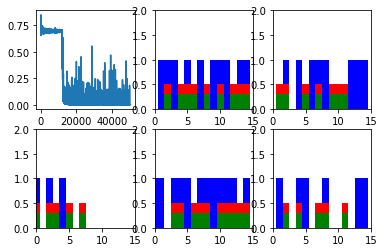

Step 600 Loss 0.00025716
single_output_series: [0 0 0 0 1 1 0 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 0 0 1 1 0 0 0]

single_output_series: [0 0 1 0 1 1 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 1 0 0 1 0 0]

single_output_series: [0 1 0 0 1 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 0 0 1 1 1 0]

single_output_series: [1 0 0 0 0 1 1 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 0 1 0 1 1 0]

single_output_series: [0 1 0 1 1 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 0 0 0 0 0 0]



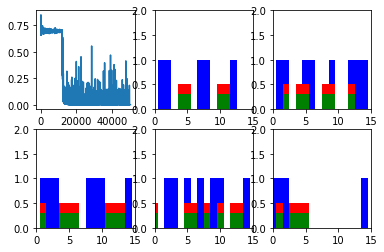

New data, epoch 76
Step 0 Loss 0.299428
single_output_series: [0 0 1 1 0 0 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 0 1 1 1 1 0]

single_output_series: [0 0 1 1 0 0 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 0 0 0 1 0 1]

single_output_series: [0 0 1 1 0 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 0 0 1 0 1 1]

single_output_series: [0 0 1 1 0 1 0 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 0 1 0 1 1 1]

single_output_series: [0 0 0 0 1 1 0 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 0 1 0 0 1 0 1]



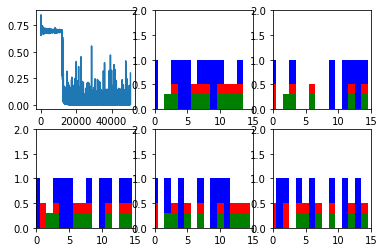

Step 100 Loss 0.00046219
single_output_series: [0 1 1 1 0 0 0 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 0 0 1 0 0 1]

single_output_series: [0 0 1 0 0 1 0 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 1 1 1 1 0 0]

single_output_series: [0 1 1 0 1 0 0 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 1 0 1 1 1 0 1]

single_output_series: [0 0 1 1 0 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 1 1 0 1 1 1 1]

single_output_series: [1 1 1 1 1 1 0 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 1 1 0 0 1 0]



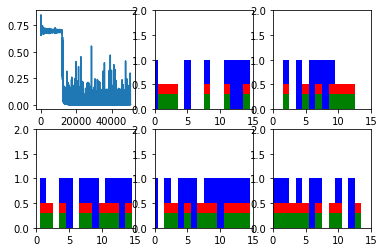

Step 200 Loss 0.000496044
single_output_series: [0 1 0 0 0 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 1 0 1 0 0 1 0]

single_output_series: [0 0 0 0 1 0 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 0 1 0 1 1 1]

single_output_series: [1 1 0 0 0 1 1 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 1 0 0 0 0 0]

single_output_series: [1 1 1 1 0 1 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 0 1 1 1 0]

single_output_series: [0 1 0 1 0 1 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 0 0 1 1 1 0]



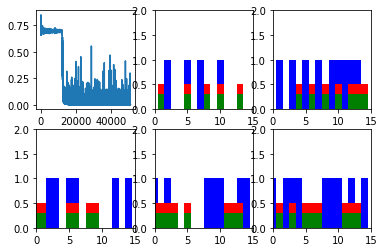

Step 300 Loss 0.000337604
single_output_series: [0 1 1 1 0 1 0 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 1 1 1 1 0 0 0]

single_output_series: [1 1 1 0 1 0 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 1 0 1 0 0 1 0]

single_output_series: [0 1 1 1 0 0 1 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 0 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 0 0 0 1 1 0 1]

single_output_series: [0 1 0 0 0 1 1 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 1 1 1 1 1 1 0]



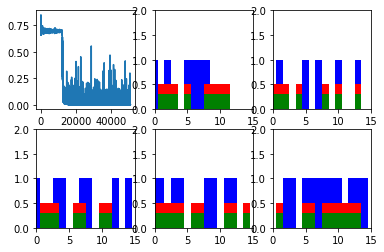

Step 400 Loss 0.000338101
single_output_series: [0 0 1 0 0 0 1 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 1 0 0 0 0 1]

single_output_series: [1 0 1 1 1 0 1 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 1 1 1 1 0 0]

single_output_series: [0 0 0 1 1 0 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 1 0 1 0 1 1]

single_output_series: [1 0 1 0 1 0 0 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 1 1 1 1 1 0]

single_output_series: [1 1 0 0 0 1 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 0 0 0 0 0 0 1]



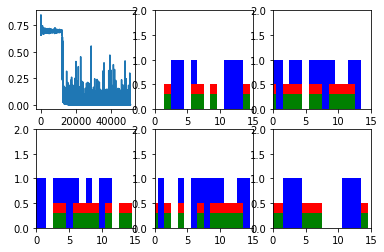

Step 500 Loss 0.000333798
single_output_series: [0 1 1 1 0 0 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 0 0 1 1 0 1]

single_output_series: [1 1 1 1 0 0 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 0 0 0 1 0 1]

single_output_series: [1 1 1 0 0 0 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 1 1 0 0 1 0]

single_output_series: [0 1 1 0 1 1 1 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 0 0 1 1 0 0]

single_output_series: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 1 0 1 1 1 0]



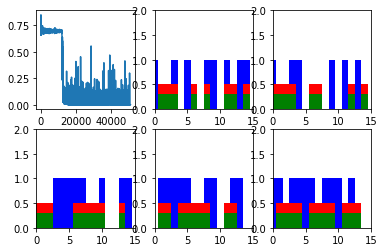

Step 600 Loss 0.000360498
single_output_series: [1 1 1 0 1 1 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 0 0 1 1 1 0 0]

single_output_series: [0 1 0 1 1 1 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 0 1 0 1 0 0]

single_output_series: [1 1 1 0 1 0 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 1 1 1 1 0 1]

single_output_series: [1 0 1 1 0 1 0 0 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 1 0 0 1 1 1]

single_output_series: [1 0 1 1 1 1 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 1 1 1 1 0 1]



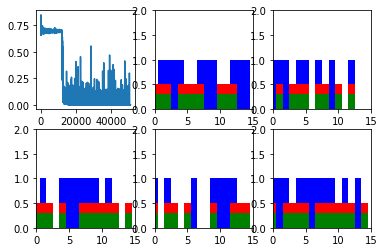

New data, epoch 77
Step 0 Loss 0.198728
single_output_series: [0 1 0 1 1 0 0 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 0 1 0 0 1 0 1]

single_output_series: [0 1 0 0 0 1 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 0 0 0 0 1 0]

single_output_series: [0 1 0 1 1 0 0 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 0 1 1 1 1 1]

single_output_series: [0 1 0 1 1 1 1 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 0 1 0 0 0 0]

single_output_series: [0 1 0 1 0 1 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 0 1 0 1 1 0 1]



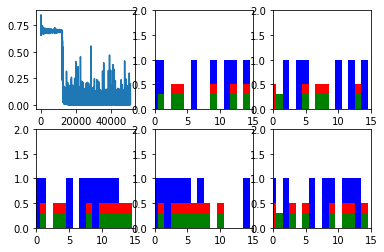

Step 100 Loss 0.000363174
single_output_series: [0 1 0 1 0 1 0 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 1 1 1 1 0 0 1]

single_output_series: [0 1 0 0 1 0 1 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 0 0 1 1 1 1]

single_output_series: [0 0 1 0 0 0 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 1 1 1 1 0 1]

single_output_series: [0 1 0 0 1 1 1 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 1 0 0 0 1 0]

single_output_series: [1 0 0 1 0 0 0 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 1 1 0 0 1 1 1]



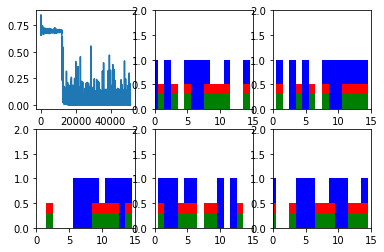

Step 200 Loss 0.000378164
single_output_series: [1 0 1 1 1 1 0 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 0 1 0 0 1 1]

single_output_series: [0 1 1 0 1 0 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 1 1 0 1 0 1 1]

single_output_series: [0 1 1 0 0 0 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 0 1 1 1 1 0 0]

single_output_series: [0 0 1 0 0 0 1 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 0 1 0 1 0 1]

single_output_series: [1 1 0 0 1 1 0 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 1 0 1 0 1 1]



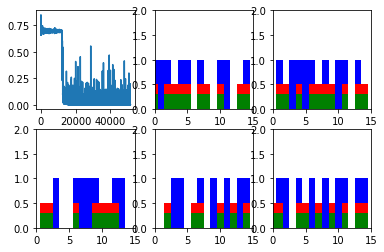

Step 300 Loss 0.000276558
single_output_series: [1 0 1 0 0 0 1 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 1 0 0 0 0 0]

single_output_series: [0 0 1 1 1 0 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 0 1 1 1 0]

single_output_series: [0 0 1 0 0 1 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 1 0 0 0 0 0]

single_output_series: [1 1 0 1 1 1 0 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 1 1 0 0 1 0]

single_output_series: [1 1 1 1 1 0 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 0 0 0 1 1 1 0]



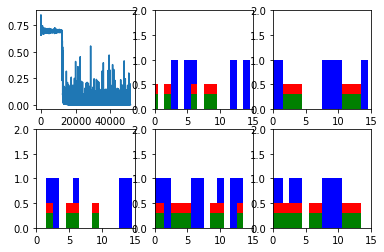

Step 400 Loss 0.000271744
single_output_series: [0 0 1 1 0 1 1 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 0 0 0 0 0 1]

single_output_series: [0 0 1 1 0 0 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 0 0 1 1 1 1]

single_output_series: [1 0 1 0 1 1 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 0 1 1 1 0 0]

single_output_series: [0 0 0 1 1 1 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 1 1 0 0 0 0]

single_output_series: [1 1 1 0 1 0 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 0 0 1 1 1 1]



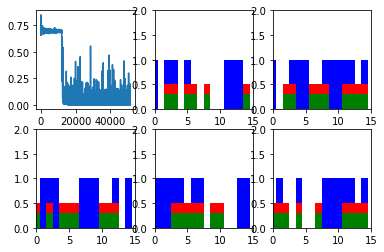

Step 500 Loss 0.000322756
single_output_series: [0 1 0 0 1 1 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 0 1 1 0 0 1]

single_output_series: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 1 0 1 0 1 1]

single_output_series: [0 1 1 1 0 1 0 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 1 0 0 0 1 1]

single_output_series: [0 0 1 1 1 1 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 0 1 1 1 0]



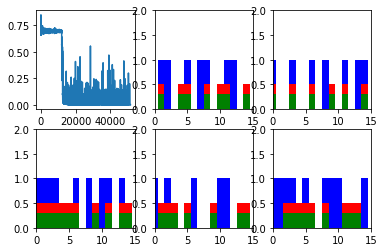

Step 600 Loss 0.000311836
single_output_series: [1 1 1 0 0 0 0 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 1 1 0 1 0 1]

single_output_series: [0 1 1 1 1 1 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 1 0 1 1 0 1]

single_output_series: [0 0 0 1 0 1 0 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 0 1 0 1 1]

single_output_series: [1 1 0 0 1 0 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 0 0 1 0 1 1]

single_output_series: [0 1 1 0 1 0 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 1 0 0 1 0 0]



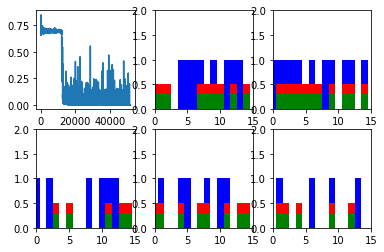

New data, epoch 78
Step 0 Loss 0.261487
single_output_series: [0 1 0 1 1 0 1 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 1 1 0 1 1 0]

single_output_series: [0 1 0 1 1 1 1 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 1 0 1 1 0 1 1]

single_output_series: [0 1 0 1 1 0 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 1 0 1 0 0 1]

single_output_series: [0 1 0 0 0 1 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 0 1 0 1 0 1 0]

single_output_series: [0 1 0 1 1 0 0 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 0 0 1 0 1 1]



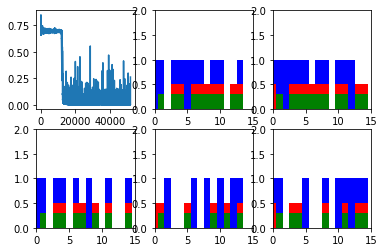

Step 100 Loss 0.000361107
single_output_series: [1 0 0 0 1 0 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 0 0 0 0 1 1]

single_output_series: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 0 0 1 0 1 1]

single_output_series: [1 0 1 0 0 1 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 0 1 0 1 0 0 0]

single_output_series: [0 0 0 0 1 0 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 1 1 1 0 0 1]

single_output_series: [1 1 1 0 0 0 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 1 0 1 1 1 1]



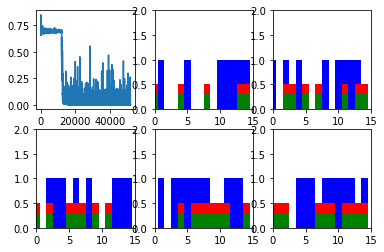

Step 200 Loss 0.000313713
single_output_series: [0 1 1 0 1 1 0 0 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 0 0 1 0 1 1 0]

single_output_series: [0 0 1 0 0 1 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 1 1 1 1 0 0]

single_output_series: [0 0 1 0 1 0 1 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 0 0 1 0 0 1]

single_output_series: [0 0 1 1 1 0 1 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 0 0 0 0 1 0 0]

single_output_series: [0 1 1 1 0 0 1 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 0 0 0 0 0 0 1]



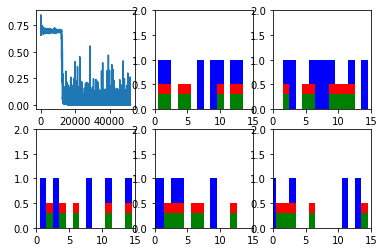

Step 300 Loss 0.000344917
single_output_series: [0 1 1 0 0 1 1 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 1 0 0 1 0 1]

single_output_series: [1 0 1 1 0 0 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 0 0 0 1 0 0 0]

single_output_series: [0 0 1 1 0 0 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 0 1 0 0 1 0]

single_output_series: [1 0 1 0 1 0 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 0 0 1 0 1 1 1]

single_output_series: [1 0 1 1 1 1 0 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 0 1 0 1 0 1 1]



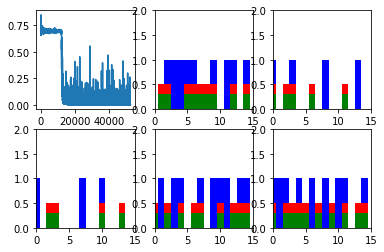

Step 400 Loss 0.000272188
single_output_series: [1 0 1 1 1 1 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 1 1 0 0 0 1]

single_output_series: [1 0 0 0 0 1 1 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 0 1 0 0 1 1]

single_output_series: [0 0 0 1 1 1 1 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 0 0 0 1 0 0]

single_output_series: [0 1 1 0 0 1 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 1 0 0 0 1 1 0]

single_output_series: [0 0 1 0 0 1 1 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 0 1 1 0 0 1]



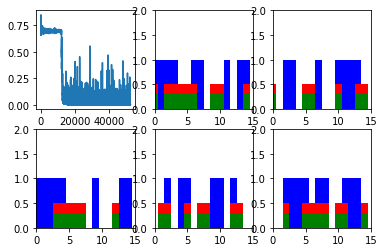

Step 500 Loss 0.000354893
single_output_series: [1 1 0 1 0 0 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 1 0 1 0 1 1 0]

single_output_series: [1 0 0 0 1 0 1 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 1 0 0 0 0 1]

single_output_series: [1 1 0 1 1 1 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 1 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 1 0 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 0 0 0 1 0 0]

single_output_series: [1 0 0 1 1 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 0 1 0 0 0 1]



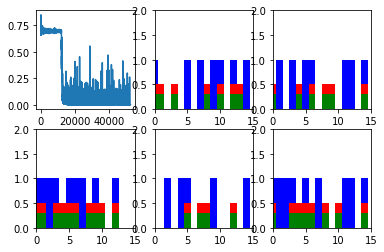

Step 600 Loss 0.000349579
single_output_series: [0 0 0 1 0 0 0 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 1 1 1 1 0 0]

single_output_series: [1 0 1 0 1 1 1 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 1 1 1 1 0 0 1]

single_output_series: [1 0 1 0 1 1 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 0 1 0 1 1 0]

single_output_series: [1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]

single_output_series: [1 0 1 1 0 1 1 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 1 1 0 0 1]



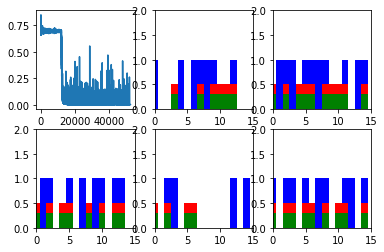

New data, epoch 79
Step 0 Loss 0.0941791
single_output_series: [0 0 0 0 1 0 0 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 0 0 1 1 1 0]

single_output_series: [0 1 0 1 0 1 0 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 1 1 0 0 0 0 1]

single_output_series: [0 1 0 1 1 0 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 1 0 1 1 1 0 0]

single_output_series: [0 1 0 1 0 0 1 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 0 1 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 1 0 0 1 0 1]



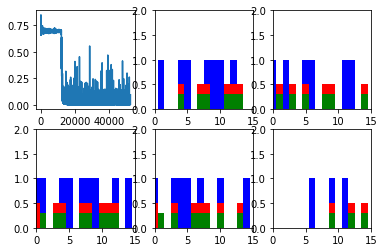

Step 100 Loss 0.000277166
single_output_series: [0 0 1 1 1 0 0 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 0 1 1 0 1 1 1]

single_output_series: [0 1 0 0 1 0 0 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 1 1 1 0 0 0]

single_output_series: [0 1 0 0 0 1 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 0 0 1 0 0 1 0]

single_output_series: [0 0 0 1 1 1 0 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 0 0 1 0 1]

single_output_series: [0 1 1 1 1 1 0 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 1 1 1 0 0 0]



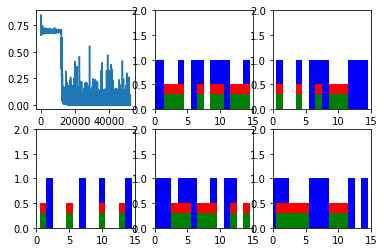

Step 200 Loss 0.000351181
single_output_series: [1 0 0 1 0 0 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 1 0 1 1 1 1]

single_output_series: [0 1 0 1 0 0 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 1 0 0 1 0 1]

single_output_series: [0 0 1 0 1 0 0 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 1 0 0 1 0 1]

single_output_series: [1 1 1 1 1 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 1 0 1 0 0 0 0]

single_output_series: [1 0 1 1 0 1 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 0 1 1 0 0 1 1]



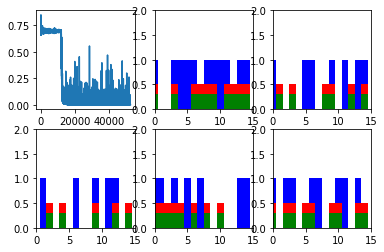

Step 300 Loss 0.000239975
single_output_series: [1 1 0 0 0 0 0 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 0 1 0 1 1 1]

single_output_series: [1 0 0 0 0 1 1 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 0 0 0 0 0 1 1]

single_output_series: [0 0 1 1 1 1 0 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 0 0 1 1 0 0 0]

single_output_series: [0 0 0 0 1 1 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 1 0 1 0 0 0]

single_output_series: [1 0 1 1 1 1 1 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 0 0 1 0 0 1]



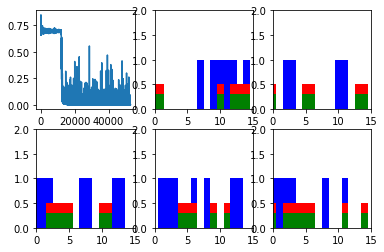

Step 400 Loss 0.000314186
single_output_series: [0 1 1 0 1 1 0 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 0 0 0 1 0]

single_output_series: [1 0 1 1 0 1 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 1 1 1 1 0]

single_output_series: [0 0 0 1 0 1 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 0 1 1 0 0 1 1]

single_output_series: [0 1 1 1 0 0 0 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 1 0 0 0 0]

single_output_series: [0 1 0 0 0 1 0 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 1 0 0 1 1 0 1]



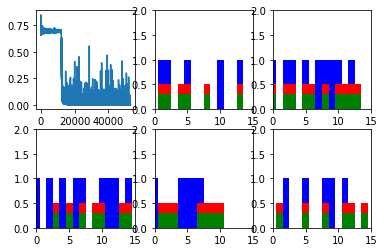

Step 500 Loss 0.000281142
single_output_series: [0 1 1 1 0 1 1 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 0 0 0 0 1 1 0]

single_output_series: [0 1 0 0 0 0 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 0 0 0 1 1 1 0]

single_output_series: [0 1 0 0 0 1 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 0 0 0 1 0 1]

single_output_series: [1 0 0 0 1 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 0 1 0 0 0]

single_output_series: [1 0 1 1 0 1 0 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 1 0 0 0 1 1]



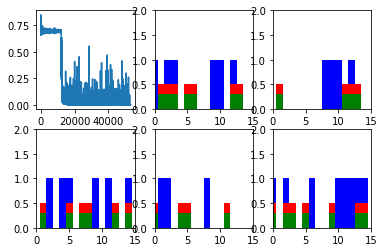

Step 600 Loss 0.000289438
single_output_series: [1 1 1 1 0 1 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 1 1 0 0 0 0]

single_output_series: [0 1 1 0 1 1 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 1 0 1 1 0 0 0]

single_output_series: [0 1 1 0 1 0 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 0 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 1 1 1 1 1 0]

single_output_series: [0 0 1 0 0 1 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 0 1 0 0 1 0]



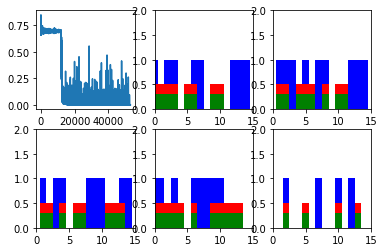

New data, epoch 80
Step 0 Loss 0.245368
single_output_series: [0 0 0 0 1 0 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 0 0 0 1 1 1 0]

single_output_series: [0 0 0 1 0 1 1 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 0 0 0 1 0 0]

single_output_series: [0 0 0 0 0 0 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 0 0 0 1 0 1]

single_output_series: [0 0 0 1 0 0 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 0 0 0 1 0 0]

single_output_series: [0 0 0 0 1 1 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 1 0 1 0 0 1 0]



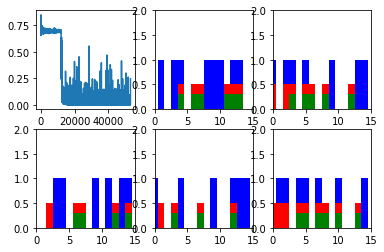

Step 100 Loss 0.000326711
single_output_series: [0 0 0 1 0 1 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 0 1 1 0 1 0]

single_output_series: [1 1 1 1 1 1 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 0 1 0 1 0 0]

single_output_series: [1 1 0 1 1 1 0 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 0 1 0 0 0 0]

single_output_series: [1 1 0 1 0 0 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 1 0 0 0 0 1 0]

single_output_series: [1 0 1 1 1 1 1 0 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 1 0 0 1 1 1]



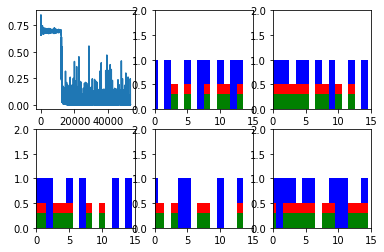

Step 200 Loss 0.000225624
single_output_series: [0 1 0 0 1 1 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 1 0 0 0 0 1 1]

single_output_series: [1 1 0 0 1 1 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 0 0 1 1 1 0 1]

single_output_series: [0 1 1 0 1 1 0 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 1 1 0 1 0 0]

single_output_series: [0 0 1 0 0 1 1 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 0 0 0 1 0 0]

single_output_series: [1 1 0 1 1 1 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 0 0 0 0 0 1]



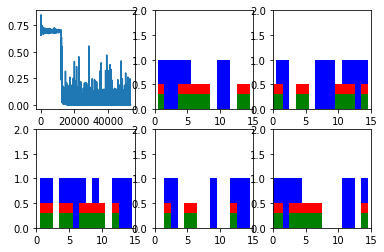

Step 300 Loss 0.000324487
single_output_series: [1 0 0 1 1 0 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 0 1 0 1 1 1]

single_output_series: [1 1 1 1 0 1 0 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 0 1 1 0 1 1]

single_output_series: [0 1 0 1 0 0 0 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 1 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 1 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 1 1 0 1 1 1]

single_output_series: [1 0 1 1 0 0 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 1 0 1 1 0 1]



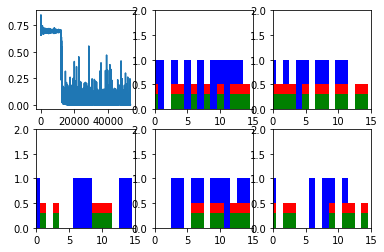

Step 400 Loss 0.000294872
single_output_series: [1 0 0 0 0 0 0 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 0 1 1 0 0 1]

single_output_series: [0 1 0 0 1 0 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 0 1 1 0 1 1 1]

single_output_series: [0 1 0 0 1 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 0 0 1 1 0 1 1]

single_output_series: [1 1 0 1 0 0 0 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 1 1 1 1 0 1]

single_output_series: [1 1 1 0 1 1 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 0 0 0 1 1 0 1]



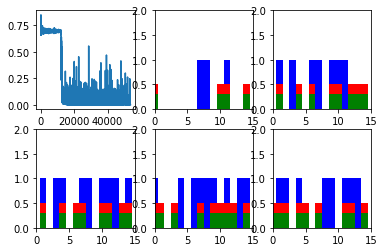

Step 500 Loss 0.000244986
single_output_series: [1 1 0 1 1 0 0 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 0 1 1 1 1 1]

single_output_series: [1 0 0 1 1 0 0 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 0 0 1 1 0 1 1]

single_output_series: [0 1 0 0 0 1 0 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 0 0 1 0 0 0 1]

single_output_series: [0 1 0 0 0 0 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 1 1 0 0 0 1 1]

single_output_series: [1 1 0 1 1 0 0 0 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 1 0 0 1 1 1]



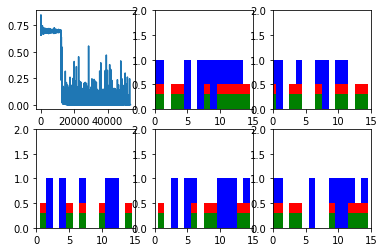

Step 600 Loss 0.000241934
single_output_series: [1 0 0 0 0 0 0 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 0 0 1 1 1 1 0]

single_output_series: [0 1 1 0 0 1 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 1 0 0 0 0 0]

single_output_series: [1 1 1 0 0 1 1 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 1 0 0 1 1 0]

single_output_series: [0 1 1 0 0 0 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 0 0 1 1 1 0 0]

single_output_series: [1 1 0 0 1 1 1 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 1 1 1 0 0 1]



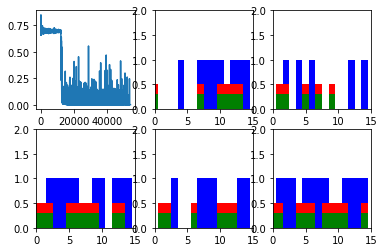

New data, epoch 81
Step 0 Loss 0.183392
single_output_series: [0 1 0 1 1 1 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 1 0 1 1 1 0]

single_output_series: [0 0 1 0 1 1 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 0 1 0 1 0 1]

single_output_series: [0 0 1 0 0 1 0 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 0 1 0 1 1 0]

single_output_series: [0 1 0 1 1 1 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 0 1 1 0 0 0]

single_output_series: [0 1 0 1 1 1 0 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 0 1 1 0 1 0]



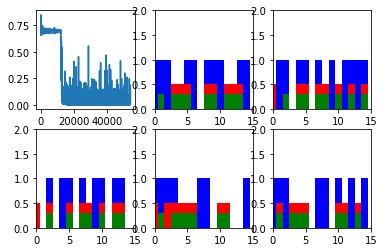

Step 100 Loss 0.000256954
single_output_series: [1 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 0 1 0 0 1 0]

single_output_series: [1 0 0 1 0 0 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 1 1 0 0 1 0]

single_output_series: [0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]

single_output_series: [0 0 0 0 1 1 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 0 1 0 1 0]

single_output_series: [0 0 1 1 0 0 0 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 1 1 1 0 1 0 1]



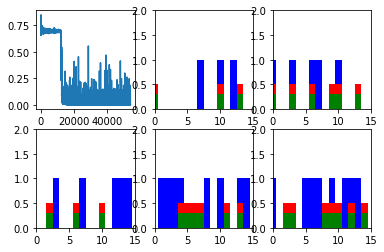

Step 200 Loss 0.000311865
single_output_series: [1 0 0 1 0 1 1 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 1 0 1 0 1 1]

single_output_series: [1 0 1 0 1 0 0 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 1 1 1 1 1 0]

single_output_series: [0 1 1 1 0 0 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 1 0 0 1 0 1]

single_output_series: [1 0 1 0 0 0 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 1 0 0 0 0 1 1]

single_output_series: [0 1 0 1 0 1 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 0 0 1 1 1 0]



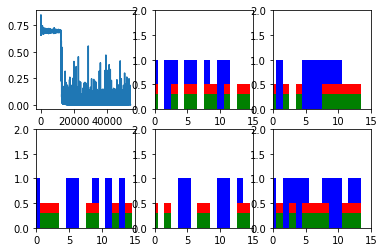

Step 300 Loss 0.00026644
single_output_series: [1 1 1 0 1 1 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 0 0 0 0 1 0 1]

single_output_series: [0 1 1 0 1 0 1 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 1 1 1 0 0 1 0]

single_output_series: [1 0 1 0 0 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 0 0 0 1 1 1 0]

single_output_series: [0 1 0 0 1 0 0 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 1 0 1 1 1 0]

single_output_series: [0 1 1 1 0 0 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 1 1 0 0 1 1]



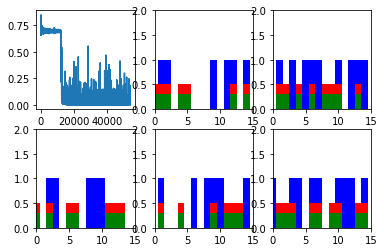

Step 400 Loss 0.000226373
single_output_series: [1 0 1 1 0 0 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 1 1 0 0 0 1]

single_output_series: [0 0 0 1 1 0 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 0 0 1 1 0 1 0]

single_output_series: [0 0 1 0 0 0 0 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 1 0 0 1 1 0 0]

single_output_series: [1 1 1 1 0 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 0 0 1 1 0 0]

single_output_series: [0 0 1 1 0 1 1 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 1 1 1 1 1 1]



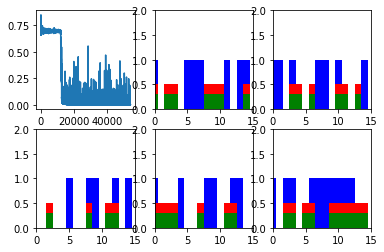

Step 500 Loss 0.000227165
single_output_series: [0 0 1 1 0 0 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 0 0 0 0 1 0]

single_output_series: [1 0 0 0 1 0 0 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 0 1 1 0 0 1]

single_output_series: [0 1 1 0 0 0 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 1 0 1 0 0 0]

single_output_series: [0 1 0 0 1 1 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 1 0 0 1 0 0]

single_output_series: [1 1 1 0 0 0 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 0 0 0 0 1 0]



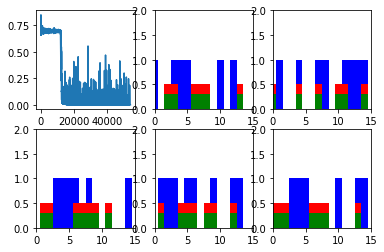

Step 600 Loss 0.000276705
single_output_series: [1 0 1 1 1 1 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 0 0 0 1 0 1]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 1 1 0 1 0 0]

single_output_series: [1 1 1 0 0 1 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 0 0 0 0 0 0 1]

single_output_series: [1 0 0 1 1 1 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 0 0 0 0 1 1]

single_output_series: [1 0 1 0 1 0 0 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 0 1 1 1 1 0]



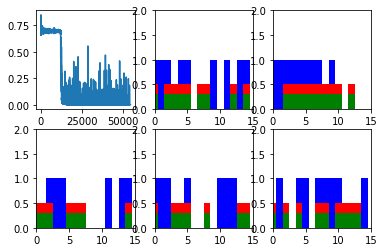

New data, epoch 82
Step 0 Loss 0.194602
single_output_series: [0 0 0 1 1 1 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 1 0 1 1 0 1]

single_output_series: [0 0 1 0 0 1 0 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 0 1 0 0 0 0 0]

single_output_series: [0 0 1 0 0 0 0 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 0 0 1 1 0 0]

single_output_series: [0 0 0 1 1 1 1 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 1 0 0 0 0]

single_output_series: [0 0 1 0 1 0 0 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 1 0 1 1 1 0]



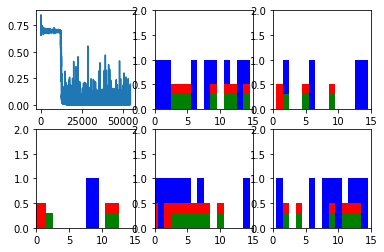

Step 100 Loss 0.000313621
single_output_series: [1 1 0 0 1 0 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 0 0 0 0 0 0]

single_output_series: [1 0 0 1 0 1 0 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 0 1 1 0 0 1 1]

single_output_series: [1 0 0 0 1 1 0 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 0 0 0 1 0]

single_output_series: [0 1 1 0 1 0 1 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 0 1 0 1 1 0]

single_output_series: [1 0 1 0 0 1 0 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 1 0 1 1 0 0 0]



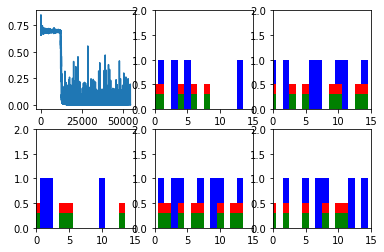

Step 200 Loss 0.000242167
single_output_series: [0 1 1 1 1 0 1 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 1 1 1 0 0 0]

single_output_series: [1 0 1 1 1 1 0 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 0 0 0 0 0 1]

single_output_series: [0 1 1 0 1 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 1 0 1 0 0 0 1]

single_output_series: [1 1 0 0 1 0 0 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 0 1 1 1 1 1 1]

single_output_series: [0 1 1 0 1 1 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 0 0 0 0 1 1]



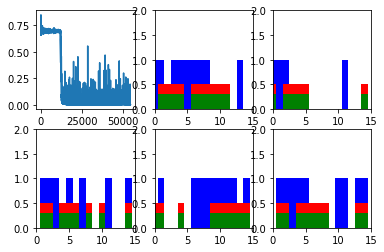

Step 300 Loss 0.000309266
single_output_series: [1 0 1 0 0 0 0 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 1 0 1 0 0 1]

single_output_series: [0 0 0 0 0 1 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 1 0 1 1 0 1]

single_output_series: [0 0 1 1 0 0 1 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 0 1 0 0 0 0]

single_output_series: [0 0 0 1 0 0 1 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 0 0 0 1 1 0]

single_output_series: [0 0 0 1 0 0 0 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 0 1 0 1 1 0]



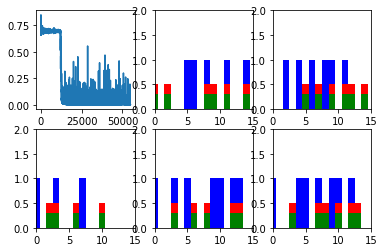

Step 400 Loss 0.000247466
single_output_series: [1 1 0 0 1 0 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 1 1 1 1 1 1]

single_output_series: [1 0 1 1 1 1 0 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 0 1 0 0 0 1]

single_output_series: [0 1 1 0 1 0 0 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 1 1 1 1 1 0]

single_output_series: [0 1 1 0 1 1 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 0 0 0 0 0 0]

single_output_series: [1 0 1 1 0 0 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 1 0 0 1 0 0]



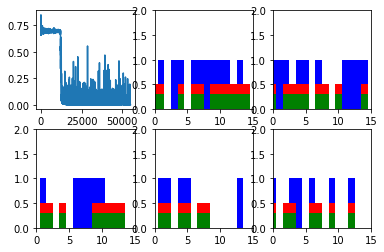

Step 500 Loss 0.000336656
single_output_series: [0 1 0 0 1 1 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 0 0 1 1 1 0]

single_output_series: [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1]

single_output_series: [1 0 1 0 0 0 1 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 0 0 0 1 1]

single_output_series: [1 1 1 1 0 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 0 1 0 1 0 0 0]

single_output_series: [1 0 1 0 0 1 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 1 1 1 1 0 1]



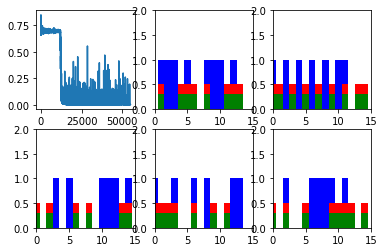

Step 600 Loss 0.000266605
single_output_series: [0 0 1 0 1 0 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 1 0 1 1 1 1 0]

single_output_series: [0 0 0 1 0 1 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 1 1 1 0 1 0 0]

single_output_series: [0 0 0 1 0 1 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 1 1 1 0 0 1]

single_output_series: [0 1 0 0 1 1 0 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 0 0 0 0 0 1]

single_output_series: [1 0 1 0 1 1 1 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 0 0 1 1 1 1 0]



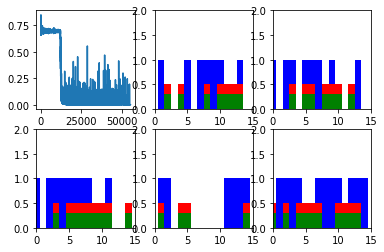

New data, epoch 83
Step 0 Loss 0.18048
single_output_series: [0 0 0 0 1 0 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 0 0 0 1 1 1]

single_output_series: [0 0 0 0 1 1 0 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 0 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 0 1 0 0 0 1]

single_output_series: [0 0 0 0 0 0 1 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 1 1 0 0 1 0]

single_output_series: [0 0 0 1 1 1 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 1 0 1 0 0 1 1]



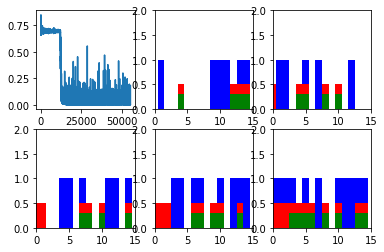

Step 100 Loss 0.00027567
single_output_series: [0 1 0 0 1 1 0 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 0 0 1 0 0 1]

single_output_series: [0 0 1 1 1 0 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 1 0 0 0 1]

single_output_series: [1 1 0 0 1 1 0 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 1 0 1 0 0 0]

single_output_series: [1 0 0 1 0 1 0 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 1 1 0 1 0 1]

single_output_series: [1 0 0 0 0 0 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 0 0 0 0 1 0]



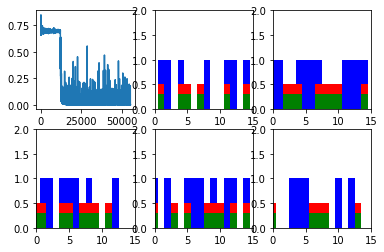

Step 200 Loss 0.000281982
single_output_series: [0 1 0 1 1 1 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 0 1 1 0 1 1]

single_output_series: [0 1 0 1 0 0 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 0 0 1 1 1 1 1]

single_output_series: [1 0 1 1 0 1 1 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 1 1 0 0 1]

single_output_series: [1 1 0 1 0 1 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 0 0 0 1 0 1 1]

single_output_series: [1 0 1 1 0 0 1 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 0 1 1 0 1 1 0]



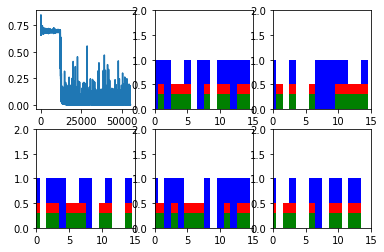

Step 300 Loss 0.000276602
single_output_series: [1 0 1 0 0 0 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 1 1 0 1 1 0]

single_output_series: [0 0 1 1 0 1 0 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 0 1 1 1 1 0]

single_output_series: [1 1 0 1 1 0 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 0 1 1 0 0 1]

single_output_series: [0 0 0 1 1 1 0 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 0 0 1 0 0 0 1]

single_output_series: [0 1 1 1 0 0 0 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 1 1 1 1 1 1]



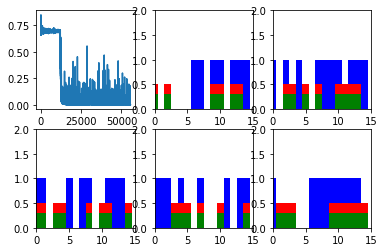

Step 400 Loss 0.0002488
single_output_series: [0 0 0 0 1 1 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 0 0 1 1 1]

single_output_series: [0 1 0 0 1 1 0 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 1 1 1 1 1 1]

single_output_series: [0 1 0 1 1 1 0 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 1 0 0 0 1 0]

single_output_series: [1 0 1 1 0 0 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 0 0 0 0 1 1]

single_output_series: [1 1 0 1 1 0 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 0 1 0 0 0 1 1]



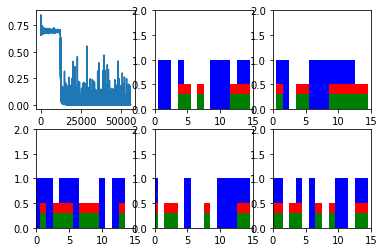

Step 500 Loss 0.000291483
single_output_series: [1 0 1 0 0 0 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 1 1 1 0 1]

single_output_series: [0 1 1 1 1 0 0 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 1 0 1 1 0 0 0]

single_output_series: [0 1 0 0 0 1 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 1 1 1 0 1 1]

single_output_series: [0 1 0 0 0 1 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 0 0 0 0 1 0 0]

single_output_series: [1 1 1 0 1 0 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 0 1 0 1 0 1]



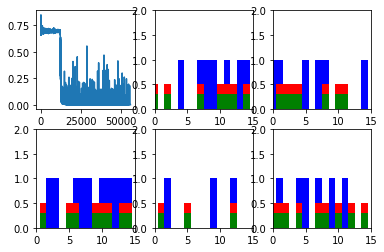

Step 600 Loss 0.000228863
single_output_series: [0 1 0 1 1 0 0 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 0 1 1 1 1 1 0]

single_output_series: [0 1 1 1 0 1 1 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 0 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 1 0 0 1 1 0]

single_output_series: [0 1 0 1 0 0 0 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 1 0 0 0 1 0 0]

single_output_series: [0 1 1 0 0 0 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 1 0 0 0 1 1 0]



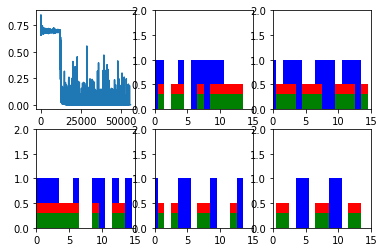

New data, epoch 84
Step 0 Loss 0.126976
single_output_series: [1 0 1 1 0 0 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 1 0 0 0 0 0]

single_output_series: [1 0 1 1 1 0 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 1 1 0 0 0 1]

single_output_series: [1 0 0 0 1 1 0 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 0 0 0 0 1]

single_output_series: [1 0 1 1 1 0 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 0 0 1 0 0 0]

single_output_series: [1 0 1 1 0 0 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 0 0 0 1 0 1]



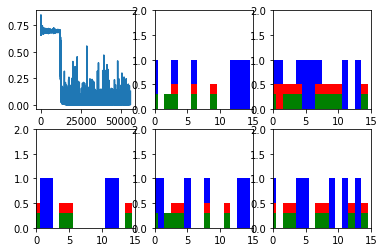

Step 100 Loss 0.000240047
single_output_series: [1 1 1 1 0 0 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 1 1 0 1 1 1 0]

single_output_series: [0 1 0 0 1 1 0 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 1 1 1 0 1 1]

single_output_series: [1 0 1 1 1 0 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 1 0 0 1 0]

single_output_series: [1 0 1 0 1 0 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 0 0 1 1 0 1]

single_output_series: [1 1 1 0 1 1 0 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 0 0 0 0 1 0]



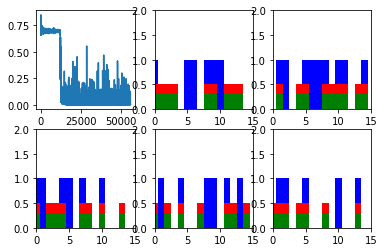

Step 200 Loss 0.000278645
single_output_series: [1 0 0 0 0 1 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 1 1 1 1 0 1 1]

single_output_series: [1 0 1 1 0 1 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 1 0 1 0 0 0]

single_output_series: [1 1 0 1 1 0 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 0 1 1 0 1 0]

single_output_series: [0 0 0 1 0 1 0 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 0 1 1 1 0 1 1]

single_output_series: [0 0 0 1 1 1 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 0 1 0 0 1 0]



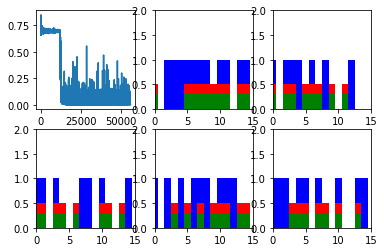

Step 300 Loss 0.000335458
single_output_series: [0 0 0 0 0 1 0 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 1 1 0 0 1 0]

single_output_series: [1 0 1 0 1 0 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 1 0 0 0 0 1 0]

single_output_series: [1 0 0 0 1 1 1 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 1 0 0 0 0 1]

single_output_series: [1 1 0 1 0 1 1 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 0 0 0 1 1 0]

single_output_series: [1 1 1 0 1 0 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 0 1 0 1 1 1 0]



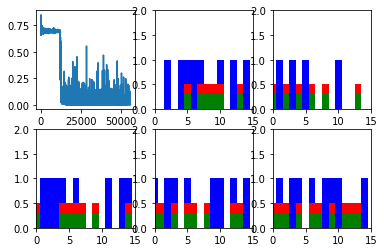

Step 400 Loss 0.00021352
single_output_series: [0 1 1 1 0 0 1 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 0 0 1 1 1 1]

single_output_series: [0 1 0 0 1 1 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 0 1 1 1 1 0]

single_output_series: [1 1 0 1 0 0 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 0 1 1 1 0 1]

single_output_series: [1 1 1 0 0 1 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 0 1 0 0 1 1 0]

single_output_series: [1 0 0 0 1 1 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 1 1 0 0 1 0 0]



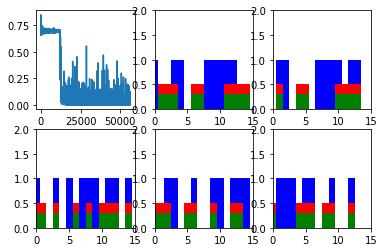

Step 500 Loss 0.0002435
single_output_series: [0 1 0 0 0 1 1 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 0 0 1 0 1 1]

single_output_series: [0 0 1 0 1 1 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 1 0 0 0 0 0 0]

single_output_series: [1 0 1 0 1 1 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 0 1 1 1 1 1]

single_output_series: [0 0 1 0 0 0 1 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 0 0 1 1 1 1]

single_output_series: [0 0 1 0 0 0 0 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 0 1 0 1 0 1]



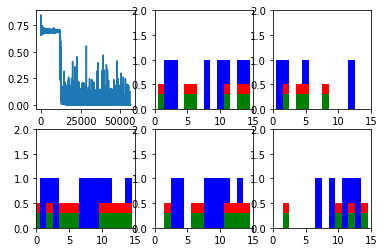

Step 600 Loss 0.000269525
single_output_series: [0 1 1 0 1 1 0 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 1 1 1 0 0]

single_output_series: [1 1 0 0 1 0 1 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 1 0 1 1 1 1]

single_output_series: [1 0 0 1 0 0 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 0 1 0 0 1 1 0]

single_output_series: [1 1 1 1 0 1 1 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 0 0 0 0 0 0]

single_output_series: [0 1 0 1 0 1 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 1 0 1 0 0 1]



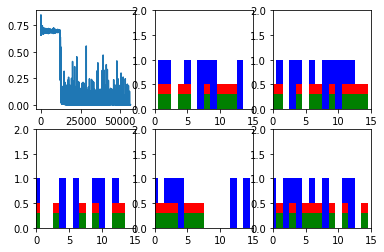

New data, epoch 85
Step 0 Loss 0.162345
single_output_series: [0 0 0 0 0 0 0 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 0 1 1 1 1 0]

single_output_series: [0 1 0 1 0 0 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 0 0 0 0 0 0]

single_output_series: [0 1 0 1 0 1 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 1 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 1 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 1 0 1 1 1 1]

single_output_series: [0 1 0 1 0 1 0 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 1 1 0 1 1 1]



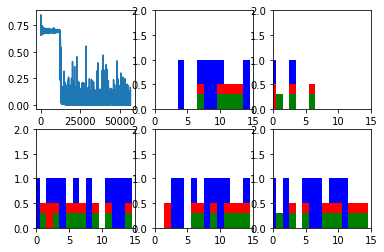

Step 100 Loss 0.000246202
single_output_series: [1 1 1 1 1 1 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 1 0 1 1 0 0 0]

single_output_series: [1 1 0 1 0 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 1 0 1 0 1 0]

single_output_series: [1 1 0 0 0 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 1 0 1 0 1 1 1]

single_output_series: [0 1 0 0 1 1 0 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 1 0 1 1 0 0]

single_output_series: [1 1 0 0 0 1 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 1 0 0 0 0 0]



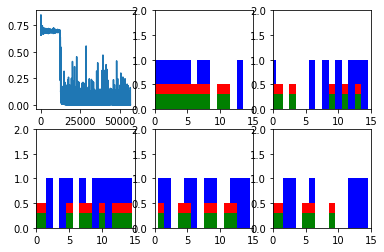

Step 200 Loss 0.000266066
single_output_series: [1 0 0 1 1 1 1 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 0 0 1 1 1 1]

single_output_series: [0 0 0 0 1 1 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 0 0 1 0 0 1 0]

single_output_series: [0 1 0 1 1 0 0 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 1 0 1 1 0 1 1]

single_output_series: [1 1 1 0 1 1 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 1 0 1 0 1 0 0]

single_output_series: [1 0 1 0 0 0 1 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 1 0 1 0 1 0]



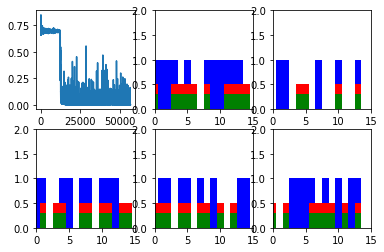

Step 300 Loss 0.000274012
single_output_series: [0 1 0 0 1 0 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 1 0 1 0 1]

single_output_series: [0 1 0 1 1 1 1 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 1 0 1 0 0 0]

single_output_series: [1 1 0 0 1 1 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 0 1 1 1 1 1 1]

single_output_series: [0 0 0 1 0 1 0 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 0 0 1 1 0]

single_output_series: [1 1 0 1 0 0 1 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 0 1 1 0 1 0 0]



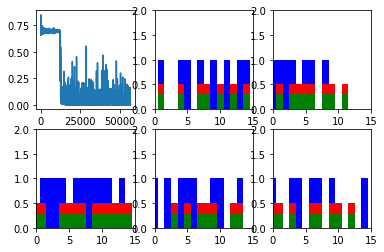

Step 400 Loss 0.000210518
single_output_series: [0 0 1 0 1 0 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 0 0 1 1 1 1]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 1 1 0 0 0 1]

single_output_series: [0 1 1 1 1 1 0 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 1 1 0 1 0 1 1]

single_output_series: [0 0 0 1 0 0 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 1 1 0 0 1 1]

single_output_series: [1 0 1 1 1 1 1 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 0 1 0 0 1]



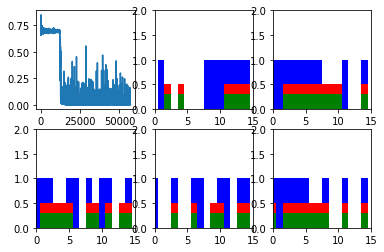

Step 500 Loss 0.000223967
single_output_series: [0 1 1 0 0 1 0 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 1 1 1 0 1 1]

single_output_series: [1 0 0 0 0 0 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 1 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 0 1 0 1 1 0]

single_output_series: [1 1 0 1 1 1 1 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 1 1 0 0 0 0]

single_output_series: [0 0 0 1 0 1 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 1 1 0 0 1 0]



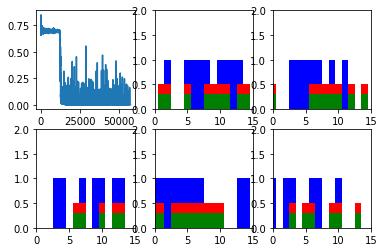

Step 600 Loss 0.000303027
single_output_series: [1 0 0 1 0 1 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 0 0 0 0 1 0]

single_output_series: [1 1 1 0 0 0 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 1 0 1 1 1 0]

single_output_series: [0 0 1 1 0 1 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 1 0 1 0 1 1]

single_output_series: [0 0 1 0 0 1 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 0 0 0 1 0 1]

single_output_series: [1 1 1 1 0 0 0 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 1 0 1 0 1 0]



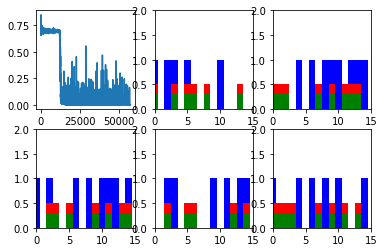

New data, epoch 86
Step 0 Loss 0.191031
single_output_series: [1 0 1 0 0 1 0 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 0 1 1 0 1 1]

single_output_series: [1 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 1 1 1 0 1 1]

single_output_series: [1 0 1 1 0 1 1 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 0 1 1 0 1 1]

single_output_series: [1 0 0 0 1 0 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 1 0 0 1 0 0]

single_output_series: [1 0 1 0 0 1 0 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 1]



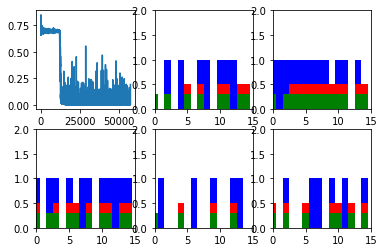

Step 100 Loss 0.000316268
single_output_series: [1 0 0 0 1 1 1 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 1 0 1 0 1 0]

single_output_series: [1 0 1 0 1 1 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 0 0 1 0 1 0 0]

single_output_series: [1 1 0 0 0 1 0 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 1 1 0 0 0 0 0]

single_output_series: [0 1 0 1 0 1 0 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 1 0 1 1 1 0 0]

single_output_series: [0 0 0 1 0 0 0 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 1 0 0 0 0 1]



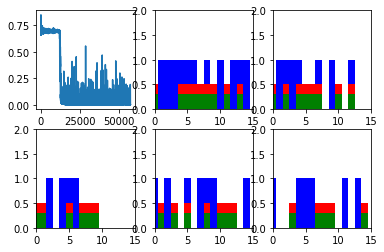

Step 200 Loss 0.000291867
single_output_series: [1 1 0 1 0 1 0 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 1 0 0 1 0 0 1]

single_output_series: [1 0 0 1 0 1 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 1 1 0 0 0 1]

single_output_series: [0 0 1 1 1 1 1 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 0 1 0 0 0 1 1]

single_output_series: [0 0 0 0 1 1 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 0 0 1 0 1 1]

single_output_series: [1 1 0 0 0 0 1 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 0 1 1 0 1 1]



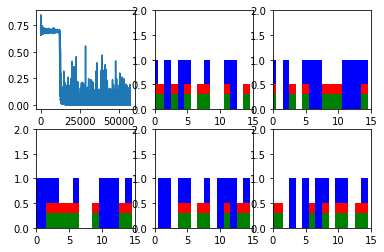

Step 300 Loss 0.0002596
single_output_series: [1 0 1 0 0 0 1 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 1 0 1 1 0 0]

single_output_series: [1 1 1 0 0 0 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 1 0 0 1 0 0]

single_output_series: [1 0 1 0 1 1 1 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 0 1 1 0 0 1]

single_output_series: [1 0 0 1 0 0 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 1 1 1 0 1 1 1]

single_output_series: [1 1 1 0 1 0 0 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 0 0 0 0 0 1]



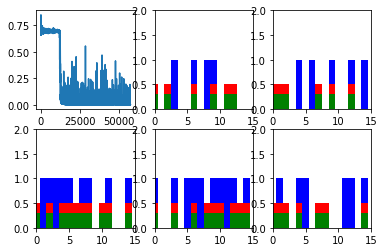

Step 400 Loss 0.000219919
single_output_series: [0 0 1 0 1 1 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 0 0 1 1 0 0 0]

single_output_series: [0 1 0 1 1 0 0 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 1 1 1 0 0 1]

single_output_series: [0 0 0 1 1 1 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 0 0 0 1 1]

single_output_series: [0 1 1 1 0 0 0 0 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 1 0 0 0 1 1]

single_output_series: [1 1 0 1 1 0 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 0 1 1 0 1 1]



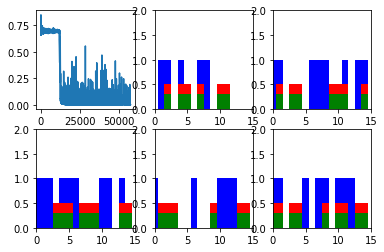

Step 500 Loss 0.000242528
single_output_series: [1 1 0 1 0 0 0 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 1 0 1 0 0 0 0]

single_output_series: [1 0 1 0 1 0 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 0 0 0 1 1 1]

single_output_series: [0 1 1 1 1 0 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 1 0 1 1 1 0]

single_output_series: [1 1 1 0 0 1 1 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 0 0 0 0 1 1 1]

single_output_series: [1 1 0 0 0 1 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 1 1 1 0 1 0]



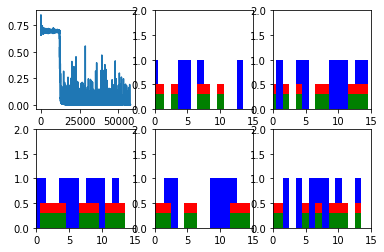

Step 600 Loss 0.000223308
single_output_series: [0 1 1 1 0 1 0 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 1 1 1 0 1 1 0]

single_output_series: [1 1 0 0 1 1 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 1 0 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 0 1 0 1 0 1]

single_output_series: [0 1 1 0 1 0 1 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 0 0 1 1 1 1]

single_output_series: [1 1 0 0 0 0 0 0 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 1 1 0 1 1 1 1]



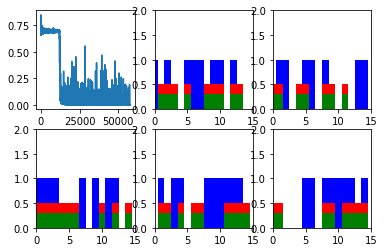

New data, epoch 87
Step 0 Loss 0.16052
single_output_series: [0 0 0 1 1 1 1 1 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 1 0 0 0 1 0]

single_output_series: [0 0 0 0 1 1 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 0 0 0 0 1 1]

single_output_series: [0 0 0 0 1 0 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 1 0 1 0 0]

single_output_series: [0 1 0 1 0 0 0 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 0 0 1 0 0]

single_output_series: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 0 1 0 0 0 1]



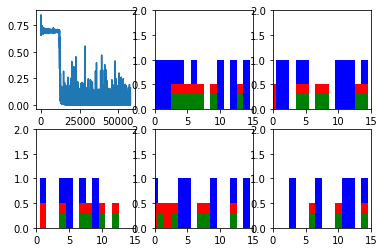

Step 100 Loss 0.000220404
single_output_series: [0 1 1 1 1 0 0 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 0 0 0 1 1 0 1]

single_output_series: [0 0 1 0 1 0 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 1 0 0 0 1 0 1]

single_output_series: [1 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 0 0 0 0 0 0 0]

single_output_series: [1 0 1 0 0 0 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 0 0 0 0 0]

single_output_series: [0 1 1 0 0 1 1 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 0 0 1 1 0 0]



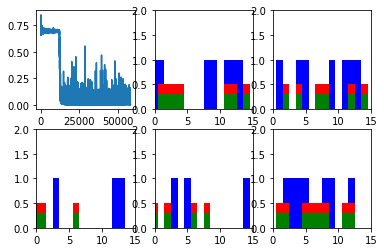

Step 200 Loss 0.000255527
single_output_series: [0 0 0 0 0 0 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 1 0 1 1 1 0]

single_output_series: [0 0 0 1 1 1 0 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 0 0 1 0 0 0 0]

single_output_series: [1 0 0 1 1 0 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 1 0 1 0 1 0 1]

single_output_series: [0 0 1 1 1 0 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 1 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 0 0 1 1 0 1]



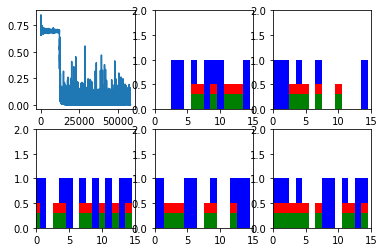

Step 300 Loss 0.000256313
single_output_series: [0 0 1 0 0 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 1 0 0 0 0 1]

single_output_series: [1 0 1 0 1 0 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 0 0 0 0 1 1]

single_output_series: [1 1 0 0 0 0 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 1 0 0 1 0 1 0]

single_output_series: [0 1 0 1 1 0 1 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 0 0 1 0 0 0 1]

single_output_series: [1 0 0 0 0 1 0 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 0 0 0 1 0 0 1]



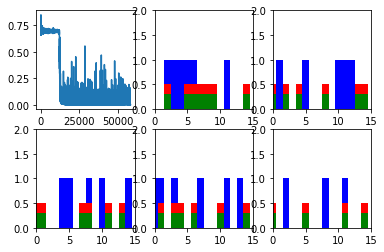

Step 400 Loss 0.000261692
single_output_series: [1 1 0 1 1 0 0 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 0 1 0 0 1 1 1]

single_output_series: [0 1 1 1 0 0 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 0 0 1 1 0 1]

single_output_series: [0 1 1 0 1 1 0 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 0 1 0 0 1 1]

single_output_series: [0 0 1 0 1 0 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 0 0 0 1 1 1]

single_output_series: [1 0 0 1 0 1 0 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 0 1 1 0 0 0]



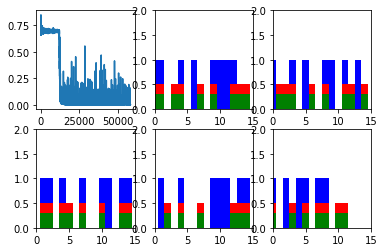

Step 500 Loss 0.000261898
single_output_series: [0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]

single_output_series: [0 0 1 0 1 1 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 0 1 1 1 0 1 0]

single_output_series: [1 1 1 1 0 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 0 0 0 0 0]

single_output_series: [0 0 0 0 1 0 1 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 0 1 0 0 1 1 0]

single_output_series: [1 0 1 0 1 1 0 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 1 1 1 0 0 1]



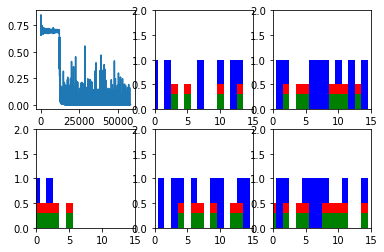

Step 600 Loss 0.000215679
single_output_series: [0 1 1 1 1 0 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 1 0 0 1 1 0]

single_output_series: [1 1 0 1 1 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 1 0 0 0 0 1]

single_output_series: [1 0 0 0 0 0 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 0 0 1 0 1 1]

single_output_series: [1 0 0 0 0 0 1 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 1 1 1 0 0 0]

single_output_series: [0 1 0 1 1 0 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 0 1 1 1 0 1 0]



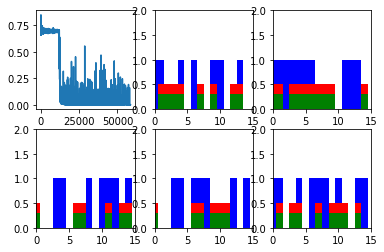

New data, epoch 88
Step 0 Loss 0.0789537
single_output_series: [0 0 0 0 0 1 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 1 0 0 0 0 0]

single_output_series: [0 0 0 1 1 0 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 1 1 0 1 1 1 1 0]

single_output_series: [0 0 0 1 0 1 0 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 0 1 0 0 0 0]

single_output_series: [0 0 0 0 1 1 1 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 1 1 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0]



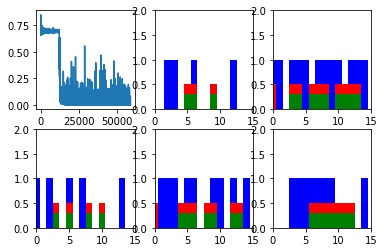

Step 100 Loss 0.000217615
single_output_series: [0 1 1 1 0 1 1 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 1 1 0 1 1 1]

single_output_series: [1 0 0 1 0 0 0 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 0 1 0 0 1 0 1]

single_output_series: [0 1 1 0 0 0 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 0 0 0 1 1 1]

single_output_series: [1 1 1 0 0 0 1 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 0 1 1 0 0 1]

single_output_series: [0 0 0 1 1 0 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 0 1 1 0 0 0 0]



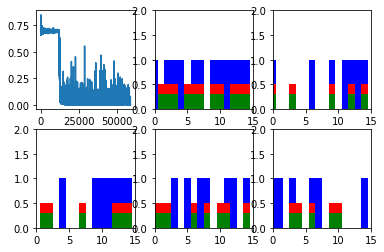

Step 200 Loss 0.000213624
single_output_series: [0 0 0 0 1 1 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 1 0 0 1 0 0]

single_output_series: [0 0 0 0 1 0 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 1 1 1 1 1 0]

single_output_series: [0 1 0 0 0 0 1 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 0 0 1 1 0 0]

single_output_series: [0 0 1 1 1 1 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 1 0 1 1 0 1]

single_output_series: [0 1 0 1 1 1 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 0 1 1 1 0 0]



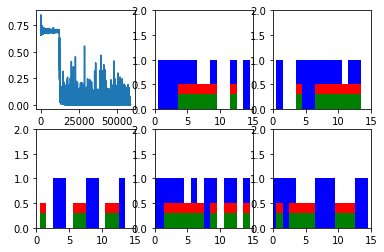

Step 300 Loss 0.000257454
single_output_series: [1 1 0 1 0 1 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 0 0 0 1 0 1 0]

single_output_series: [1 0 0 0 1 0 0 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 0 1 0 0 0 0]

single_output_series: [0 1 0 0 1 1 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 1 1 0 1 0 1 1]

single_output_series: [0 1 1 1 0 0 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 1 1 0 0 1 1]

single_output_series: [0 0 1 0 0 1 1 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 1 0 1 0 1 1]



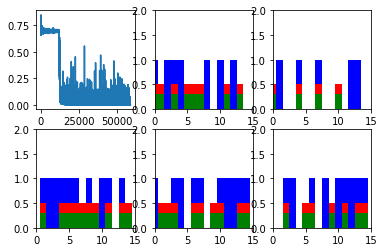

Step 400 Loss 0.000314039
single_output_series: [0 1 0 0 1 0 0 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 1 0 1 0 1]

single_output_series: [1 1 0 1 1 0 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 0 1 0 0 0 0 1]

single_output_series: [0 1 0 0 0 0 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 1 1 0 0 1 1]

single_output_series: [0 1 0 0 0 1 1 1 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 0 1 1 1 0 0 1]

single_output_series: [1 0 1 0 1 0 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 1 0 1 1 1 0 1]



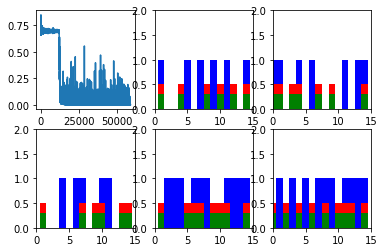

Step 500 Loss 0.000222401
single_output_series: [1 1 0 0 0 0 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 0 1 1 1 1 0]

single_output_series: [1 1 0 1 1 0 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 1 1 0 1 1 0]

single_output_series: [0 0 1 1 1 0 1 0 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 1 0 0 1 1 1]

single_output_series: [1 1 1 1 0 1 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 0 1 1 1 0 1]

single_output_series: [1 0 1 1 1 0 0 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 1 1 1 1 0 0 1]



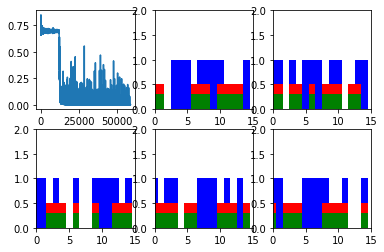

Step 600 Loss 0.000313158
single_output_series: [1 1 0 1 0 0 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 0 1 0 1 1 1]

single_output_series: [0 0 0 1 0 0 1 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 1 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 0 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 1 0 1 1 0 1]

single_output_series: [1 0 0 1 0 1 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 0 1 0 1 0 0]

single_output_series: [1 1 0 1 1 0 1 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 1 0 1 1 0 0]



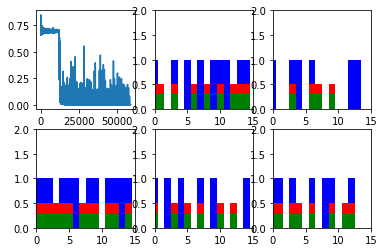

New data, epoch 89
Step 0 Loss 0.215778
single_output_series: [0 0 0 0 0 1 0 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 0 0 1 0 1 1 1]

single_output_series: [0 0 0 0 1 0 1 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 0 1 0 0 1 0]

single_output_series: [0 0 0 1 1 0 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 1 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 1 1 0 0 0 1]

single_output_series: [0 0 0 0 1 1 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 0 0 0 1 1 1]



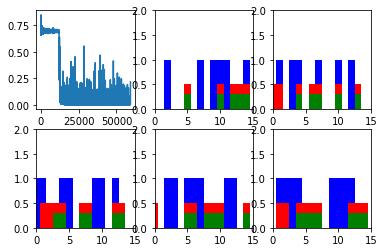

Step 100 Loss 0.000239921
single_output_series: [1 1 0 0 1 1 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 1 1 0 0 0 1]

single_output_series: [0 0 1 0 1 0 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 0 0 1 1 1 0]

single_output_series: [1 0 1 0 1 1 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 0 1 1 0 0 0]

single_output_series: [0 1 1 0 0 0 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 0 1 1 0 1]

single_output_series: [1 0 0 0 1 1 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 1 1 1 0 0 1]



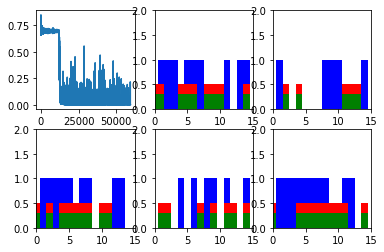

Step 200 Loss 0.000253649
single_output_series: [1 1 0 1 1 0 1 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 0 0 0 0 0 1]

single_output_series: [0 0 0 0 0 1 1 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 1 1 0 0 1 0]

single_output_series: [1 1 1 1 1 0 0 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 1 0 1 1 1 1]

single_output_series: [0 1 1 1 1 0 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 0 0 0 1 0 0]

single_output_series: [0 0 1 0 0 0 1 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 1 1 0 1 1 0 1]



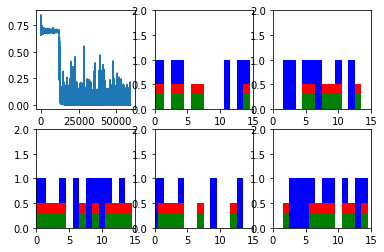

Step 300 Loss 0.000241812
single_output_series: [1 0 1 0 0 1 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 1 0 1 1 0]

single_output_series: [1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]

single_output_series: [0 0 1 0 1 1 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 1 1 0 1 0 1 0]

single_output_series: [1 0 0 1 0 1 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 0 0 1 0 0 0]

single_output_series: [0 1 1 1 0 1 1 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 0 0 0 0 0 1 1]



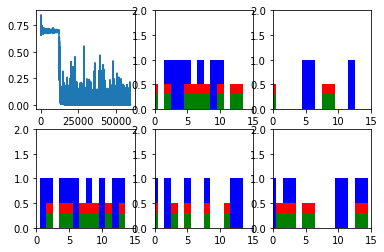

Step 400 Loss 0.000253377
single_output_series: [1 0 0 1 0 0 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 1 1 1 1 1 0 1]

single_output_series: [1 1 0 1 0 1 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 0 0 1 1 1 0 0]

single_output_series: [1 0 1 0 1 0 0 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 0 1 1 0 0 0]

single_output_series: [0 0 1 1 0 1 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 0 1 1 0 0 0]

single_output_series: [0 1 0 0 1 0 0 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 1 1 1 0 1]



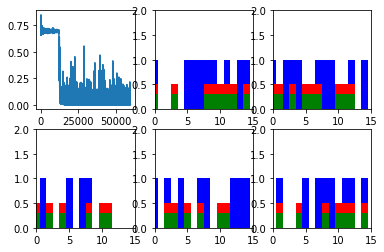

Step 500 Loss 0.000239188
single_output_series: [1 0 1 1 1 1 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 1 1 1 1 0 0]

single_output_series: [0 1 1 1 0 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 0 0 0 0 0 0]

single_output_series: [0 1 1 0 0 1 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 1 1 0 0 0 1]

single_output_series: [0 0 1 1 1 0 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 1 0 0 1 0 1]

single_output_series: [0 0 0 1 0 0 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 0 1 0 1 0 1]



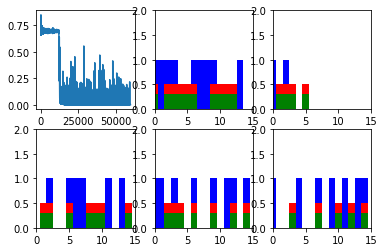

Step 600 Loss 0.000254396
single_output_series: [1 1 1 0 1 1 1 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 0 0 1 1 0 1 1]

single_output_series: [1 1 1 1 0 1 0 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 0 1 0 0 1 0 1]

single_output_series: [0 1 0 1 1 1 0 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 0 0 0 0 0 1]

single_output_series: [0 0 0 1 1 0 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 0 0 0 1 0 0]

single_output_series: [0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]



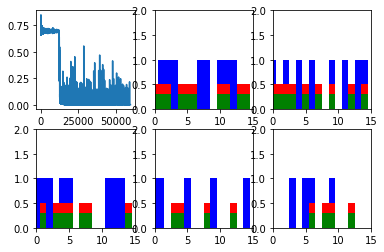

New data, epoch 90
Step 0 Loss 0.143068
single_output_series: [0 0 0 0 1 0 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 0 1 0 1 0 0]

single_output_series: [1 0 1 1 0 1 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 1 0 0 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 0 1 1 0 0 1]

single_output_series: [1 0 0 1 0 0 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 1 1 1 1 0 0]

single_output_series: [1 0 1 1 1 1 1 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 1 0 1 0 0 1]



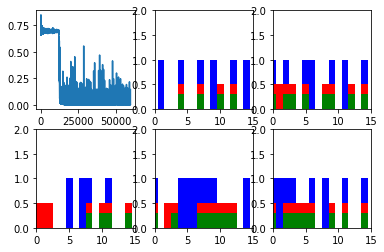

Step 100 Loss 0.000257737
single_output_series: [1 1 1 0 0 1 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 0 0 0 0 1 1 1]

single_output_series: [1 0 1 0 1 1 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 0 1 1 1 1 0]

single_output_series: [0 1 1 1 0 1 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 1 1 0 0 1 1]

single_output_series: [1 0 0 0 0 1 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 0 0 0 1 1 0 1]

single_output_series: [0 0 0 0 1 1 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 1 1 0 0 0 1]



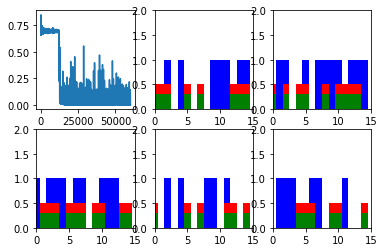

Step 200 Loss 0.000333685
single_output_series: [1 1 0 1 1 0 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 1 1 0 1 1 1 0]

single_output_series: [1 1 0 1 0 0 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 0 0 1 1 0 1]

single_output_series: [0 0 0 1 0 1 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 0 0 1 0 1 0]

single_output_series: [0 0 0 0 0 1 1 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 0 1 1 0 1 0]

single_output_series: [1 1 1 1 0 1 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 0 1 0 0 1 1]



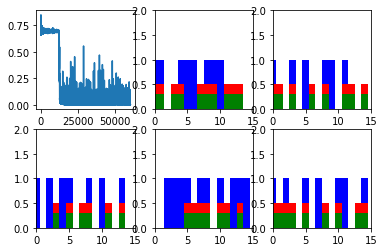

Step 300 Loss 0.000210796
single_output_series: [1 1 1 1 0 1 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 1 1 1 0 0]

single_output_series: [0 1 0 0 1 1 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 0 0 0 0 0 0]

single_output_series: [0 0 0 1 0 1 1 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 1 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 0 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 0 1 1 1 1 1 1]

single_output_series: [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]



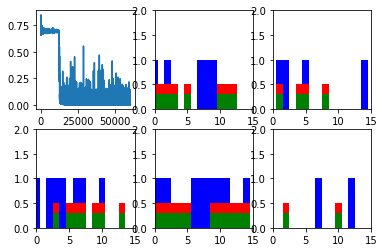

Step 400 Loss 0.000224562
single_output_series: [0 1 1 1 0 1 1 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 1 1 0 0 0 0 1]

single_output_series: [1 0 0 1 0 0 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 0 1 0 0 1 1 0]

single_output_series: [0 1 1 1 0 0 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 0 0 0 1 0 1 1]

single_output_series: [0 1 0 0 0 0 1 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 1 0 1 1 1 1]

single_output_series: [1 1 1 1 1 0 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 1 1 0 0 1 1]



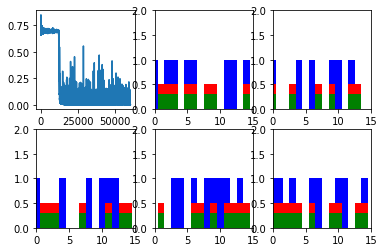

Step 500 Loss 0.000204351
single_output_series: [0 1 1 1 0 0 0 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 0 1 1 1 0 1 1]

single_output_series: [0 0 0 1 0 0 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 1 0 0 1 0 0 0]

single_output_series: [0 0 0 0 1 1 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 0 0 0 0 0 0]

single_output_series: [0 1 0 0 1 0 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 0 0 0 1 1]

single_output_series: [1 0 1 0 1 1 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 0 0 0 1 1 0]



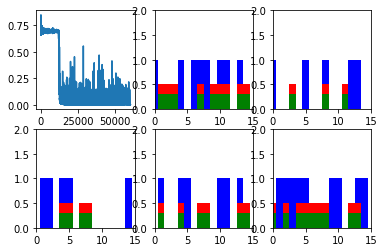

Step 600 Loss 0.000252931
single_output_series: [1 1 1 1 0 0 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 1 0 1 1 0 1]

single_output_series: [1 1 0 0 1 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 0 0 0 1 1 0 0]

single_output_series: [1 1 1 1 1 0 1 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 0 0 1 1 0 1]

single_output_series: [1 1 1 0 1 1 0 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 1 0 1 0 0 1]

single_output_series: [0 1 0 1 0 1 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 1 1 0 1 1 0]



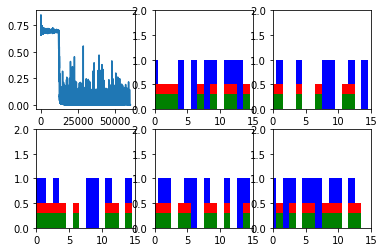

New data, epoch 91
Step 0 Loss 0.354643
single_output_series: [1 0 1 1 0 0 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 1 1 0 0 0 0]

single_output_series: [1 0 1 1 1 1 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 1 0 0 1 1 1 0]

single_output_series: [1 0 1 1 1 0 0 1 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 1 1 0 0 1 0]

single_output_series: [1 0 1 1 1 1 0 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 0 0 1 0 0 1]

single_output_series: [1 0 1 0 0 0 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 0 0 1 0 1 0]



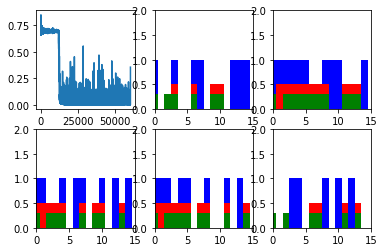

Step 100 Loss 0.000216975
single_output_series: [1 1 1 0 1 1 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 0 1 1 0 0 0 0]

single_output_series: [0 0 0 0 1 1 0 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 0 1 1 0 1 0 1]

single_output_series: [1 1 0 1 1 1 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 1 1 0 0 0 1]

single_output_series: [1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]

single_output_series: [0 0 0 1 0 0 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 1 1 1 1 0 1]



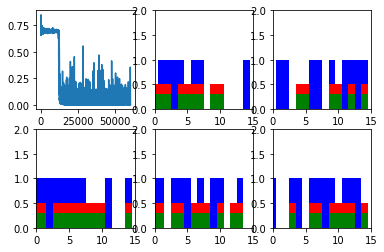

Step 200 Loss 0.00024438
single_output_series: [0 1 1 1 0 0 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 1 0 1 1 0 0 0]

single_output_series: [0 1 1 1 0 1 0 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 1 1 0 0 0 0 0]

single_output_series: [0 0 0 0 0 0 1 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 0 1 1 1 1]

single_output_series: [0 1 0 0 1 0 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 0 1 1 0 0 0 0]

single_output_series: [0 0 1 1 1 0 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 1 0 1 0 1 0 0]



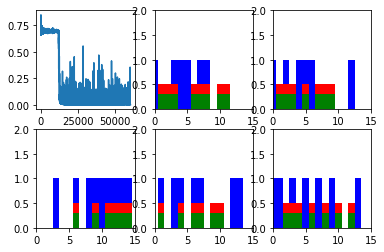

Step 300 Loss 0.000235353
single_output_series: [0 1 0 1 1 0 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 0 1 1 1 1 0 1]

single_output_series: [1 0 0 1 0 1 1 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 0 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 0 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 0 0 1 0 0 0]

single_output_series: [0 0 1 0 0 1 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 0 1 0 1 0 1]

single_output_series: [1 0 0 0 1 1 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 0 0 1 0 1 1]



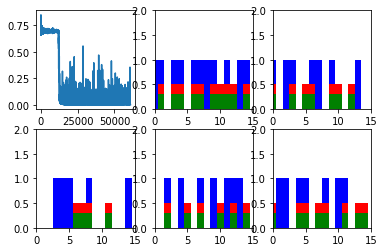

Step 400 Loss 0.000225458
single_output_series: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1]

single_output_series: [1 1 1 1 0 0 0 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 0 0 1 1 0 0 1]

single_output_series: [0 1 0 1 0 1 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 0 0 1 0 0]

single_output_series: [0 0 1 1 0 0 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 1 0 0 0 0 0]

single_output_series: [0 0 1 0 0 0 0 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 0 1 0 1 0 0]



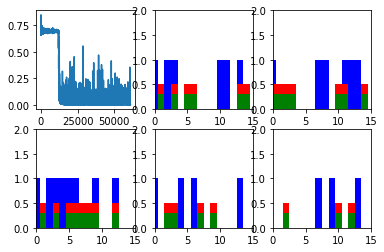

Step 500 Loss 0.000238188
single_output_series: [0 0 1 0 0 0 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 1 1 0 1 1 1 1]

single_output_series: [1 0 1 0 1 0 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 0 1 0 1 0 0 0]

single_output_series: [0 0 1 0 0 1 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 1 0 1 0 1 1 1]

single_output_series: [0 1 1 1 0 0 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 1 1 0 0 0 1]

single_output_series: [0 0 0 1 0 0 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 0 0 1 0 0 0]



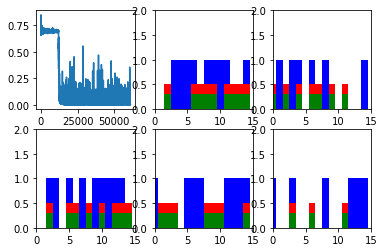

Step 600 Loss 0.000258053
single_output_series: [0 1 0 0 1 1 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 0 1 0 0 0 0]

single_output_series: [0 0 0 1 1 1 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 0 0 1 1 0 1]

single_output_series: [0 0 1 0 1 1 0 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 0 1 1 1 0 1 1]

single_output_series: [0 0 1 0 0 0 1 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 0 0 1 0 1 1]

single_output_series: [0 0 0 1 1 0 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 0 0 1 0 0 0]



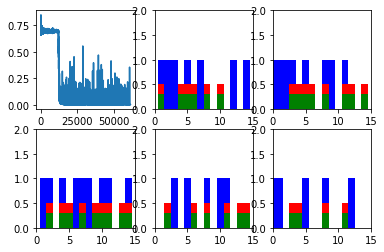

New data, epoch 92
Step 0 Loss 0.21503
single_output_series: [1 1 1 1 1 0 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 0 1 1 0 0]

single_output_series: [1 1 1 1 1 0 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 1 1 0 0 0 1]

single_output_series: [0 1 0 0 1 0 0 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 1 1 0 1 1 0 1]

single_output_series: [0 1 0 0 1 1 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 0 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 1 1 0 0 1 0]



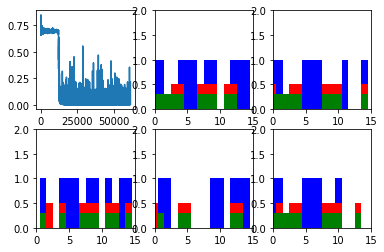

Step 100 Loss 0.000246373
single_output_series: [0 1 1 0 0 0 1 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 1 0 0 1 0 1]

single_output_series: [0 0 1 0 1 0 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 0 1 0 0 0 1]

single_output_series: [0 1 1 1 0 1 0 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 0 0 0 1 1 0]

single_output_series: [0 1 1 1 1 0 0 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 1 1 1 1 1 0 0]

single_output_series: [1 0 1 0 1 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 0 1 0 1 1 1]



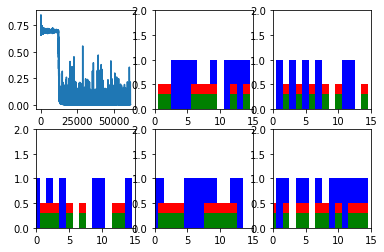

Step 200 Loss 0.000217517
single_output_series: [1 1 1 0 0 1 0 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 0 0 0 0 0 0 1]

single_output_series: [0 1 0 1 1 0 1 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 0 1 1 0 1 0]

single_output_series: [0 0 0 0 1 0 1 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 0 0 0 0 0 1]

single_output_series: [1 1 0 1 1 0 1 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 0 1 0 0 1 0]

single_output_series: [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0]



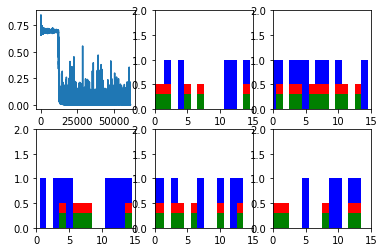

Step 300 Loss 0.000239814
single_output_series: [1 1 0 1 1 1 0 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 1 1 1 0 0 0]

single_output_series: [0 0 1 1 1 1 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 0 1 0 0 1]

single_output_series: [1 1 1 0 1 0 0 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 1 1 1 1 1 0]

single_output_series: [0 1 0 1 1 1 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 0 0 0 1 0 1]

single_output_series: [1 1 0 0 1 0 0 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 0 1 1 0 0 0]



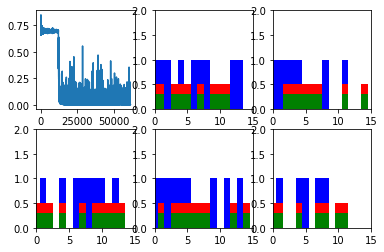

Step 400 Loss 0.000198282
single_output_series: [0 0 0 0 0 0 1 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 1 0 0 1 1]

single_output_series: [1 0 1 0 0 0 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 1 1 0 1 1 1]

single_output_series: [0 1 0 1 1 1 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 0 1 0 0 1 1]

single_output_series: [0 1 1 0 1 0 0 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 1 1 0 0 0 0 1]

single_output_series: [0 0 1 1 1 1 1 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 0 0 1 1 1]



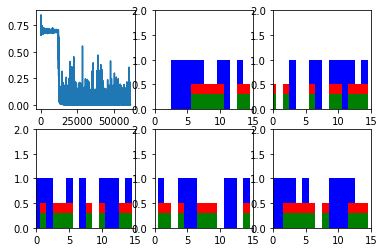

Step 500 Loss 0.000188599
single_output_series: [0 1 0 0 1 0 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 0 1 1 1 1 1]

single_output_series: [0 0 1 1 1 1 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 1 1 1 0 1 0]

single_output_series: [1 1 1 1 0 1 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 1 0 0 0 1 0 0]

single_output_series: [0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]

single_output_series: [1 1 0 0 1 0 1 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 1 0 0 0 0 0]



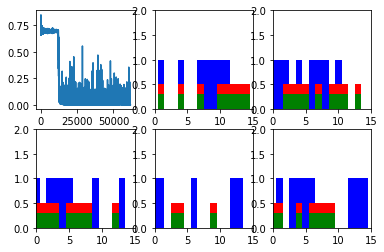

Step 600 Loss 0.000190309
single_output_series: [0 1 1 0 1 1 0 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 1 1 1 0 0]

single_output_series: [1 0 0 1 0 1 1 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 0 1 1 0 1 1 0]

single_output_series: [1 1 1 0 0 0 1 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 1 1 1 0 0 0]

single_output_series: [1 1 1 0 0 0 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 0 1 0 0 0 0 0]

single_output_series: [0 0 1 0 0 0 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 0 1 1 0 0 0]



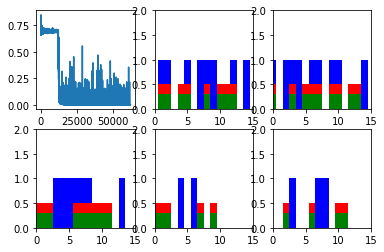

New data, epoch 93
Step 0 Loss 0.412024
single_output_series: [0 0 0 0 0 0 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 1 1 1 0 0]

single_output_series: [0 1 0 1 0 0 0 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 1 1 0 0 1 0]

single_output_series: [0 1 0 1 0 0 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 0 1 0 0 1 0 1]

single_output_series: [0 0 0 0 0 1 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 0 0 0 0 1 0]

single_output_series: [0 1 0 1 1 0 0 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 1 0 1 0 0 1]



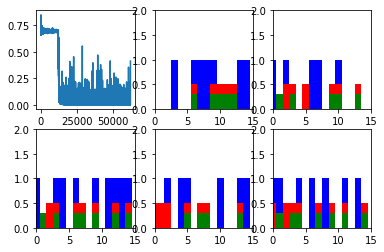

Step 100 Loss 0.000276708
single_output_series: [0 1 0 0 0 1 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 1 0 1 1 0 1]

single_output_series: [0 1 0 0 0 0 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 0 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 0 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 1 0 1 0 0 1 0]

single_output_series: [0 1 0 0 1 0 0 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 1 0 0 1 0 1]

single_output_series: [0 1 0 1 0 0 1 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 0 0 1 1 0]



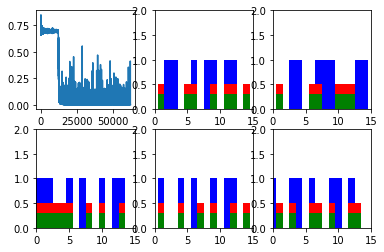

Step 200 Loss 0.00016083
single_output_series: [1 0 0 0 1 0 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 0 0 0 0 1 1 0]

single_output_series: [0 0 0 1 1 1 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 0 0 1 1 1 0]

single_output_series: [0 0 1 1 0 0 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 0 0 1 1 1 1]

single_output_series: [1 0 0 1 1 1 1 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 0 1 1 1 0 0 1]

single_output_series: [0 1 1 0 1 1 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 0 1 1 1 0 0]



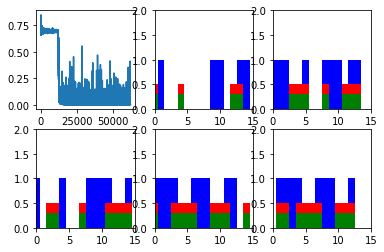

Step 300 Loss 0.000256384
single_output_series: [0 1 1 1 1 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 0 0 1 1 0 0]

single_output_series: [1 1 1 0 0 0 0 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 0 0 1 1 0 1 0]

single_output_series: [0 1 1 1 0 0 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 0 1 1 1 0]

single_output_series: [1 0 1 0 1 1 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 0 0 1 0 1 0]

single_output_series: [0 1 1 0 1 1 0 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 1 0 1 0 0]



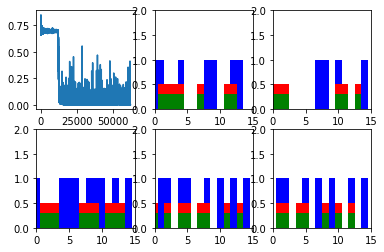

Step 400 Loss 0.000206913
single_output_series: [0 1 0 0 0 0 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 1 0 0 0 0 0]

single_output_series: [0 1 0 1 1 1 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 0 0 0 0 1 1]

single_output_series: [0 0 1 1 1 1 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 1 0 1 0 0]

single_output_series: [1 1 0 1 1 1 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 0 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 1 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 1 1 1 0 0 0]



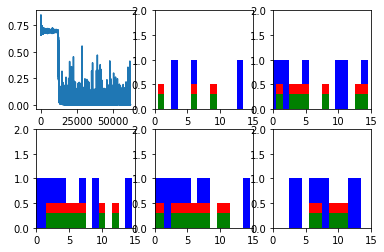

Step 500 Loss 0.000220346
single_output_series: [1 0 1 1 1 1 1 0 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 1 0 1 1 1 1]

single_output_series: [0 0 0 0 0 1 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 0 1 0 1 0 1]

single_output_series: [1 1 1 1 1 0 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 0 0 1 1 1 0]

single_output_series: [1 1 1 1 0 0 1 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 0 0 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 0 0 1 0 0 1]



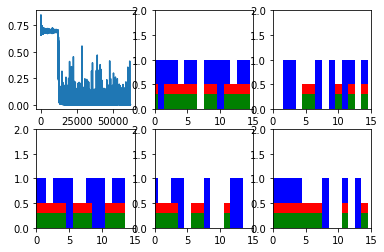

Step 600 Loss 0.000198448
single_output_series: [0 0 1 0 0 1 0 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 0 1 1 0 0 1]

single_output_series: [0 0 0 1 1 1 0 0 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 1 0 0 1 1 1]

single_output_series: [1 1 1 1 1 0 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 1 0 0 1 1 0]

single_output_series: [0 0 0 0 1 1 1 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 0 0 0 1 1 0]

single_output_series: [0 1 0 0 0 1 1 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 1 1 1 1 0 0 1]



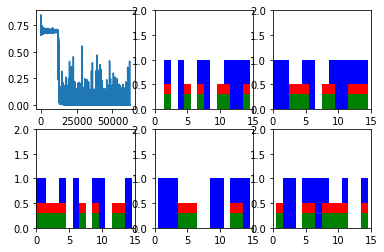

New data, epoch 94
Step 0 Loss 0.224813
single_output_series: [1 0 0 0 1 0 1 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 0 0 0 1 1 1]

single_output_series: [1 0 0 0 1 0 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 1 1 0 1 0 1 0]

single_output_series: [1 0 1 0 1 1 0 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 1 1 0 0 0 0]

single_output_series: [1 0 1 1 1 0 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 0 1 1 0 1]

single_output_series: [1 0 1 0 0 1 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 0 1 0 1 1 1]



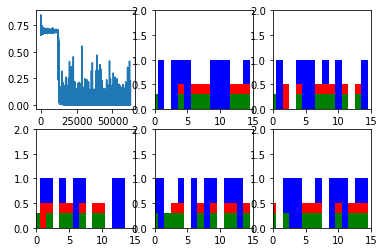

Step 100 Loss 0.000277732
single_output_series: [0 1 0 1 0 1 1 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 0 1 1 0 1 0 0]

single_output_series: [1 0 0 0 0 0 1 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 1 1 1 0 0 1]

single_output_series: [0 1 1 1 0 1 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 0 0 1 1 1 0]

single_output_series: [1 1 1 0 0 0 0 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 1 1 1 0 1]

single_output_series: [1 0 1 0 0 1 0 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 0 0 0 1 0 1]



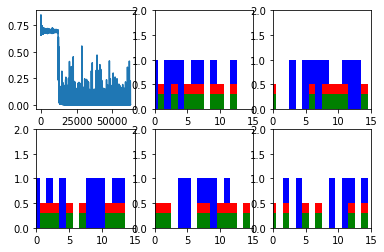

Step 200 Loss 0.000256411
single_output_series: [1 1 1 0 1 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 1 1 0 0 0 1]

single_output_series: [0 0 0 1 1 1 0 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 0 1 0 1 1 0]

single_output_series: [1 1 0 0 1 0 0 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 0 1 0 1 0 1 0]

single_output_series: [1 1 1 1 1 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 1 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 0 0 1 1 0 1]



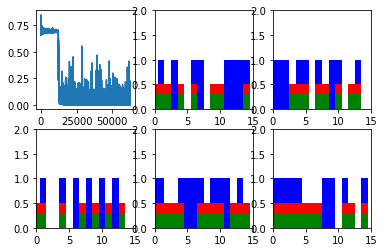

Step 300 Loss 0.00025535
single_output_series: [1 0 1 1 1 1 0 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 1 1 1 0 1 0 1]

single_output_series: [0 1 1 1 0 1 0 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 0 1 0 1 0 0]

single_output_series: [1 0 0 1 1 1 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 0 0 0 0 1 0 0]

single_output_series: [0 1 0 0 1 1 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 1 1 1 0 1 0]

single_output_series: [1 0 0 0 0 1 0 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 0 1 0 1 1 0 0]



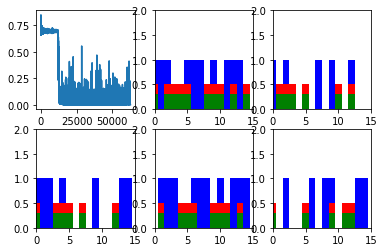

Step 400 Loss 0.000240401
single_output_series: [1 0 1 0 0 1 1 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 0 0 1 0 0 1]

single_output_series: [0 0 0 1 0 1 0 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 1 1 0 0 1 1]

single_output_series: [0 0 0 0 0 1 1 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 1 1 1 0 1]

single_output_series: [0 1 1 1 1 1 0 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 1 0 1 0 0 0 1]

single_output_series: [1 0 1 1 0 0 0 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 1 1 0 1 0 0]



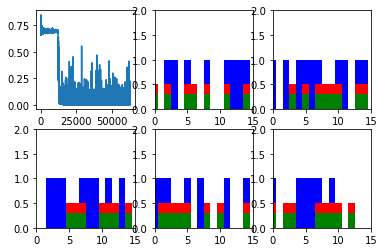

Step 500 Loss 0.000201413
single_output_series: [1 1 1 0 0 0 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 0 1 1 1 1 1]

single_output_series: [0 1 0 0 0 1 1 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 0 1 0 0 0 0]

single_output_series: [0 1 0 1 1 0 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 0 0 1 1 1 0 0]

single_output_series: [0 0 0 1 1 0 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 1 1 1 0 0]

single_output_series: [1 0 1 0 1 1 1 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 1 1 0 1 0 0]



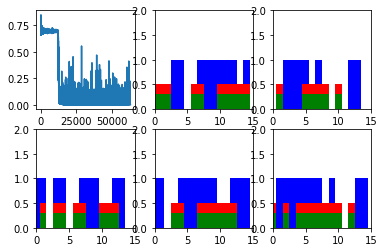

Step 600 Loss 0.000274493
single_output_series: [0 0 0 0 1 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 0 1 0 0 0 0]

single_output_series: [1 1 1 0 0 1 1 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 1 0 1 0 1 1 0]

single_output_series: [1 0 0 0 0 0 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 0 1 0 1 1 0 0]

single_output_series: [1 1 1 0 1 1 1 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 1 1 0 0 1 1]

single_output_series: [1 0 0 1 0 1 0 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 1 1 1 1 1 0]



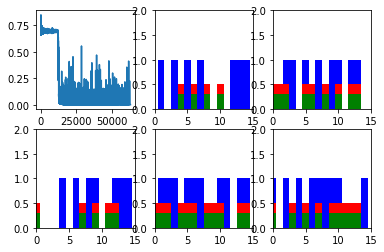

New data, epoch 95
Step 0 Loss 0.220631
single_output_series: [0 0 0 0 1 0 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 0 0 1 1 1 0]

single_output_series: [0 0 0 0 1 1 1 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 0 1 1 0 1 0]

single_output_series: [1 0 1 1 1 0 0 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 0 0 1 0 0 1]

single_output_series: [1 0 1 1 0 0 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 0 0 0 0 1 0 1]

single_output_series: [0 0 1 0 0 0 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 1 1 0 0 0 0]



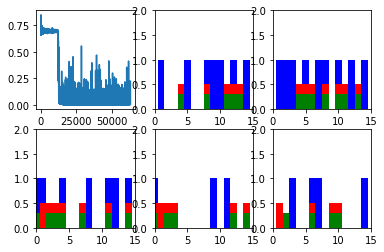

Step 100 Loss 0.000224023
single_output_series: [0 0 0 0 0 0 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 0 0 0 1 1 0]

single_output_series: [1 1 0 0 0 1 0 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 0 1 1 1 1 0]

single_output_series: [0 1 1 0 0 1 1 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 1 1 0 0 1 1]

single_output_series: [0 1 0 1 0 1 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 0 1 1 1 1 1 1]

single_output_series: [0 0 1 0 0 0 1 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 1 0 1 0 1 1]



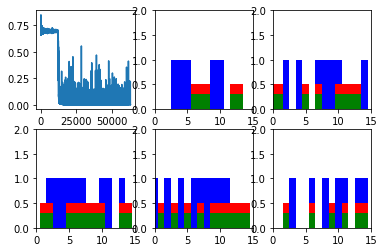

Step 200 Loss 0.000192853
single_output_series: [0 0 0 1 1 1 0 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 0 0 0 0 1 1]

single_output_series: [1 1 1 1 0 1 1 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 1 1 1 1 0 0]

single_output_series: [1 1 1 0 1 0 0 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 0 0 1 1 0 1]

single_output_series: [0 1 1 0 0 1 1 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 1 1 0 0 1 0]

single_output_series: [1 1 1 0 1 1 1 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 1 1 1 0 1 1]



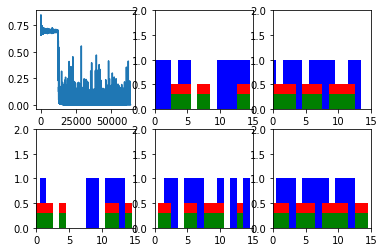

Step 300 Loss 0.000206225
single_output_series: [1 0 0 0 0 1 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 1 0 0 0 1 1 1]

single_output_series: [0 0 1 0 0 0 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 1 0 1 1 0 1]

single_output_series: [1 0 0 1 1 1 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 0 1 1 0 1 1]

single_output_series: [1 0 0 0 1 0 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 0 1 1 1 1 0]

single_output_series: [1 1 1 1 0 0 0 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 1 0 0 1 0 1 1]



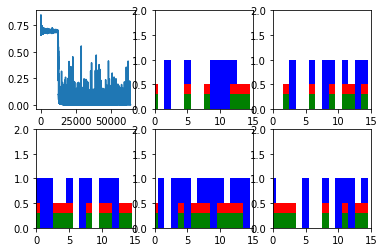

Step 400 Loss 0.000204283
single_output_series: [1 0 0 0 1 0 0 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 1 1 1 1 1 0]

single_output_series: [0 0 1 1 1 1 0 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 1 1 0 0 1 0 0]

single_output_series: [0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]

single_output_series: [0 1 0 1 0 0 1 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 0 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 0 1 1 1 0]



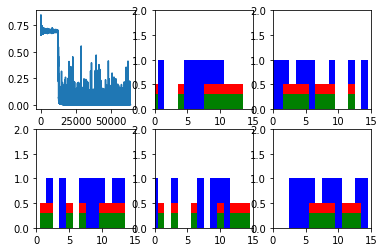

Step 500 Loss 0.000200143
single_output_series: [1 0 0 0 1 1 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 0 0 0 1 0 1 1]

single_output_series: [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0]

single_output_series: [0 0 1 0 0 0 1 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 0 0 0 1 1 0]

single_output_series: [0 1 1 0 1 1 1 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 0 1 1 0 1 0 1]

single_output_series: [0 1 1 0 1 0 0 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 1 1 0 1 1 0 1]



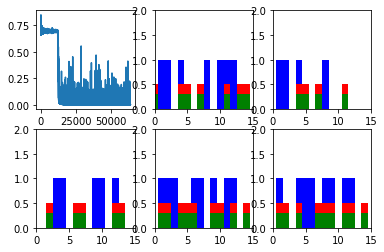

Step 600 Loss 0.000191279
single_output_series: [1 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 0 0 0 1 0 0 0]

single_output_series: [0 1 1 0 0 0 0 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 1 0 1 1 1 1 1]

single_output_series: [1 1 1 0 1 1 0 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 0 0 1 1 0 0 1]

single_output_series: [1 0 1 0 0 1 0 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 1 1 0 1 1 1]

single_output_series: [0 0 0 1 1 0 0 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 0 1 1 1 1 0]



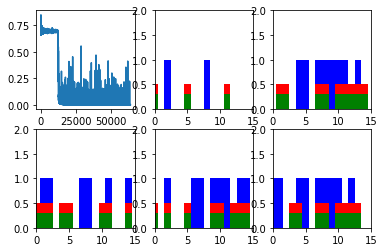

New data, epoch 96
Step 0 Loss 0.221889
single_output_series: [0 0 0 1 0 0 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 0 1 1 1 0 1]

single_output_series: [0 1 0 0 1 1 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 0 1 1 1 0]

single_output_series: [0 0 0 1 0 1 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 1 0 1 1 0 0]

single_output_series: [0 0 0 1 0 1 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 1 0 0 1 0 0]

single_output_series: [0 1 0 0 0 1 0 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 0 1 1 1 0 0 1]



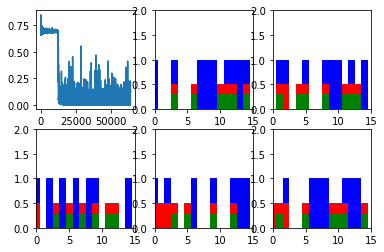

Step 100 Loss 0.000170934
single_output_series: [1 0 0 1 1 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 1 1 0 0 0 0 1]

single_output_series: [1 1 1 1 0 1 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 0 1 0 1 0 0]

single_output_series: [0 0 0 0 1 1 1 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 0 1 1 1 1 1]

single_output_series: [0 0 0 1 0 1 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 0 1 1 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1]



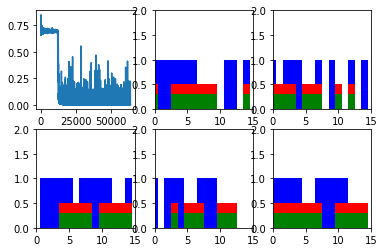

Step 200 Loss 0.000198413
single_output_series: [0 0 0 0 1 0 1 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 1 0 0 0 1 1]

single_output_series: [1 0 1 0 0 0 0 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 0 1 1 1 1 1]

single_output_series: [1 0 1 1 1 0 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 0 0 0 0 0]

single_output_series: [0 0 0 0 1 1 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 1 1 1 0 1 0]

single_output_series: [0 0 1 0 0 0 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 1 0 0 1 0 1]



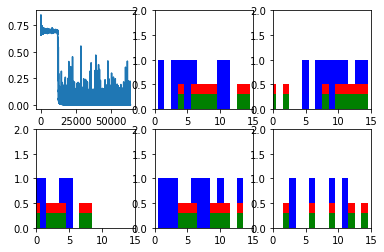

Step 300 Loss 0.000187313
single_output_series: [0 1 1 0 0 0 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 0 0 1 1 1 0]

single_output_series: [1 1 1 0 1 0 0 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 1 1 1 1 0 0]

single_output_series: [1 1 0 0 0 1 1 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 0 0 0 1 0 0]

single_output_series: [1 1 1 1 0 1 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 1 1 1 1 0 1 1]

single_output_series: [1 1 0 1 1 1 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 0 0 0 1 0 1]



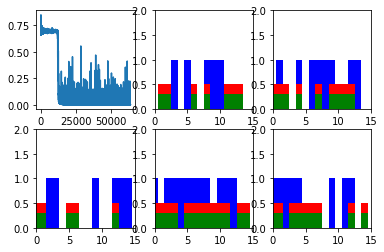

Step 400 Loss 0.000203025
single_output_series: [1 0 1 1 1 1 1 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 1 1 0 0 1 1]

single_output_series: [0 0 0 1 1 1 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 0 0 0 1 1 1]

single_output_series: [1 1 0 1 0 1 0 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 0 0 0 1 1 0 0]

single_output_series: [0 0 1 0 0 1 1 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 1 1 1 1 0 0 0]

single_output_series: [0 1 1 0 1 0 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 1 0 1 1 0 1]



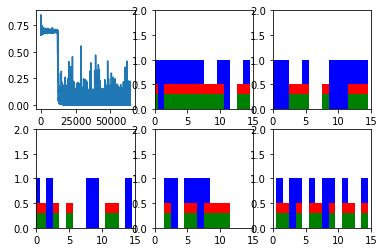

Step 500 Loss 0.000240788
single_output_series: [1 1 0 1 0 0 1 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 0 0 1 0 1 0]

single_output_series: [1 1 0 1 0 0 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 1 0 0 1 0 0]

single_output_series: [1 1 0 0 0 1 1 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 1 0 1 1 0 0]

single_output_series: [1 1 1 1 1 1 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 1 0 1 0 1 1 0]

single_output_series: [0 1 1 0 1 0 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 0 1 1 0 0 1 1]



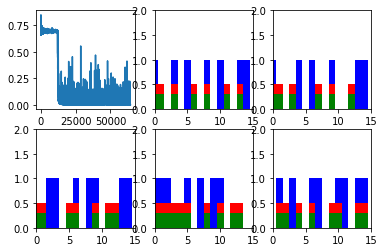

Step 600 Loss 0.000203789
single_output_series: [0 1 1 0 0 0 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 1 0 0 1 1]

single_output_series: [0 0 1 0 1 1 1 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 1 1 1 1 1 0]

single_output_series: [0 1 0 0 0 0 1 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 0 0 0 0 1 1]

single_output_series: [1 1 0 0 1 0 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 0 0 1 0 1 1]

single_output_series: [1 0 1 1 0 0 0 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 0 1 1 0 1 1 0]



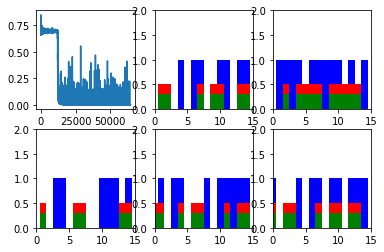

New data, epoch 97
Step 0 Loss 0.143436
single_output_series: [0 0 1 0 0 0 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 0 0 1 0 1 0]

single_output_series: [1 0 1 1 0 0 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 0 0 0 0 1 0 1]

single_output_series: [0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 0 1 0 1 1 1]

single_output_series: [0 0 0 0 1 0 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 1 1 1 0 0 1]

single_output_series: [0 0 1 0 1 1 0 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 0 0 0 1 1 0 1]



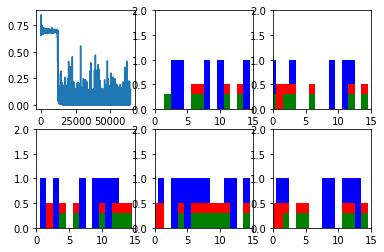

Step 100 Loss 0.00017037
single_output_series: [0 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 1 1 1 1 0 0 0]

single_output_series: [1 0 0 0 0 0 1 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 0 1 0 0 1 0 0]

single_output_series: [1 1 0 0 0 1 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 0 0 0 1 1 0 1]

single_output_series: [1 0 0 0 1 0 1 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 0 0 0 0 0 0]

single_output_series: [1 1 1 1 0 0 0 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 0 1 0 0 1 0]



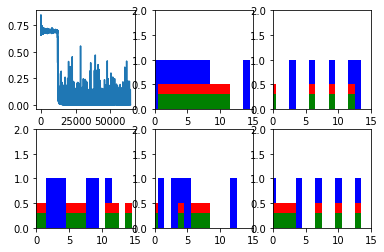

Step 200 Loss 0.000205739
single_output_series: [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1]

single_output_series: [1 0 0 1 1 1 0 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 1 0 1 1 0 1]

single_output_series: [1 0 0 1 0 0 0 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 0 1 1 1 1 1 0]

single_output_series: [1 1 0 1 0 1 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 0 1 0 1 1 0]

single_output_series: [1 0 1 1 1 0 0 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 1 0 0 1 1]



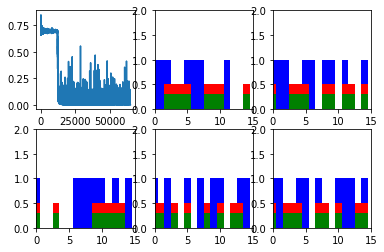

Step 300 Loss 0.000237749
single_output_series: [1 0 1 1 0 1 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 1 0 0 0 0 1 0]

single_output_series: [1 0 0 0 1 0 1 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 1 0 1 0 1 0]

single_output_series: [0 1 0 0 0 1 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 1 1 1 1 0 1 0]

single_output_series: [0 0 1 1 1 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 1 1 0 1 1 1 1]

single_output_series: [0 1 1 1 1 1 1 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 0 0 0 1 1 0 1]



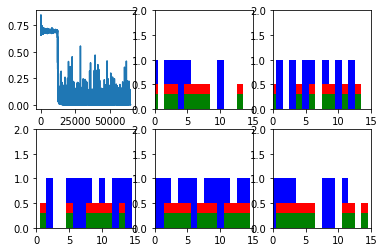

Step 400 Loss 0.000250031
single_output_series: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 1 0 1 0 1 0 0]

single_output_series: [1 1 0 1 1 0 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 1 1 0 1 0 1 1]

single_output_series: [0 1 0 0 1 1 0 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 0 0 0 0 1 0]

single_output_series: [0 0 1 0 1 0 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 1 0 0 1 0 0 0]

single_output_series: [1 0 1 1 1 1 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 0 0 1 1 0]



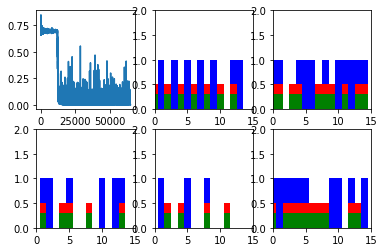

Step 500 Loss 0.000275732
single_output_series: [0 1 0 1 1 0 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 1 1 1 1 1 1 1]

single_output_series: [1 0 0 0 1 1 0 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 0 1 0 1 0 1]

single_output_series: [0 0 0 1 0 0 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 0 0 1 0 1 0]

single_output_series: [0 1 0 1 1 0 1 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 0 1 0 1 0 1 0]

single_output_series: [1 1 1 0 0 0 1 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 0 1 1 1 1 0 1]



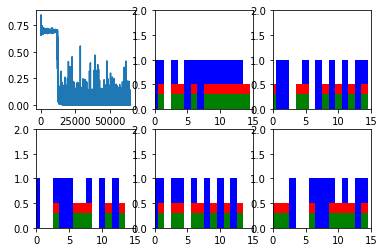

Step 600 Loss 0.00019701
single_output_series: [1 1 1 1 1 1 0 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 1 1 0 1 1 0]

single_output_series: [0 0 1 1 0 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 0 0 1 0 1 1]

single_output_series: [1 1 1 0 1 0 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 1 0 1 1 1 1 0]

single_output_series: [1 1 0 0 0 1 0 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 1 1 1 1 0 1 1]

single_output_series: [0 0 0 0 1 1 0 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 0 1 1 0 0 0]



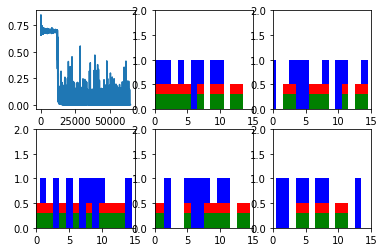

New data, epoch 98
Step 0 Loss 0.139192
single_output_series: [0 1 1 0 1 0 0 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 1 0 1 1 0 0]

single_output_series: [0 0 1 0 0 0 1 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 1 1 1 1 0 0]

single_output_series: [0 0 1 0 0 0 1 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 1 1 0 1 1 1]

single_output_series: [0 1 1 0 1 0 0 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 0 0 1 1 0 0]

single_output_series: [0 0 1 0 0 0 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 0 1 1 0 0 0]



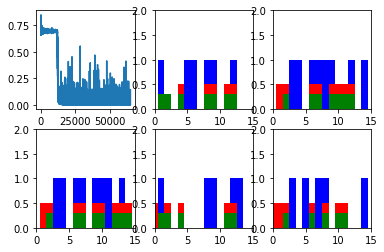

Step 100 Loss 0.000223569
single_output_series: [1 1 0 0 1 0 0 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 1 1 0 0 1 1 0]

single_output_series: [1 1 1 0 1 0 1 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 0 1 1 0 1 0 1]

single_output_series: [0 1 1 0 1 1 1 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 1 0 1 0 1 1]

single_output_series: [0 1 0 1 0 1 0 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 0 0 1 1 0]

single_output_series: [0 0 1 1 0 0 1 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 1 0 1 1 0 0]



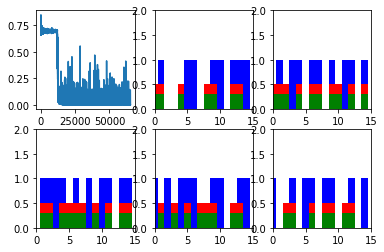

Step 200 Loss 0.000207759
single_output_series: [1 1 0 1 0 1 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 1 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 1 1 1 1 1 1]

single_output_series: [0 0 1 1 0 0 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 0 1 0 1 0 0]

single_output_series: [1 1 1 1 0 1 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 1 1 1 1 0 1 0]

single_output_series: [1 1 1 0 0 0 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 1 0 1 1 1 0]



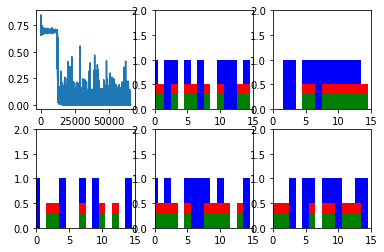

Step 300 Loss 0.000235415
single_output_series: [1 0 1 0 0 0 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 0 0 0 1 1 1]

single_output_series: [0 0 0 1 0 1 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 1 1 1 0 1 0]

single_output_series: [0 1 1 0 0 1 1 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 0 1 1 0 1 1]

single_output_series: [1 1 0 1 0 0 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 0 1 0 1 0 0 0]

single_output_series: [0 0 1 0 1 0 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 1 1 0 0 0 1 1]



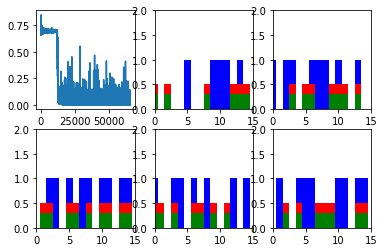

Step 400 Loss 0.000208653
single_output_series: [0 1 0 0 1 0 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 1 0 0 1 0 0]

single_output_series: [0 1 1 0 1 1 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 0 1 0 1 0 0 0]

single_output_series: [1 1 0 0 1 0 1 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 0 1 0 1 0 1 1]

single_output_series: [0 1 0 0 0 0 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 1 0 0 1 0 0]

single_output_series: [1 0 0 0 0 1 1 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 1 0 0 1 1 0]



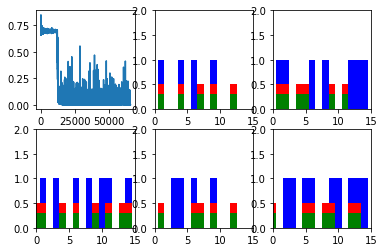

Step 500 Loss 0.000203684
single_output_series: [0 1 0 1 0 0 0 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 0 1 0 1 1 0]

single_output_series: [0 0 0 1 1 0 1 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 1 1 0 1 1 0]

single_output_series: [0 0 1 1 0 1 1 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 1 0 1 0 1 0]

single_output_series: [1 0 1 0 1 1 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 1 1 0 1 1 1]



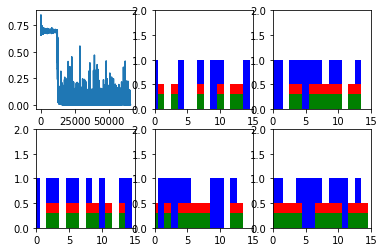

Step 600 Loss 0.00019003
single_output_series: [0 0 0 0 0 1 0 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 1 1 1 1 1 1]

single_output_series: [0 0 1 0 0 0 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 0 0 0 1 0 1]

single_output_series: [1 1 0 1 1 1 0 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 1 0 0 0 1 0]

single_output_series: [0 1 0 1 1 0 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 1 0 0 0 1 0]

single_output_series: [1 0 1 1 0 0 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 0 0 0 1 0 1]



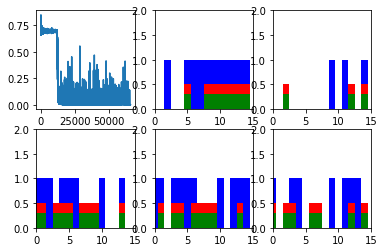

New data, epoch 99
Step 0 Loss 0.205046
single_output_series: [1 1 1 1 1 0 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 1 1 0 1 1 1]

single_output_series: [1 0 1 1 0 1 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 0 1 0 1 1]

single_output_series: [0 0 1 0 1 1 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 1 0 1 0 1 1]

single_output_series: [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]

single_output_series: [1 0 1 1 0 1 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 0 0 0 1 1 1 1]



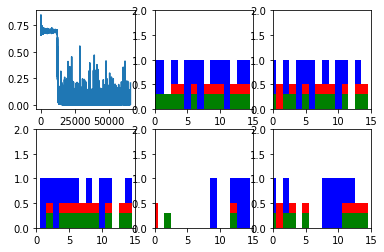

Step 100 Loss 0.000190843
single_output_series: [0 1 1 1 1 0 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 1 0 0 1 0 0]

single_output_series: [0 0 1 0 1 0 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 1 1 0 0 0 0 1]

single_output_series: [0 0 1 1 0 1 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 1 0 0 1 0 1]

single_output_series: [0 0 1 1 0 0 0 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 1 1 1 1 0 0 1]

single_output_series: [0 0 0 0 1 1 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 1 1 1 1 0 0]



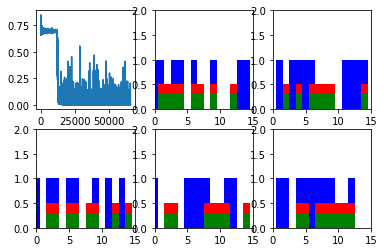

Step 200 Loss 0.000199548
single_output_series: [1 1 1 1 1 1 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 1 0 1 0 1 1 0]

single_output_series: [1 0 1 1 0 0 1 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 1 0 0 0 1 1]

single_output_series: [0 0 1 1 0 1 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 1 1 1 1 1 1]

single_output_series: [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0]

single_output_series: [0 1 0 0 1 0 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 0 0 0 1 0 0]



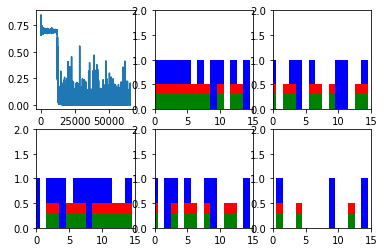

Step 300 Loss 0.000193656
single_output_series: [0 0 1 0 0 0 0 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 1 1 1 0 1 0 1]

single_output_series: [0 1 1 0 0 1 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 0 1 1 1 0 0]

single_output_series: [1 0 1 1 0 0 1 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 0 0 0 1 1]

single_output_series: [0 0 1 0 0 0 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 0 0 0 0 1 1]

single_output_series: [0 0 0 1 1 1 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 0 0 1 1 1 0]



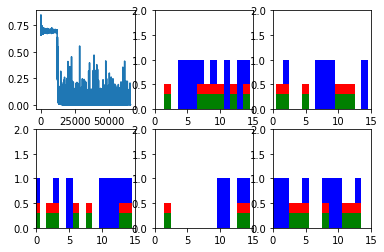

Step 400 Loss 0.00023964
single_output_series: [0 1 0 1 0 0 0 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 0 1 1 0 0 1]

single_output_series: [1 1 0 0 1 1 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 0 1 1 0 0 0]

single_output_series: [1 1 0 1 0 1 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 1 0 0 0 1 1]

single_output_series: [1 0 0 0 1 0 1 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 1 1 0 0 0 0]

single_output_series: [0 1 0 1 0 1 1 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 0 0 0 0 0 0]



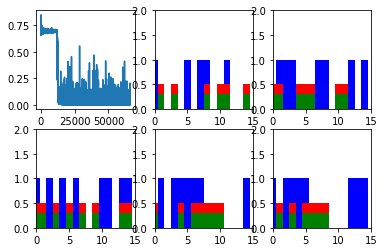

Step 500 Loss 0.000218941
single_output_series: [0 1 1 1 1 1 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 0 1 1 0 1]

single_output_series: [1 1 0 1 0 1 1 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 1 1 0 1 1 0]

single_output_series: [0 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 1 1 0 0 0]

single_output_series: [1 0 0 0 1 0 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 0 0 0 0 1 1 1]

single_output_series: [0 1 0 1 0 0 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 0 0 0 1 0 1]



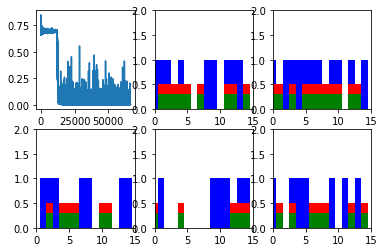

Step 600 Loss 0.000206185
single_output_series: [1 1 1 0 0 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 0 0 0 1 0 0 0]

single_output_series: [1 1 1 0 1 1 0 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 0 1 1 1 0 1]

single_output_series: [1 1 0 1 0 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 0 0 0 1 1 1 0]

single_output_series: [0 1 0 1 1 0 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 1 1 0 0 0 1]

single_output_series: [0 1 0 1 0 0 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 1 1 1 0 1 1 1]



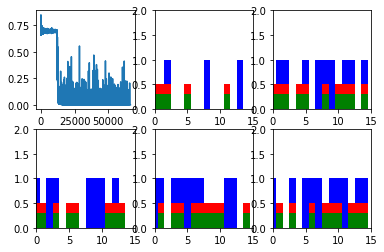

In [7]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], axis=1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels
    ) for logits, labels in zip(logits_series,labels_series)
]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)
tf.summary.histogram('histogram', _total_loss)
merged = tf.summary.merge_all()

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])
        print("single_output_series:", single_output_series)
        print("batchY[batch_series_idx, :]",batchY[batch_series_idx, :])
        print("")
        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    train_writer = tf.summary.FileWriter( './mdl_tr', sess.graph)
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            summary, _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [merged, total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })
            
            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)
        
        train_writer.add_summary(summary, epoch_idx)
        
plt.ioff()
plt.show()

In [28]:
bat_sz=4
seq = [1,2,3,4,5,6,7,8,9,10]
pad_field = bat_sz - (len(seq) % (bat_sz)

np.reshape(
    np.pad(seq, (0, pad_field), mode='constant'),
    (bat_sz, -1)
)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10,  0,  0]])